In [1]:
import os
import sys

sys.path.append('../..')

import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
from PIL import Image
from torch.nn import functional as F

from torch.utils.data import Subset
from PIL import Image, ImageFont, ImageDraw

from train_utils import Evaluator, Trainer, train
from torchvision import datasets
import matplotlib.pyplot as plt

In [2]:
data_split = '1'
wmtype = "unrelated"
wmcount = 100
lam = 0

In [3]:
def watermark_unrelated(new_label=4, count=100):
    np.random.seed(20)
    trainset = torchvision.datasets.MNIST(
        root='./data', train=True, download=True)
    watermarkset = []
    for idx in range(len(trainset)):
        img, label = trainset[idx]
        img = transforms.Resize((32,32))(img)
        img = transforms.ToTensor()(img)
        img = img.repeat(3, 1, 1)
        if idx == 0:
          x = (img.permute(1, 2, 0).numpy()*255).astype(np.uint8)
          #x = x[:,:,0]
          x = Image.fromarray(x)
          display(x)
          print(img.shape)
        img = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))(img)
        label = new_label
        watermarkset.append((img, label))
        if len(watermarkset) == count:
            return watermarkset

In [4]:
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


==> Preparing data..


In [5]:
def train_watermark_mix(trainset,watermarkset):

  todo = 1
  mixset = []
  for idx in range(len(trainset)):
      img, label = trainset[idx]
      #if idx == 0:
        #print(img)
      mixset.append((img, label))

  todo = 0
  for idx in range(len(watermarkset)):
      img, label = watermarkset[idx]
      #if(idx==0):
        #print(img)
      mixset.append((img, label))

  return mixset

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18().cuda()
    y = net(torch.randn(1, 3, 32, 32).cuda())
    print(y.size())

test()

torch.Size([1, 10])


Run 1

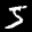

torch.Size([3, 32, 32])


In [7]:
batch_size_train = 256
batch_size_test = 256
batch_size_wm = 64

trainset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/train/', transform=transform_train)
incset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/train_incre/', transform=transform_train)
testset = datasets.ImageFolder('./data/CIFAR10_8020/test', transform=transform_test)
# valset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/val/', transform=transform_test)
watermarkset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/trigger_random/', transform=transform_test)
advwatermarkset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/trigger_adv/', transform=transform_test)

unrelatedset = watermark_unrelated(count=100)
train_watermark_mixset = torch.utils.data.ConcatDataset((trainset,unrelatedset))


# testset = torchvision.datasets.CIFAR10(
#     root='./data', train=False, download=True, transform=transform_test)

unrelatedloader = torch.utils.data.DataLoader(
    unrelatedset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=8)

# valloader = torch.utils.data.DataLoader(
#     valset, batch_size=batch_size_test, shuffle=False, num_workers=8)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

incloader = torch.utils.data.DataLoader(
    incset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

wmloader = torch.utils.data.DataLoader(
    watermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
advwmloader = torch.utils.data.DataLoader(
    advwatermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
train_watermark_loader = torch.utils.data.DataLoader(
    train_watermark_mixset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

In [8]:
netoriginalrand = ResNet18()
netoriginalrand.load_state_dict(torch.load('./checkpoints/resnet18_wm_8020_rand.ckpt'))
netoriginaladv = ResNet18()
netoriginaladv.load_state_dict(torch.load('./checkpoints/resnet18_wm_8020_adv.ckpt'))
netoriginalunrl = ResNet18()
netoriginalunrl.load_state_dict(torch.load('./checkpoints/resnet18_wm_8020_unrl.ckpt'))

netuniformrand = ResNet18()
netuniformrand.load_state_dict(torch.load('./checkpoints/resnet18_wm_frozen_8020_rand.ckpt'))
netuniformadv = ResNet18()
netuniformadv.load_state_dict(torch.load('./checkpoints/resnet18_wm_frozen_8020_adv.ckpt'))
netuniformunrl = ResNet18()
netuniformunrl.load_state_dict(torch.load('./checkpoints/resnet18_wm_frozen_8020_unrl.ckpt'))


<All keys matched successfully>

In [9]:
logcmt = f"incre_train_baseline_8020"

optimizeroriginalrand = torch.optim.SGD(lr=0.001, params=netoriginalrand.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

traineroriginalrand = Trainer(netoriginalrand, criterion, optimizeroriginalrand, incloader)
evaluatororiginalrand = Evaluator(netoriginalrand, criterion)

metricsoriginalrand = train(traineroriginalrand, evaluatororiginalrand, testloader, savename='inccheckpoints/incre_train_baseline_8020_rand', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

Start Training...


2023-02-02 09:27:19.600278: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-02 09:27:19.679834: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-02 09:27:19.695084: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-02 09:27:19.966634: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

Epoch 0 | Time 10s| Train Loss 0.4444 | Train Acc 86.84| Val Loss 0.460 | Val Acc 86.68| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.15it/s]


Epoch 1 | Time 22s| Train Loss 0.4014 | Train Acc 87.61| Val Loss 0.446 | Val Acc 87.20| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.94it/s]


Epoch 2 | Time 31s| Train Loss 0.3885 | Train Acc 87.99| Val Loss 0.437 | Val Acc 87.06| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.09it/s]


Epoch 3 | Time 41s| Train Loss 0.3650 | Train Acc 88.06| Val Loss 0.428 | Val Acc 87.12| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.03it/s]


Epoch 4 | Time 51s| Train Loss 0.3512 | Train Acc 88.77| Val Loss 0.420 | Val Acc 87.33| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.94it/s]


Epoch 5 | Time 61s| Train Loss 0.3442 | Train Acc 88.44| Val Loss 0.423 | Val Acc 87.06| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.10it/s]


Epoch 6 | Time 70s| Train Loss 0.3330 | Train Acc 88.98| Val Loss 0.417 | Val Acc 87.09| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.11it/s]


Epoch 7 | Time 79s| Train Loss 0.3231 | Train Acc 89.15| Val Loss 0.410 | Val Acc 87.18| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.82it/s]


Epoch 8 | Time 90s| Train Loss 0.3071 | Train Acc 89.91| Val Loss 0.413 | Val Acc 87.13| Trigger Loss 0.012 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:08<00:00,  4.34it/s]


Epoch 9 | Time 103s| Train Loss 0.3050 | Train Acc 89.60| Val Loss 0.410 | Val Acc 87.10| Trigger Loss 0.012 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.73it/s]


Epoch 10 | Time 118s| Train Loss 0.2944 | Train Acc 90.25| Val Loss 0.411 | Val Acc 86.96| Trigger Loss 0.012 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.20it/s]


Epoch 11 | Time 131s| Train Loss 0.2839 | Train Acc 90.33| Val Loss 0.407 | Val Acc 87.18| Trigger Loss 0.018 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.07it/s]


Epoch 12 | Time 143s| Train Loss 0.2881 | Train Acc 90.63| Val Loss 0.410 | Val Acc 87.01| Trigger Loss 0.024 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.71it/s]


Epoch 13 | Time 158s| Train Loss 0.2764 | Train Acc 90.52| Val Loss 0.410 | Val Acc 86.89| Trigger Loss 0.019 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.92it/s]


Epoch 14 | Time 172s| Train Loss 0.2700 | Train Acc 90.96| Val Loss 0.415 | Val Acc 86.82| Trigger Loss 0.024 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.01it/s]


Epoch 15 | Time 186s| Train Loss 0.2701 | Train Acc 90.81| Val Loss 0.407 | Val Acc 86.97| Trigger Loss 0.030 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.72it/s]


Epoch 16 | Time 199s| Train Loss 0.2620 | Train Acc 91.17| Val Loss 0.408 | Val Acc 87.01| Trigger Loss 0.032 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.89it/s]


Epoch 17 | Time 214s| Train Loss 0.2590 | Train Acc 91.32| Val Loss 0.412 | Val Acc 86.84| Trigger Loss 0.024 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.05it/s]


Epoch 18 | Time 227s| Train Loss 0.2520 | Train Acc 91.40| Val Loss 0.409 | Val Acc 86.97| Trigger Loss 0.019 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.80it/s]


Epoch 19 | Time 241s| Train Loss 0.2474 | Train Acc 91.69| Val Loss 0.410 | Val Acc 87.02| Trigger Loss 0.029 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.75it/s]


Epoch 20 | Time 255s| Train Loss 0.2423 | Train Acc 91.70| Val Loss 0.408 | Val Acc 86.99| Trigger Loss 0.037 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.96it/s]


Epoch 21 | Time 269s| Train Loss 0.2385 | Train Acc 91.86| Val Loss 0.414 | Val Acc 86.72| Trigger Loss 0.033 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.06it/s]


Epoch 22 | Time 283s| Train Loss 0.2381 | Train Acc 91.69| Val Loss 0.414 | Val Acc 86.92| Trigger Loss 0.028 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.73it/s]


Epoch 23 | Time 297s| Train Loss 0.2339 | Train Acc 92.12| Val Loss 0.418 | Val Acc 86.77| Trigger Loss 0.040 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.99it/s]


Epoch 24 | Time 311s| Train Loss 0.2328 | Train Acc 92.20| Val Loss 0.418 | Val Acc 86.59| Trigger Loss 0.042 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:08<00:00,  4.49it/s]


Epoch 25 | Time 323s| Train Loss 0.2246 | Train Acc 92.56| Val Loss 0.411 | Val Acc 86.89| Trigger Loss 0.035 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.80it/s]


Epoch 26 | Time 337s| Train Loss 0.2280 | Train Acc 92.29| Val Loss 0.415 | Val Acc 86.72| Trigger Loss 0.047 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.73it/s]


Epoch 27 | Time 352s| Train Loss 0.2178 | Train Acc 92.67| Val Loss 0.418 | Val Acc 86.82| Trigger Loss 0.044 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.98it/s]


Epoch 28 | Time 366s| Train Loss 0.2202 | Train Acc 92.71| Val Loss 0.420 | Val Acc 86.73| Trigger Loss 0.039 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.01it/s]


Epoch 29 | Time 379s| Train Loss 0.2125 | Train Acc 92.82| Val Loss 0.420 | Val Acc 86.70| Trigger Loss 0.037 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.79it/s]


Epoch 30 | Time 394s| Train Loss 0.2116 | Train Acc 92.73| Val Loss 0.421 | Val Acc 86.87| Trigger Loss 0.049 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.98it/s]


Epoch 31 | Time 408s| Train Loss 0.2018 | Train Acc 93.31| Val Loss 0.423 | Val Acc 86.80| Trigger Loss 0.055 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.03it/s]


Epoch 32 | Time 422s| Train Loss 0.1998 | Train Acc 93.15| Val Loss 0.423 | Val Acc 86.77| Trigger Loss 0.049 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.93it/s]


Epoch 33 | Time 436s| Train Loss 0.1957 | Train Acc 93.40| Val Loss 0.425 | Val Acc 86.78| Trigger Loss 0.052 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.74it/s]


Epoch 34 | Time 450s| Train Loss 0.1998 | Train Acc 93.25| Val Loss 0.426 | Val Acc 86.72| Trigger Loss 0.042 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.95it/s]


Epoch 35 | Time 464s| Train Loss 0.1970 | Train Acc 93.11| Val Loss 0.427 | Val Acc 86.78| Trigger Loss 0.040 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.14it/s]


Epoch 36 | Time 478s| Train Loss 0.1848 | Train Acc 93.70| Val Loss 0.429 | Val Acc 86.80| Trigger Loss 0.060 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.86it/s]


Epoch 37 | Time 491s| Train Loss 0.1969 | Train Acc 93.21| Val Loss 0.432 | Val Acc 86.37| Trigger Loss 0.058 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.76it/s]


Epoch 38 | Time 506s| Train Loss 0.1839 | Train Acc 93.51| Val Loss 0.433 | Val Acc 86.70| Trigger Loss 0.061 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.90it/s]


Epoch 39 | Time 520s| Train Loss 0.1838 | Train Acc 93.86| Val Loss 0.439 | Val Acc 86.81| Trigger Loss 0.052 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.04it/s]


Epoch 40 | Time 534s| Train Loss 0.1827 | Train Acc 93.72| Val Loss 0.435 | Val Acc 86.60| Trigger Loss 0.051 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.80it/s]


Epoch 41 | Time 547s| Train Loss 0.1816 | Train Acc 94.01| Val Loss 0.438 | Val Acc 86.58| Trigger Loss 0.059 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.74it/s]


Epoch 42 | Time 562s| Train Loss 0.1801 | Train Acc 93.79| Val Loss 0.439 | Val Acc 86.65| Trigger Loss 0.088 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.27it/s]


Epoch 43 | Time 575s| Train Loss 0.1714 | Train Acc 94.36| Val Loss 0.442 | Val Acc 86.53| Trigger Loss 0.058 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.21it/s]


Epoch 44 | Time 588s| Train Loss 0.1721 | Train Acc 94.25| Val Loss 0.445 | Val Acc 86.52| Trigger Loss 0.063 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.78it/s]


Epoch 45 | Time 602s| Train Loss 0.1682 | Train Acc 94.53| Val Loss 0.449 | Val Acc 86.53| Trigger Loss 0.045 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.83it/s]


Epoch 46 | Time 617s| Train Loss 0.1670 | Train Acc 94.39| Val Loss 0.448 | Val Acc 86.60| Trigger Loss 0.080 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.03it/s]


Epoch 47 | Time 630s| Train Loss 0.1608 | Train Acc 94.52| Val Loss 0.453 | Val Acc 86.55| Trigger Loss 0.087 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.88it/s]


Epoch 48 | Time 644s| Train Loss 0.1583 | Train Acc 94.83| Val Loss 0.452 | Val Acc 86.57| Trigger Loss 0.078 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.76it/s]


Epoch 49 | Time 658s| Train Loss 0.1614 | Train Acc 94.65| Val Loss 0.458 | Val Acc 86.44| Trigger Loss 0.068 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.91it/s]


Epoch 50 | Time 672s| Train Loss 0.1518 | Train Acc 94.85| Val Loss 0.456 | Val Acc 86.54| Trigger Loss 0.081 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.01it/s]


Epoch 51 | Time 685s| Train Loss 0.1506 | Train Acc 94.98| Val Loss 0.458 | Val Acc 86.56| Trigger Loss 0.098 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.81it/s]


Epoch 52 | Time 699s| Train Loss 0.1542 | Train Acc 94.85| Val Loss 0.461 | Val Acc 86.45| Trigger Loss 0.088 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.71it/s]


Epoch 53 | Time 714s| Train Loss 0.1499 | Train Acc 95.06| Val Loss 0.465 | Val Acc 86.60| Trigger Loss 0.091 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.99it/s]


Epoch 54 | Time 727s| Train Loss 0.1450 | Train Acc 95.28| Val Loss 0.466 | Val Acc 86.49| Trigger Loss 0.081 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.89it/s]


Epoch 55 | Time 740s| Train Loss 0.1460 | Train Acc 95.41| Val Loss 0.465 | Val Acc 86.63| Trigger Loss 0.113 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.75it/s]


Epoch 56 | Time 755s| Train Loss 0.1359 | Train Acc 95.52| Val Loss 0.470 | Val Acc 86.41| Trigger Loss 0.103 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.95it/s]


Epoch 57 | Time 768s| Train Loss 0.1385 | Train Acc 95.54| Val Loss 0.474 | Val Acc 86.50| Trigger Loss 0.095 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.99it/s]


Epoch 58 | Time 782s| Train Loss 0.1322 | Train Acc 95.52| Val Loss 0.477 | Val Acc 86.27| Trigger Loss 0.096 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.73it/s]


Epoch 59 | Time 796s| Train Loss 0.1298 | Train Acc 95.89| Val Loss 0.482 | Val Acc 86.10| Trigger Loss 0.070 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.73it/s]


Epoch 60 | Time 811s| Train Loss 0.1280 | Train Acc 95.96| Val Loss 0.481 | Val Acc 86.26| Trigger Loss 0.083 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.92it/s]


Epoch 61 | Time 825s| Train Loss 0.1304 | Train Acc 95.60| Val Loss 0.480 | Val Acc 86.03| Trigger Loss 0.090 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.02it/s]


Epoch 62 | Time 839s| Train Loss 0.1252 | Train Acc 95.95| Val Loss 0.479 | Val Acc 86.42| Trigger Loss 0.115 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.80it/s]


Epoch 63 | Time 854s| Train Loss 0.1243 | Train Acc 95.91| Val Loss 0.489 | Val Acc 86.30| Trigger Loss 0.096 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.74it/s]


Epoch 64 | Time 868s| Train Loss 0.1210 | Train Acc 95.98| Val Loss 0.488 | Val Acc 86.29| Trigger Loss 0.116 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.90it/s]


Epoch 65 | Time 882s| Train Loss 0.1203 | Train Acc 95.88| Val Loss 0.494 | Val Acc 86.14| Trigger Loss 0.100 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.98it/s]


Epoch 66 | Time 896s| Train Loss 0.1162 | Train Acc 96.24| Val Loss 0.495 | Val Acc 86.22| Trigger Loss 0.153 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.88it/s]


Epoch 67 | Time 910s| Train Loss 0.1132 | Train Acc 96.37| Val Loss 0.494 | Val Acc 86.18| Trigger Loss 0.130 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.76it/s]


Epoch 68 | Time 924s| Train Loss 0.1112 | Train Acc 96.47| Val Loss 0.499 | Val Acc 86.21| Trigger Loss 0.107 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.86it/s]


Epoch 69 | Time 938s| Train Loss 0.1128 | Train Acc 96.33| Val Loss 0.513 | Val Acc 86.03| Trigger Loss 0.101 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.02it/s]


Epoch 70 | Time 952s| Train Loss 0.1095 | Train Acc 96.53| Val Loss 0.509 | Val Acc 86.28| Trigger Loss 0.133 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.99it/s]


Epoch 71 | Time 966s| Train Loss 0.1038 | Train Acc 96.57| Val Loss 0.507 | Val Acc 86.13| Trigger Loss 0.114 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.75it/s]


Epoch 72 | Time 980s| Train Loss 0.1052 | Train Acc 96.81| Val Loss 0.509 | Val Acc 86.16| Trigger Loss 0.155 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.92it/s]


Epoch 73 | Time 994s| Train Loss 0.1042 | Train Acc 96.65| Val Loss 0.512 | Val Acc 86.13| Trigger Loss 0.154 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.99it/s]


Epoch 74 | Time 1008s| Train Loss 0.1029 | Train Acc 96.82| Val Loss 0.520 | Val Acc 86.03| Trigger Loss 0.131 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.79it/s]


Epoch 75 | Time 1022s| Train Loss 0.0992 | Train Acc 96.80| Val Loss 0.523 | Val Acc 85.86| Trigger Loss 0.189 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.75it/s]


Epoch 76 | Time 1036s| Train Loss 0.1013 | Train Acc 96.60| Val Loss 0.524 | Val Acc 85.95| Trigger Loss 0.139 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.14it/s]


Epoch 77 | Time 1048s| Train Loss 0.0958 | Train Acc 96.87| Val Loss 0.522 | Val Acc 86.23| Trigger Loss 0.167 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:08<00:00,  4.77it/s]


Epoch 78 | Time 1060s| Train Loss 0.0958 | Train Acc 97.09| Val Loss 0.525 | Val Acc 86.05| Trigger Loss 0.127 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.70it/s]


Epoch 79 | Time 1075s| Train Loss 0.0939 | Train Acc 96.89| Val Loss 0.533 | Val Acc 86.11| Trigger Loss 0.119 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.78it/s]


Epoch 80 | Time 1089s| Train Loss 0.0945 | Train Acc 97.02| Val Loss 0.521 | Val Acc 86.10| Trigger Loss 0.137 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.01it/s]


Epoch 81 | Time 1103s| Train Loss 0.0879 | Train Acc 97.21| Val Loss 0.529 | Val Acc 86.12| Trigger Loss 0.171 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.21it/s]


Epoch 82 | Time 1116s| Train Loss 0.0853 | Train Acc 97.55| Val Loss 0.530 | Val Acc 86.18| Trigger Loss 0.162 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.79it/s]


Epoch 83 | Time 1131s| Train Loss 0.0856 | Train Acc 97.35| Val Loss 0.533 | Val Acc 86.01| Trigger Loss 0.154 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.89it/s]


Epoch 84 | Time 1145s| Train Loss 0.0798 | Train Acc 97.51| Val Loss 0.533 | Val Acc 85.95| Trigger Loss 0.181 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.00it/s]


Epoch 85 | Time 1159s| Train Loss 0.0849 | Train Acc 97.49| Val Loss 0.538 | Val Acc 86.19| Trigger Loss 0.211 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.89it/s]


Epoch 86 | Time 1173s| Train Loss 0.0862 | Train Acc 97.18| Val Loss 0.543 | Val Acc 85.99| Trigger Loss 0.181 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.76it/s]


Epoch 87 | Time 1187s| Train Loss 0.0814 | Train Acc 97.33| Val Loss 0.545 | Val Acc 86.13| Trigger Loss 0.186 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.89it/s]


Epoch 88 | Time 1201s| Train Loss 0.0808 | Train Acc 97.49| Val Loss 0.543 | Val Acc 86.09| Trigger Loss 0.195 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.94it/s]


Epoch 89 | Time 1215s| Train Loss 0.0768 | Train Acc 97.62| Val Loss 0.552 | Val Acc 85.92| Trigger Loss 0.222 | Trigger Acc 92.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.72it/s]


Epoch 90 | Time 1229s| Train Loss 0.0743 | Train Acc 97.76| Val Loss 0.553 | Val Acc 85.90| Trigger Loss 0.203 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.60it/s]


Epoch 91 | Time 1244s| Train Loss 0.0718 | Train Acc 97.95| Val Loss 0.551 | Val Acc 86.08| Trigger Loss 0.181 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.73it/s]


Epoch 92 | Time 1258s| Train Loss 0.0743 | Train Acc 97.89| Val Loss 0.554 | Val Acc 85.91| Trigger Loss 0.178 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.02it/s]


Epoch 93 | Time 1271s| Train Loss 0.0739 | Train Acc 97.79| Val Loss 0.555 | Val Acc 86.06| Trigger Loss 0.205 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.59it/s]


Epoch 94 | Time 1286s| Train Loss 0.0656 | Train Acc 98.10| Val Loss 0.554 | Val Acc 86.01| Trigger Loss 0.250 | Trigger Acc 92.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.62it/s]


Epoch 95 | Time 1300s| Train Loss 0.0687 | Train Acc 97.98| Val Loss 0.561 | Val Acc 85.84| Trigger Loss 0.228 | Trigger Acc 92.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.81it/s]


Epoch 96 | Time 1314s| Train Loss 0.0610 | Train Acc 98.43| Val Loss 0.562 | Val Acc 86.02| Trigger Loss 0.197 | Trigger Acc 92.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.77it/s]


Epoch 97 | Time 1328s| Train Loss 0.0659 | Train Acc 98.02| Val Loss 0.560 | Val Acc 85.94| Trigger Loss 0.282 | Trigger Acc 90.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.58it/s]


Epoch 98 | Time 1342s| Train Loss 0.0683 | Train Acc 97.96| Val Loss 0.564 | Val Acc 85.74| Trigger Loss 0.298 | Trigger Acc 90.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.70it/s]


Epoch 99 | Time 1356s| Train Loss 0.0678 | Train Acc 97.80| Val Loss 0.568 | Val Acc 85.94| Trigger Loss 0.287 | Trigger Acc 89.00


In [10]:
logcmt = f"incre_train_baseline_8020"

optimizeroriginaladv = torch.optim.SGD(lr=0.001, params=netoriginaladv.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

traineroriginaladv = Trainer(netoriginaladv, criterion, optimizeroriginaladv, incloader)
evaluatororiginaladv = Evaluator(netoriginaladv, criterion)

metricsoriginaladv = train(traineroriginaladv, evaluatororiginaladv, testloader, savename='inccheckpoints/incre_train_baseline_8020_adv', logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader, epochs=100)

Start Training...


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.80it/s]


Epoch 0 | Time 13s| Train Loss 0.4422 | Train Acc 86.91| Val Loss 0.462 | Val Acc 87.30| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.99it/s]


Epoch 1 | Time 31s| Train Loss 0.4036 | Train Acc 87.81| Val Loss 0.448 | Val Acc 87.12| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.87it/s]


Epoch 2 | Time 46s| Train Loss 0.3880 | Train Acc 87.94| Val Loss 0.438 | Val Acc 87.26| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.77it/s]


Epoch 3 | Time 60s| Train Loss 0.3657 | Train Acc 88.24| Val Loss 0.432 | Val Acc 87.26| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.90it/s]


Epoch 4 | Time 75s| Train Loss 0.3537 | Train Acc 88.64| Val Loss 0.427 | Val Acc 87.33| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.00it/s]


Epoch 5 | Time 89s| Train Loss 0.3359 | Train Acc 89.12| Val Loss 0.431 | Val Acc 87.07| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.86it/s]


Epoch 6 | Time 103s| Train Loss 0.3294 | Train Acc 89.17| Val Loss 0.426 | Val Acc 87.36| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.76it/s]


Epoch 7 | Time 118s| Train Loss 0.3186 | Train Acc 89.13| Val Loss 0.422 | Val Acc 87.15| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.89it/s]


Epoch 8 | Time 132s| Train Loss 0.3111 | Train Acc 89.73| Val Loss 0.416 | Val Acc 87.30| Trigger Loss 0.010 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.09it/s]


Epoch 9 | Time 146s| Train Loss 0.3079 | Train Acc 89.55| Val Loss 0.411 | Val Acc 87.48| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.79it/s]


Epoch 10 | Time 160s| Train Loss 0.2960 | Train Acc 89.87| Val Loss 0.412 | Val Acc 87.41| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.62it/s]


Epoch 11 | Time 174s| Train Loss 0.2863 | Train Acc 90.21| Val Loss 0.409 | Val Acc 87.35| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.77it/s]


Epoch 12 | Time 188s| Train Loss 0.2807 | Train Acc 90.35| Val Loss 0.410 | Val Acc 87.41| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.81it/s]


Epoch 13 | Time 203s| Train Loss 0.2724 | Train Acc 90.48| Val Loss 0.406 | Val Acc 87.43| Trigger Loss 0.007 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.70it/s]


Epoch 14 | Time 217s| Train Loss 0.2707 | Train Acc 90.81| Val Loss 0.406 | Val Acc 87.37| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.60it/s]


Epoch 15 | Time 231s| Train Loss 0.2656 | Train Acc 90.76| Val Loss 0.407 | Val Acc 87.40| Trigger Loss 0.009 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.72it/s]


Epoch 16 | Time 246s| Train Loss 0.2605 | Train Acc 91.25| Val Loss 0.409 | Val Acc 87.05| Trigger Loss 0.015 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.79it/s]


Epoch 17 | Time 260s| Train Loss 0.2630 | Train Acc 91.27| Val Loss 0.408 | Val Acc 87.33| Trigger Loss 0.013 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.84it/s]


Epoch 18 | Time 275s| Train Loss 0.2552 | Train Acc 91.41| Val Loss 0.408 | Val Acc 87.26| Trigger Loss 0.009 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.66it/s]


Epoch 19 | Time 290s| Train Loss 0.2520 | Train Acc 91.32| Val Loss 0.411 | Val Acc 87.24| Trigger Loss 0.015 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.57it/s]


Epoch 20 | Time 305s| Train Loss 0.2473 | Train Acc 91.55| Val Loss 0.415 | Val Acc 87.15| Trigger Loss 0.010 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.69it/s]


Epoch 21 | Time 320s| Train Loss 0.2483 | Train Acc 91.28| Val Loss 0.415 | Val Acc 87.10| Trigger Loss 0.017 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.82it/s]


Epoch 22 | Time 334s| Train Loss 0.2416 | Train Acc 91.66| Val Loss 0.410 | Val Acc 87.30| Trigger Loss 0.016 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.78it/s]


Epoch 23 | Time 349s| Train Loss 0.2366 | Train Acc 91.90| Val Loss 0.411 | Val Acc 87.39| Trigger Loss 0.014 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.69it/s]


Epoch 24 | Time 363s| Train Loss 0.2343 | Train Acc 91.97| Val Loss 0.413 | Val Acc 87.24| Trigger Loss 0.012 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.60it/s]


Epoch 25 | Time 378s| Train Loss 0.2212 | Train Acc 92.43| Val Loss 0.416 | Val Acc 87.09| Trigger Loss 0.013 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:11<00:00,  3.52it/s]


Epoch 26 | Time 394s| Train Loss 0.2250 | Train Acc 92.26| Val Loss 0.416 | Val Acc 87.26| Trigger Loss 0.012 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.68it/s]


Epoch 27 | Time 410s| Train Loss 0.2169 | Train Acc 92.53| Val Loss 0.420 | Val Acc 87.16| Trigger Loss 0.027 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.74it/s]


Epoch 28 | Time 425s| Train Loss 0.2095 | Train Acc 92.89| Val Loss 0.419 | Val Acc 87.02| Trigger Loss 0.017 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.78it/s]


Epoch 29 | Time 439s| Train Loss 0.2132 | Train Acc 92.86| Val Loss 0.420 | Val Acc 87.05| Trigger Loss 0.023 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.69it/s]


Epoch 30 | Time 454s| Train Loss 0.2083 | Train Acc 92.97| Val Loss 0.424 | Val Acc 87.10| Trigger Loss 0.016 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.58it/s]


Epoch 31 | Time 469s| Train Loss 0.2086 | Train Acc 92.96| Val Loss 0.420 | Val Acc 87.32| Trigger Loss 0.040 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.62it/s]


Epoch 32 | Time 484s| Train Loss 0.1984 | Train Acc 93.16| Val Loss 0.425 | Val Acc 87.17| Trigger Loss 0.033 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.03it/s]


Epoch 33 | Time 497s| Train Loss 0.2018 | Train Acc 93.14| Val Loss 0.423 | Val Acc 87.26| Trigger Loss 0.024 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.87it/s]


Epoch 34 | Time 512s| Train Loss 0.2032 | Train Acc 93.08| Val Loss 0.427 | Val Acc 87.08| Trigger Loss 0.021 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.65it/s]


Epoch 35 | Time 527s| Train Loss 0.1929 | Train Acc 93.41| Val Loss 0.430 | Val Acc 87.03| Trigger Loss 0.029 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.58it/s]


Epoch 36 | Time 542s| Train Loss 0.1978 | Train Acc 93.25| Val Loss 0.432 | Val Acc 87.01| Trigger Loss 0.026 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.71it/s]


Epoch 37 | Time 557s| Train Loss 0.1888 | Train Acc 93.66| Val Loss 0.433 | Val Acc 87.04| Trigger Loss 0.025 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.80it/s]


Epoch 38 | Time 571s| Train Loss 0.1863 | Train Acc 93.74| Val Loss 0.433 | Val Acc 87.05| Trigger Loss 0.030 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.82it/s]


Epoch 39 | Time 586s| Train Loss 0.1854 | Train Acc 93.63| Val Loss 0.437 | Val Acc 87.12| Trigger Loss 0.019 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.61it/s]


Epoch 40 | Time 601s| Train Loss 0.1815 | Train Acc 93.75| Val Loss 0.432 | Val Acc 87.04| Trigger Loss 0.031 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.56it/s]


Epoch 41 | Time 617s| Train Loss 0.1824 | Train Acc 93.66| Val Loss 0.438 | Val Acc 87.21| Trigger Loss 0.020 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.69it/s]


Epoch 42 | Time 632s| Train Loss 0.1760 | Train Acc 93.81| Val Loss 0.440 | Val Acc 86.93| Trigger Loss 0.025 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.88it/s]


Epoch 43 | Time 646s| Train Loss 0.1699 | Train Acc 94.29| Val Loss 0.438 | Val Acc 87.18| Trigger Loss 0.036 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.80it/s]


Epoch 44 | Time 660s| Train Loss 0.1676 | Train Acc 94.33| Val Loss 0.441 | Val Acc 87.16| Trigger Loss 0.036 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.66it/s]


Epoch 45 | Time 675s| Train Loss 0.1616 | Train Acc 94.66| Val Loss 0.445 | Val Acc 87.06| Trigger Loss 0.030 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.85it/s]


Epoch 46 | Time 689s| Train Loss 0.1669 | Train Acc 94.20| Val Loss 0.448 | Val Acc 86.96| Trigger Loss 0.035 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.91it/s]


Epoch 47 | Time 703s| Train Loss 0.1618 | Train Acc 94.61| Val Loss 0.449 | Val Acc 86.89| Trigger Loss 0.028 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.75it/s]


Epoch 48 | Time 717s| Train Loss 0.1632 | Train Acc 94.53| Val Loss 0.449 | Val Acc 87.13| Trigger Loss 0.037 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.69it/s]


Epoch 49 | Time 732s| Train Loss 0.1517 | Train Acc 95.23| Val Loss 0.455 | Val Acc 87.06| Trigger Loss 0.023 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.91it/s]


Epoch 50 | Time 746s| Train Loss 0.1551 | Train Acc 94.81| Val Loss 0.460 | Val Acc 86.91| Trigger Loss 0.037 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.97it/s]


Epoch 51 | Time 760s| Train Loss 0.1498 | Train Acc 95.00| Val Loss 0.459 | Val Acc 86.86| Trigger Loss 0.042 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.73it/s]


Epoch 52 | Time 775s| Train Loss 0.1541 | Train Acc 94.81| Val Loss 0.463 | Val Acc 86.85| Trigger Loss 0.035 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.74it/s]


Epoch 53 | Time 789s| Train Loss 0.1495 | Train Acc 95.12| Val Loss 0.464 | Val Acc 86.64| Trigger Loss 0.036 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.15it/s]


Epoch 54 | Time 803s| Train Loss 0.1470 | Train Acc 94.95| Val Loss 0.469 | Val Acc 86.79| Trigger Loss 0.025 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.78it/s]


Epoch 55 | Time 817s| Train Loss 0.1377 | Train Acc 95.50| Val Loss 0.472 | Val Acc 86.73| Trigger Loss 0.028 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.75it/s]


Epoch 56 | Time 831s| Train Loss 0.1344 | Train Acc 95.60| Val Loss 0.468 | Val Acc 86.93| Trigger Loss 0.054 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:08<00:00,  4.40it/s]


Epoch 57 | Time 844s| Train Loss 0.1345 | Train Acc 95.76| Val Loss 0.469 | Val Acc 86.79| Trigger Loss 0.044 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.09it/s]


Epoch 58 | Time 858s| Train Loss 0.1332 | Train Acc 95.49| Val Loss 0.478 | Val Acc 86.47| Trigger Loss 0.042 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.78it/s]


Epoch 59 | Time 872s| Train Loss 0.1275 | Train Acc 95.85| Val Loss 0.478 | Val Acc 86.59| Trigger Loss 0.064 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.13it/s]


Epoch 60 | Time 886s| Train Loss 0.1275 | Train Acc 95.72| Val Loss 0.478 | Val Acc 86.73| Trigger Loss 0.046 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:08<00:00,  4.36it/s]


Epoch 61 | Time 899s| Train Loss 0.1227 | Train Acc 95.88| Val Loss 0.478 | Val Acc 86.81| Trigger Loss 0.051 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.84it/s]


Epoch 62 | Time 913s| Train Loss 0.1248 | Train Acc 95.79| Val Loss 0.483 | Val Acc 86.83| Trigger Loss 0.045 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.79it/s]


Epoch 63 | Time 927s| Train Loss 0.1165 | Train Acc 96.18| Val Loss 0.488 | Val Acc 86.85| Trigger Loss 0.030 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.05it/s]


Epoch 64 | Time 941s| Train Loss 0.1208 | Train Acc 96.07| Val Loss 0.495 | Val Acc 86.71| Trigger Loss 0.057 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.99it/s]


Epoch 65 | Time 955s| Train Loss 0.1197 | Train Acc 96.10| Val Loss 0.491 | Val Acc 86.59| Trigger Loss 0.055 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.76it/s]


Epoch 66 | Time 970s| Train Loss 0.1146 | Train Acc 96.10| Val Loss 0.497 | Val Acc 86.51| Trigger Loss 0.043 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.95it/s]


Epoch 67 | Time 984s| Train Loss 0.1161 | Train Acc 96.04| Val Loss 0.499 | Val Acc 86.45| Trigger Loss 0.069 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.07it/s]


Epoch 68 | Time 998s| Train Loss 0.1098 | Train Acc 96.48| Val Loss 0.503 | Val Acc 86.67| Trigger Loss 0.071 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.10it/s]


Epoch 69 | Time 1011s| Train Loss 0.1161 | Train Acc 96.02| Val Loss 0.502 | Val Acc 86.76| Trigger Loss 0.053 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.76it/s]


Epoch 70 | Time 1026s| Train Loss 0.1124 | Train Acc 96.33| Val Loss 0.500 | Val Acc 86.63| Trigger Loss 0.074 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.97it/s]


Epoch 71 | Time 1040s| Train Loss 0.1041 | Train Acc 96.56| Val Loss 0.509 | Val Acc 86.36| Trigger Loss 0.083 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.12it/s]


Epoch 72 | Time 1053s| Train Loss 0.1054 | Train Acc 96.58| Val Loss 0.512 | Val Acc 86.52| Trigger Loss 0.075 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.65it/s]


Epoch 73 | Time 1067s| Train Loss 0.1029 | Train Acc 96.66| Val Loss 0.509 | Val Acc 86.44| Trigger Loss 0.060 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.77it/s]


Epoch 74 | Time 1081s| Train Loss 0.0954 | Train Acc 96.95| Val Loss 0.514 | Val Acc 86.60| Trigger Loss 0.066 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.85it/s]


Epoch 75 | Time 1095s| Train Loss 0.0984 | Train Acc 96.85| Val Loss 0.518 | Val Acc 86.49| Trigger Loss 0.082 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.68it/s]


Epoch 76 | Time 1109s| Train Loss 0.0968 | Train Acc 96.77| Val Loss 0.519 | Val Acc 86.52| Trigger Loss 0.068 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.59it/s]


Epoch 77 | Time 1123s| Train Loss 0.0952 | Train Acc 96.84| Val Loss 0.523 | Val Acc 86.37| Trigger Loss 0.080 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.74it/s]


Epoch 78 | Time 1138s| Train Loss 0.0921 | Train Acc 97.23| Val Loss 0.519 | Val Acc 86.54| Trigger Loss 0.102 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.95it/s]


Epoch 79 | Time 1152s| Train Loss 0.0899 | Train Acc 97.17| Val Loss 0.531 | Val Acc 86.21| Trigger Loss 0.080 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.79it/s]


Epoch 80 | Time 1165s| Train Loss 0.0896 | Train Acc 97.23| Val Loss 0.529 | Val Acc 86.22| Trigger Loss 0.096 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.72it/s]


Epoch 81 | Time 1180s| Train Loss 0.0850 | Train Acc 97.44| Val Loss 0.535 | Val Acc 86.28| Trigger Loss 0.097 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.05it/s]


Epoch 82 | Time 1194s| Train Loss 0.0871 | Train Acc 97.12| Val Loss 0.538 | Val Acc 86.35| Trigger Loss 0.076 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.11it/s]


Epoch 83 | Time 1207s| Train Loss 0.0867 | Train Acc 97.30| Val Loss 0.538 | Val Acc 86.46| Trigger Loss 0.073 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.78it/s]


Epoch 84 | Time 1221s| Train Loss 0.0869 | Train Acc 97.23| Val Loss 0.538 | Val Acc 86.29| Trigger Loss 0.102 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.98it/s]


Epoch 85 | Time 1235s| Train Loss 0.0813 | Train Acc 97.55| Val Loss 0.544 | Val Acc 86.28| Trigger Loss 0.106 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:08<00:00,  4.85it/s]


Epoch 86 | Time 1248s| Train Loss 0.0795 | Train Acc 97.46| Val Loss 0.542 | Val Acc 86.25| Trigger Loss 0.086 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.75it/s]


Epoch 87 | Time 1262s| Train Loss 0.0786 | Train Acc 97.62| Val Loss 0.549 | Val Acc 86.35| Trigger Loss 0.120 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.91it/s]


Epoch 88 | Time 1276s| Train Loss 0.0780 | Train Acc 97.63| Val Loss 0.549 | Val Acc 86.33| Trigger Loss 0.132 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.10it/s]


Epoch 89 | Time 1290s| Train Loss 0.0785 | Train Acc 97.51| Val Loss 0.561 | Val Acc 86.24| Trigger Loss 0.100 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.69it/s]


Epoch 90 | Time 1303s| Train Loss 0.0763 | Train Acc 97.58| Val Loss 0.555 | Val Acc 86.17| Trigger Loss 0.124 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.61it/s]


Epoch 91 | Time 1318s| Train Loss 0.0729 | Train Acc 97.84| Val Loss 0.552 | Val Acc 86.26| Trigger Loss 0.084 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.82it/s]


Epoch 92 | Time 1331s| Train Loss 0.0735 | Train Acc 97.72| Val Loss 0.559 | Val Acc 86.14| Trigger Loss 0.088 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.01it/s]


Epoch 93 | Time 1345s| Train Loss 0.0688 | Train Acc 97.89| Val Loss 0.562 | Val Acc 86.19| Trigger Loss 0.101 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.61it/s]


Epoch 94 | Time 1359s| Train Loss 0.0707 | Train Acc 97.80| Val Loss 0.562 | Val Acc 86.31| Trigger Loss 0.120 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.76it/s]


Epoch 95 | Time 1374s| Train Loss 0.0695 | Train Acc 97.98| Val Loss 0.568 | Val Acc 86.17| Trigger Loss 0.147 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.85it/s]


Epoch 96 | Time 1388s| Train Loss 0.0647 | Train Acc 98.19| Val Loss 0.569 | Val Acc 86.21| Trigger Loss 0.114 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.73it/s]


Epoch 97 | Time 1403s| Train Loss 0.0635 | Train Acc 98.19| Val Loss 0.560 | Val Acc 86.21| Trigger Loss 0.119 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.61it/s]


Epoch 98 | Time 1417s| Train Loss 0.0651 | Train Acc 97.94| Val Loss 0.569 | Val Acc 86.09| Trigger Loss 0.111 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:08<00:00,  4.59it/s]


Epoch 99 | Time 1429s| Train Loss 0.0622 | Train Acc 98.26| Val Loss 0.570 | Val Acc 86.21| Trigger Loss 0.118 | Trigger Acc 96.00


In [11]:
logcmt = f"incre_train_baseline_8020"

optimizeroriginalunrl = torch.optim.SGD(lr=0.001, params=netoriginalunrl.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

traineroriginalunrl = Trainer(netoriginalunrl, criterion, optimizeroriginalunrl, incloader)
evaluatororiginalunrl = Evaluator(netoriginalunrl, criterion)

metricsoriginalunrl = train(traineroriginalunrl, evaluatororiginalunrl, testloader, savename='inccheckpoints/incre_train_baseline_8020_unrl', logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader, epochs=100)

Start Training...


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.24it/s]


Epoch 0 | Time 13s| Train Loss 0.4463 | Train Acc 86.60| Val Loss 0.442 | Val Acc 87.14| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.84it/s]


Epoch 1 | Time 31s| Train Loss 0.4033 | Train Acc 87.64| Val Loss 0.429 | Val Acc 87.49| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.65it/s]


Epoch 2 | Time 45s| Train Loss 0.3738 | Train Acc 88.15| Val Loss 0.424 | Val Acc 87.29| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.79it/s]


Epoch 3 | Time 60s| Train Loss 0.3574 | Train Acc 88.48| Val Loss 0.427 | Val Acc 87.01| Trigger Loss 0.010 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.93it/s]


Epoch 4 | Time 74s| Train Loss 0.3507 | Train Acc 88.49| Val Loss 0.417 | Val Acc 87.28| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.81it/s]


Epoch 5 | Time 88s| Train Loss 0.3318 | Train Acc 88.88| Val Loss 0.410 | Val Acc 87.15| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.73it/s]


Epoch 6 | Time 102s| Train Loss 0.3244 | Train Acc 89.40| Val Loss 0.412 | Val Acc 87.30| Trigger Loss 0.009 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.12it/s]


Epoch 7 | Time 116s| Train Loss 0.3201 | Train Acc 89.08| Val Loss 0.408 | Val Acc 87.32| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.96it/s]


Epoch 8 | Time 130s| Train Loss 0.3034 | Train Acc 90.04| Val Loss 0.407 | Val Acc 87.46| Trigger Loss 0.011 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.80it/s]


Epoch 9 | Time 144s| Train Loss 0.3046 | Train Acc 89.77| Val Loss 0.405 | Val Acc 87.25| Trigger Loss 0.013 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.72it/s]


Epoch 10 | Time 159s| Train Loss 0.2914 | Train Acc 89.93| Val Loss 0.406 | Val Acc 87.35| Trigger Loss 0.014 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.83it/s]


Epoch 11 | Time 173s| Train Loss 0.2874 | Train Acc 90.31| Val Loss 0.407 | Val Acc 87.27| Trigger Loss 0.019 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.91it/s]


Epoch 12 | Time 188s| Train Loss 0.2784 | Train Acc 90.21| Val Loss 0.405 | Val Acc 87.36| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.74it/s]


Epoch 13 | Time 202s| Train Loss 0.2838 | Train Acc 90.17| Val Loss 0.403 | Val Acc 87.37| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.55it/s]


Epoch 14 | Time 218s| Train Loss 0.2734 | Train Acc 90.60| Val Loss 0.399 | Val Acc 87.55| Trigger Loss 0.007 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.79it/s]


Epoch 15 | Time 232s| Train Loss 0.2665 | Train Acc 90.82| Val Loss 0.401 | Val Acc 87.44| Trigger Loss 0.007 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.85it/s]


Epoch 16 | Time 247s| Train Loss 0.2656 | Train Acc 90.93| Val Loss 0.400 | Val Acc 87.46| Trigger Loss 0.008 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.72it/s]


Epoch 17 | Time 261s| Train Loss 0.2557 | Train Acc 91.42| Val Loss 0.403 | Val Acc 87.48| Trigger Loss 0.023 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.69it/s]


Epoch 18 | Time 275s| Train Loss 0.2598 | Train Acc 90.74| Val Loss 0.399 | Val Acc 87.44| Trigger Loss 0.020 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.79it/s]


Epoch 19 | Time 290s| Train Loss 0.2530 | Train Acc 91.46| Val Loss 0.403 | Val Acc 87.42| Trigger Loss 0.035 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.86it/s]


Epoch 20 | Time 304s| Train Loss 0.2452 | Train Acc 91.63| Val Loss 0.404 | Val Acc 87.32| Trigger Loss 0.031 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.71it/s]


Epoch 21 | Time 318s| Train Loss 0.2466 | Train Acc 91.46| Val Loss 0.403 | Val Acc 87.46| Trigger Loss 0.021 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.66it/s]


Epoch 22 | Time 333s| Train Loss 0.2411 | Train Acc 91.65| Val Loss 0.402 | Val Acc 87.37| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.75it/s]


Epoch 23 | Time 347s| Train Loss 0.2419 | Train Acc 91.69| Val Loss 0.408 | Val Acc 87.39| Trigger Loss 0.144 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.91it/s]


Epoch 24 | Time 361s| Train Loss 0.2336 | Train Acc 91.90| Val Loss 0.406 | Val Acc 87.37| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.69it/s]


Epoch 25 | Time 376s| Train Loss 0.2269 | Train Acc 92.48| Val Loss 0.408 | Val Acc 87.45| Trigger Loss 0.013 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.59it/s]


Epoch 26 | Time 390s| Train Loss 0.2240 | Train Acc 92.70| Val Loss 0.409 | Val Acc 87.40| Trigger Loss 0.029 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.75it/s]


Epoch 27 | Time 405s| Train Loss 0.2231 | Train Acc 92.37| Val Loss 0.411 | Val Acc 87.24| Trigger Loss 0.010 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.83it/s]


Epoch 28 | Time 420s| Train Loss 0.2182 | Train Acc 92.63| Val Loss 0.413 | Val Acc 87.50| Trigger Loss 0.013 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.82it/s]


Epoch 29 | Time 435s| Train Loss 0.2129 | Train Acc 92.97| Val Loss 0.415 | Val Acc 87.24| Trigger Loss 0.009 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.64it/s]


Epoch 30 | Time 449s| Train Loss 0.2093 | Train Acc 93.03| Val Loss 0.418 | Val Acc 87.15| Trigger Loss 0.046 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.58it/s]


Epoch 31 | Time 464s| Train Loss 0.2057 | Train Acc 92.93| Val Loss 0.423 | Val Acc 87.29| Trigger Loss 0.145 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.72it/s]


Epoch 32 | Time 479s| Train Loss 0.2052 | Train Acc 93.04| Val Loss 0.420 | Val Acc 87.19| Trigger Loss 0.014 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.86it/s]


Epoch 33 | Time 493s| Train Loss 0.2059 | Train Acc 93.03| Val Loss 0.420 | Val Acc 87.14| Trigger Loss 0.038 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.94it/s]


Epoch 34 | Time 508s| Train Loss 0.1950 | Train Acc 93.22| Val Loss 0.423 | Val Acc 87.21| Trigger Loss 0.017 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.69it/s]


Epoch 35 | Time 522s| Train Loss 0.2014 | Train Acc 93.24| Val Loss 0.424 | Val Acc 87.33| Trigger Loss 0.022 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.65it/s]


Epoch 36 | Time 537s| Train Loss 0.1916 | Train Acc 93.44| Val Loss 0.426 | Val Acc 87.27| Trigger Loss 0.027 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.79it/s]


Epoch 37 | Time 552s| Train Loss 0.1884 | Train Acc 93.77| Val Loss 0.424 | Val Acc 87.21| Trigger Loss 0.021 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.93it/s]


Epoch 38 | Time 566s| Train Loss 0.1921 | Train Acc 93.34| Val Loss 0.429 | Val Acc 87.00| Trigger Loss 0.109 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.61it/s]


Epoch 39 | Time 580s| Train Loss 0.1826 | Train Acc 93.50| Val Loss 0.435 | Val Acc 87.03| Trigger Loss 0.031 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.72it/s]


Epoch 40 | Time 595s| Train Loss 0.1817 | Train Acc 93.87| Val Loss 0.430 | Val Acc 87.15| Trigger Loss 0.050 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.86it/s]


Epoch 41 | Time 609s| Train Loss 0.1830 | Train Acc 93.77| Val Loss 0.434 | Val Acc 87.02| Trigger Loss 0.076 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.71it/s]


Epoch 42 | Time 622s| Train Loss 0.1779 | Train Acc 93.88| Val Loss 0.435 | Val Acc 87.19| Trigger Loss 0.061 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.60it/s]


Epoch 43 | Time 636s| Train Loss 0.1692 | Train Acc 94.39| Val Loss 0.439 | Val Acc 87.05| Trigger Loss 0.042 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.79it/s]


Epoch 44 | Time 651s| Train Loss 0.1690 | Train Acc 94.18| Val Loss 0.440 | Val Acc 86.95| Trigger Loss 0.016 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.04it/s]


Epoch 45 | Time 664s| Train Loss 0.1618 | Train Acc 94.37| Val Loss 0.441 | Val Acc 86.93| Trigger Loss 0.009 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.65it/s]


Epoch 46 | Time 679s| Train Loss 0.1653 | Train Acc 94.74| Val Loss 0.441 | Val Acc 87.18| Trigger Loss 0.150 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.73it/s]


Epoch 47 | Time 693s| Train Loss 0.1572 | Train Acc 94.89| Val Loss 0.446 | Val Acc 86.91| Trigger Loss 0.118 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.82it/s]


Epoch 48 | Time 707s| Train Loss 0.1561 | Train Acc 94.67| Val Loss 0.448 | Val Acc 86.83| Trigger Loss 0.085 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.68it/s]


Epoch 49 | Time 721s| Train Loss 0.1591 | Train Acc 94.58| Val Loss 0.453 | Val Acc 87.01| Trigger Loss 0.042 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.58it/s]


Epoch 50 | Time 735s| Train Loss 0.1592 | Train Acc 94.54| Val Loss 0.453 | Val Acc 86.91| Trigger Loss 0.007 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.77it/s]


Epoch 51 | Time 750s| Train Loss 0.1528 | Train Acc 94.99| Val Loss 0.459 | Val Acc 86.80| Trigger Loss 0.668 | Trigger Acc 85.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.03it/s]


Epoch 52 | Time 763s| Train Loss 0.1513 | Train Acc 95.08| Val Loss 0.459 | Val Acc 86.72| Trigger Loss 0.049 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.62it/s]


Epoch 53 | Time 778s| Train Loss 0.1432 | Train Acc 95.10| Val Loss 0.464 | Val Acc 86.92| Trigger Loss 0.034 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.67it/s]


Epoch 54 | Time 793s| Train Loss 0.1440 | Train Acc 95.23| Val Loss 0.462 | Val Acc 86.74| Trigger Loss 0.010 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.97it/s]


Epoch 55 | Time 808s| Train Loss 0.1393 | Train Acc 95.34| Val Loss 0.468 | Val Acc 86.56| Trigger Loss 0.041 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.22it/s]


Epoch 56 | Time 822s| Train Loss 0.1362 | Train Acc 95.38| Val Loss 0.469 | Val Acc 86.85| Trigger Loss 0.035 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.74it/s]


Epoch 57 | Time 836s| Train Loss 0.1334 | Train Acc 95.60| Val Loss 0.470 | Val Acc 86.65| Trigger Loss 0.026 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.94it/s]


Epoch 58 | Time 850s| Train Loss 0.1375 | Train Acc 95.50| Val Loss 0.471 | Val Acc 86.90| Trigger Loss 0.066 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.99it/s]


Epoch 59 | Time 864s| Train Loss 0.1323 | Train Acc 95.52| Val Loss 0.473 | Val Acc 86.70| Trigger Loss 0.191 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.85it/s]


Epoch 60 | Time 878s| Train Loss 0.1334 | Train Acc 95.70| Val Loss 0.477 | Val Acc 86.76| Trigger Loss 0.038 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.74it/s]


Epoch 61 | Time 893s| Train Loss 0.1314 | Train Acc 95.80| Val Loss 0.479 | Val Acc 86.61| Trigger Loss 0.056 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.93it/s]


Epoch 62 | Time 907s| Train Loss 0.1224 | Train Acc 96.22| Val Loss 0.481 | Val Acc 86.71| Trigger Loss 0.024 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.19it/s]


Epoch 63 | Time 920s| Train Loss 0.1232 | Train Acc 95.98| Val Loss 0.486 | Val Acc 86.52| Trigger Loss 0.026 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.67it/s]


Epoch 64 | Time 935s| Train Loss 0.1160 | Train Acc 96.20| Val Loss 0.486 | Val Acc 86.64| Trigger Loss 0.145 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.82it/s]


Epoch 65 | Time 949s| Train Loss 0.1144 | Train Acc 96.27| Val Loss 0.493 | Val Acc 86.44| Trigger Loss 0.022 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.03it/s]


Epoch 66 | Time 963s| Train Loss 0.1210 | Train Acc 96.15| Val Loss 0.494 | Val Acc 86.52| Trigger Loss 0.039 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.74it/s]


Epoch 67 | Time 976s| Train Loss 0.1143 | Train Acc 96.31| Val Loss 0.491 | Val Acc 86.50| Trigger Loss 0.047 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.60it/s]


Epoch 68 | Time 991s| Train Loss 0.1122 | Train Acc 96.30| Val Loss 0.495 | Val Acc 86.65| Trigger Loss 0.061 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.82it/s]


Epoch 69 | Time 1005s| Train Loss 0.1123 | Train Acc 96.33| Val Loss 0.500 | Val Acc 86.66| Trigger Loss 0.058 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.91it/s]


Epoch 70 | Time 1019s| Train Loss 0.1102 | Train Acc 96.44| Val Loss 0.499 | Val Acc 86.48| Trigger Loss 0.027 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.59it/s]


Epoch 71 | Time 1034s| Train Loss 0.1051 | Train Acc 96.45| Val Loss 0.505 | Val Acc 86.38| Trigger Loss 0.104 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.76it/s]


Epoch 72 | Time 1049s| Train Loss 0.1071 | Train Acc 96.52| Val Loss 0.510 | Val Acc 86.56| Trigger Loss 0.099 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.98it/s]


Epoch 73 | Time 1063s| Train Loss 0.1067 | Train Acc 96.40| Val Loss 0.508 | Val Acc 86.53| Trigger Loss 0.026 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.01it/s]


Epoch 74 | Time 1076s| Train Loss 0.1012 | Train Acc 96.94| Val Loss 0.509 | Val Acc 86.56| Trigger Loss 0.014 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.62it/s]


Epoch 75 | Time 1091s| Train Loss 0.1043 | Train Acc 96.65| Val Loss 0.517 | Val Acc 86.29| Trigger Loss 0.064 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.78it/s]


Epoch 76 | Time 1105s| Train Loss 0.0933 | Train Acc 97.24| Val Loss 0.513 | Val Acc 86.56| Trigger Loss 0.055 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.99it/s]


Epoch 77 | Time 1119s| Train Loss 0.0939 | Train Acc 97.02| Val Loss 0.523 | Val Acc 86.33| Trigger Loss 0.422 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.66it/s]


Epoch 78 | Time 1133s| Train Loss 0.0917 | Train Acc 97.22| Val Loss 0.520 | Val Acc 86.45| Trigger Loss 0.042 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.61it/s]


Epoch 79 | Time 1148s| Train Loss 0.0945 | Train Acc 97.05| Val Loss 0.524 | Val Acc 86.60| Trigger Loss 0.218 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.88it/s]


Epoch 80 | Time 1162s| Train Loss 0.0911 | Train Acc 97.47| Val Loss 0.527 | Val Acc 86.41| Trigger Loss 0.104 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.78it/s]


Epoch 81 | Time 1176s| Train Loss 0.0923 | Train Acc 97.09| Val Loss 0.525 | Val Acc 86.46| Trigger Loss 0.065 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.70it/s]


Epoch 82 | Time 1191s| Train Loss 0.0888 | Train Acc 97.29| Val Loss 0.530 | Val Acc 86.43| Trigger Loss 0.026 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.76it/s]


Epoch 83 | Time 1205s| Train Loss 0.0878 | Train Acc 97.34| Val Loss 0.529 | Val Acc 86.35| Trigger Loss 0.026 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.01it/s]


Epoch 84 | Time 1219s| Train Loss 0.0833 | Train Acc 97.46| Val Loss 0.538 | Val Acc 86.39| Trigger Loss 0.179 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.60it/s]


Epoch 85 | Time 1233s| Train Loss 0.0844 | Train Acc 97.39| Val Loss 0.539 | Val Acc 86.29| Trigger Loss 0.059 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.77it/s]


Epoch 86 | Time 1248s| Train Loss 0.0795 | Train Acc 97.56| Val Loss 0.537 | Val Acc 86.60| Trigger Loss 0.086 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.85it/s]


Epoch 87 | Time 1262s| Train Loss 0.0809 | Train Acc 97.55| Val Loss 0.540 | Val Acc 86.42| Trigger Loss 0.099 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.68it/s]


Epoch 88 | Time 1276s| Train Loss 0.0790 | Train Acc 97.63| Val Loss 0.543 | Val Acc 86.14| Trigger Loss 0.080 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.58it/s]


Epoch 89 | Time 1290s| Train Loss 0.0797 | Train Acc 97.52| Val Loss 0.547 | Val Acc 86.37| Trigger Loss 0.059 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.73it/s]


Epoch 90 | Time 1304s| Train Loss 0.0788 | Train Acc 97.53| Val Loss 0.553 | Val Acc 86.21| Trigger Loss 0.017 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.84it/s]


Epoch 91 | Time 1319s| Train Loss 0.0747 | Train Acc 97.73| Val Loss 0.547 | Val Acc 86.38| Trigger Loss 0.137 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.69it/s]


Epoch 92 | Time 1333s| Train Loss 0.0711 | Train Acc 97.74| Val Loss 0.549 | Val Acc 86.29| Trigger Loss 0.027 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.57it/s]


Epoch 93 | Time 1348s| Train Loss 0.0668 | Train Acc 98.07| Val Loss 0.552 | Val Acc 86.27| Trigger Loss 0.026 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.72it/s]


Epoch 94 | Time 1362s| Train Loss 0.0696 | Train Acc 97.94| Val Loss 0.556 | Val Acc 86.42| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.81it/s]


Epoch 95 | Time 1376s| Train Loss 0.0679 | Train Acc 97.80| Val Loss 0.562 | Val Acc 86.12| Trigger Loss 0.157 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.68it/s]


Epoch 96 | Time 1391s| Train Loss 0.0682 | Train Acc 97.98| Val Loss 0.563 | Val Acc 86.35| Trigger Loss 0.008 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.60it/s]


Epoch 97 | Time 1405s| Train Loss 0.0671 | Train Acc 97.88| Val Loss 0.563 | Val Acc 86.35| Trigger Loss 0.162 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.76it/s]


Epoch 98 | Time 1419s| Train Loss 0.0625 | Train Acc 98.33| Val Loss 0.567 | Val Acc 86.15| Trigger Loss 0.194 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.81it/s]


Epoch 99 | Time 1433s| Train Loss 0.0588 | Train Acc 98.35| Val Loss 0.563 | Val Acc 86.28| Trigger Loss 0.165 | Trigger Acc 94.00


In [12]:
logcmt = f"incre_train_baseline_frozen_8020"

optimizeruniformrand = torch.optim.SGD(lr=0.001, params=netuniformrand.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

traineruniformrand = Trainer(netuniformrand, criterion, optimizeruniformrand, incloader)
evaluatoruniformrand = Evaluator(netuniformrand, criterion)

metricsuniformrand = train(traineruniformrand, evaluatoruniformrand, testloader, savename='inccheckpoints/incre_train_baseline_frozen_8020_rand', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

Start Training...


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.68it/s]


Epoch 0 | Time 14s| Train Loss 0.4726 | Train Acc 85.24| Val Loss 0.520 | Val Acc 84.97| Trigger Loss 0.123 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.02it/s]


Epoch 1 | Time 31s| Train Loss 0.4401 | Train Acc 86.36| Val Loss 0.494 | Val Acc 85.54| Trigger Loss 0.314 | Trigger Acc 86.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.75it/s]


Epoch 2 | Time 46s| Train Loss 0.4131 | Train Acc 86.60| Val Loss 0.484 | Val Acc 85.60| Trigger Loss 0.456 | Trigger Acc 82.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.94it/s]


Epoch 3 | Time 60s| Train Loss 0.3946 | Train Acc 87.15| Val Loss 0.476 | Val Acc 85.69| Trigger Loss 0.530 | Trigger Acc 84.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.96it/s]


Epoch 4 | Time 74s| Train Loss 0.3752 | Train Acc 87.45| Val Loss 0.467 | Val Acc 85.86| Trigger Loss 0.558 | Trigger Acc 74.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.77it/s]


Epoch 5 | Time 89s| Train Loss 0.3609 | Train Acc 88.21| Val Loss 0.462 | Val Acc 85.63| Trigger Loss 0.707 | Trigger Acc 75.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.69it/s]


Epoch 6 | Time 103s| Train Loss 0.3508 | Train Acc 88.24| Val Loss 0.467 | Val Acc 85.61| Trigger Loss 0.916 | Trigger Acc 69.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.89it/s]


Epoch 7 | Time 118s| Train Loss 0.3518 | Train Acc 88.15| Val Loss 0.461 | Val Acc 85.64| Trigger Loss 0.771 | Trigger Acc 70.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.02it/s]


Epoch 8 | Time 132s| Train Loss 0.3341 | Train Acc 88.71| Val Loss 0.457 | Val Acc 85.83| Trigger Loss 0.775 | Trigger Acc 74.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.77it/s]


Epoch 9 | Time 146s| Train Loss 0.3235 | Train Acc 89.02| Val Loss 0.458 | Val Acc 85.66| Trigger Loss 0.997 | Trigger Acc 70.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.75it/s]


Epoch 10 | Time 161s| Train Loss 0.3137 | Train Acc 89.30| Val Loss 0.461 | Val Acc 85.56| Trigger Loss 0.913 | Trigger Acc 65.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.09it/s]


Epoch 11 | Time 175s| Train Loss 0.3087 | Train Acc 89.17| Val Loss 0.453 | Val Acc 85.66| Trigger Loss 0.864 | Trigger Acc 72.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.82it/s]


Epoch 12 | Time 189s| Train Loss 0.2944 | Train Acc 90.19| Val Loss 0.459 | Val Acc 85.74| Trigger Loss 0.699 | Trigger Acc 76.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.73it/s]


Epoch 13 | Time 204s| Train Loss 0.2952 | Train Acc 89.75| Val Loss 0.455 | Val Acc 85.88| Trigger Loss 0.949 | Trigger Acc 68.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.86it/s]


Epoch 14 | Time 218s| Train Loss 0.2884 | Train Acc 89.94| Val Loss 0.455 | Val Acc 85.74| Trigger Loss 0.989 | Trigger Acc 66.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.98it/s]


Epoch 15 | Time 232s| Train Loss 0.2807 | Train Acc 90.14| Val Loss 0.465 | Val Acc 85.65| Trigger Loss 0.915 | Trigger Acc 73.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.95it/s]


Epoch 16 | Time 245s| Train Loss 0.2770 | Train Acc 90.38| Val Loss 0.459 | Val Acc 85.76| Trigger Loss 1.132 | Trigger Acc 66.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.73it/s]


Epoch 17 | Time 260s| Train Loss 0.2627 | Train Acc 91.04| Val Loss 0.459 | Val Acc 85.67| Trigger Loss 1.152 | Trigger Acc 66.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.83it/s]


Epoch 18 | Time 274s| Train Loss 0.2728 | Train Acc 90.54| Val Loss 0.462 | Val Acc 85.55| Trigger Loss 0.986 | Trigger Acc 68.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:08<00:00,  4.39it/s]


Epoch 19 | Time 288s| Train Loss 0.2584 | Train Acc 91.21| Val Loss 0.467 | Val Acc 85.47| Trigger Loss 0.985 | Trigger Acc 66.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.70it/s]


Epoch 20 | Time 302s| Train Loss 0.2555 | Train Acc 91.29| Val Loss 0.468 | Val Acc 85.67| Trigger Loss 0.881 | Trigger Acc 71.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.78it/s]


Epoch 21 | Time 317s| Train Loss 0.2508 | Train Acc 91.08| Val Loss 0.469 | Val Acc 85.48| Trigger Loss 0.819 | Trigger Acc 72.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.19it/s]


Epoch 22 | Time 331s| Train Loss 0.2502 | Train Acc 91.59| Val Loss 0.461 | Val Acc 85.54| Trigger Loss 1.065 | Trigger Acc 67.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.84it/s]


Epoch 23 | Time 344s| Train Loss 0.2459 | Train Acc 91.72| Val Loss 0.463 | Val Acc 85.68| Trigger Loss 0.922 | Trigger Acc 69.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.73it/s]


Epoch 24 | Time 359s| Train Loss 0.2422 | Train Acc 92.05| Val Loss 0.471 | Val Acc 85.43| Trigger Loss 1.245 | Trigger Acc 62.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.85it/s]


Epoch 25 | Time 373s| Train Loss 0.2351 | Train Acc 92.04| Val Loss 0.471 | Val Acc 85.56| Trigger Loss 1.177 | Trigger Acc 64.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.95it/s]


Epoch 26 | Time 387s| Train Loss 0.2354 | Train Acc 91.87| Val Loss 0.471 | Val Acc 85.71| Trigger Loss 1.100 | Trigger Acc 62.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.80it/s]


Epoch 27 | Time 402s| Train Loss 0.2251 | Train Acc 92.38| Val Loss 0.476 | Val Acc 85.47| Trigger Loss 1.081 | Trigger Acc 66.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.73it/s]


Epoch 28 | Time 416s| Train Loss 0.2235 | Train Acc 92.76| Val Loss 0.476 | Val Acc 85.49| Trigger Loss 1.142 | Trigger Acc 66.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.86it/s]


Epoch 29 | Time 430s| Train Loss 0.2196 | Train Acc 92.56| Val Loss 0.475 | Val Acc 85.85| Trigger Loss 1.252 | Trigger Acc 65.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.96it/s]


Epoch 30 | Time 445s| Train Loss 0.2204 | Train Acc 92.56| Val Loss 0.483 | Val Acc 85.56| Trigger Loss 1.249 | Trigger Acc 64.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.79it/s]


Epoch 31 | Time 459s| Train Loss 0.2103 | Train Acc 92.88| Val Loss 0.485 | Val Acc 85.58| Trigger Loss 1.197 | Trigger Acc 61.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.70it/s]


Epoch 32 | Time 473s| Train Loss 0.2129 | Train Acc 92.79| Val Loss 0.490 | Val Acc 85.26| Trigger Loss 1.306 | Trigger Acc 61.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.85it/s]


Epoch 33 | Time 488s| Train Loss 0.2055 | Train Acc 92.97| Val Loss 0.492 | Val Acc 85.41| Trigger Loss 1.182 | Trigger Acc 63.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.90it/s]


Epoch 34 | Time 502s| Train Loss 0.2015 | Train Acc 93.17| Val Loss 0.492 | Val Acc 85.45| Trigger Loss 1.247 | Trigger Acc 64.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.74it/s]


Epoch 35 | Time 516s| Train Loss 0.1964 | Train Acc 93.30| Val Loss 0.494 | Val Acc 85.44| Trigger Loss 1.513 | Trigger Acc 58.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.65it/s]


Epoch 36 | Time 531s| Train Loss 0.1967 | Train Acc 93.48| Val Loss 0.495 | Val Acc 85.44| Trigger Loss 1.367 | Trigger Acc 60.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.75it/s]


Epoch 37 | Time 545s| Train Loss 0.1947 | Train Acc 93.40| Val Loss 0.498 | Val Acc 85.36| Trigger Loss 1.393 | Trigger Acc 60.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.84it/s]


Epoch 38 | Time 560s| Train Loss 0.1879 | Train Acc 93.52| Val Loss 0.501 | Val Acc 85.32| Trigger Loss 1.428 | Trigger Acc 62.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.89it/s]


Epoch 39 | Time 572s| Train Loss 0.1830 | Train Acc 93.78| Val Loss 0.507 | Val Acc 85.48| Trigger Loss 1.321 | Trigger Acc 61.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.60it/s]


Epoch 40 | Time 587s| Train Loss 0.1792 | Train Acc 94.20| Val Loss 0.511 | Val Acc 85.12| Trigger Loss 1.395 | Trigger Acc 63.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.74it/s]


Epoch 41 | Time 601s| Train Loss 0.1772 | Train Acc 94.07| Val Loss 0.513 | Val Acc 84.94| Trigger Loss 1.583 | Trigger Acc 59.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.01it/s]


Epoch 42 | Time 615s| Train Loss 0.1752 | Train Acc 94.31| Val Loss 0.508 | Val Acc 85.26| Trigger Loss 1.484 | Trigger Acc 60.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.61it/s]


Epoch 43 | Time 629s| Train Loss 0.1685 | Train Acc 94.41| Val Loss 0.518 | Val Acc 85.13| Trigger Loss 1.372 | Trigger Acc 59.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.65it/s]


Epoch 44 | Time 644s| Train Loss 0.1555 | Train Acc 95.01| Val Loss 0.516 | Val Acc 85.11| Trigger Loss 1.380 | Trigger Acc 61.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.83it/s]


Epoch 45 | Time 658s| Train Loss 0.1678 | Train Acc 94.62| Val Loss 0.523 | Val Acc 85.10| Trigger Loss 1.446 | Trigger Acc 58.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.71it/s]


Epoch 46 | Time 672s| Train Loss 0.1642 | Train Acc 94.47| Val Loss 0.519 | Val Acc 85.17| Trigger Loss 1.638 | Trigger Acc 56.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.61it/s]


Epoch 47 | Time 686s| Train Loss 0.1512 | Train Acc 95.03| Val Loss 0.525 | Val Acc 85.15| Trigger Loss 1.625 | Trigger Acc 59.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.79it/s]


Epoch 48 | Time 700s| Train Loss 0.1535 | Train Acc 94.83| Val Loss 0.539 | Val Acc 84.93| Trigger Loss 1.753 | Trigger Acc 56.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.81it/s]


Epoch 49 | Time 714s| Train Loss 0.1538 | Train Acc 94.91| Val Loss 0.534 | Val Acc 85.13| Trigger Loss 1.684 | Trigger Acc 57.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.77it/s]


Epoch 50 | Time 728s| Train Loss 0.1434 | Train Acc 95.20| Val Loss 0.538 | Val Acc 84.95| Trigger Loss 1.587 | Trigger Acc 61.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.55it/s]


Epoch 51 | Time 743s| Train Loss 0.1505 | Train Acc 95.07| Val Loss 0.539 | Val Acc 85.01| Trigger Loss 1.470 | Trigger Acc 58.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.75it/s]


Epoch 52 | Time 758s| Train Loss 0.1458 | Train Acc 95.29| Val Loss 0.534 | Val Acc 85.13| Trigger Loss 1.685 | Trigger Acc 56.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.77it/s]


Epoch 53 | Time 773s| Train Loss 0.1408 | Train Acc 95.40| Val Loss 0.540 | Val Acc 84.97| Trigger Loss 1.683 | Trigger Acc 59.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.63it/s]


Epoch 54 | Time 787s| Train Loss 0.1369 | Train Acc 95.33| Val Loss 0.542 | Val Acc 85.12| Trigger Loss 1.584 | Trigger Acc 58.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.62it/s]


Epoch 55 | Time 802s| Train Loss 0.1329 | Train Acc 95.72| Val Loss 0.549 | Val Acc 84.74| Trigger Loss 1.717 | Trigger Acc 54.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.70it/s]


Epoch 56 | Time 817s| Train Loss 0.1350 | Train Acc 95.69| Val Loss 0.555 | Val Acc 84.98| Trigger Loss 1.642 | Trigger Acc 56.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.79it/s]


Epoch 57 | Time 831s| Train Loss 0.1310 | Train Acc 95.52| Val Loss 0.556 | Val Acc 84.88| Trigger Loss 1.625 | Trigger Acc 63.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.80it/s]


Epoch 58 | Time 846s| Train Loss 0.1262 | Train Acc 95.92| Val Loss 0.558 | Val Acc 84.84| Trigger Loss 1.681 | Trigger Acc 58.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.63it/s]


Epoch 59 | Time 860s| Train Loss 0.1235 | Train Acc 96.00| Val Loss 0.553 | Val Acc 85.18| Trigger Loss 1.908 | Trigger Acc 53.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.58it/s]


Epoch 60 | Time 875s| Train Loss 0.1194 | Train Acc 96.05| Val Loss 0.559 | Val Acc 85.00| Trigger Loss 1.813 | Trigger Acc 55.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.00it/s]


Epoch 61 | Time 889s| Train Loss 0.1201 | Train Acc 96.18| Val Loss 0.562 | Val Acc 84.79| Trigger Loss 1.976 | Trigger Acc 49.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.85it/s]


Epoch 62 | Time 903s| Train Loss 0.1162 | Train Acc 96.36| Val Loss 0.571 | Val Acc 84.72| Trigger Loss 1.843 | Trigger Acc 55.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.72it/s]


Epoch 63 | Time 917s| Train Loss 0.1188 | Train Acc 96.36| Val Loss 0.582 | Val Acc 84.33| Trigger Loss 2.180 | Trigger Acc 55.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.65it/s]


Epoch 64 | Time 931s| Train Loss 0.1131 | Train Acc 96.39| Val Loss 0.579 | Val Acc 84.66| Trigger Loss 2.016 | Trigger Acc 53.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.82it/s]


Epoch 65 | Time 945s| Train Loss 0.1127 | Train Acc 96.46| Val Loss 0.583 | Val Acc 84.63| Trigger Loss 2.035 | Trigger Acc 54.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.89it/s]


Epoch 66 | Time 960s| Train Loss 0.1089 | Train Acc 96.47| Val Loss 0.580 | Val Acc 84.75| Trigger Loss 2.020 | Trigger Acc 54.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.74it/s]


Epoch 67 | Time 974s| Train Loss 0.1131 | Train Acc 96.40| Val Loss 0.579 | Val Acc 84.78| Trigger Loss 2.076 | Trigger Acc 53.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.67it/s]


Epoch 68 | Time 988s| Train Loss 0.0979 | Train Acc 96.91| Val Loss 0.594 | Val Acc 84.70| Trigger Loss 2.089 | Trigger Acc 52.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.85it/s]


Epoch 69 | Time 1002s| Train Loss 0.0966 | Train Acc 96.95| Val Loss 0.587 | Val Acc 84.77| Trigger Loss 2.117 | Trigger Acc 53.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.87it/s]


Epoch 70 | Time 1016s| Train Loss 0.1034 | Train Acc 96.62| Val Loss 0.603 | Val Acc 84.66| Trigger Loss 2.216 | Trigger Acc 54.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.71it/s]


Epoch 71 | Time 1031s| Train Loss 0.1005 | Train Acc 96.90| Val Loss 0.595 | Val Acc 84.59| Trigger Loss 2.176 | Trigger Acc 49.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.75it/s]


Epoch 72 | Time 1045s| Train Loss 0.0953 | Train Acc 96.99| Val Loss 0.602 | Val Acc 84.50| Trigger Loss 2.142 | Trigger Acc 53.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.07it/s]


Epoch 73 | Time 1059s| Train Loss 0.0899 | Train Acc 97.21| Val Loss 0.601 | Val Acc 84.82| Trigger Loss 2.235 | Trigger Acc 51.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.75it/s]


Epoch 74 | Time 1073s| Train Loss 0.0944 | Train Acc 97.06| Val Loss 0.610 | Val Acc 84.43| Trigger Loss 2.368 | Trigger Acc 50.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.68it/s]


Epoch 75 | Time 1087s| Train Loss 0.0903 | Train Acc 97.07| Val Loss 0.613 | Val Acc 84.52| Trigger Loss 2.455 | Trigger Acc 51.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.96it/s]


Epoch 76 | Time 1101s| Train Loss 0.0927 | Train Acc 97.02| Val Loss 0.618 | Val Acc 84.53| Trigger Loss 2.278 | Trigger Acc 52.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.13it/s]


Epoch 77 | Time 1115s| Train Loss 0.0841 | Train Acc 97.36| Val Loss 0.608 | Val Acc 84.60| Trigger Loss 2.203 | Trigger Acc 55.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.80it/s]


Epoch 78 | Time 1129s| Train Loss 0.0839 | Train Acc 97.46| Val Loss 0.620 | Val Acc 84.45| Trigger Loss 2.167 | Trigger Acc 53.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.74it/s]


Epoch 79 | Time 1144s| Train Loss 0.0797 | Train Acc 97.60| Val Loss 0.628 | Val Acc 84.40| Trigger Loss 2.173 | Trigger Acc 51.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.31it/s]


Epoch 80 | Time 1157s| Train Loss 0.0841 | Train Acc 97.42| Val Loss 0.628 | Val Acc 84.38| Trigger Loss 2.405 | Trigger Acc 50.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.85it/s]


Epoch 81 | Time 1171s| Train Loss 0.0785 | Train Acc 97.55| Val Loss 0.640 | Val Acc 84.04| Trigger Loss 2.539 | Trigger Acc 52.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.76it/s]


Epoch 82 | Time 1186s| Train Loss 0.0742 | Train Acc 97.74| Val Loss 0.640 | Val Acc 83.98| Trigger Loss 2.491 | Trigger Acc 50.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.22it/s]


Epoch 83 | Time 1199s| Train Loss 0.0748 | Train Acc 97.80| Val Loss 0.634 | Val Acc 84.47| Trigger Loss 2.520 | Trigger Acc 51.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.07it/s]


Epoch 84 | Time 1213s| Train Loss 0.0695 | Train Acc 98.02| Val Loss 0.638 | Val Acc 84.45| Trigger Loss 2.535 | Trigger Acc 49.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.71it/s]


Epoch 85 | Time 1227s| Train Loss 0.0700 | Train Acc 98.04| Val Loss 0.642 | Val Acc 84.55| Trigger Loss 2.598 | Trigger Acc 46.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.61it/s]


Epoch 86 | Time 1241s| Train Loss 0.0715 | Train Acc 97.76| Val Loss 0.649 | Val Acc 84.36| Trigger Loss 2.560 | Trigger Acc 50.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.77it/s]


Epoch 87 | Time 1256s| Train Loss 0.0669 | Train Acc 98.01| Val Loss 0.642 | Val Acc 84.29| Trigger Loss 2.602 | Trigger Acc 47.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.84it/s]


Epoch 88 | Time 1270s| Train Loss 0.0685 | Train Acc 98.04| Val Loss 0.652 | Val Acc 84.22| Trigger Loss 2.650 | Trigger Acc 50.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.69it/s]


Epoch 89 | Time 1284s| Train Loss 0.0615 | Train Acc 98.22| Val Loss 0.650 | Val Acc 84.42| Trigger Loss 2.623 | Trigger Acc 49.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.64it/s]


Epoch 90 | Time 1299s| Train Loss 0.0642 | Train Acc 98.04| Val Loss 0.660 | Val Acc 84.30| Trigger Loss 2.542 | Trigger Acc 51.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.75it/s]


Epoch 91 | Time 1313s| Train Loss 0.0591 | Train Acc 98.31| Val Loss 0.656 | Val Acc 84.63| Trigger Loss 2.559 | Trigger Acc 49.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.05it/s]


Epoch 92 | Time 1327s| Train Loss 0.0628 | Train Acc 98.26| Val Loss 0.662 | Val Acc 84.32| Trigger Loss 2.533 | Trigger Acc 53.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.67it/s]


Epoch 93 | Time 1341s| Train Loss 0.0587 | Train Acc 98.37| Val Loss 0.660 | Val Acc 84.39| Trigger Loss 2.688 | Trigger Acc 47.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.61it/s]


Epoch 94 | Time 1355s| Train Loss 0.0596 | Train Acc 98.21| Val Loss 0.659 | Val Acc 84.15| Trigger Loss 2.446 | Trigger Acc 48.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.73it/s]


Epoch 95 | Time 1370s| Train Loss 0.0640 | Train Acc 98.12| Val Loss 0.675 | Val Acc 84.42| Trigger Loss 2.639 | Trigger Acc 51.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.81it/s]


Epoch 96 | Time 1384s| Train Loss 0.0570 | Train Acc 98.44| Val Loss 0.675 | Val Acc 84.19| Trigger Loss 2.763 | Trigger Acc 49.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.65it/s]


Epoch 97 | Time 1398s| Train Loss 0.0583 | Train Acc 98.41| Val Loss 0.680 | Val Acc 84.39| Trigger Loss 2.653 | Trigger Acc 49.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.69it/s]


Epoch 98 | Time 1413s| Train Loss 0.0555 | Train Acc 98.47| Val Loss 0.671 | Val Acc 84.34| Trigger Loss 2.740 | Trigger Acc 51.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.82it/s]


Epoch 99 | Time 1427s| Train Loss 0.0577 | Train Acc 98.23| Val Loss 0.675 | Val Acc 84.23| Trigger Loss 2.790 | Trigger Acc 47.00


In [13]:
logcmt = f"incre_train_baseline_frozen_8020"

optimizeruniformadv = torch.optim.SGD(lr=0.001, params=netuniformadv.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

traineruniformadv = Trainer(netuniformadv, criterion, optimizeruniformadv, incloader)
evaluatoruniformadv = Evaluator(netuniformadv, criterion)

metricsuniformadv = train(traineruniformadv, evaluatoruniformadv, testloader, savename='inccheckpoints/incre_train_baseline_frozen_8020_adv', logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader, epochs=100)

Start Training...


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.87it/s]


Epoch 0 | Time 14s| Train Loss 0.4701 | Train Acc 85.51| Val Loss 0.515 | Val Acc 85.46| Trigger Loss 0.056 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.97it/s]


Epoch 1 | Time 32s| Train Loss 0.4351 | Train Acc 86.34| Val Loss 0.488 | Val Acc 85.82| Trigger Loss 0.053 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.74it/s]


Epoch 2 | Time 46s| Train Loss 0.4084 | Train Acc 86.85| Val Loss 0.474 | Val Acc 85.78| Trigger Loss 0.087 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.85it/s]


Epoch 3 | Time 61s| Train Loss 0.3817 | Train Acc 87.48| Val Loss 0.475 | Val Acc 85.75| Trigger Loss 0.153 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.21it/s]


Epoch 4 | Time 74s| Train Loss 0.3748 | Train Acc 87.78| Val Loss 0.467 | Val Acc 85.96| Trigger Loss 0.167 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.82it/s]


Epoch 5 | Time 88s| Train Loss 0.3636 | Train Acc 87.57| Val Loss 0.462 | Val Acc 85.67| Trigger Loss 0.173 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.75it/s]


Epoch 6 | Time 103s| Train Loss 0.3428 | Train Acc 88.17| Val Loss 0.461 | Val Acc 85.91| Trigger Loss 0.162 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.88it/s]


Epoch 7 | Time 117s| Train Loss 0.3392 | Train Acc 88.65| Val Loss 0.461 | Val Acc 85.87| Trigger Loss 0.242 | Trigger Acc 92.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.22it/s]


Epoch 8 | Time 130s| Train Loss 0.3227 | Train Acc 89.13| Val Loss 0.452 | Val Acc 85.84| Trigger Loss 0.251 | Trigger Acc 92.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.74it/s]


Epoch 9 | Time 145s| Train Loss 0.3210 | Train Acc 89.07| Val Loss 0.458 | Val Acc 85.61| Trigger Loss 0.295 | Trigger Acc 91.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.74it/s]


Epoch 10 | Time 159s| Train Loss 0.3150 | Train Acc 89.51| Val Loss 0.451 | Val Acc 85.91| Trigger Loss 0.165 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.95it/s]


Epoch 11 | Time 174s| Train Loss 0.3122 | Train Acc 89.28| Val Loss 0.454 | Val Acc 85.85| Trigger Loss 0.231 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.90it/s]


Epoch 12 | Time 188s| Train Loss 0.2986 | Train Acc 89.42| Val Loss 0.451 | Val Acc 85.82| Trigger Loss 0.242 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.76it/s]


Epoch 13 | Time 202s| Train Loss 0.2872 | Train Acc 90.36| Val Loss 0.453 | Val Acc 85.71| Trigger Loss 0.305 | Trigger Acc 92.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.87it/s]


Epoch 14 | Time 216s| Train Loss 0.2895 | Train Acc 90.20| Val Loss 0.453 | Val Acc 85.83| Trigger Loss 0.302 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.07it/s]


Epoch 15 | Time 230s| Train Loss 0.2755 | Train Acc 90.79| Val Loss 0.453 | Val Acc 85.98| Trigger Loss 0.369 | Trigger Acc 90.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.88it/s]


Epoch 16 | Time 244s| Train Loss 0.2775 | Train Acc 90.49| Val Loss 0.456 | Val Acc 85.98| Trigger Loss 0.324 | Trigger Acc 91.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.84it/s]


Epoch 17 | Time 258s| Train Loss 0.2745 | Train Acc 90.70| Val Loss 0.456 | Val Acc 85.80| Trigger Loss 0.407 | Trigger Acc 88.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.24it/s]


Epoch 18 | Time 272s| Train Loss 0.2693 | Train Acc 90.72| Val Loss 0.455 | Val Acc 85.96| Trigger Loss 0.328 | Trigger Acc 92.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.81it/s]


Epoch 19 | Time 286s| Train Loss 0.2646 | Train Acc 90.67| Val Loss 0.457 | Val Acc 85.82| Trigger Loss 0.414 | Trigger Acc 88.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.76it/s]


Epoch 20 | Time 300s| Train Loss 0.2604 | Train Acc 90.93| Val Loss 0.460 | Val Acc 85.53| Trigger Loss 0.364 | Trigger Acc 89.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.06it/s]


Epoch 21 | Time 314s| Train Loss 0.2549 | Train Acc 91.14| Val Loss 0.467 | Val Acc 85.60| Trigger Loss 0.599 | Trigger Acc 83.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.95it/s]


Epoch 22 | Time 328s| Train Loss 0.2523 | Train Acc 91.27| Val Loss 0.466 | Val Acc 85.48| Trigger Loss 0.391 | Trigger Acc 89.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.72it/s]


Epoch 23 | Time 343s| Train Loss 0.2457 | Train Acc 91.69| Val Loss 0.468 | Val Acc 85.53| Trigger Loss 0.379 | Trigger Acc 91.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.92it/s]


Epoch 24 | Time 357s| Train Loss 0.2426 | Train Acc 91.50| Val Loss 0.462 | Val Acc 85.74| Trigger Loss 0.539 | Trigger Acc 85.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.03it/s]


Epoch 25 | Time 371s| Train Loss 0.2350 | Train Acc 91.82| Val Loss 0.461 | Val Acc 85.95| Trigger Loss 0.445 | Trigger Acc 90.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.03it/s]


Epoch 26 | Time 384s| Train Loss 0.2357 | Train Acc 91.90| Val Loss 0.467 | Val Acc 85.71| Trigger Loss 0.460 | Trigger Acc 85.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.72it/s]


Epoch 27 | Time 399s| Train Loss 0.2292 | Train Acc 92.37| Val Loss 0.467 | Val Acc 85.69| Trigger Loss 0.421 | Trigger Acc 88.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.00it/s]


Epoch 28 | Time 413s| Train Loss 0.2168 | Train Acc 92.75| Val Loss 0.470 | Val Acc 85.65| Trigger Loss 0.370 | Trigger Acc 89.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.05it/s]


Epoch 29 | Time 427s| Train Loss 0.2148 | Train Acc 92.68| Val Loss 0.477 | Val Acc 85.71| Trigger Loss 0.500 | Trigger Acc 86.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.71it/s]


Epoch 30 | Time 441s| Train Loss 0.2170 | Train Acc 92.86| Val Loss 0.484 | Val Acc 85.50| Trigger Loss 0.465 | Trigger Acc 88.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.87it/s]


Epoch 31 | Time 455s| Train Loss 0.2208 | Train Acc 92.45| Val Loss 0.478 | Val Acc 85.59| Trigger Loss 0.487 | Trigger Acc 86.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.98it/s]


Epoch 32 | Time 469s| Train Loss 0.2071 | Train Acc 93.20| Val Loss 0.473 | Val Acc 85.74| Trigger Loss 0.592 | Trigger Acc 82.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.82it/s]


Epoch 33 | Time 483s| Train Loss 0.2042 | Train Acc 93.53| Val Loss 0.481 | Val Acc 85.70| Trigger Loss 0.506 | Trigger Acc 87.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.71it/s]


Epoch 34 | Time 498s| Train Loss 0.2107 | Train Acc 93.11| Val Loss 0.487 | Val Acc 85.40| Trigger Loss 0.626 | Trigger Acc 81.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.87it/s]


Epoch 35 | Time 512s| Train Loss 0.2058 | Train Acc 93.02| Val Loss 0.484 | Val Acc 85.64| Trigger Loss 0.487 | Trigger Acc 85.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.96it/s]


Epoch 36 | Time 526s| Train Loss 0.1901 | Train Acc 93.58| Val Loss 0.480 | Val Acc 85.77| Trigger Loss 0.639 | Trigger Acc 83.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.90it/s]


Epoch 37 | Time 540s| Train Loss 0.1936 | Train Acc 93.42| Val Loss 0.496 | Val Acc 85.29| Trigger Loss 0.617 | Trigger Acc 85.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.72it/s]


Epoch 38 | Time 555s| Train Loss 0.1823 | Train Acc 93.87| Val Loss 0.483 | Val Acc 85.47| Trigger Loss 0.576 | Trigger Acc 85.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.86it/s]


Epoch 39 | Time 569s| Train Loss 0.1773 | Train Acc 93.77| Val Loss 0.487 | Val Acc 85.78| Trigger Loss 0.563 | Trigger Acc 83.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.17it/s]


Epoch 40 | Time 582s| Train Loss 0.1764 | Train Acc 94.37| Val Loss 0.499 | Val Acc 85.51| Trigger Loss 0.555 | Trigger Acc 85.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.63it/s]


Epoch 41 | Time 597s| Train Loss 0.1799 | Train Acc 94.03| Val Loss 0.491 | Val Acc 85.65| Trigger Loss 0.665 | Trigger Acc 83.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.73it/s]


Epoch 42 | Time 611s| Train Loss 0.1713 | Train Acc 94.23| Val Loss 0.502 | Val Acc 85.36| Trigger Loss 0.679 | Trigger Acc 81.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.82it/s]


Epoch 43 | Time 625s| Train Loss 0.1697 | Train Acc 94.53| Val Loss 0.500 | Val Acc 85.51| Trigger Loss 0.547 | Trigger Acc 86.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.73it/s]


Epoch 44 | Time 638s| Train Loss 0.1652 | Train Acc 94.37| Val Loss 0.504 | Val Acc 85.55| Trigger Loss 0.592 | Trigger Acc 85.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.59it/s]


Epoch 45 | Time 653s| Train Loss 0.1656 | Train Acc 94.62| Val Loss 0.505 | Val Acc 85.34| Trigger Loss 0.607 | Trigger Acc 84.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.74it/s]


Epoch 46 | Time 667s| Train Loss 0.1705 | Train Acc 94.43| Val Loss 0.518 | Val Acc 85.34| Trigger Loss 0.635 | Trigger Acc 85.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.02it/s]


Epoch 47 | Time 681s| Train Loss 0.1610 | Train Acc 94.52| Val Loss 0.513 | Val Acc 85.11| Trigger Loss 0.743 | Trigger Acc 79.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.64it/s]


Epoch 48 | Time 695s| Train Loss 0.1629 | Train Acc 94.71| Val Loss 0.521 | Val Acc 85.33| Trigger Loss 0.666 | Trigger Acc 85.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.68it/s]


Epoch 49 | Time 710s| Train Loss 0.1511 | Train Acc 95.17| Val Loss 0.524 | Val Acc 85.28| Trigger Loss 0.655 | Trigger Acc 83.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.82it/s]


Epoch 50 | Time 724s| Train Loss 0.1515 | Train Acc 94.91| Val Loss 0.529 | Val Acc 85.15| Trigger Loss 0.614 | Trigger Acc 86.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.73it/s]


Epoch 51 | Time 738s| Train Loss 0.1468 | Train Acc 94.93| Val Loss 0.518 | Val Acc 85.30| Trigger Loss 0.722 | Trigger Acc 84.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.64it/s]


Epoch 52 | Time 752s| Train Loss 0.1494 | Train Acc 95.08| Val Loss 0.526 | Val Acc 85.19| Trigger Loss 0.680 | Trigger Acc 83.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.75it/s]


Epoch 53 | Time 766s| Train Loss 0.1485 | Train Acc 94.97| Val Loss 0.528 | Val Acc 85.14| Trigger Loss 0.617 | Trigger Acc 85.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.81it/s]


Epoch 54 | Time 780s| Train Loss 0.1415 | Train Acc 95.53| Val Loss 0.525 | Val Acc 85.10| Trigger Loss 0.700 | Trigger Acc 81.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.85it/s]


Epoch 55 | Time 794s| Train Loss 0.1337 | Train Acc 95.53| Val Loss 0.539 | Val Acc 85.17| Trigger Loss 0.660 | Trigger Acc 85.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.55it/s]


Epoch 56 | Time 809s| Train Loss 0.1297 | Train Acc 95.94| Val Loss 0.535 | Val Acc 85.14| Trigger Loss 0.728 | Trigger Acc 81.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.75it/s]


Epoch 57 | Time 823s| Train Loss 0.1284 | Train Acc 95.89| Val Loss 0.536 | Val Acc 85.20| Trigger Loss 0.707 | Trigger Acc 86.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.93it/s]


Epoch 58 | Time 837s| Train Loss 0.1304 | Train Acc 95.52| Val Loss 0.539 | Val Acc 85.15| Trigger Loss 0.707 | Trigger Acc 82.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.67it/s]


Epoch 59 | Time 852s| Train Loss 0.1302 | Train Acc 95.75| Val Loss 0.541 | Val Acc 85.32| Trigger Loss 0.686 | Trigger Acc 81.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:11<00:00,  3.52it/s]


Epoch 60 | Time 867s| Train Loss 0.1215 | Train Acc 96.01| Val Loss 0.547 | Val Acc 85.15| Trigger Loss 0.665 | Trigger Acc 81.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.67it/s]


Epoch 61 | Time 882s| Train Loss 0.1195 | Train Acc 96.36| Val Loss 0.549 | Val Acc 85.34| Trigger Loss 0.807 | Trigger Acc 80.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.85it/s]


Epoch 62 | Time 896s| Train Loss 0.1260 | Train Acc 95.57| Val Loss 0.553 | Val Acc 85.20| Trigger Loss 0.834 | Trigger Acc 79.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.80it/s]


Epoch 63 | Time 911s| Train Loss 0.1174 | Train Acc 96.01| Val Loss 0.558 | Val Acc 84.97| Trigger Loss 0.694 | Trigger Acc 78.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.63it/s]


Epoch 64 | Time 925s| Train Loss 0.1169 | Train Acc 96.42| Val Loss 0.553 | Val Acc 85.17| Trigger Loss 0.754 | Trigger Acc 83.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.55it/s]


Epoch 65 | Time 940s| Train Loss 0.1069 | Train Acc 96.49| Val Loss 0.562 | Val Acc 85.21| Trigger Loss 0.767 | Trigger Acc 79.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.71it/s]


Epoch 66 | Time 955s| Train Loss 0.1085 | Train Acc 96.39| Val Loss 0.564 | Val Acc 84.95| Trigger Loss 0.856 | Trigger Acc 80.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.79it/s]


Epoch 67 | Time 969s| Train Loss 0.1082 | Train Acc 96.52| Val Loss 0.566 | Val Acc 85.13| Trigger Loss 0.805 | Trigger Acc 78.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.68it/s]


Epoch 68 | Time 983s| Train Loss 0.1027 | Train Acc 96.72| Val Loss 0.573 | Val Acc 84.97| Trigger Loss 0.703 | Trigger Acc 82.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.65it/s]


Epoch 69 | Time 998s| Train Loss 0.1021 | Train Acc 96.59| Val Loss 0.569 | Val Acc 85.28| Trigger Loss 0.852 | Trigger Acc 81.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.78it/s]


Epoch 70 | Time 1012s| Train Loss 0.0982 | Train Acc 96.71| Val Loss 0.579 | Val Acc 85.12| Trigger Loss 0.798 | Trigger Acc 83.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.87it/s]


Epoch 71 | Time 1026s| Train Loss 0.0979 | Train Acc 96.87| Val Loss 0.584 | Val Acc 85.27| Trigger Loss 0.823 | Trigger Acc 79.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.72it/s]


Epoch 72 | Time 1039s| Train Loss 0.0990 | Train Acc 96.72| Val Loss 0.585 | Val Acc 85.07| Trigger Loss 0.854 | Trigger Acc 81.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.64it/s]


Epoch 73 | Time 1054s| Train Loss 0.0935 | Train Acc 97.28| Val Loss 0.577 | Val Acc 85.11| Trigger Loss 0.906 | Trigger Acc 76.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.82it/s]


Epoch 74 | Time 1068s| Train Loss 0.0886 | Train Acc 97.28| Val Loss 0.583 | Val Acc 85.16| Trigger Loss 0.920 | Trigger Acc 77.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.87it/s]


Epoch 75 | Time 1082s| Train Loss 0.0852 | Train Acc 97.33| Val Loss 0.583 | Val Acc 85.12| Trigger Loss 0.868 | Trigger Acc 78.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.68it/s]


Epoch 76 | Time 1097s| Train Loss 0.0865 | Train Acc 97.38| Val Loss 0.593 | Val Acc 84.87| Trigger Loss 0.997 | Trigger Acc 78.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.60it/s]


Epoch 77 | Time 1112s| Train Loss 0.0864 | Train Acc 97.28| Val Loss 0.592 | Val Acc 85.04| Trigger Loss 0.918 | Trigger Acc 81.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.98it/s]


Epoch 78 | Time 1126s| Train Loss 0.0833 | Train Acc 97.33| Val Loss 0.600 | Val Acc 85.11| Trigger Loss 0.806 | Trigger Acc 81.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.81it/s]


Epoch 79 | Time 1140s| Train Loss 0.0810 | Train Acc 97.66| Val Loss 0.605 | Val Acc 85.03| Trigger Loss 1.095 | Trigger Acc 77.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.66it/s]


Epoch 80 | Time 1154s| Train Loss 0.0865 | Train Acc 97.20| Val Loss 0.603 | Val Acc 85.18| Trigger Loss 0.995 | Trigger Acc 78.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.97it/s]


Epoch 81 | Time 1168s| Train Loss 0.0818 | Train Acc 97.44| Val Loss 0.603 | Val Acc 84.92| Trigger Loss 1.037 | Trigger Acc 76.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.93it/s]


Epoch 82 | Time 1182s| Train Loss 0.0808 | Train Acc 97.47| Val Loss 0.607 | Val Acc 85.00| Trigger Loss 1.014 | Trigger Acc 75.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.01it/s]


Epoch 83 | Time 1193s| Train Loss 0.0795 | Train Acc 97.47| Val Loss 0.611 | Val Acc 84.72| Trigger Loss 0.989 | Trigger Acc 75.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.95it/s]


Epoch 84 | Time 1207s| Train Loss 0.0729 | Train Acc 97.78| Val Loss 0.620 | Val Acc 84.98| Trigger Loss 1.011 | Trigger Acc 75.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.66it/s]


Epoch 85 | Time 1221s| Train Loss 0.0761 | Train Acc 97.75| Val Loss 0.616 | Val Acc 85.03| Trigger Loss 1.057 | Trigger Acc 76.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.05it/s]


Epoch 86 | Time 1235s| Train Loss 0.0667 | Train Acc 98.03| Val Loss 0.623 | Val Acc 84.96| Trigger Loss 1.095 | Trigger Acc 72.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.62it/s]


Epoch 87 | Time 1250s| Train Loss 0.0690 | Train Acc 97.92| Val Loss 0.627 | Val Acc 84.75| Trigger Loss 1.013 | Trigger Acc 75.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.58it/s]


Epoch 88 | Time 1265s| Train Loss 0.0683 | Train Acc 97.81| Val Loss 0.627 | Val Acc 84.77| Trigger Loss 0.970 | Trigger Acc 78.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.93it/s]


Epoch 89 | Time 1279s| Train Loss 0.0672 | Train Acc 98.04| Val Loss 0.631 | Val Acc 84.91| Trigger Loss 1.079 | Trigger Acc 76.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.83it/s]


Epoch 90 | Time 1293s| Train Loss 0.0668 | Train Acc 97.96| Val Loss 0.623 | Val Acc 85.12| Trigger Loss 1.071 | Trigger Acc 80.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.67it/s]


Epoch 91 | Time 1308s| Train Loss 0.0696 | Train Acc 97.84| Val Loss 0.628 | Val Acc 85.07| Trigger Loss 1.161 | Trigger Acc 74.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.66it/s]


Epoch 92 | Time 1322s| Train Loss 0.0631 | Train Acc 98.05| Val Loss 0.628 | Val Acc 84.87| Trigger Loss 1.124 | Trigger Acc 76.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.89it/s]


Epoch 93 | Time 1336s| Train Loss 0.0613 | Train Acc 98.24| Val Loss 0.636 | Val Acc 84.64| Trigger Loss 1.067 | Trigger Acc 72.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.83it/s]


Epoch 94 | Time 1350s| Train Loss 0.0636 | Train Acc 98.18| Val Loss 0.639 | Val Acc 84.84| Trigger Loss 1.031 | Trigger Acc 74.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.61it/s]


Epoch 95 | Time 1365s| Train Loss 0.0601 | Train Acc 98.19| Val Loss 0.641 | Val Acc 84.87| Trigger Loss 1.120 | Trigger Acc 78.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.69it/s]


Epoch 96 | Time 1379s| Train Loss 0.0553 | Train Acc 98.53| Val Loss 0.644 | Val Acc 84.68| Trigger Loss 1.091 | Trigger Acc 71.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  3.91it/s]


Epoch 97 | Time 1394s| Train Loss 0.0558 | Train Acc 98.38| Val Loss 0.646 | Val Acc 84.84| Trigger Loss 1.074 | Trigger Acc 77.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.82it/s]


Epoch 98 | Time 1408s| Train Loss 0.0562 | Train Acc 98.43| Val Loss 0.658 | Val Acc 84.63| Trigger Loss 1.151 | Trigger Acc 76.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.59it/s]


Epoch 99 | Time 1422s| Train Loss 0.0549 | Train Acc 98.41| Val Loss 0.653 | Val Acc 84.69| Trigger Loss 1.080 | Trigger Acc 77.00


In [14]:
logcmt = f"incre_train_baseline_frozen_8020"

optimizeruniformunrl = torch.optim.SGD(lr=0.001, params=netuniformunrl.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

traineruniformunrl = Trainer(netuniformunrl, criterion, optimizeruniformunrl, incloader)
evaluatoruniformunrl = Evaluator(netuniformunrl, criterion)

metricsuniformunrl = train(traineruniformunrl, evaluatoruniformunrl, testloader, savename='inccheckpoints/incre_train_baseline_frozen_8020_unrl', logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader, epochs=100)

Start Training...


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.68it/s]


Epoch 0 | Time 14s| Train Loss 0.4778 | Train Acc 85.49| Val Loss 0.479 | Val Acc 85.76| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.77it/s]


Epoch 1 | Time 32s| Train Loss 0.4326 | Train Acc 86.36| Val Loss 0.465 | Val Acc 86.07| Trigger Loss 0.856 | Trigger Acc 77.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.87it/s]


Epoch 2 | Time 47s| Train Loss 0.4047 | Train Acc 86.57| Val Loss 0.462 | Val Acc 85.81| Trigger Loss 2.691 | Trigger Acc 17.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.74it/s]


Epoch 3 | Time 61s| Train Loss 0.3827 | Train Acc 87.31| Val Loss 0.455 | Val Acc 85.90| Trigger Loss 0.984 | Trigger Acc 65.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.68it/s]


Epoch 4 | Time 75s| Train Loss 0.3693 | Train Acc 87.62| Val Loss 0.450 | Val Acc 86.09| Trigger Loss 0.486 | Trigger Acc 85.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.74it/s]


Epoch 5 | Time 90s| Train Loss 0.3518 | Train Acc 88.02| Val Loss 0.442 | Val Acc 86.19| Trigger Loss 0.942 | Trigger Acc 65.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.85it/s]


Epoch 6 | Time 104s| Train Loss 0.3501 | Train Acc 87.92| Val Loss 0.440 | Val Acc 86.45| Trigger Loss 0.383 | Trigger Acc 90.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.75it/s]


Epoch 7 | Time 119s| Train Loss 0.3431 | Train Acc 88.16| Val Loss 0.440 | Val Acc 86.13| Trigger Loss 0.682 | Trigger Acc 77.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.69it/s]


Epoch 8 | Time 133s| Train Loss 0.3243 | Train Acc 88.86| Val Loss 0.442 | Val Acc 86.17| Trigger Loss 1.665 | Trigger Acc 35.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.72it/s]


Epoch 9 | Time 148s| Train Loss 0.3151 | Train Acc 89.28| Val Loss 0.442 | Val Acc 86.16| Trigger Loss 1.457 | Trigger Acc 44.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.81it/s]


Epoch 10 | Time 162s| Train Loss 0.3163 | Train Acc 89.38| Val Loss 0.444 | Val Acc 86.32| Trigger Loss 2.634 | Trigger Acc 18.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.73it/s]


Epoch 11 | Time 177s| Train Loss 0.3080 | Train Acc 89.87| Val Loss 0.438 | Val Acc 86.20| Trigger Loss 1.414 | Trigger Acc 48.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.73it/s]


Epoch 12 | Time 191s| Train Loss 0.3005 | Train Acc 89.67| Val Loss 0.441 | Val Acc 86.40| Trigger Loss 2.993 | Trigger Acc 12.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.73it/s]


Epoch 13 | Time 206s| Train Loss 0.2943 | Train Acc 89.90| Val Loss 0.441 | Val Acc 86.16| Trigger Loss 0.830 | Trigger Acc 71.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.83it/s]


Epoch 14 | Time 220s| Train Loss 0.2989 | Train Acc 89.81| Val Loss 0.442 | Val Acc 86.19| Trigger Loss 2.854 | Trigger Acc 12.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.72it/s]


Epoch 15 | Time 234s| Train Loss 0.2921 | Train Acc 90.01| Val Loss 0.441 | Val Acc 86.20| Trigger Loss 2.746 | Trigger Acc 15.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.69it/s]


Epoch 16 | Time 249s| Train Loss 0.2868 | Train Acc 90.07| Val Loss 0.442 | Val Acc 86.10| Trigger Loss 1.917 | Trigger Acc 35.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.77it/s]


Epoch 17 | Time 264s| Train Loss 0.2778 | Train Acc 90.64| Val Loss 0.441 | Val Acc 86.06| Trigger Loss 0.877 | Trigger Acc 65.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.86it/s]


Epoch 18 | Time 278s| Train Loss 0.2716 | Train Acc 90.60| Val Loss 0.440 | Val Acc 86.27| Trigger Loss 2.810 | Trigger Acc 12.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.74it/s]


Epoch 19 | Time 292s| Train Loss 0.2645 | Train Acc 90.95| Val Loss 0.445 | Val Acc 86.16| Trigger Loss 2.965 | Trigger Acc 11.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.66it/s]


Epoch 20 | Time 307s| Train Loss 0.2660 | Train Acc 90.99| Val Loss 0.442 | Val Acc 86.05| Trigger Loss 2.404 | Trigger Acc 21.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.86it/s]


Epoch 21 | Time 321s| Train Loss 0.2568 | Train Acc 91.16| Val Loss 0.445 | Val Acc 86.31| Trigger Loss 2.913 | Trigger Acc 13.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.83it/s]


Epoch 22 | Time 335s| Train Loss 0.2505 | Train Acc 91.40| Val Loss 0.446 | Val Acc 86.07| Trigger Loss 1.566 | Trigger Acc 45.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.62it/s]


Epoch 23 | Time 350s| Train Loss 0.2484 | Train Acc 91.40| Val Loss 0.448 | Val Acc 85.94| Trigger Loss 3.014 | Trigger Acc 11.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.70it/s]


Epoch 24 | Time 364s| Train Loss 0.2488 | Train Acc 91.77| Val Loss 0.449 | Val Acc 86.06| Trigger Loss 0.685 | Trigger Acc 75.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.86it/s]


Epoch 25 | Time 379s| Train Loss 0.2421 | Train Acc 91.69| Val Loss 0.450 | Val Acc 86.03| Trigger Loss 2.276 | Trigger Acc 29.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.81it/s]


Epoch 26 | Time 393s| Train Loss 0.2341 | Train Acc 92.18| Val Loss 0.452 | Val Acc 85.96| Trigger Loss 1.951 | Trigger Acc 31.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.60it/s]


Epoch 27 | Time 407s| Train Loss 0.2333 | Train Acc 91.79| Val Loss 0.457 | Val Acc 86.04| Trigger Loss 3.772 | Trigger Acc 6.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.70it/s]


Epoch 28 | Time 422s| Train Loss 0.2288 | Train Acc 92.23| Val Loss 0.455 | Val Acc 86.01| Trigger Loss 1.031 | Trigger Acc 60.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.88it/s]


Epoch 29 | Time 436s| Train Loss 0.2265 | Train Acc 92.22| Val Loss 0.455 | Val Acc 85.85| Trigger Loss 0.269 | Trigger Acc 89.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.79it/s]


Epoch 30 | Time 450s| Train Loss 0.2203 | Train Acc 92.89| Val Loss 0.459 | Val Acc 85.99| Trigger Loss 2.366 | Trigger Acc 27.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.61it/s]


Epoch 31 | Time 465s| Train Loss 0.2152 | Train Acc 92.83| Val Loss 0.463 | Val Acc 86.05| Trigger Loss 3.116 | Trigger Acc 14.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.74it/s]


Epoch 32 | Time 480s| Train Loss 0.2105 | Train Acc 92.82| Val Loss 0.465 | Val Acc 85.73| Trigger Loss 2.184 | Trigger Acc 28.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.88it/s]


Epoch 33 | Time 494s| Train Loss 0.2052 | Train Acc 92.93| Val Loss 0.460 | Val Acc 85.90| Trigger Loss 2.263 | Trigger Acc 22.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.70it/s]


Epoch 34 | Time 509s| Train Loss 0.2073 | Train Acc 92.91| Val Loss 0.463 | Val Acc 85.98| Trigger Loss 3.903 | Trigger Acc 5.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.65it/s]


Epoch 35 | Time 524s| Train Loss 0.2058 | Train Acc 93.38| Val Loss 0.464 | Val Acc 86.14| Trigger Loss 3.070 | Trigger Acc 14.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.76it/s]


Epoch 36 | Time 538s| Train Loss 0.2005 | Train Acc 93.23| Val Loss 0.476 | Val Acc 85.79| Trigger Loss 3.320 | Trigger Acc 13.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.86it/s]


Epoch 37 | Time 552s| Train Loss 0.1993 | Train Acc 93.27| Val Loss 0.472 | Val Acc 85.97| Trigger Loss 2.943 | Trigger Acc 19.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.74it/s]


Epoch 38 | Time 567s| Train Loss 0.1956 | Train Acc 93.62| Val Loss 0.475 | Val Acc 85.95| Trigger Loss 2.391 | Trigger Acc 24.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.74it/s]


Epoch 39 | Time 582s| Train Loss 0.1884 | Train Acc 93.74| Val Loss 0.473 | Val Acc 85.80| Trigger Loss 0.914 | Trigger Acc 64.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.77it/s]


Epoch 40 | Time 596s| Train Loss 0.1861 | Train Acc 93.82| Val Loss 0.476 | Val Acc 85.54| Trigger Loss 2.133 | Trigger Acc 30.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.84it/s]


Epoch 41 | Time 610s| Train Loss 0.1834 | Train Acc 93.78| Val Loss 0.484 | Val Acc 85.70| Trigger Loss 1.126 | Trigger Acc 55.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.80it/s]


Epoch 42 | Time 624s| Train Loss 0.1866 | Train Acc 93.77| Val Loss 0.483 | Val Acc 85.71| Trigger Loss 0.773 | Trigger Acc 74.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.70it/s]


Epoch 43 | Time 639s| Train Loss 0.1812 | Train Acc 93.92| Val Loss 0.481 | Val Acc 85.60| Trigger Loss 2.066 | Trigger Acc 30.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.74it/s]


Epoch 44 | Time 653s| Train Loss 0.1779 | Train Acc 93.90| Val Loss 0.486 | Val Acc 85.47| Trigger Loss 1.236 | Trigger Acc 52.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.76it/s]


Epoch 45 | Time 668s| Train Loss 0.1725 | Train Acc 94.33| Val Loss 0.494 | Val Acc 85.37| Trigger Loss 1.865 | Trigger Acc 44.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.76it/s]


Epoch 46 | Time 682s| Train Loss 0.1679 | Train Acc 94.27| Val Loss 0.489 | Val Acc 85.47| Trigger Loss 2.434 | Trigger Acc 28.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.74it/s]


Epoch 47 | Time 696s| Train Loss 0.1613 | Train Acc 94.73| Val Loss 0.495 | Val Acc 85.48| Trigger Loss 1.497 | Trigger Acc 46.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.76it/s]


Epoch 48 | Time 711s| Train Loss 0.1585 | Train Acc 94.70| Val Loss 0.494 | Val Acc 85.53| Trigger Loss 0.958 | Trigger Acc 68.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.74it/s]


Epoch 49 | Time 725s| Train Loss 0.1602 | Train Acc 94.76| Val Loss 0.498 | Val Acc 85.62| Trigger Loss 1.128 | Trigger Acc 59.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.74it/s]


Epoch 50 | Time 739s| Train Loss 0.1544 | Train Acc 94.79| Val Loss 0.503 | Val Acc 85.35| Trigger Loss 1.469 | Trigger Acc 48.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.17it/s]


Epoch 51 | Time 750s| Train Loss 0.1505 | Train Acc 94.97| Val Loss 0.505 | Val Acc 85.21| Trigger Loss 2.282 | Trigger Acc 32.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 52 | Time 760s| Train Loss 0.1434 | Train Acc 95.37| Val Loss 0.509 | Val Acc 85.45| Trigger Loss 0.442 | Trigger Acc 86.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.86it/s]


Epoch 53 | Time 770s| Train Loss 0.1499 | Train Acc 95.08| Val Loss 0.508 | Val Acc 85.26| Trigger Loss 0.362 | Trigger Acc 88.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 54 | Time 779s| Train Loss 0.1446 | Train Acc 95.17| Val Loss 0.514 | Val Acc 85.23| Trigger Loss 0.256 | Trigger Acc 90.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.48it/s]


Epoch 55 | Time 789s| Train Loss 0.1406 | Train Acc 95.43| Val Loss 0.513 | Val Acc 85.18| Trigger Loss 0.386 | Trigger Acc 88.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 56 | Time 799s| Train Loss 0.1396 | Train Acc 95.38| Val Loss 0.516 | Val Acc 85.51| Trigger Loss 1.369 | Trigger Acc 51.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.19it/s]


Epoch 57 | Time 809s| Train Loss 0.1341 | Train Acc 95.55| Val Loss 0.519 | Val Acc 85.43| Trigger Loss 2.027 | Trigger Acc 37.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.86it/s]


Epoch 58 | Time 818s| Train Loss 0.1450 | Train Acc 95.29| Val Loss 0.525 | Val Acc 85.27| Trigger Loss 1.157 | Trigger Acc 64.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 59 | Time 828s| Train Loss 0.1377 | Train Acc 95.41| Val Loss 0.526 | Val Acc 85.30| Trigger Loss 1.250 | Trigger Acc 57.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.54it/s]


Epoch 60 | Time 838s| Train Loss 0.1329 | Train Acc 95.71| Val Loss 0.529 | Val Acc 85.50| Trigger Loss 1.828 | Trigger Acc 40.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.46it/s]


Epoch 61 | Time 847s| Train Loss 0.1279 | Train Acc 95.92| Val Loss 0.530 | Val Acc 85.12| Trigger Loss 2.366 | Trigger Acc 30.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.61it/s]


Epoch 62 | Time 857s| Train Loss 0.1284 | Train Acc 95.93| Val Loss 0.537 | Val Acc 85.24| Trigger Loss 1.706 | Trigger Acc 48.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 63 | Time 866s| Train Loss 0.1179 | Train Acc 96.24| Val Loss 0.537 | Val Acc 85.24| Trigger Loss 1.309 | Trigger Acc 61.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.81it/s]


Epoch 64 | Time 876s| Train Loss 0.1193 | Train Acc 96.34| Val Loss 0.536 | Val Acc 85.34| Trigger Loss 1.204 | Trigger Acc 57.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.28it/s]


Epoch 65 | Time 885s| Train Loss 0.1188 | Train Acc 96.25| Val Loss 0.547 | Val Acc 84.89| Trigger Loss 1.098 | Trigger Acc 65.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.62it/s]


Epoch 66 | Time 895s| Train Loss 0.1109 | Train Acc 96.40| Val Loss 0.544 | Val Acc 85.17| Trigger Loss 0.265 | Trigger Acc 90.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 67 | Time 904s| Train Loss 0.1133 | Train Acc 96.44| Val Loss 0.548 | Val Acc 85.13| Trigger Loss 1.929 | Trigger Acc 41.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.88it/s]


Epoch 68 | Time 914s| Train Loss 0.1114 | Train Acc 96.45| Val Loss 0.544 | Val Acc 85.26| Trigger Loss 0.909 | Trigger Acc 68.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.25it/s]


Epoch 69 | Time 923s| Train Loss 0.1126 | Train Acc 96.60| Val Loss 0.555 | Val Acc 85.17| Trigger Loss 1.146 | Trigger Acc 61.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.62it/s]


Epoch 70 | Time 932s| Train Loss 0.1085 | Train Acc 96.66| Val Loss 0.554 | Val Acc 85.03| Trigger Loss 1.511 | Trigger Acc 51.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 71 | Time 943s| Train Loss 0.1043 | Train Acc 96.75| Val Loss 0.562 | Val Acc 85.07| Trigger Loss 0.671 | Trigger Acc 74.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.80it/s]


Epoch 72 | Time 952s| Train Loss 0.0994 | Train Acc 96.79| Val Loss 0.567 | Val Acc 84.95| Trigger Loss 1.852 | Trigger Acc 43.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.20it/s]


Epoch 73 | Time 961s| Train Loss 0.0994 | Train Acc 96.95| Val Loss 0.567 | Val Acc 84.82| Trigger Loss 1.684 | Trigger Acc 48.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.60it/s]


Epoch 74 | Time 971s| Train Loss 0.0971 | Train Acc 97.04| Val Loss 0.577 | Val Acc 84.65| Trigger Loss 3.850 | Trigger Acc 16.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 75 | Time 981s| Train Loss 0.1013 | Train Acc 96.95| Val Loss 0.573 | Val Acc 84.77| Trigger Loss 2.115 | Trigger Acc 41.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.83it/s]


Epoch 76 | Time 991s| Train Loss 0.0908 | Train Acc 97.31| Val Loss 0.577 | Val Acc 84.92| Trigger Loss 0.739 | Trigger Acc 76.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.17it/s]


Epoch 77 | Time 1000s| Train Loss 0.0903 | Train Acc 97.22| Val Loss 0.587 | Val Acc 84.76| Trigger Loss 1.800 | Trigger Acc 47.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.57it/s]


Epoch 78 | Time 1009s| Train Loss 0.0901 | Train Acc 97.13| Val Loss 0.580 | Val Acc 84.89| Trigger Loss 2.646 | Trigger Acc 31.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 79 | Time 1020s| Train Loss 0.0902 | Train Acc 97.21| Val Loss 0.590 | Val Acc 84.66| Trigger Loss 2.419 | Trigger Acc 32.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.18it/s]


Epoch 80 | Time 1029s| Train Loss 0.0899 | Train Acc 97.11| Val Loss 0.591 | Val Acc 84.81| Trigger Loss 3.892 | Trigger Acc 16.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.81it/s]


Epoch 81 | Time 1039s| Train Loss 0.0872 | Train Acc 97.51| Val Loss 0.586 | Val Acc 84.79| Trigger Loss 1.464 | Trigger Acc 51.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 82 | Time 1048s| Train Loss 0.0825 | Train Acc 97.54| Val Loss 0.594 | Val Acc 84.81| Trigger Loss 1.342 | Trigger Acc 58.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.89it/s]


Epoch 83 | Time 1058s| Train Loss 0.0793 | Train Acc 97.72| Val Loss 0.595 | Val Acc 85.09| Trigger Loss 0.686 | Trigger Acc 76.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.17it/s]


Epoch 84 | Time 1067s| Train Loss 0.0835 | Train Acc 97.57| Val Loss 0.596 | Val Acc 84.81| Trigger Loss 1.233 | Trigger Acc 59.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.67it/s]


Epoch 85 | Time 1077s| Train Loss 0.0755 | Train Acc 97.86| Val Loss 0.604 | Val Acc 84.79| Trigger Loss 0.818 | Trigger Acc 76.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 86 | Time 1087s| Train Loss 0.0775 | Train Acc 97.75| Val Loss 0.601 | Val Acc 84.77| Trigger Loss 0.944 | Trigger Acc 71.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.12it/s]


Epoch 87 | Time 1096s| Train Loss 0.0758 | Train Acc 97.72| Val Loss 0.615 | Val Acc 84.76| Trigger Loss 1.314 | Trigger Acc 54.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.49it/s]


Epoch 88 | Time 1105s| Train Loss 0.0721 | Train Acc 97.94| Val Loss 0.613 | Val Acc 84.54| Trigger Loss 1.188 | Trigger Acc 63.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.57it/s]


Epoch 89 | Time 1114s| Train Loss 0.0712 | Train Acc 98.00| Val Loss 0.608 | Val Acc 84.84| Trigger Loss 3.336 | Trigger Acc 18.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.28it/s]


Epoch 90 | Time 1125s| Train Loss 0.0712 | Train Acc 98.03| Val Loss 0.616 | Val Acc 84.66| Trigger Loss 1.207 | Trigger Acc 60.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.06it/s]


Epoch 91 | Time 1134s| Train Loss 0.0718 | Train Acc 97.88| Val Loss 0.622 | Val Acc 84.79| Trigger Loss 2.200 | Trigger Acc 42.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.06it/s]


Epoch 92 | Time 1144s| Train Loss 0.0652 | Train Acc 98.17| Val Loss 0.621 | Val Acc 84.49| Trigger Loss 0.933 | Trigger Acc 71.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 93 | Time 1153s| Train Loss 0.0672 | Train Acc 98.06| Val Loss 0.622 | Val Acc 84.66| Trigger Loss 1.727 | Trigger Acc 52.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.90it/s]


Epoch 94 | Time 1163s| Train Loss 0.0645 | Train Acc 98.18| Val Loss 0.633 | Val Acc 84.57| Trigger Loss 1.627 | Trigger Acc 47.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.20it/s]


Epoch 95 | Time 1172s| Train Loss 0.0619 | Train Acc 98.45| Val Loss 0.634 | Val Acc 84.67| Trigger Loss 1.283 | Trigger Acc 62.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.65it/s]


Epoch 96 | Time 1181s| Train Loss 0.0651 | Train Acc 98.31| Val Loss 0.631 | Val Acc 84.80| Trigger Loss 0.971 | Trigger Acc 68.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 97 | Time 1191s| Train Loss 0.0577 | Train Acc 98.36| Val Loss 0.642 | Val Acc 84.49| Trigger Loss 1.227 | Trigger Acc 62.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.84it/s]


Epoch 98 | Time 1201s| Train Loss 0.0645 | Train Acc 98.06| Val Loss 0.642 | Val Acc 84.80| Trigger Loss 1.687 | Trigger Acc 43.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:05<00:00,  6.56it/s]


Epoch 99 | Time 1210s| Train Loss 0.0578 | Train Acc 98.20| Val Loss 0.634 | Val Acc 84.85| Trigger Loss 1.207 | Trigger Acc 59.00


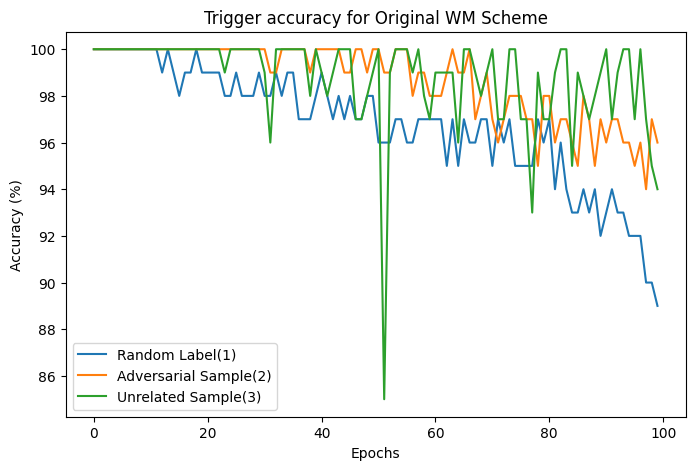

In [15]:
plt.figure(figsize=(8, 5))

plt.plot(range(len(metricsoriginalrand['trigger_acc'])), metricsoriginalrand['trigger_acc'], label='Random Label(1)')
plt.plot(range(len(metricsoriginaladv['trigger_acc'])), metricsoriginaladv['trigger_acc'], label='Adversarial Sample(2)')
plt.plot(range(len(metricsoriginalunrl['trigger_acc'])), metricsoriginalunrl['trigger_acc'], label='Unrelated Sample(3)')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Trigger accuracy for Original WM Scheme')
plt.legend()
plt.savefig('incre_trigger_acc_8020_ori_5.png')

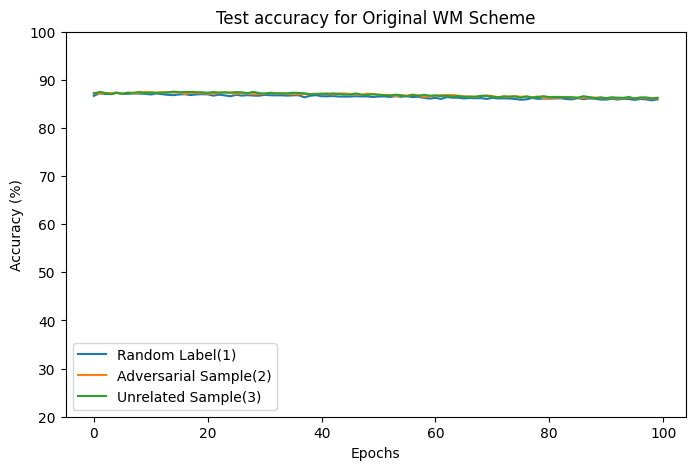

In [16]:
plt.figure(figsize=(8, 5))

plt.plot(range(len(metricsoriginalrand['val_acc'])), metricsoriginalrand['val_acc'], label='Random Label(1)')
plt.plot(range(len(metricsoriginaladv['val_acc'])), metricsoriginaladv['val_acc'], label='Adversarial Sample(2)')
plt.plot(range(len(metricsoriginalunrl['val_acc'])), metricsoriginalunrl['val_acc'], label='Unrelated Sample(3)')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test accuracy for Original WM Scheme')
plt.ylim([20, 100])

plt.legend()
plt.savefig('incre_test_acc_8020_ori_5.png')

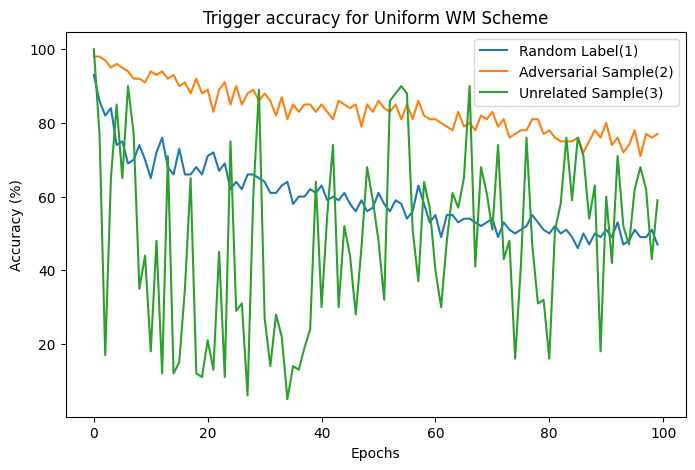

In [17]:
plt.figure(figsize=(8, 5))

plt.plot(range(len(metricsuniformrand['trigger_acc'])), metricsuniformrand['trigger_acc'], label='Random Label(1)')
plt.plot(range(len(metricsuniformadv['trigger_acc'])), metricsuniformadv['trigger_acc'], label='Adversarial Sample(2)')
plt.plot(range(len(metricsuniformunrl['trigger_acc'])), metricsuniformunrl['trigger_acc'], label='Unrelated Sample(3)')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Trigger accuracy for Uniform WM Scheme')
plt.legend()
plt.savefig('incre_trigger_acc_8020_uni_5.png')

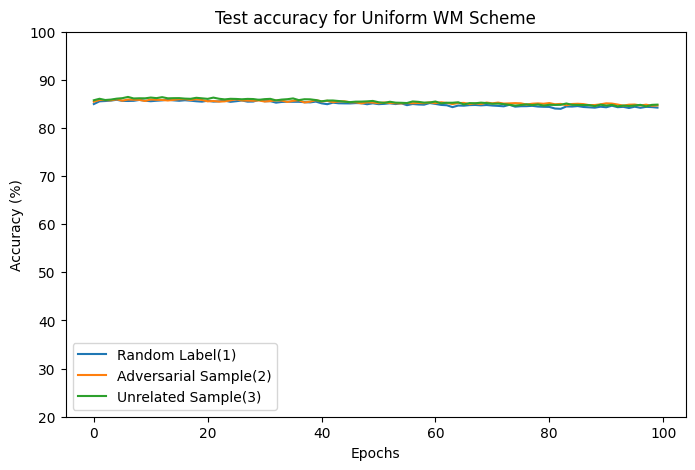

In [18]:
plt.figure(figsize=(8, 5))

plt.plot(range(len(metricsuniformrand['val_acc'])), metricsuniformrand['val_acc'], label='Random Label(1)')
plt.plot(range(len(metricsuniformadv['val_acc'])), metricsuniformadv['val_acc'], label='Adversarial Sample(2)')
plt.plot(range(len(metricsuniformunrl['val_acc'])), metricsuniformunrl['val_acc'], label='Unrelated Sample(3)')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test accuracy for Uniform WM Scheme')
plt.ylim([20, 100])

plt.legend()
plt.savefig('incre_test_acc_8020_uni_5.png')

In [19]:
netcertifiedrand = ResNet18()
netcertifiedrand.load_state_dict(torch.load('./models/wm_cifar10_certify_random_8020_rand.pth')['model_state_dict'])
netcertifiedadv = ResNet18()
netcertifiedadv.load_state_dict(torch.load('./models/wm_cifar10_certify_random_8020_adv.pth')['model_state_dict'])
netcertifiedunrl = ResNet18()
# netcertifiedunrl.load_state_dict(torch.load('./models/wm_cifar10_certify_random_8020_unrl.pth')['model_state_dict'])
netcertifiedunrl.load_state_dict(torch.load('./models/wm_cifar10_certify_random_8020.pth')['model_state_dict'])

<All keys matched successfully>

In [20]:
logcmt = f"incre_train_certified_8020"

optimizercertifiedrand = torch.optim.SGD(lr=0.001, params=netcertifiedrand.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainercertifiedrand = Trainer(netcertifiedrand, criterion, optimizercertifiedrand, incloader)
evaluatorcertifiedrand = Evaluator(netcertifiedrand, criterion)

metricscertifiedrand = train(trainercertifiedrand, evaluatorcertifiedrand, testloader, savename='inccheckpoints/incre_train_cert_8020_rand', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

Start Training...


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:05<00:00,  6.52it/s]


Epoch 0 | Time 8s| Train Loss 0.4807 | Train Acc 88.33| Val Loss 0.499 | Val Acc 88.23| Trigger Loss 0.007 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:05<00:00,  6.52it/s]


Epoch 1 | Time 20s| Train Loss 0.4367 | Train Acc 89.09| Val Loss 0.489 | Val Acc 88.21| Trigger Loss 0.009 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.68it/s]


Epoch 2 | Time 29s| Train Loss 0.3868 | Train Acc 89.78| Val Loss 0.481 | Val Acc 88.29| Trigger Loss 0.010 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 3 | Time 39s| Train Loss 0.3724 | Train Acc 89.94| Val Loss 0.475 | Val Acc 88.19| Trigger Loss 0.013 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.06it/s]


Epoch 4 | Time 49s| Train Loss 0.3503 | Train Acc 90.36| Val Loss 0.466 | Val Acc 88.25| Trigger Loss 0.016 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.46it/s]


Epoch 5 | Time 58s| Train Loss 0.3366 | Train Acc 90.57| Val Loss 0.460 | Val Acc 88.23| Trigger Loss 0.022 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.64it/s]


Epoch 6 | Time 68s| Train Loss 0.3162 | Train Acc 90.88| Val Loss 0.456 | Val Acc 88.33| Trigger Loss 0.023 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 7 | Time 78s| Train Loss 0.2938 | Train Acc 91.07| Val Loss 0.453 | Val Acc 88.27| Trigger Loss 0.030 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.00it/s]


Epoch 8 | Time 87s| Train Loss 0.2815 | Train Acc 91.41| Val Loss 0.450 | Val Acc 88.18| Trigger Loss 0.032 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.44it/s]


Epoch 9 | Time 97s| Train Loss 0.2737 | Train Acc 91.41| Val Loss 0.447 | Val Acc 88.21| Trigger Loss 0.037 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.63it/s]


Epoch 10 | Time 106s| Train Loss 0.2621 | Train Acc 91.86| Val Loss 0.442 | Val Acc 88.10| Trigger Loss 0.040 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 11 | Time 116s| Train Loss 0.2637 | Train Acc 92.09| Val Loss 0.441 | Val Acc 88.20| Trigger Loss 0.039 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.10it/s]


Epoch 12 | Time 125s| Train Loss 0.2486 | Train Acc 92.22| Val Loss 0.439 | Val Acc 88.20| Trigger Loss 0.048 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.24it/s]


Epoch 13 | Time 135s| Train Loss 0.2289 | Train Acc 92.62| Val Loss 0.437 | Val Acc 88.16| Trigger Loss 0.054 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 14 | Time 145s| Train Loss 0.2270 | Train Acc 92.72| Val Loss 0.435 | Val Acc 88.27| Trigger Loss 0.048 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.79it/s]


Epoch 15 | Time 155s| Train Loss 0.2252 | Train Acc 92.92| Val Loss 0.435 | Val Acc 88.22| Trigger Loss 0.053 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.47it/s]


Epoch 16 | Time 164s| Train Loss 0.2233 | Train Acc 92.73| Val Loss 0.433 | Val Acc 88.25| Trigger Loss 0.059 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.61it/s]


Epoch 17 | Time 173s| Train Loss 0.2144 | Train Acc 93.12| Val Loss 0.432 | Val Acc 88.21| Trigger Loss 0.063 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 18 | Time 183s| Train Loss 0.2035 | Train Acc 93.47| Val Loss 0.431 | Val Acc 88.22| Trigger Loss 0.064 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.10it/s]


Epoch 19 | Time 192s| Train Loss 0.2000 | Train Acc 93.13| Val Loss 0.430 | Val Acc 88.28| Trigger Loss 0.072 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.20it/s]


Epoch 20 | Time 201s| Train Loss 0.1992 | Train Acc 93.34| Val Loss 0.432 | Val Acc 88.11| Trigger Loss 0.077 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 21 | Time 211s| Train Loss 0.1875 | Train Acc 94.00| Val Loss 0.432 | Val Acc 88.14| Trigger Loss 0.073 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.05it/s]


Epoch 22 | Time 220s| Train Loss 0.1848 | Train Acc 94.29| Val Loss 0.431 | Val Acc 88.10| Trigger Loss 0.081 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:05<00:00,  6.52it/s]


Epoch 23 | Time 229s| Train Loss 0.1811 | Train Acc 94.02| Val Loss 0.432 | Val Acc 88.29| Trigger Loss 0.082 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.45it/s]


Epoch 24 | Time 239s| Train Loss 0.1757 | Train Acc 94.15| Val Loss 0.432 | Val Acc 88.20| Trigger Loss 0.082 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.58it/s]


Epoch 25 | Time 249s| Train Loss 0.1755 | Train Acc 94.11| Val Loss 0.430 | Val Acc 88.26| Trigger Loss 0.089 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:05<00:00,  6.51it/s]


Epoch 26 | Time 258s| Train Loss 0.1713 | Train Acc 94.41| Val Loss 0.431 | Val Acc 88.21| Trigger Loss 0.090 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.65it/s]


Epoch 27 | Time 268s| Train Loss 0.1670 | Train Acc 94.35| Val Loss 0.433 | Val Acc 88.26| Trigger Loss 0.089 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 28 | Time 278s| Train Loss 0.1587 | Train Acc 94.52| Val Loss 0.432 | Val Acc 88.26| Trigger Loss 0.082 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.15it/s]


Epoch 29 | Time 287s| Train Loss 0.1553 | Train Acc 94.85| Val Loss 0.434 | Val Acc 88.18| Trigger Loss 0.089 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.47it/s]


Epoch 30 | Time 296s| Train Loss 0.1588 | Train Acc 94.69| Val Loss 0.432 | Val Acc 88.23| Trigger Loss 0.087 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.61it/s]


Epoch 31 | Time 305s| Train Loss 0.1520 | Train Acc 94.78| Val Loss 0.434 | Val Acc 88.24| Trigger Loss 0.088 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 32 | Time 316s| Train Loss 0.1561 | Train Acc 94.73| Val Loss 0.436 | Val Acc 88.30| Trigger Loss 0.090 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.31it/s]


Epoch 33 | Time 325s| Train Loss 0.1492 | Train Acc 94.95| Val Loss 0.436 | Val Acc 88.17| Trigger Loss 0.085 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.78it/s]


Epoch 34 | Time 334s| Train Loss 0.1427 | Train Acc 95.29| Val Loss 0.436 | Val Acc 88.16| Trigger Loss 0.087 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 35 | Time 344s| Train Loss 0.1425 | Train Acc 95.39| Val Loss 0.437 | Val Acc 88.12| Trigger Loss 0.085 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.01it/s]


Epoch 36 | Time 354s| Train Loss 0.1324 | Train Acc 95.63| Val Loss 0.439 | Val Acc 88.26| Trigger Loss 0.088 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.46it/s]


Epoch 37 | Time 363s| Train Loss 0.1348 | Train Acc 95.53| Val Loss 0.437 | Val Acc 88.29| Trigger Loss 0.089 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.67it/s]


Epoch 38 | Time 372s| Train Loss 0.1326 | Train Acc 95.85| Val Loss 0.439 | Val Acc 88.20| Trigger Loss 0.094 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 39 | Time 382s| Train Loss 0.1259 | Train Acc 95.58| Val Loss 0.440 | Val Acc 88.26| Trigger Loss 0.093 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.89it/s]


Epoch 40 | Time 392s| Train Loss 0.1247 | Train Acc 95.89| Val Loss 0.442 | Val Acc 88.15| Trigger Loss 0.091 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 41 | Time 401s| Train Loss 0.1172 | Train Acc 95.98| Val Loss 0.443 | Val Acc 88.02| Trigger Loss 0.096 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.59it/s]


Epoch 42 | Time 410s| Train Loss 0.1170 | Train Acc 96.19| Val Loss 0.443 | Val Acc 88.07| Trigger Loss 0.090 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 43 | Time 420s| Train Loss 0.1175 | Train Acc 96.14| Val Loss 0.444 | Val Acc 88.04| Trigger Loss 0.099 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.11it/s]


Epoch 44 | Time 430s| Train Loss 0.1149 | Train Acc 96.22| Val Loss 0.444 | Val Acc 87.99| Trigger Loss 0.098 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.18it/s]


Epoch 45 | Time 439s| Train Loss 0.1140 | Train Acc 96.45| Val Loss 0.446 | Val Acc 88.06| Trigger Loss 0.096 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.50it/s]


Epoch 46 | Time 449s| Train Loss 0.1092 | Train Acc 96.22| Val Loss 0.447 | Val Acc 88.12| Trigger Loss 0.088 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 47 | Time 459s| Train Loss 0.1039 | Train Acc 96.72| Val Loss 0.448 | Val Acc 88.12| Trigger Loss 0.089 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.86it/s]


Epoch 48 | Time 469s| Train Loss 0.1071 | Train Acc 96.52| Val Loss 0.448 | Val Acc 88.17| Trigger Loss 0.094 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.18it/s]


Epoch 49 | Time 478s| Train Loss 0.1005 | Train Acc 96.82| Val Loss 0.451 | Val Acc 88.01| Trigger Loss 0.091 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.49it/s]


Epoch 50 | Time 489s| Train Loss 0.0993 | Train Acc 96.81| Val Loss 0.451 | Val Acc 88.05| Trigger Loss 0.099 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 51 | Time 499s| Train Loss 0.0927 | Train Acc 97.04| Val Loss 0.452 | Val Acc 88.08| Trigger Loss 0.088 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.04it/s]


Epoch 52 | Time 508s| Train Loss 0.0921 | Train Acc 97.09| Val Loss 0.455 | Val Acc 88.03| Trigger Loss 0.095 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.99it/s]


Epoch 53 | Time 518s| Train Loss 0.0937 | Train Acc 97.02| Val Loss 0.453 | Val Acc 87.94| Trigger Loss 0.094 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 54 | Time 528s| Train Loss 0.0923 | Train Acc 96.97| Val Loss 0.458 | Val Acc 87.97| Trigger Loss 0.094 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.54it/s]


Epoch 55 | Time 538s| Train Loss 0.0923 | Train Acc 96.94| Val Loss 0.458 | Val Acc 88.10| Trigger Loss 0.098 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.18it/s]


Epoch 56 | Time 548s| Train Loss 0.0894 | Train Acc 97.24| Val Loss 0.459 | Val Acc 87.96| Trigger Loss 0.098 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.74it/s]


Epoch 57 | Time 557s| Train Loss 0.0851 | Train Acc 97.27| Val Loss 0.459 | Val Acc 87.89| Trigger Loss 0.102 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 58 | Time 567s| Train Loss 0.0853 | Train Acc 97.10| Val Loss 0.461 | Val Acc 87.86| Trigger Loss 0.098 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.61it/s]


Epoch 59 | Time 577s| Train Loss 0.0859 | Train Acc 97.34| Val Loss 0.461 | Val Acc 87.93| Trigger Loss 0.104 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 60 | Time 586s| Train Loss 0.0821 | Train Acc 97.41| Val Loss 0.463 | Val Acc 87.79| Trigger Loss 0.097 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.65it/s]


Epoch 61 | Time 596s| Train Loss 0.0830 | Train Acc 97.53| Val Loss 0.464 | Val Acc 87.95| Trigger Loss 0.103 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 62 | Time 606s| Train Loss 0.0804 | Train Acc 97.37| Val Loss 0.466 | Val Acc 87.85| Trigger Loss 0.102 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.75it/s]


Epoch 63 | Time 616s| Train Loss 0.0754 | Train Acc 97.61| Val Loss 0.467 | Val Acc 87.90| Trigger Loss 0.106 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.19it/s]


Epoch 64 | Time 625s| Train Loss 0.0716 | Train Acc 97.90| Val Loss 0.468 | Val Acc 87.93| Trigger Loss 0.110 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.61it/s]


Epoch 65 | Time 635s| Train Loss 0.0762 | Train Acc 97.75| Val Loss 0.471 | Val Acc 87.86| Trigger Loss 0.106 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 66 | Time 645s| Train Loss 0.0746 | Train Acc 97.56| Val Loss 0.471 | Val Acc 87.86| Trigger Loss 0.110 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.86it/s]


Epoch 67 | Time 654s| Train Loss 0.0726 | Train Acc 97.93| Val Loss 0.473 | Val Acc 87.90| Trigger Loss 0.117 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.19it/s]


Epoch 68 | Time 664s| Train Loss 0.0714 | Train Acc 97.93| Val Loss 0.477 | Val Acc 87.92| Trigger Loss 0.107 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.61it/s]


Epoch 69 | Time 673s| Train Loss 0.0650 | Train Acc 98.09| Val Loss 0.475 | Val Acc 87.84| Trigger Loss 0.114 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 70 | Time 683s| Train Loss 0.0687 | Train Acc 97.86| Val Loss 0.476 | Val Acc 87.93| Trigger Loss 0.125 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.85it/s]


Epoch 71 | Time 693s| Train Loss 0.0680 | Train Acc 97.87| Val Loss 0.475 | Val Acc 87.99| Trigger Loss 0.121 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 72 | Time 702s| Train Loss 0.0639 | Train Acc 98.16| Val Loss 0.478 | Val Acc 87.98| Trigger Loss 0.121 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.63it/s]


Epoch 73 | Time 711s| Train Loss 0.0621 | Train Acc 98.28| Val Loss 0.478 | Val Acc 87.87| Trigger Loss 0.124 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 74 | Time 721s| Train Loss 0.0613 | Train Acc 98.30| Val Loss 0.482 | Val Acc 87.88| Trigger Loss 0.129 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.84it/s]


Epoch 75 | Time 731s| Train Loss 0.0611 | Train Acc 98.29| Val Loss 0.482 | Val Acc 87.93| Trigger Loss 0.130 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.18it/s]


Epoch 76 | Time 740s| Train Loss 0.0636 | Train Acc 98.09| Val Loss 0.482 | Val Acc 88.00| Trigger Loss 0.136 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.66it/s]


Epoch 77 | Time 749s| Train Loss 0.0597 | Train Acc 98.31| Val Loss 0.484 | Val Acc 87.98| Trigger Loss 0.137 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 78 | Time 759s| Train Loss 0.0573 | Train Acc 98.48| Val Loss 0.486 | Val Acc 87.94| Trigger Loss 0.137 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.89it/s]


Epoch 79 | Time 769s| Train Loss 0.0558 | Train Acc 98.58| Val Loss 0.485 | Val Acc 87.91| Trigger Loss 0.136 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 80 | Time 778s| Train Loss 0.0558 | Train Acc 98.52| Val Loss 0.483 | Val Acc 87.81| Trigger Loss 0.138 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.65it/s]


Epoch 81 | Time 787s| Train Loss 0.0547 | Train Acc 98.45| Val Loss 0.486 | Val Acc 87.75| Trigger Loss 0.149 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 82 | Time 798s| Train Loss 0.0542 | Train Acc 98.51| Val Loss 0.488 | Val Acc 87.82| Trigger Loss 0.152 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.94it/s]


Epoch 83 | Time 807s| Train Loss 0.0525 | Train Acc 98.57| Val Loss 0.489 | Val Acc 87.81| Trigger Loss 0.151 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 84 | Time 817s| Train Loss 0.0531 | Train Acc 98.55| Val Loss 0.489 | Val Acc 87.77| Trigger Loss 0.146 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.62it/s]


Epoch 85 | Time 826s| Train Loss 0.0519 | Train Acc 98.49| Val Loss 0.491 | Val Acc 87.85| Trigger Loss 0.145 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 86 | Time 837s| Train Loss 0.0521 | Train Acc 98.47| Val Loss 0.493 | Val Acc 87.84| Trigger Loss 0.155 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.94it/s]


Epoch 87 | Time 846s| Train Loss 0.0526 | Train Acc 98.46| Val Loss 0.496 | Val Acc 87.84| Trigger Loss 0.147 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.24it/s]


Epoch 88 | Time 856s| Train Loss 0.0486 | Train Acc 98.72| Val Loss 0.495 | Val Acc 87.90| Trigger Loss 0.146 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.57it/s]


Epoch 89 | Time 865s| Train Loss 0.0457 | Train Acc 98.90| Val Loss 0.496 | Val Acc 87.93| Trigger Loss 0.151 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 90 | Time 876s| Train Loss 0.0490 | Train Acc 98.62| Val Loss 0.496 | Val Acc 87.92| Trigger Loss 0.146 | Trigger Acc 92.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.02it/s]


Epoch 91 | Time 885s| Train Loss 0.0448 | Train Acc 98.82| Val Loss 0.496 | Val Acc 87.85| Trigger Loss 0.150 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.07it/s]


Epoch 92 | Time 895s| Train Loss 0.0462 | Train Acc 98.75| Val Loss 0.498 | Val Acc 87.91| Trigger Loss 0.160 | Trigger Acc 92.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.39it/s]


Epoch 93 | Time 905s| Train Loss 0.0478 | Train Acc 98.66| Val Loss 0.497 | Val Acc 87.88| Trigger Loss 0.161 | Trigger Acc 91.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.46it/s]


Epoch 94 | Time 915s| Train Loss 0.0469 | Train Acc 98.77| Val Loss 0.503 | Val Acc 87.81| Trigger Loss 0.155 | Trigger Acc 92.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 95 | Time 924s| Train Loss 0.0399 | Train Acc 99.14| Val Loss 0.500 | Val Acc 87.72| Trigger Loss 0.156 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.89it/s]


Epoch 96 | Time 934s| Train Loss 0.0434 | Train Acc 98.95| Val Loss 0.504 | Val Acc 87.80| Trigger Loss 0.158 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 97 | Time 944s| Train Loss 0.0421 | Train Acc 98.97| Val Loss 0.501 | Val Acc 87.76| Trigger Loss 0.150 | Trigger Acc 92.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.64it/s]


Epoch 98 | Time 954s| Train Loss 0.0406 | Train Acc 98.96| Val Loss 0.503 | Val Acc 87.72| Trigger Loss 0.155 | Trigger Acc 92.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.28it/s]


Epoch 99 | Time 963s| Train Loss 0.0389 | Train Acc 99.00| Val Loss 0.502 | Val Acc 87.80| Trigger Loss 0.159 | Trigger Acc 92.00


In [21]:
logcmt = f"incre_train_certified_8020"

optimizercertifiedadv = torch.optim.SGD(lr=0.001, params=netcertifiedadv.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainercertifiedadv = Trainer(netcertifiedadv, criterion, optimizercertifiedadv, incloader)
evaluatorcertifiedadv = Evaluator(netcertifiedadv, criterion)

metricscertifiedadv = train(trainercertifiedadv, evaluatorcertifiedadv, testloader, savename='inccheckpoints/incre_train_cert_8020_adv', logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader, epochs=100)

Start Training...


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.71it/s]


Epoch 0 | Time 9s| Train Loss 0.4807 | Train Acc 88.66| Val Loss 0.479 | Val Acc 88.64| Trigger Loss 0.016 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.66it/s]


Epoch 1 | Time 21s| Train Loss 0.4429 | Train Acc 89.03| Val Loss 0.469 | Val Acc 88.52| Trigger Loss 0.019 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 2 | Time 31s| Train Loss 0.4038 | Train Acc 89.52| Val Loss 0.461 | Val Acc 88.81| Trigger Loss 0.024 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.60it/s]


Epoch 3 | Time 42s| Train Loss 0.3739 | Train Acc 90.00| Val Loss 0.456 | Val Acc 88.67| Trigger Loss 0.029 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.12it/s]


Epoch 4 | Time 51s| Train Loss 0.3473 | Train Acc 90.35| Val Loss 0.450 | Val Acc 88.65| Trigger Loss 0.031 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.19it/s]


Epoch 5 | Time 61s| Train Loss 0.3359 | Train Acc 90.48| Val Loss 0.444 | Val Acc 88.49| Trigger Loss 0.035 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.59it/s]


Epoch 6 | Time 71s| Train Loss 0.3126 | Train Acc 90.58| Val Loss 0.436 | Val Acc 88.53| Trigger Loss 0.037 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 7 | Time 81s| Train Loss 0.2982 | Train Acc 91.27| Val Loss 0.436 | Val Acc 88.49| Trigger Loss 0.038 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.84it/s]


Epoch 8 | Time 91s| Train Loss 0.2804 | Train Acc 91.22| Val Loss 0.433 | Val Acc 88.58| Trigger Loss 0.041 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.28it/s]


Epoch 9 | Time 100s| Train Loss 0.2803 | Train Acc 91.28| Val Loss 0.429 | Val Acc 88.64| Trigger Loss 0.044 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.66it/s]


Epoch 10 | Time 110s| Train Loss 0.2694 | Train Acc 91.88| Val Loss 0.424 | Val Acc 88.55| Trigger Loss 0.049 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 11 | Time 120s| Train Loss 0.2581 | Train Acc 91.73| Val Loss 0.425 | Val Acc 88.56| Trigger Loss 0.049 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.62it/s]


Epoch 12 | Time 130s| Train Loss 0.2412 | Train Acc 92.29| Val Loss 0.419 | Val Acc 88.74| Trigger Loss 0.053 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.18it/s]


Epoch 13 | Time 140s| Train Loss 0.2367 | Train Acc 92.27| Val Loss 0.419 | Val Acc 88.66| Trigger Loss 0.057 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.11it/s]


Epoch 14 | Time 149s| Train Loss 0.2342 | Train Acc 92.42| Val Loss 0.417 | Val Acc 88.64| Trigger Loss 0.064 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.51it/s]


Epoch 15 | Time 159s| Train Loss 0.2223 | Train Acc 92.97| Val Loss 0.415 | Val Acc 88.65| Trigger Loss 0.064 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 16 | Time 170s| Train Loss 0.2139 | Train Acc 92.99| Val Loss 0.417 | Val Acc 88.71| Trigger Loss 0.064 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.84it/s]


Epoch 17 | Time 180s| Train Loss 0.2090 | Train Acc 93.00| Val Loss 0.415 | Val Acc 88.67| Trigger Loss 0.062 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.19it/s]


Epoch 18 | Time 189s| Train Loss 0.1986 | Train Acc 93.29| Val Loss 0.417 | Val Acc 88.71| Trigger Loss 0.069 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.61it/s]


Epoch 19 | Time 199s| Train Loss 0.1940 | Train Acc 93.44| Val Loss 0.416 | Val Acc 88.66| Trigger Loss 0.065 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 20 | Time 209s| Train Loss 0.1914 | Train Acc 93.46| Val Loss 0.417 | Val Acc 88.66| Trigger Loss 0.062 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.59it/s]


Epoch 21 | Time 219s| Train Loss 0.1952 | Train Acc 93.62| Val Loss 0.416 | Val Acc 88.63| Trigger Loss 0.065 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.07it/s]


Epoch 22 | Time 229s| Train Loss 0.1806 | Train Acc 93.91| Val Loss 0.415 | Val Acc 88.63| Trigger Loss 0.069 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.18it/s]


Epoch 23 | Time 239s| Train Loss 0.1797 | Train Acc 93.91| Val Loss 0.416 | Val Acc 88.75| Trigger Loss 0.070 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.56it/s]


Epoch 24 | Time 248s| Train Loss 0.1732 | Train Acc 94.18| Val Loss 0.414 | Val Acc 88.70| Trigger Loss 0.077 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 25 | Time 259s| Train Loss 0.1690 | Train Acc 94.29| Val Loss 0.414 | Val Acc 88.72| Trigger Loss 0.078 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.89it/s]


Epoch 26 | Time 268s| Train Loss 0.1692 | Train Acc 94.33| Val Loss 0.415 | Val Acc 88.70| Trigger Loss 0.075 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.19it/s]


Epoch 27 | Time 278s| Train Loss 0.1602 | Train Acc 94.50| Val Loss 0.415 | Val Acc 88.66| Trigger Loss 0.077 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.58it/s]


Epoch 28 | Time 287s| Train Loss 0.1662 | Train Acc 94.16| Val Loss 0.416 | Val Acc 88.69| Trigger Loss 0.079 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 29 | Time 297s| Train Loss 0.1545 | Train Acc 94.67| Val Loss 0.419 | Val Acc 88.66| Trigger Loss 0.075 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.82it/s]


Epoch 30 | Time 307s| Train Loss 0.1508 | Train Acc 94.64| Val Loss 0.418 | Val Acc 88.66| Trigger Loss 0.082 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.15it/s]


Epoch 31 | Time 316s| Train Loss 0.1551 | Train Acc 94.56| Val Loss 0.421 | Val Acc 88.60| Trigger Loss 0.084 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.65it/s]


Epoch 32 | Time 326s| Train Loss 0.1426 | Train Acc 95.38| Val Loss 0.422 | Val Acc 88.62| Trigger Loss 0.085 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 33 | Time 336s| Train Loss 0.1428 | Train Acc 95.27| Val Loss 0.424 | Val Acc 88.69| Trigger Loss 0.083 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.94it/s]


Epoch 34 | Time 345s| Train Loss 0.1408 | Train Acc 95.26| Val Loss 0.424 | Val Acc 88.50| Trigger Loss 0.084 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 35 | Time 355s| Train Loss 0.1303 | Train Acc 95.60| Val Loss 0.426 | Val Acc 88.66| Trigger Loss 0.085 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.59it/s]


Epoch 36 | Time 364s| Train Loss 0.1281 | Train Acc 95.93| Val Loss 0.425 | Val Acc 88.54| Trigger Loss 0.088 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 37 | Time 374s| Train Loss 0.1311 | Train Acc 95.55| Val Loss 0.428 | Val Acc 88.45| Trigger Loss 0.092 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.84it/s]


Epoch 38 | Time 384s| Train Loss 0.1318 | Train Acc 95.70| Val Loss 0.428 | Val Acc 88.32| Trigger Loss 0.094 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 39 | Time 393s| Train Loss 0.1253 | Train Acc 95.95| Val Loss 0.428 | Val Acc 88.41| Trigger Loss 0.094 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.60it/s]


Epoch 40 | Time 402s| Train Loss 0.1202 | Train Acc 96.06| Val Loss 0.428 | Val Acc 88.36| Trigger Loss 0.101 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 41 | Time 413s| Train Loss 0.1199 | Train Acc 96.00| Val Loss 0.429 | Val Acc 88.43| Trigger Loss 0.101 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.86it/s]


Epoch 42 | Time 422s| Train Loss 0.1208 | Train Acc 95.99| Val Loss 0.431 | Val Acc 88.31| Trigger Loss 0.102 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.20it/s]


Epoch 43 | Time 431s| Train Loss 0.1122 | Train Acc 96.41| Val Loss 0.434 | Val Acc 88.27| Trigger Loss 0.104 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.57it/s]


Epoch 44 | Time 441s| Train Loss 0.1159 | Train Acc 96.25| Val Loss 0.433 | Val Acc 88.25| Trigger Loss 0.101 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 45 | Time 451s| Train Loss 0.1100 | Train Acc 96.28| Val Loss 0.435 | Val Acc 88.28| Trigger Loss 0.104 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.90it/s]


Epoch 46 | Time 461s| Train Loss 0.1074 | Train Acc 96.58| Val Loss 0.434 | Val Acc 88.51| Trigger Loss 0.111 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 47 | Time 470s| Train Loss 0.1045 | Train Acc 96.60| Val Loss 0.433 | Val Acc 88.42| Trigger Loss 0.105 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.59it/s]


Epoch 48 | Time 480s| Train Loss 0.1056 | Train Acc 96.70| Val Loss 0.436 | Val Acc 88.32| Trigger Loss 0.106 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 49 | Time 490s| Train Loss 0.1026 | Train Acc 96.64| Val Loss 0.435 | Val Acc 88.37| Trigger Loss 0.104 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.88it/s]


Epoch 50 | Time 500s| Train Loss 0.0972 | Train Acc 96.90| Val Loss 0.436 | Val Acc 88.34| Trigger Loss 0.105 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 51 | Time 509s| Train Loss 0.0951 | Train Acc 97.01| Val Loss 0.438 | Val Acc 88.24| Trigger Loss 0.113 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.57it/s]


Epoch 52 | Time 519s| Train Loss 0.0966 | Train Acc 96.77| Val Loss 0.439 | Val Acc 88.39| Trigger Loss 0.108 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 53 | Time 529s| Train Loss 0.0950 | Train Acc 97.03| Val Loss 0.442 | Val Acc 88.26| Trigger Loss 0.105 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:05<00:00,  6.62it/s]


Epoch 54 | Time 538s| Train Loss 0.0903 | Train Acc 97.20| Val Loss 0.443 | Val Acc 88.25| Trigger Loss 0.109 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.60it/s]


Epoch 55 | Time 548s| Train Loss 0.0877 | Train Acc 97.11| Val Loss 0.445 | Val Acc 88.44| Trigger Loss 0.107 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 56 | Time 558s| Train Loss 0.0848 | Train Acc 97.27| Val Loss 0.445 | Val Acc 88.38| Trigger Loss 0.109 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.88it/s]


Epoch 57 | Time 568s| Train Loss 0.0866 | Train Acc 97.42| Val Loss 0.445 | Val Acc 88.31| Trigger Loss 0.117 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 58 | Time 577s| Train Loss 0.0835 | Train Acc 97.49| Val Loss 0.449 | Val Acc 88.39| Trigger Loss 0.114 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.56it/s]


Epoch 59 | Time 587s| Train Loss 0.0833 | Train Acc 97.28| Val Loss 0.448 | Val Acc 88.29| Trigger Loss 0.119 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 60 | Time 597s| Train Loss 0.0816 | Train Acc 97.37| Val Loss 0.447 | Val Acc 88.36| Trigger Loss 0.114 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.94it/s]


Epoch 61 | Time 607s| Train Loss 0.0849 | Train Acc 97.34| Val Loss 0.451 | Val Acc 88.29| Trigger Loss 0.115 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.27it/s]


Epoch 62 | Time 616s| Train Loss 0.0771 | Train Acc 97.69| Val Loss 0.452 | Val Acc 88.32| Trigger Loss 0.116 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.50it/s]


Epoch 63 | Time 626s| Train Loss 0.0797 | Train Acc 97.49| Val Loss 0.455 | Val Acc 88.38| Trigger Loss 0.118 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 64 | Time 636s| Train Loss 0.0741 | Train Acc 97.90| Val Loss 0.455 | Val Acc 88.40| Trigger Loss 0.113 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.91it/s]


Epoch 65 | Time 646s| Train Loss 0.0756 | Train Acc 97.71| Val Loss 0.458 | Val Acc 88.38| Trigger Loss 0.119 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.13it/s]


Epoch 66 | Time 655s| Train Loss 0.0713 | Train Acc 97.94| Val Loss 0.456 | Val Acc 88.33| Trigger Loss 0.124 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.45it/s]


Epoch 67 | Time 666s| Train Loss 0.0751 | Train Acc 97.87| Val Loss 0.458 | Val Acc 88.13| Trigger Loss 0.119 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 68 | Time 676s| Train Loss 0.0731 | Train Acc 97.91| Val Loss 0.460 | Val Acc 88.16| Trigger Loss 0.126 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.03it/s]


Epoch 69 | Time 685s| Train Loss 0.0723 | Train Acc 97.75| Val Loss 0.460 | Val Acc 88.05| Trigger Loss 0.127 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.05it/s]


Epoch 70 | Time 695s| Train Loss 0.0652 | Train Acc 98.24| Val Loss 0.458 | Val Acc 88.12| Trigger Loss 0.133 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 71 | Time 705s| Train Loss 0.0702 | Train Acc 98.05| Val Loss 0.462 | Val Acc 88.24| Trigger Loss 0.135 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 72 | Time 716s| Train Loss 0.0662 | Train Acc 97.88| Val Loss 0.464 | Val Acc 88.27| Trigger Loss 0.127 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.15it/s]


Epoch 73 | Time 725s| Train Loss 0.0676 | Train Acc 97.89| Val Loss 0.467 | Val Acc 88.16| Trigger Loss 0.131 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.96it/s]


Epoch 74 | Time 734s| Train Loss 0.0657 | Train Acc 97.91| Val Loss 0.466 | Val Acc 88.19| Trigger Loss 0.134 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 75 | Time 745s| Train Loss 0.0613 | Train Acc 98.12| Val Loss 0.468 | Val Acc 88.09| Trigger Loss 0.131 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.51it/s]


Epoch 76 | Time 755s| Train Loss 0.0599 | Train Acc 98.29| Val Loss 0.469 | Val Acc 88.11| Trigger Loss 0.131 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 77 | Time 764s| Train Loss 0.0601 | Train Acc 98.35| Val Loss 0.467 | Val Acc 88.05| Trigger Loss 0.131 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.85it/s]


Epoch 78 | Time 774s| Train Loss 0.0608 | Train Acc 98.26| Val Loss 0.469 | Val Acc 88.07| Trigger Loss 0.132 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 79 | Time 784s| Train Loss 0.0607 | Train Acc 98.24| Val Loss 0.469 | Val Acc 88.04| Trigger Loss 0.136 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.63it/s]


Epoch 80 | Time 794s| Train Loss 0.0568 | Train Acc 98.44| Val Loss 0.471 | Val Acc 88.01| Trigger Loss 0.134 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.31it/s]


Epoch 81 | Time 803s| Train Loss 0.0554 | Train Acc 98.60| Val Loss 0.473 | Val Acc 88.00| Trigger Loss 0.132 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.68it/s]


Epoch 82 | Time 812s| Train Loss 0.0560 | Train Acc 98.51| Val Loss 0.471 | Val Acc 88.05| Trigger Loss 0.132 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 83 | Time 822s| Train Loss 0.0549 | Train Acc 98.43| Val Loss 0.475 | Val Acc 88.02| Trigger Loss 0.132 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.83it/s]


Epoch 84 | Time 832s| Train Loss 0.0553 | Train Acc 98.66| Val Loss 0.472 | Val Acc 88.09| Trigger Loss 0.134 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 85 | Time 841s| Train Loss 0.0507 | Train Acc 98.73| Val Loss 0.475 | Val Acc 88.19| Trigger Loss 0.136 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.67it/s]


Epoch 86 | Time 851s| Train Loss 0.0527 | Train Acc 98.61| Val Loss 0.477 | Val Acc 87.94| Trigger Loss 0.137 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.39it/s]


Epoch 87 | Time 861s| Train Loss 0.0489 | Train Acc 98.74| Val Loss 0.478 | Val Acc 87.96| Trigger Loss 0.137 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.86it/s]


Epoch 88 | Time 870s| Train Loss 0.0457 | Train Acc 98.76| Val Loss 0.479 | Val Acc 88.06| Trigger Loss 0.145 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.17it/s]


Epoch 89 | Time 880s| Train Loss 0.0514 | Train Acc 98.45| Val Loss 0.478 | Val Acc 88.18| Trigger Loss 0.144 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.59it/s]


Epoch 90 | Time 889s| Train Loss 0.0447 | Train Acc 98.99| Val Loss 0.479 | Val Acc 88.05| Trigger Loss 0.149 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 91 | Time 899s| Train Loss 0.0468 | Train Acc 98.77| Val Loss 0.482 | Val Acc 88.11| Trigger Loss 0.147 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.88it/s]


Epoch 92 | Time 908s| Train Loss 0.0435 | Train Acc 99.04| Val Loss 0.484 | Val Acc 87.99| Trigger Loss 0.148 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.25it/s]


Epoch 93 | Time 918s| Train Loss 0.0472 | Train Acc 98.70| Val Loss 0.483 | Val Acc 88.06| Trigger Loss 0.146 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.59it/s]


Epoch 94 | Time 927s| Train Loss 0.0442 | Train Acc 98.84| Val Loss 0.481 | Val Acc 88.19| Trigger Loss 0.148 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 95 | Time 937s| Train Loss 0.0429 | Train Acc 98.98| Val Loss 0.487 | Val Acc 88.04| Trigger Loss 0.158 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.88it/s]


Epoch 96 | Time 947s| Train Loss 0.0456 | Train Acc 98.94| Val Loss 0.486 | Val Acc 88.06| Trigger Loss 0.158 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 97 | Time 956s| Train Loss 0.0441 | Train Acc 98.76| Val Loss 0.486 | Val Acc 88.09| Trigger Loss 0.157 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.60it/s]


Epoch 98 | Time 965s| Train Loss 0.0419 | Train Acc 99.03| Val Loss 0.488 | Val Acc 88.01| Trigger Loss 0.155 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 99 | Time 975s| Train Loss 0.0420 | Train Acc 98.96| Val Loss 0.491 | Val Acc 88.00| Trigger Loss 0.145 | Trigger Acc 96.00


In [22]:
logcmt = f"incre_train_certified_8020"

optimizercertifiedunrl = torch.optim.SGD(lr=0.001, params=netcertifiedunrl.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainercertifiedunrl = Trainer(netcertifiedunrl, criterion, optimizercertifiedunrl, incloader)
evaluatorcertifiedunrl = Evaluator(netcertifiedunrl, criterion)

metricscertifiedunrl = train(trainercertifiedunrl, evaluatorcertifiedunrl, testloader, savename='inccheckpoints/incre_train_cert_8020_unrl', logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader, epochs=100)

Start Training...


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.87it/s]


Epoch 0 | Time 9s| Train Loss 0.5441 | Train Acc 87.65| Val Loss 0.598 | Val Acc 87.87| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.84it/s]


Epoch 1 | Time 22s| Train Loss 0.4888 | Train Acc 88.20| Val Loss 0.569 | Val Acc 87.83| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.24it/s]


Epoch 2 | Time 31s| Train Loss 0.4287 | Train Acc 89.26| Val Loss 0.544 | Val Acc 87.97| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.62it/s]


Epoch 3 | Time 40s| Train Loss 0.4012 | Train Acc 89.54| Val Loss 0.531 | Val Acc 88.03| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 4 | Time 51s| Train Loss 0.3668 | Train Acc 89.95| Val Loss 0.520 | Val Acc 88.11| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.73it/s]


Epoch 5 | Time 61s| Train Loss 0.3495 | Train Acc 89.98| Val Loss 0.509 | Val Acc 88.00| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 6 | Time 70s| Train Loss 0.3375 | Train Acc 90.34| Val Loss 0.503 | Val Acc 88.00| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.90it/s]


Epoch 7 | Time 80s| Train Loss 0.3193 | Train Acc 90.47| Val Loss 0.492 | Val Acc 88.00| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.44it/s]


Epoch 8 | Time 90s| Train Loss 0.3080 | Train Acc 90.62| Val Loss 0.485 | Val Acc 88.02| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 9 | Time 101s| Train Loss 0.2895 | Train Acc 91.39| Val Loss 0.481 | Val Acc 88.00| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.90it/s]


Epoch 10 | Time 111s| Train Loss 0.2747 | Train Acc 91.35| Val Loss 0.479 | Val Acc 88.04| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.20it/s]


Epoch 11 | Time 120s| Train Loss 0.2567 | Train Acc 91.88| Val Loss 0.477 | Val Acc 88.00| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.63it/s]


Epoch 12 | Time 130s| Train Loss 0.2589 | Train Acc 91.67| Val Loss 0.473 | Val Acc 88.09| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 13 | Time 140s| Train Loss 0.2444 | Train Acc 91.85| Val Loss 0.469 | Val Acc 87.99| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.50it/s]


Epoch 14 | Time 151s| Train Loss 0.2316 | Train Acc 92.52| Val Loss 0.469 | Val Acc 88.07| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.00it/s]


Epoch 15 | Time 160s| Train Loss 0.2334 | Train Acc 92.55| Val Loss 0.468 | Val Acc 87.96| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 16 | Time 170s| Train Loss 0.2259 | Train Acc 92.49| Val Loss 0.467 | Val Acc 87.98| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.58it/s]


Epoch 17 | Time 180s| Train Loss 0.2245 | Train Acc 92.83| Val Loss 0.466 | Val Acc 87.99| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 18 | Time 190s| Train Loss 0.2127 | Train Acc 93.07| Val Loss 0.466 | Val Acc 87.89| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.83it/s]


Epoch 19 | Time 200s| Train Loss 0.2198 | Train Acc 92.98| Val Loss 0.467 | Val Acc 87.80| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.19it/s]


Epoch 20 | Time 209s| Train Loss 0.2071 | Train Acc 93.36| Val Loss 0.470 | Val Acc 87.64| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.72it/s]


Epoch 21 | Time 219s| Train Loss 0.1980 | Train Acc 93.71| Val Loss 0.466 | Val Acc 87.80| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 22 | Time 229s| Train Loss 0.1987 | Train Acc 93.69| Val Loss 0.467 | Val Acc 87.69| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 23 | Time 240s| Train Loss 0.1868 | Train Acc 93.77| Val Loss 0.467 | Val Acc 87.78| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.91it/s]


Epoch 24 | Time 250s| Train Loss 0.1871 | Train Acc 93.71| Val Loss 0.470 | Val Acc 87.72| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.20it/s]


Epoch 25 | Time 259s| Train Loss 0.1855 | Train Acc 93.80| Val Loss 0.468 | Val Acc 87.88| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.61it/s]


Epoch 26 | Time 269s| Train Loss 0.1740 | Train Acc 94.22| Val Loss 0.470 | Val Acc 87.76| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 27 | Time 279s| Train Loss 0.1714 | Train Acc 94.33| Val Loss 0.472 | Val Acc 87.72| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.88it/s]


Epoch 28 | Time 289s| Train Loss 0.1709 | Train Acc 94.51| Val Loss 0.470 | Val Acc 87.67| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.24it/s]


Epoch 29 | Time 298s| Train Loss 0.1685 | Train Acc 94.23| Val Loss 0.471 | Val Acc 87.73| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.64it/s]


Epoch 30 | Time 308s| Train Loss 0.1607 | Train Acc 94.84| Val Loss 0.472 | Val Acc 87.62| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 31 | Time 318s| Train Loss 0.1588 | Train Acc 94.92| Val Loss 0.472 | Val Acc 87.69| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.58it/s]


Epoch 32 | Time 329s| Train Loss 0.1603 | Train Acc 94.92| Val Loss 0.470 | Val Acc 87.79| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.09it/s]


Epoch 33 | Time 338s| Train Loss 0.1574 | Train Acc 94.67| Val Loss 0.475 | Val Acc 87.74| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.27it/s]


Epoch 34 | Time 348s| Train Loss 0.1499 | Train Acc 94.73| Val Loss 0.479 | Val Acc 87.58| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.62it/s]


Epoch 35 | Time 357s| Train Loss 0.1469 | Train Acc 95.20| Val Loss 0.476 | Val Acc 87.68| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 36 | Time 368s| Train Loss 0.1470 | Train Acc 95.21| Val Loss 0.478 | Val Acc 87.70| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.86it/s]


Epoch 37 | Time 378s| Train Loss 0.1376 | Train Acc 95.51| Val Loss 0.483 | Val Acc 87.66| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 38 | Time 387s| Train Loss 0.1350 | Train Acc 95.58| Val Loss 0.481 | Val Acc 87.59| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.64it/s]


Epoch 39 | Time 397s| Train Loss 0.1349 | Train Acc 95.42| Val Loss 0.484 | Val Acc 87.52| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 40 | Time 407s| Train Loss 0.1273 | Train Acc 95.96| Val Loss 0.487 | Val Acc 87.41| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.43it/s]


Epoch 41 | Time 418s| Train Loss 0.1248 | Train Acc 96.02| Val Loss 0.491 | Val Acc 87.35| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.95it/s]


Epoch 42 | Time 428s| Train Loss 0.1216 | Train Acc 95.70| Val Loss 0.493 | Val Acc 87.43| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.14it/s]


Epoch 43 | Time 437s| Train Loss 0.1211 | Train Acc 95.80| Val Loss 0.490 | Val Acc 87.32| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.60it/s]


Epoch 44 | Time 447s| Train Loss 0.1167 | Train Acc 96.22| Val Loss 0.493 | Val Acc 87.45| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 45 | Time 457s| Train Loss 0.1201 | Train Acc 95.83| Val Loss 0.498 | Val Acc 87.42| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.88it/s]


Epoch 46 | Time 467s| Train Loss 0.1228 | Train Acc 96.03| Val Loss 0.499 | Val Acc 87.45| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 47 | Time 476s| Train Loss 0.1066 | Train Acc 96.46| Val Loss 0.498 | Val Acc 87.49| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.63it/s]


Epoch 48 | Time 486s| Train Loss 0.1027 | Train Acc 96.52| Val Loss 0.504 | Val Acc 87.44| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 49 | Time 496s| Train Loss 0.1093 | Train Acc 96.27| Val Loss 0.504 | Val Acc 87.28| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.42it/s]


Epoch 50 | Time 507s| Train Loss 0.1069 | Train Acc 96.51| Val Loss 0.507 | Val Acc 87.34| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.93it/s]


Epoch 51 | Time 517s| Train Loss 0.1045 | Train Acc 96.54| Val Loss 0.508 | Val Acc 87.29| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 52 | Time 526s| Train Loss 0.1014 | Train Acc 96.67| Val Loss 0.514 | Val Acc 87.32| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.56it/s]


Epoch 53 | Time 536s| Train Loss 0.1024 | Train Acc 96.74| Val Loss 0.516 | Val Acc 87.28| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 54 | Time 546s| Train Loss 0.0965 | Train Acc 96.77| Val Loss 0.512 | Val Acc 87.29| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.89it/s]


Epoch 55 | Time 556s| Train Loss 0.0923 | Train Acc 96.96| Val Loss 0.514 | Val Acc 87.41| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 56 | Time 565s| Train Loss 0.0942 | Train Acc 96.97| Val Loss 0.520 | Val Acc 87.25| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.65it/s]


Epoch 57 | Time 575s| Train Loss 0.0938 | Train Acc 97.03| Val Loss 0.520 | Val Acc 87.21| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 58 | Time 585s| Train Loss 0.0899 | Train Acc 97.04| Val Loss 0.524 | Val Acc 87.27| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.51it/s]


Epoch 59 | Time 595s| Train Loss 0.0891 | Train Acc 97.01| Val Loss 0.524 | Val Acc 87.37| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.97it/s]


Epoch 60 | Time 605s| Train Loss 0.0855 | Train Acc 97.21| Val Loss 0.529 | Val Acc 87.28| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.25it/s]


Epoch 61 | Time 615s| Train Loss 0.0804 | Train Acc 97.58| Val Loss 0.531 | Val Acc 87.21| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.59it/s]


Epoch 62 | Time 624s| Train Loss 0.0863 | Train Acc 97.16| Val Loss 0.534 | Val Acc 87.25| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 63 | Time 635s| Train Loss 0.0769 | Train Acc 97.47| Val Loss 0.535 | Val Acc 87.23| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.88it/s]


Epoch 64 | Time 645s| Train Loss 0.0778 | Train Acc 97.68| Val Loss 0.535 | Val Acc 87.42| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.29it/s]


Epoch 65 | Time 654s| Train Loss 0.0763 | Train Acc 97.74| Val Loss 0.536 | Val Acc 87.35| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.64it/s]


Epoch 66 | Time 664s| Train Loss 0.0771 | Train Acc 97.60| Val Loss 0.536 | Val Acc 87.27| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 67 | Time 674s| Train Loss 0.0751 | Train Acc 97.73| Val Loss 0.538 | Val Acc 87.23| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.51it/s]


Epoch 68 | Time 684s| Train Loss 0.0734 | Train Acc 97.63| Val Loss 0.541 | Val Acc 87.35| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.90it/s]


Epoch 69 | Time 694s| Train Loss 0.0749 | Train Acc 97.56| Val Loss 0.545 | Val Acc 87.22| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.14it/s]


Epoch 70 | Time 704s| Train Loss 0.0713 | Train Acc 97.67| Val Loss 0.545 | Val Acc 87.14| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.60it/s]


Epoch 71 | Time 713s| Train Loss 0.0650 | Train Acc 98.02| Val Loss 0.547 | Val Acc 87.22| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 72 | Time 723s| Train Loss 0.0664 | Train Acc 97.98| Val Loss 0.546 | Val Acc 87.40| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.86it/s]


Epoch 73 | Time 733s| Train Loss 0.0648 | Train Acc 97.90| Val Loss 0.548 | Val Acc 87.41| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 74 | Time 743s| Train Loss 0.0590 | Train Acc 98.18| Val Loss 0.553 | Val Acc 87.35| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.68it/s]


Epoch 75 | Time 753s| Train Loss 0.0602 | Train Acc 98.10| Val Loss 0.553 | Val Acc 87.36| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 76 | Time 763s| Train Loss 0.0615 | Train Acc 98.20| Val Loss 0.559 | Val Acc 87.39| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 77 | Time 774s| Train Loss 0.0584 | Train Acc 98.18| Val Loss 0.556 | Val Acc 87.39| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.88it/s]


Epoch 78 | Time 784s| Train Loss 0.0561 | Train Acc 98.33| Val Loss 0.561 | Val Acc 87.27| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 79 | Time 793s| Train Loss 0.0577 | Train Acc 98.36| Val Loss 0.561 | Val Acc 87.29| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.62it/s]


Epoch 80 | Time 803s| Train Loss 0.0588 | Train Acc 98.19| Val Loss 0.559 | Val Acc 87.31| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 81 | Time 813s| Train Loss 0.0569 | Train Acc 98.19| Val Loss 0.562 | Val Acc 87.41| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.77it/s]


Epoch 82 | Time 823s| Train Loss 0.0581 | Train Acc 98.17| Val Loss 0.566 | Val Acc 87.48| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.12it/s]


Epoch 83 | Time 832s| Train Loss 0.0536 | Train Acc 98.32| Val Loss 0.568 | Val Acc 87.32| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.08it/s]


Epoch 84 | Time 842s| Train Loss 0.0551 | Train Acc 98.28| Val Loss 0.569 | Val Acc 87.23| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 85 | Time 852s| Train Loss 0.0519 | Train Acc 98.41| Val Loss 0.572 | Val Acc 87.21| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.87it/s]


Epoch 86 | Time 862s| Train Loss 0.0491 | Train Acc 98.66| Val Loss 0.576 | Val Acc 87.07| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.37it/s]


Epoch 87 | Time 872s| Train Loss 0.0462 | Train Acc 98.73| Val Loss 0.579 | Val Acc 87.17| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.65it/s]


Epoch 88 | Time 881s| Train Loss 0.0500 | Train Acc 98.53| Val Loss 0.580 | Val Acc 87.13| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 89 | Time 891s| Train Loss 0.0471 | Train Acc 98.63| Val Loss 0.579 | Val Acc 87.20| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.81it/s]


Epoch 90 | Time 901s| Train Loss 0.0454 | Train Acc 98.68| Val Loss 0.581 | Val Acc 87.04| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.17it/s]


Epoch 91 | Time 911s| Train Loss 0.0455 | Train Acc 98.71| Val Loss 0.579 | Val Acc 87.17| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.00it/s]


Epoch 92 | Time 920s| Train Loss 0.0407 | Train Acc 98.88| Val Loss 0.586 | Val Acc 87.21| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.57it/s]


Epoch 93 | Time 931s| Train Loss 0.0424 | Train Acc 98.81| Val Loss 0.587 | Val Acc 87.22| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 94 | Time 941s| Train Loss 0.0437 | Train Acc 98.80| Val Loss 0.589 | Val Acc 87.08| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.88it/s]


Epoch 95 | Time 951s| Train Loss 0.0406 | Train Acc 98.98| Val Loss 0.587 | Val Acc 87.09| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 96 | Time 960s| Train Loss 0.0424 | Train Acc 98.82| Val Loss 0.593 | Val Acc 87.01| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.66it/s]


Epoch 97 | Time 970s| Train Loss 0.0399 | Train Acc 98.77| Val Loss 0.592 | Val Acc 87.04| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 98 | Time 980s| Train Loss 0.0390 | Train Acc 98.91| Val Loss 0.598 | Val Acc 87.16| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.60it/s]


Epoch 99 | Time 990s| Train Loss 0.0418 | Train Acc 98.84| Val Loss 0.593 | Val Acc 87.18| Trigger Loss 0.001 | Trigger Acc 100.00


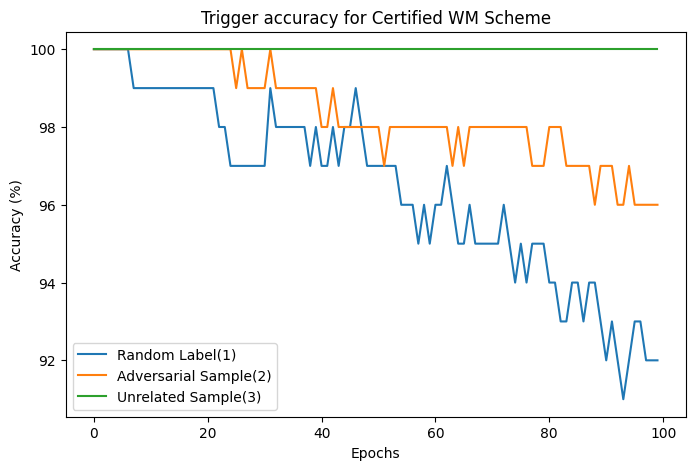

In [23]:
plt.figure(figsize=(8, 5))

plt.plot(range(len(metricscertifiedrand['trigger_acc'])), metricscertifiedrand['trigger_acc'], label='Random Label(1)')
plt.plot(range(len(metricscertifiedadv['trigger_acc'])), metricscertifiedadv['trigger_acc'], label='Adversarial Sample(2)')
plt.plot(range(len(metricscertifiedunrl['trigger_acc'])), metricscertifiedunrl['trigger_acc'], label='Unrelated Sample(3)')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Trigger accuracy for Certified WM Scheme')
plt.legend()
plt.savefig('incre_trigger_acc_8020_certified_5.png')

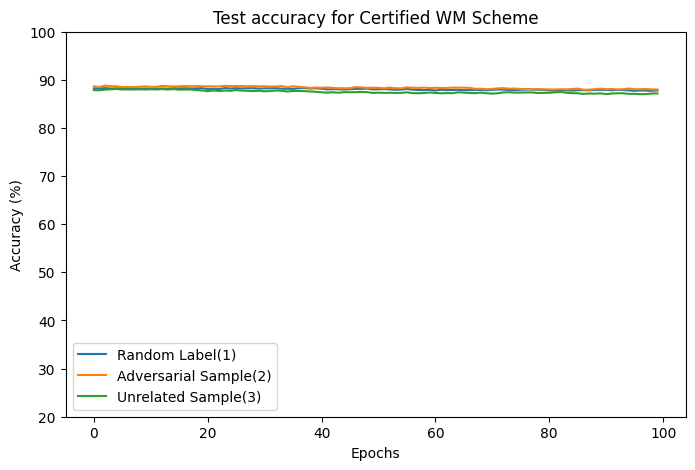

In [24]:
plt.figure(figsize=(8, 5))

plt.plot(range(len(metricscertifiedrand['val_acc'])), metricscertifiedrand['val_acc'], label='Random Label(1)')
plt.plot(range(len(metricscertifiedadv['val_acc'])), metricscertifiedadv['val_acc'], label='Adversarial Sample(2)')
plt.plot(range(len(metricscertifiedunrl['val_acc'])), metricscertifiedunrl['val_acc'], label='Unrelated Sample(3)')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test accuracy for Certified WM Scheme')
plt.ylim([20, 100])
plt.legend()
plt.savefig('incre_test_acc_8020_certified_5.png')

Run 2

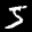

torch.Size([3, 32, 32])


In [25]:
batch_size_train = 256
batch_size_test = 256
batch_size_wm = 64

trainset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/train/', transform=transform_train)
incset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/train_incre/', transform=transform_train)
testset = datasets.ImageFolder('./data/CIFAR10_8020/test', transform=transform_test)
# valset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/val/', transform=transform_test)
watermarkset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/trigger_random/', transform=transform_test)
advwatermarkset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/trigger_adv/', transform=transform_test)

unrelatedset = watermark_unrelated(count=100)
train_watermark_mixset = torch.utils.data.ConcatDataset((trainset,unrelatedset))


# testset = torchvision.datasets.CIFAR10(
#     root='./data', train=False, download=True, transform=transform_test)

unrelatedloader = torch.utils.data.DataLoader(
    unrelatedset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=8)

# valloader = torch.utils.data.DataLoader(
#     valset, batch_size=batch_size_test, shuffle=False, num_workers=8)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

incloader = torch.utils.data.DataLoader(
    incset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

wmloader = torch.utils.data.DataLoader(
    watermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
advwmloader = torch.utils.data.DataLoader(
    advwatermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
train_watermark_loader = torch.utils.data.DataLoader(
    train_watermark_mixset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

In [26]:
netoriginalrand = ResNet18()
netoriginalrand.load_state_dict(torch.load('./checkpoints/resnet18_wm_8020_rand.ckpt'))
netoriginaladv = ResNet18()
netoriginaladv.load_state_dict(torch.load('./checkpoints/resnet18_wm_8020_adv.ckpt'))
netoriginalunrl = ResNet18()
netoriginalunrl.load_state_dict(torch.load('./checkpoints/resnet18_wm_8020_unrl.ckpt'))

netuniformrand = ResNet18()
netuniformrand.load_state_dict(torch.load('./checkpoints/resnet18_wm_frozen_8020_rand.ckpt'))
netuniformadv = ResNet18()
netuniformadv.load_state_dict(torch.load('./checkpoints/resnet18_wm_frozen_8020_adv.ckpt'))
netuniformunrl = ResNet18()
netuniformunrl.load_state_dict(torch.load('./checkpoints/resnet18_wm_frozen_8020_unrl.ckpt'))


<All keys matched successfully>

In [27]:
logcmt = f"incre_train_baseline_8020"

optimizeroriginalrand = torch.optim.SGD(lr=0.001, params=netoriginalrand.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

traineroriginalrand = Trainer(netoriginalrand, criterion, optimizeroriginalrand, incloader)
evaluatororiginalrand = Evaluator(netoriginalrand, criterion)

metricsoriginalrand = train(traineroriginalrand, evaluatororiginalrand, testloader, savename='inccheckpoints/incre_train_baseline_8020_rand', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

Start Training...


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 0 | Time 9s| Train Loss 0.4342 | Train Acc 87.20| Val Loss 0.457 | Val Acc 86.93| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.39it/s]


Epoch 1 | Time 21s| Train Loss 0.4148 | Train Acc 87.41| Val Loss 0.447 | Val Acc 87.10| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.84it/s]


Epoch 2 | Time 31s| Train Loss 0.3826 | Train Acc 88.07| Val Loss 0.436 | Val Acc 87.32| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.25it/s]


Epoch 3 | Time 41s| Train Loss 0.3670 | Train Acc 88.32| Val Loss 0.425 | Val Acc 87.14| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.95it/s]


Epoch 4 | Time 51s| Train Loss 0.3359 | Train Acc 89.24| Val Loss 0.425 | Val Acc 87.08| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.54it/s]


Epoch 5 | Time 61s| Train Loss 0.3243 | Train Acc 89.37| Val Loss 0.417 | Val Acc 87.20| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 6 | Time 71s| Train Loss 0.3238 | Train Acc 88.90| Val Loss 0.414 | Val Acc 87.24| Trigger Loss 0.010 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.83it/s]


Epoch 7 | Time 81s| Train Loss 0.3215 | Train Acc 89.33| Val Loss 0.421 | Val Acc 86.89| Trigger Loss 0.010 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.17it/s]


Epoch 8 | Time 91s| Train Loss 0.3076 | Train Acc 89.87| Val Loss 0.411 | Val Acc 87.00| Trigger Loss 0.009 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.77it/s]


Epoch 9 | Time 101s| Train Loss 0.3077 | Train Acc 89.78| Val Loss 0.416 | Val Acc 86.85| Trigger Loss 0.019 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 10 | Time 111s| Train Loss 0.2944 | Train Acc 90.22| Val Loss 0.413 | Val Acc 87.01| Trigger Loss 0.022 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 11 | Time 122s| Train Loss 0.2861 | Train Acc 90.37| Val Loss 0.409 | Val Acc 87.10| Trigger Loss 0.014 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.91it/s]


Epoch 12 | Time 132s| Train Loss 0.2813 | Train Acc 90.65| Val Loss 0.409 | Val Acc 87.07| Trigger Loss 0.011 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.20it/s]


Epoch 13 | Time 142s| Train Loss 0.2761 | Train Acc 90.51| Val Loss 0.408 | Val Acc 86.94| Trigger Loss 0.018 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.68it/s]


Epoch 14 | Time 151s| Train Loss 0.2672 | Train Acc 90.77| Val Loss 0.410 | Val Acc 87.06| Trigger Loss 0.023 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 15 | Time 161s| Train Loss 0.2709 | Train Acc 90.50| Val Loss 0.412 | Val Acc 87.01| Trigger Loss 0.017 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.61it/s]


Epoch 16 | Time 172s| Train Loss 0.2632 | Train Acc 90.92| Val Loss 0.407 | Val Acc 87.16| Trigger Loss 0.023 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.03it/s]


Epoch 17 | Time 181s| Train Loss 0.2587 | Train Acc 91.08| Val Loss 0.407 | Val Acc 87.13| Trigger Loss 0.022 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.19it/s]


Epoch 18 | Time 191s| Train Loss 0.2600 | Train Acc 91.26| Val Loss 0.410 | Val Acc 87.21| Trigger Loss 0.025 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.61it/s]


Epoch 19 | Time 201s| Train Loss 0.2494 | Train Acc 91.31| Val Loss 0.410 | Val Acc 87.01| Trigger Loss 0.022 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 20 | Time 211s| Train Loss 0.2473 | Train Acc 91.85| Val Loss 0.411 | Val Acc 87.22| Trigger Loss 0.021 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.72it/s]


Epoch 21 | Time 221s| Train Loss 0.2447 | Train Acc 91.91| Val Loss 0.411 | Val Acc 87.05| Trigger Loss 0.027 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.18it/s]


Epoch 22 | Time 230s| Train Loss 0.2333 | Train Acc 92.27| Val Loss 0.413 | Val Acc 87.15| Trigger Loss 0.022 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.64it/s]


Epoch 23 | Time 240s| Train Loss 0.2383 | Train Acc 92.08| Val Loss 0.417 | Val Acc 86.88| Trigger Loss 0.044 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 24 | Time 250s| Train Loss 0.2375 | Train Acc 91.72| Val Loss 0.413 | Val Acc 86.99| Trigger Loss 0.034 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.72it/s]


Epoch 25 | Time 260s| Train Loss 0.2219 | Train Acc 92.68| Val Loss 0.416 | Val Acc 87.00| Trigger Loss 0.033 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.14it/s]


Epoch 26 | Time 269s| Train Loss 0.2229 | Train Acc 92.57| Val Loss 0.418 | Val Acc 87.01| Trigger Loss 0.026 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.13it/s]


Epoch 27 | Time 279s| Train Loss 0.2236 | Train Acc 92.64| Val Loss 0.418 | Val Acc 87.03| Trigger Loss 0.032 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.58it/s]


Epoch 28 | Time 289s| Train Loss 0.2179 | Train Acc 92.35| Val Loss 0.420 | Val Acc 86.95| Trigger Loss 0.039 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 29 | Time 299s| Train Loss 0.2175 | Train Acc 92.68| Val Loss 0.422 | Val Acc 87.03| Trigger Loss 0.039 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.93it/s]


Epoch 30 | Time 309s| Train Loss 0.2094 | Train Acc 93.05| Val Loss 0.421 | Val Acc 87.13| Trigger Loss 0.042 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.20it/s]


Epoch 31 | Time 319s| Train Loss 0.2119 | Train Acc 92.99| Val Loss 0.424 | Val Acc 86.85| Trigger Loss 0.063 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.59it/s]


Epoch 32 | Time 328s| Train Loss 0.2074 | Train Acc 92.90| Val Loss 0.430 | Val Acc 86.91| Trigger Loss 0.063 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 33 | Time 339s| Train Loss 0.2029 | Train Acc 93.48| Val Loss 0.423 | Val Acc 86.96| Trigger Loss 0.070 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.88it/s]


Epoch 34 | Time 348s| Train Loss 0.1957 | Train Acc 93.50| Val Loss 0.424 | Val Acc 86.98| Trigger Loss 0.059 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.19it/s]


Epoch 35 | Time 358s| Train Loss 0.2015 | Train Acc 93.25| Val Loss 0.425 | Val Acc 86.98| Trigger Loss 0.061 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.65it/s]


Epoch 36 | Time 367s| Train Loss 0.1975 | Train Acc 93.40| Val Loss 0.429 | Val Acc 87.02| Trigger Loss 0.066 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 37 | Time 377s| Train Loss 0.1849 | Train Acc 93.80| Val Loss 0.428 | Val Acc 87.03| Trigger Loss 0.046 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.92it/s]


Epoch 38 | Time 387s| Train Loss 0.1846 | Train Acc 93.86| Val Loss 0.430 | Val Acc 87.04| Trigger Loss 0.050 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.31it/s]


Epoch 39 | Time 396s| Train Loss 0.1842 | Train Acc 93.83| Val Loss 0.433 | Val Acc 86.87| Trigger Loss 0.045 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.64it/s]


Epoch 40 | Time 406s| Train Loss 0.1799 | Train Acc 94.21| Val Loss 0.435 | Val Acc 87.04| Trigger Loss 0.078 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 41 | Time 416s| Train Loss 0.1748 | Train Acc 94.11| Val Loss 0.440 | Val Acc 86.77| Trigger Loss 0.044 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.84it/s]


Epoch 42 | Time 426s| Train Loss 0.1725 | Train Acc 94.15| Val Loss 0.442 | Val Acc 86.95| Trigger Loss 0.069 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.25it/s]


Epoch 43 | Time 435s| Train Loss 0.1695 | Train Acc 94.51| Val Loss 0.444 | Val Acc 86.73| Trigger Loss 0.062 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.62it/s]


Epoch 44 | Time 444s| Train Loss 0.1736 | Train Acc 94.00| Val Loss 0.444 | Val Acc 86.81| Trigger Loss 0.078 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 45 | Time 455s| Train Loss 0.1693 | Train Acc 94.45| Val Loss 0.449 | Val Acc 86.76| Trigger Loss 0.101 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.86it/s]


Epoch 46 | Time 464s| Train Loss 0.1662 | Train Acc 94.48| Val Loss 0.449 | Val Acc 86.85| Trigger Loss 0.080 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 47 | Time 474s| Train Loss 0.1631 | Train Acc 94.58| Val Loss 0.447 | Val Acc 86.85| Trigger Loss 0.079 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.58it/s]


Epoch 48 | Time 483s| Train Loss 0.1595 | Train Acc 94.66| Val Loss 0.451 | Val Acc 86.63| Trigger Loss 0.080 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 49 | Time 493s| Train Loss 0.1555 | Train Acc 94.76| Val Loss 0.451 | Val Acc 86.72| Trigger Loss 0.089 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.84it/s]


Epoch 50 | Time 503s| Train Loss 0.1514 | Train Acc 94.89| Val Loss 0.455 | Val Acc 86.69| Trigger Loss 0.080 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.26it/s]


Epoch 51 | Time 512s| Train Loss 0.1483 | Train Acc 95.04| Val Loss 0.462 | Val Acc 86.55| Trigger Loss 0.090 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.61it/s]


Epoch 52 | Time 521s| Train Loss 0.1475 | Train Acc 95.01| Val Loss 0.464 | Val Acc 86.68| Trigger Loss 0.078 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 53 | Time 531s| Train Loss 0.1431 | Train Acc 95.23| Val Loss 0.466 | Val Acc 86.65| Trigger Loss 0.100 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.81it/s]


Epoch 54 | Time 541s| Train Loss 0.1415 | Train Acc 95.48| Val Loss 0.467 | Val Acc 86.64| Trigger Loss 0.078 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.16it/s]


Epoch 55 | Time 550s| Train Loss 0.1446 | Train Acc 95.14| Val Loss 0.468 | Val Acc 86.72| Trigger Loss 0.066 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.60it/s]


Epoch 56 | Time 560s| Train Loss 0.1365 | Train Acc 95.51| Val Loss 0.469 | Val Acc 86.85| Trigger Loss 0.079 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 57 | Time 570s| Train Loss 0.1443 | Train Acc 95.11| Val Loss 0.473 | Val Acc 86.61| Trigger Loss 0.104 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.91it/s]


Epoch 58 | Time 579s| Train Loss 0.1341 | Train Acc 95.78| Val Loss 0.478 | Val Acc 86.28| Trigger Loss 0.094 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.24it/s]


Epoch 59 | Time 589s| Train Loss 0.1325 | Train Acc 95.61| Val Loss 0.475 | Val Acc 86.56| Trigger Loss 0.093 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.61it/s]


Epoch 60 | Time 598s| Train Loss 0.1328 | Train Acc 95.49| Val Loss 0.478 | Val Acc 86.43| Trigger Loss 0.127 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 61 | Time 608s| Train Loss 0.1296 | Train Acc 95.84| Val Loss 0.478 | Val Acc 86.66| Trigger Loss 0.106 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.86it/s]


Epoch 62 | Time 617s| Train Loss 0.1317 | Train Acc 95.55| Val Loss 0.480 | Val Acc 86.53| Trigger Loss 0.113 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.27it/s]


Epoch 63 | Time 627s| Train Loss 0.1248 | Train Acc 96.00| Val Loss 0.483 | Val Acc 86.50| Trigger Loss 0.111 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.64it/s]


Epoch 64 | Time 636s| Train Loss 0.1172 | Train Acc 96.28| Val Loss 0.483 | Val Acc 86.73| Trigger Loss 0.101 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 65 | Time 646s| Train Loss 0.1123 | Train Acc 96.45| Val Loss 0.491 | Val Acc 86.50| Trigger Loss 0.111 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.83it/s]


Epoch 66 | Time 656s| Train Loss 0.1190 | Train Acc 96.06| Val Loss 0.493 | Val Acc 86.33| Trigger Loss 0.104 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.28it/s]


Epoch 67 | Time 665s| Train Loss 0.1179 | Train Acc 96.14| Val Loss 0.492 | Val Acc 86.50| Trigger Loss 0.107 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.66it/s]


Epoch 68 | Time 674s| Train Loss 0.1137 | Train Acc 96.19| Val Loss 0.498 | Val Acc 86.30| Trigger Loss 0.113 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 69 | Time 684s| Train Loss 0.1101 | Train Acc 96.43| Val Loss 0.498 | Val Acc 86.34| Trigger Loss 0.118 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.87it/s]


Epoch 70 | Time 694s| Train Loss 0.1096 | Train Acc 96.46| Val Loss 0.504 | Val Acc 86.08| Trigger Loss 0.133 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.25it/s]


Epoch 71 | Time 703s| Train Loss 0.1059 | Train Acc 96.62| Val Loss 0.499 | Val Acc 86.49| Trigger Loss 0.133 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.58it/s]


Epoch 72 | Time 713s| Train Loss 0.1070 | Train Acc 96.54| Val Loss 0.501 | Val Acc 86.35| Trigger Loss 0.123 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 73 | Time 723s| Train Loss 0.1094 | Train Acc 96.41| Val Loss 0.507 | Val Acc 86.36| Trigger Loss 0.133 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.82it/s]


Epoch 74 | Time 733s| Train Loss 0.1025 | Train Acc 96.85| Val Loss 0.518 | Val Acc 86.08| Trigger Loss 0.175 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 75 | Time 742s| Train Loss 0.0957 | Train Acc 96.97| Val Loss 0.512 | Val Acc 86.27| Trigger Loss 0.136 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.65it/s]


Epoch 76 | Time 751s| Train Loss 0.0972 | Train Acc 96.89| Val Loss 0.517 | Val Acc 86.42| Trigger Loss 0.134 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 77 | Time 761s| Train Loss 0.0960 | Train Acc 96.97| Val Loss 0.513 | Val Acc 86.21| Trigger Loss 0.155 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.89it/s]


Epoch 78 | Time 771s| Train Loss 0.0954 | Train Acc 96.97| Val Loss 0.513 | Val Acc 86.44| Trigger Loss 0.174 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.19it/s]


Epoch 79 | Time 780s| Train Loss 0.0914 | Train Acc 97.15| Val Loss 0.523 | Val Acc 86.23| Trigger Loss 0.193 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.62it/s]


Epoch 80 | Time 789s| Train Loss 0.0945 | Train Acc 96.89| Val Loss 0.530 | Val Acc 86.34| Trigger Loss 0.207 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 81 | Time 800s| Train Loss 0.0870 | Train Acc 97.33| Val Loss 0.528 | Val Acc 86.11| Trigger Loss 0.161 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.85it/s]


Epoch 82 | Time 809s| Train Loss 0.0877 | Train Acc 97.18| Val Loss 0.530 | Val Acc 86.30| Trigger Loss 0.181 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.25it/s]


Epoch 83 | Time 819s| Train Loss 0.0857 | Train Acc 97.29| Val Loss 0.531 | Val Acc 86.23| Trigger Loss 0.161 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.61it/s]


Epoch 84 | Time 828s| Train Loss 0.0847 | Train Acc 97.32| Val Loss 0.531 | Val Acc 86.19| Trigger Loss 0.191 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 85 | Time 838s| Train Loss 0.0786 | Train Acc 97.65| Val Loss 0.542 | Val Acc 86.09| Trigger Loss 0.182 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.84it/s]


Epoch 86 | Time 848s| Train Loss 0.0786 | Train Acc 97.80| Val Loss 0.541 | Val Acc 86.07| Trigger Loss 0.215 | Trigger Acc 91.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.14it/s]


Epoch 87 | Time 857s| Train Loss 0.0778 | Train Acc 97.61| Val Loss 0.539 | Val Acc 86.16| Trigger Loss 0.239 | Trigger Acc 90.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.63it/s]


Epoch 88 | Time 866s| Train Loss 0.0764 | Train Acc 97.75| Val Loss 0.548 | Val Acc 85.95| Trigger Loss 0.242 | Trigger Acc 92.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 89 | Time 876s| Train Loss 0.0775 | Train Acc 97.75| Val Loss 0.541 | Val Acc 86.30| Trigger Loss 0.275 | Trigger Acc 91.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.87it/s]


Epoch 90 | Time 886s| Train Loss 0.0752 | Train Acc 97.84| Val Loss 0.548 | Val Acc 86.07| Trigger Loss 0.283 | Trigger Acc 92.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 91 | Time 895s| Train Loss 0.0712 | Train Acc 97.82| Val Loss 0.550 | Val Acc 85.87| Trigger Loss 0.247 | Trigger Acc 91.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.66it/s]


Epoch 92 | Time 905s| Train Loss 0.0707 | Train Acc 97.97| Val Loss 0.560 | Val Acc 86.06| Trigger Loss 0.204 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 93 | Time 915s| Train Loss 0.0707 | Train Acc 97.87| Val Loss 0.559 | Val Acc 85.85| Trigger Loss 0.197 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.89it/s]


Epoch 94 | Time 924s| Train Loss 0.0693 | Train Acc 97.93| Val Loss 0.557 | Val Acc 86.10| Trigger Loss 0.245 | Trigger Acc 91.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 95 | Time 934s| Train Loss 0.0655 | Train Acc 98.04| Val Loss 0.556 | Val Acc 86.03| Trigger Loss 0.280 | Trigger Acc 91.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.61it/s]


Epoch 96 | Time 943s| Train Loss 0.0688 | Train Acc 97.99| Val Loss 0.559 | Val Acc 86.13| Trigger Loss 0.251 | Trigger Acc 89.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 97 | Time 953s| Train Loss 0.0649 | Train Acc 97.97| Val Loss 0.565 | Val Acc 86.12| Trigger Loss 0.246 | Trigger Acc 92.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.97it/s]


Epoch 98 | Time 963s| Train Loss 0.0652 | Train Acc 98.13| Val Loss 0.558 | Val Acc 86.05| Trigger Loss 0.247 | Trigger Acc 91.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 99 | Time 972s| Train Loss 0.0618 | Train Acc 98.32| Val Loss 0.566 | Val Acc 85.88| Trigger Loss 0.263 | Trigger Acc 90.00


In [28]:
logcmt = f"incre_train_baseline_8020"

optimizeroriginaladv = torch.optim.SGD(lr=0.001, params=netoriginaladv.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

traineroriginaladv = Trainer(netoriginaladv, criterion, optimizeroriginaladv, incloader)
evaluatororiginaladv = Evaluator(netoriginaladv, criterion)

metricsoriginaladv = train(traineroriginaladv, evaluatororiginaladv, testloader, savename='inccheckpoints/incre_train_baseline_8020_adv', logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader, epochs=100)

Start Training...


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.59it/s]


Epoch 0 | Time 9s| Train Loss 0.4401 | Train Acc 87.09| Val Loss 0.458 | Val Acc 87.15| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.61it/s]


Epoch 1 | Time 21s| Train Loss 0.4098 | Train Acc 87.67| Val Loss 0.449 | Val Acc 87.20| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 2 | Time 31s| Train Loss 0.3894 | Train Acc 88.00| Val Loss 0.443 | Val Acc 87.23| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.86it/s]


Epoch 3 | Time 41s| Train Loss 0.3629 | Train Acc 88.29| Val Loss 0.445 | Val Acc 87.09| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.14it/s]


Epoch 4 | Time 51s| Train Loss 0.3481 | Train Acc 88.87| Val Loss 0.429 | Val Acc 87.27| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.76it/s]


Epoch 5 | Time 61s| Train Loss 0.3349 | Train Acc 88.90| Val Loss 0.427 | Val Acc 87.29| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 6 | Time 72s| Train Loss 0.3275 | Train Acc 89.28| Val Loss 0.423 | Val Acc 87.32| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 7 | Time 82s| Train Loss 0.3266 | Train Acc 89.10| Val Loss 0.413 | Val Acc 87.51| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.87it/s]


Epoch 8 | Time 92s| Train Loss 0.3121 | Train Acc 89.63| Val Loss 0.414 | Val Acc 87.38| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 9 | Time 102s| Train Loss 0.3005 | Train Acc 89.84| Val Loss 0.417 | Val Acc 87.06| Trigger Loss 0.007 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.62it/s]


Epoch 10 | Time 111s| Train Loss 0.3026 | Train Acc 89.47| Val Loss 0.413 | Val Acc 87.24| Trigger Loss 0.009 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 11 | Time 121s| Train Loss 0.2921 | Train Acc 90.27| Val Loss 0.409 | Val Acc 87.32| Trigger Loss 0.008 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.58it/s]


Epoch 12 | Time 132s| Train Loss 0.2720 | Train Acc 90.74| Val Loss 0.411 | Val Acc 87.20| Trigger Loss 0.007 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:04<00:00,  8.19it/s]


Epoch 13 | Time 138s| Train Loss 0.2728 | Train Acc 90.64| Val Loss 0.411 | Val Acc 87.27| Trigger Loss 0.010 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:04<00:00,  8.47it/s]


Epoch 14 | Time 147s| Train Loss 0.2730 | Train Acc 90.68| Val Loss 0.407 | Val Acc 87.30| Trigger Loss 0.008 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:05<00:00,  7.14it/s]


Epoch 15 | Time 154s| Train Loss 0.2633 | Train Acc 90.69| Val Loss 0.409 | Val Acc 87.51| Trigger Loss 0.008 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 10.20it/s]


Epoch 16 | Time 160s| Train Loss 0.2600 | Train Acc 91.13| Val Loss 0.408 | Val Acc 87.37| Trigger Loss 0.011 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 17 | Time 166s| Train Loss 0.2671 | Train Acc 90.90| Val Loss 0.411 | Val Acc 87.10| Trigger Loss 0.014 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:04<00:00,  9.18it/s]


Epoch 18 | Time 173s| Train Loss 0.2558 | Train Acc 91.15| Val Loss 0.409 | Val Acc 87.36| Trigger Loss 0.009 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:04<00:00,  9.17it/s]


Epoch 19 | Time 179s| Train Loss 0.2471 | Train Acc 91.62| Val Loss 0.410 | Val Acc 87.43| Trigger Loss 0.012 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 20 | Time 185s| Train Loss 0.2491 | Train Acc 91.27| Val Loss 0.408 | Val Acc 87.29| Trigger Loss 0.013 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:04<00:00,  9.22it/s]


Epoch 21 | Time 192s| Train Loss 0.2470 | Train Acc 91.57| Val Loss 0.413 | Val Acc 87.25| Trigger Loss 0.014 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:04<00:00,  9.19it/s]


Epoch 22 | Time 198s| Train Loss 0.2386 | Train Acc 91.74| Val Loss 0.414 | Val Acc 87.14| Trigger Loss 0.015 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.44it/s]


Epoch 23 | Time 207s| Train Loss 0.2306 | Train Acc 92.25| Val Loss 0.417 | Val Acc 86.94| Trigger Loss 0.019 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.40it/s]


Epoch 24 | Time 218s| Train Loss 0.2303 | Train Acc 92.12| Val Loss 0.415 | Val Acc 87.08| Trigger Loss 0.018 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.43it/s]


Epoch 25 | Time 227s| Train Loss 0.2244 | Train Acc 92.18| Val Loss 0.418 | Val Acc 87.12| Trigger Loss 0.014 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 26 | Time 238s| Train Loss 0.2205 | Train Acc 92.09| Val Loss 0.417 | Val Acc 87.29| Trigger Loss 0.013 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 27 | Time 248s| Train Loss 0.2193 | Train Acc 92.71| Val Loss 0.415 | Val Acc 87.29| Trigger Loss 0.014 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.27it/s]


Epoch 28 | Time 258s| Train Loss 0.2169 | Train Acc 92.28| Val Loss 0.417 | Val Acc 87.25| Trigger Loss 0.019 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 29 | Time 268s| Train Loss 0.2142 | Train Acc 92.67| Val Loss 0.417 | Val Acc 86.89| Trigger Loss 0.017 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.86it/s]


Epoch 30 | Time 278s| Train Loss 0.2124 | Train Acc 92.78| Val Loss 0.420 | Val Acc 87.21| Trigger Loss 0.012 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.74it/s]


Epoch 31 | Time 288s| Train Loss 0.2079 | Train Acc 92.87| Val Loss 0.423 | Val Acc 87.11| Trigger Loss 0.020 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 32 | Time 298s| Train Loss 0.1992 | Train Acc 93.32| Val Loss 0.422 | Val Acc 87.23| Trigger Loss 0.021 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.84it/s]


Epoch 33 | Time 308s| Train Loss 0.2091 | Train Acc 92.73| Val Loss 0.425 | Val Acc 87.16| Trigger Loss 0.017 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.64it/s]


Epoch 34 | Time 318s| Train Loss 0.1958 | Train Acc 93.47| Val Loss 0.425 | Val Acc 87.13| Trigger Loss 0.023 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.29it/s]


Epoch 35 | Time 329s| Train Loss 0.1959 | Train Acc 93.72| Val Loss 0.428 | Val Acc 87.05| Trigger Loss 0.019 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.10it/s]


Epoch 36 | Time 339s| Train Loss 0.1969 | Train Acc 93.50| Val Loss 0.433 | Val Acc 87.02| Trigger Loss 0.028 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.56it/s]


Epoch 37 | Time 349s| Train Loss 0.1892 | Train Acc 93.65| Val Loss 0.428 | Val Acc 87.00| Trigger Loss 0.028 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 38 | Time 359s| Train Loss 0.1870 | Train Acc 93.78| Val Loss 0.436 | Val Acc 86.97| Trigger Loss 0.030 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.18it/s]


Epoch 39 | Time 369s| Train Loss 0.1799 | Train Acc 94.00| Val Loss 0.436 | Val Acc 86.88| Trigger Loss 0.022 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 40 | Time 379s| Train Loss 0.1801 | Train Acc 94.01| Val Loss 0.437 | Val Acc 87.07| Trigger Loss 0.020 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.80it/s]


Epoch 41 | Time 389s| Train Loss 0.1812 | Train Acc 93.96| Val Loss 0.442 | Val Acc 86.98| Trigger Loss 0.033 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.85it/s]


Epoch 42 | Time 399s| Train Loss 0.1764 | Train Acc 94.09| Val Loss 0.443 | Val Acc 86.96| Trigger Loss 0.034 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 43 | Time 409s| Train Loss 0.1749 | Train Acc 94.06| Val Loss 0.444 | Val Acc 87.02| Trigger Loss 0.037 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.96it/s]


Epoch 44 | Time 419s| Train Loss 0.1703 | Train Acc 94.26| Val Loss 0.451 | Val Acc 86.94| Trigger Loss 0.054 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.42it/s]


Epoch 45 | Time 429s| Train Loss 0.1674 | Train Acc 94.39| Val Loss 0.444 | Val Acc 86.98| Trigger Loss 0.046 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.39it/s]


Epoch 46 | Time 439s| Train Loss 0.1602 | Train Acc 94.74| Val Loss 0.450 | Val Acc 86.95| Trigger Loss 0.033 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.02it/s]


Epoch 47 | Time 449s| Train Loss 0.1648 | Train Acc 94.47| Val Loss 0.451 | Val Acc 86.85| Trigger Loss 0.040 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 48 | Time 459s| Train Loss 0.1579 | Train Acc 94.76| Val Loss 0.453 | Val Acc 86.79| Trigger Loss 0.043 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.86it/s]


Epoch 49 | Time 469s| Train Loss 0.1527 | Train Acc 94.94| Val Loss 0.453 | Val Acc 86.66| Trigger Loss 0.057 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.65it/s]


Epoch 50 | Time 479s| Train Loss 0.1530 | Train Acc 95.01| Val Loss 0.459 | Val Acc 86.92| Trigger Loss 0.040 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 51 | Time 489s| Train Loss 0.1522 | Train Acc 95.11| Val Loss 0.460 | Val Acc 86.69| Trigger Loss 0.048 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 52 | Time 499s| Train Loss 0.1479 | Train Acc 94.95| Val Loss 0.465 | Val Acc 86.88| Trigger Loss 0.054 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 53 | Time 508s| Train Loss 0.1445 | Train Acc 95.04| Val Loss 0.462 | Val Acc 86.88| Trigger Loss 0.055 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.84it/s]


Epoch 54 | Time 518s| Train Loss 0.1378 | Train Acc 95.67| Val Loss 0.466 | Val Acc 86.73| Trigger Loss 0.036 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.63it/s]


Epoch 55 | Time 527s| Train Loss 0.1423 | Train Acc 95.20| Val Loss 0.474 | Val Acc 86.52| Trigger Loss 0.054 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 56 | Time 538s| Train Loss 0.1371 | Train Acc 95.55| Val Loss 0.471 | Val Acc 86.36| Trigger Loss 0.064 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.26it/s]


Epoch 57 | Time 547s| Train Loss 0.1347 | Train Acc 95.60| Val Loss 0.471 | Val Acc 86.80| Trigger Loss 0.042 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 58 | Time 557s| Train Loss 0.1302 | Train Acc 95.72| Val Loss 0.479 | Val Acc 86.82| Trigger Loss 0.054 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.85it/s]


Epoch 59 | Time 567s| Train Loss 0.1328 | Train Acc 95.55| Val Loss 0.486 | Val Acc 86.64| Trigger Loss 0.065 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.63it/s]


Epoch 60 | Time 576s| Train Loss 0.1297 | Train Acc 95.77| Val Loss 0.486 | Val Acc 86.55| Trigger Loss 0.068 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 61 | Time 586s| Train Loss 0.1314 | Train Acc 95.61| Val Loss 0.482 | Val Acc 86.89| Trigger Loss 0.079 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 62 | Time 596s| Train Loss 0.1311 | Train Acc 95.54| Val Loss 0.482 | Val Acc 86.74| Trigger Loss 0.051 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 63 | Time 606s| Train Loss 0.1290 | Train Acc 95.82| Val Loss 0.488 | Val Acc 86.59| Trigger Loss 0.060 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.85it/s]


Epoch 64 | Time 615s| Train Loss 0.1175 | Train Acc 96.03| Val Loss 0.492 | Val Acc 86.33| Trigger Loss 0.051 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.65it/s]


Epoch 65 | Time 625s| Train Loss 0.1147 | Train Acc 96.21| Val Loss 0.492 | Val Acc 86.65| Trigger Loss 0.072 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 66 | Time 635s| Train Loss 0.1216 | Train Acc 95.90| Val Loss 0.497 | Val Acc 86.51| Trigger Loss 0.112 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.20it/s]


Epoch 67 | Time 645s| Train Loss 0.1145 | Train Acc 96.35| Val Loss 0.499 | Val Acc 86.43| Trigger Loss 0.076 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 68 | Time 654s| Train Loss 0.1177 | Train Acc 96.07| Val Loss 0.500 | Val Acc 86.61| Trigger Loss 0.069 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.66it/s]


Epoch 69 | Time 664s| Train Loss 0.1124 | Train Acc 96.47| Val Loss 0.501 | Val Acc 86.45| Trigger Loss 0.072 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.73it/s]


Epoch 70 | Time 674s| Train Loss 0.1095 | Train Acc 96.49| Val Loss 0.502 | Val Acc 86.48| Trigger Loss 0.069 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 71 | Time 684s| Train Loss 0.1060 | Train Acc 96.46| Val Loss 0.506 | Val Acc 86.44| Trigger Loss 0.083 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 72 | Time 693s| Train Loss 0.1074 | Train Acc 96.51| Val Loss 0.510 | Val Acc 86.33| Trigger Loss 0.100 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 73 | Time 703s| Train Loss 0.1089 | Train Acc 96.42| Val Loss 0.515 | Val Acc 86.44| Trigger Loss 0.091 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.64it/s]


Epoch 74 | Time 713s| Train Loss 0.1053 | Train Acc 96.51| Val Loss 0.515 | Val Acc 86.51| Trigger Loss 0.089 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.80it/s]


Epoch 75 | Time 723s| Train Loss 0.1033 | Train Acc 96.44| Val Loss 0.514 | Val Acc 86.41| Trigger Loss 0.097 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 76 | Time 733s| Train Loss 0.1001 | Train Acc 96.77| Val Loss 0.513 | Val Acc 86.52| Trigger Loss 0.111 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.17it/s]


Epoch 77 | Time 743s| Train Loss 0.0959 | Train Acc 96.98| Val Loss 0.521 | Val Acc 86.24| Trigger Loss 0.110 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 78 | Time 753s| Train Loss 0.0885 | Train Acc 97.36| Val Loss 0.522 | Val Acc 86.16| Trigger Loss 0.101 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.46it/s]


Epoch 79 | Time 763s| Train Loss 0.0914 | Train Acc 97.06| Val Loss 0.525 | Val Acc 86.22| Trigger Loss 0.119 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.97it/s]


Epoch 80 | Time 773s| Train Loss 0.0902 | Train Acc 97.11| Val Loss 0.527 | Val Acc 86.21| Trigger Loss 0.114 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 81 | Time 783s| Train Loss 0.0880 | Train Acc 97.35| Val Loss 0.530 | Val Acc 86.29| Trigger Loss 0.097 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.02it/s]


Epoch 82 | Time 793s| Train Loss 0.0862 | Train Acc 97.23| Val Loss 0.532 | Val Acc 86.15| Trigger Loss 0.073 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.44it/s]


Epoch 83 | Time 803s| Train Loss 0.0866 | Train Acc 97.47| Val Loss 0.534 | Val Acc 86.29| Trigger Loss 0.141 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 84 | Time 813s| Train Loss 0.0833 | Train Acc 97.42| Val Loss 0.538 | Val Acc 86.11| Trigger Loss 0.123 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 85 | Time 822s| Train Loss 0.0883 | Train Acc 97.25| Val Loss 0.536 | Val Acc 86.27| Trigger Loss 0.125 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 86 | Time 833s| Train Loss 0.0779 | Train Acc 97.66| Val Loss 0.538 | Val Acc 86.21| Trigger Loss 0.152 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.83it/s]


Epoch 87 | Time 843s| Train Loss 0.0830 | Train Acc 97.40| Val Loss 0.545 | Val Acc 86.10| Trigger Loss 0.136 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.59it/s]


Epoch 88 | Time 852s| Train Loss 0.0733 | Train Acc 97.77| Val Loss 0.546 | Val Acc 85.94| Trigger Loss 0.119 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 89 | Time 863s| Train Loss 0.0813 | Train Acc 97.30| Val Loss 0.548 | Val Acc 86.24| Trigger Loss 0.112 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.20it/s]


Epoch 90 | Time 872s| Train Loss 0.0731 | Train Acc 97.74| Val Loss 0.545 | Val Acc 86.25| Trigger Loss 0.139 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 91 | Time 882s| Train Loss 0.0736 | Train Acc 97.65| Val Loss 0.555 | Val Acc 86.18| Trigger Loss 0.146 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.85it/s]


Epoch 92 | Time 892s| Train Loss 0.0694 | Train Acc 97.84| Val Loss 0.559 | Val Acc 86.26| Trigger Loss 0.150 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.64it/s]


Epoch 93 | Time 901s| Train Loss 0.0738 | Train Acc 97.74| Val Loss 0.556 | Val Acc 86.34| Trigger Loss 0.140 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 94 | Time 912s| Train Loss 0.0694 | Train Acc 97.71| Val Loss 0.564 | Val Acc 86.17| Trigger Loss 0.203 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.16it/s]


Epoch 95 | Time 921s| Train Loss 0.0665 | Train Acc 98.17| Val Loss 0.564 | Val Acc 86.13| Trigger Loss 0.172 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 96 | Time 931s| Train Loss 0.0707 | Train Acc 97.73| Val Loss 0.576 | Val Acc 85.96| Trigger Loss 0.134 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.82it/s]


Epoch 97 | Time 941s| Train Loss 0.0663 | Train Acc 97.84| Val Loss 0.572 | Val Acc 86.04| Trigger Loss 0.150 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.66it/s]


Epoch 98 | Time 950s| Train Loss 0.0655 | Train Acc 97.96| Val Loss 0.574 | Val Acc 86.22| Trigger Loss 0.144 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 99 | Time 960s| Train Loss 0.0659 | Train Acc 98.08| Val Loss 0.575 | Val Acc 86.13| Trigger Loss 0.152 | Trigger Acc 93.00


In [29]:
logcmt = f"incre_train_baseline_8020"

optimizeroriginalunrl = torch.optim.SGD(lr=0.001, params=netoriginalunrl.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

traineroriginalunrl = Trainer(netoriginalunrl, criterion, optimizeroriginalunrl, incloader)
evaluatororiginalunrl = Evaluator(netoriginalunrl, criterion)

metricsoriginalunrl = train(traineroriginalunrl, evaluatororiginalunrl, testloader, savename='inccheckpoints/incre_train_baseline_8020_unrl', logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader, epochs=100)

Start Training...


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.10it/s]


Epoch 0 | Time 9s| Train Loss 0.4465 | Train Acc 86.91| Val Loss 0.449 | Val Acc 87.27| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.64it/s]


Epoch 1 | Time 21s| Train Loss 0.4029 | Train Acc 87.68| Val Loss 0.434 | Val Acc 87.31| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 2 | Time 32s| Train Loss 0.3718 | Train Acc 87.82| Val Loss 0.422 | Val Acc 87.35| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.18it/s]


Epoch 3 | Time 41s| Train Loss 0.3603 | Train Acc 88.49| Val Loss 0.424 | Val Acc 87.26| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.47it/s]


Epoch 4 | Time 51s| Train Loss 0.3462 | Train Acc 88.17| Val Loss 0.416 | Val Acc 87.54| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 5 | Time 62s| Train Loss 0.3326 | Train Acc 89.20| Val Loss 0.412 | Val Acc 87.40| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 6 | Time 71s| Train Loss 0.3245 | Train Acc 89.10| Val Loss 0.409 | Val Acc 87.42| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 7 | Time 82s| Train Loss 0.3172 | Train Acc 89.61| Val Loss 0.405 | Val Acc 87.31| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.83it/s]


Epoch 8 | Time 92s| Train Loss 0.2997 | Train Acc 90.02| Val Loss 0.405 | Val Acc 87.56| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.89it/s]


Epoch 9 | Time 102s| Train Loss 0.3065 | Train Acc 89.73| Val Loss 0.406 | Val Acc 87.27| Trigger Loss 0.009 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 10 | Time 112s| Train Loss 0.2868 | Train Acc 90.09| Val Loss 0.405 | Val Acc 87.36| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.88it/s]


Epoch 11 | Time 122s| Train Loss 0.2874 | Train Acc 90.27| Val Loss 0.403 | Val Acc 87.45| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.61it/s]


Epoch 12 | Time 132s| Train Loss 0.2827 | Train Acc 90.45| Val Loss 0.403 | Val Acc 87.48| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 13 | Time 142s| Train Loss 0.2812 | Train Acc 90.30| Val Loss 0.402 | Val Acc 87.38| Trigger Loss 0.018 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 14 | Time 152s| Train Loss 0.2729 | Train Acc 90.82| Val Loss 0.402 | Val Acc 87.31| Trigger Loss 0.036 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 15 | Time 162s| Train Loss 0.2689 | Train Acc 90.89| Val Loss 0.400 | Val Acc 87.50| Trigger Loss 0.020 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 16 | Time 173s| Train Loss 0.2668 | Train Acc 90.86| Val Loss 0.401 | Val Acc 87.31| Trigger Loss 0.060 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 17 | Time 182s| Train Loss 0.2625 | Train Acc 91.14| Val Loss 0.398 | Val Acc 87.55| Trigger Loss 0.009 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 18 | Time 193s| Train Loss 0.2534 | Train Acc 91.37| Val Loss 0.402 | Val Acc 87.42| Trigger Loss 0.008 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.80it/s]


Epoch 19 | Time 203s| Train Loss 0.2486 | Train Acc 91.61| Val Loss 0.404 | Val Acc 87.29| Trigger Loss 0.011 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.65it/s]


Epoch 20 | Time 212s| Train Loss 0.2468 | Train Acc 91.79| Val Loss 0.401 | Val Acc 87.47| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 21 | Time 223s| Train Loss 0.2484 | Train Acc 91.56| Val Loss 0.408 | Val Acc 87.27| Trigger Loss 0.052 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 22 | Time 232s| Train Loss 0.2371 | Train Acc 92.03| Val Loss 0.407 | Val Acc 87.36| Trigger Loss 0.018 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.41it/s]


Epoch 23 | Time 243s| Train Loss 0.2376 | Train Acc 92.13| Val Loss 0.408 | Val Acc 87.32| Trigger Loss 0.063 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 24 | Time 253s| Train Loss 0.2335 | Train Acc 92.17| Val Loss 0.408 | Val Acc 87.31| Trigger Loss 0.043 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 25 | Time 263s| Train Loss 0.2242 | Train Acc 92.23| Val Loss 0.408 | Val Acc 87.33| Trigger Loss 0.014 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 26 | Time 273s| Train Loss 0.2263 | Train Acc 92.16| Val Loss 0.412 | Val Acc 87.23| Trigger Loss 0.032 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.83it/s]


Epoch 27 | Time 283s| Train Loss 0.2195 | Train Acc 92.65| Val Loss 0.415 | Val Acc 87.22| Trigger Loss 0.010 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.68it/s]


Epoch 28 | Time 293s| Train Loss 0.2153 | Train Acc 92.63| Val Loss 0.414 | Val Acc 87.03| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 29 | Time 303s| Train Loss 0.2121 | Train Acc 92.87| Val Loss 0.416 | Val Acc 87.21| Trigger Loss 0.013 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.07it/s]


Epoch 30 | Time 313s| Train Loss 0.2101 | Train Acc 92.86| Val Loss 0.418 | Val Acc 87.24| Trigger Loss 0.017 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.56it/s]


Epoch 31 | Time 323s| Train Loss 0.2055 | Train Acc 93.09| Val Loss 0.420 | Val Acc 87.10| Trigger Loss 0.067 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 32 | Time 333s| Train Loss 0.2092 | Train Acc 92.75| Val Loss 0.422 | Val Acc 87.22| Trigger Loss 0.021 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.19it/s]


Epoch 33 | Time 343s| Train Loss 0.2066 | Train Acc 92.99| Val Loss 0.423 | Val Acc 87.08| Trigger Loss 0.029 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 34 | Time 353s| Train Loss 0.2013 | Train Acc 93.16| Val Loss 0.422 | Val Acc 87.17| Trigger Loss 0.035 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.81it/s]


Epoch 35 | Time 363s| Train Loss 0.1984 | Train Acc 93.34| Val Loss 0.426 | Val Acc 87.00| Trigger Loss 0.022 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.85it/s]


Epoch 36 | Time 373s| Train Loss 0.1936 | Train Acc 93.47| Val Loss 0.424 | Val Acc 87.00| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 37 | Time 384s| Train Loss 0.1899 | Train Acc 93.76| Val Loss 0.424 | Val Acc 87.32| Trigger Loss 0.015 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.95it/s]


Epoch 38 | Time 394s| Train Loss 0.1918 | Train Acc 93.44| Val Loss 0.430 | Val Acc 87.24| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.61it/s]


Epoch 39 | Time 403s| Train Loss 0.1883 | Train Acc 93.64| Val Loss 0.431 | Val Acc 87.02| Trigger Loss 0.025 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 40 | Time 414s| Train Loss 0.1793 | Train Acc 94.18| Val Loss 0.435 | Val Acc 87.05| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.17it/s]


Epoch 41 | Time 423s| Train Loss 0.1765 | Train Acc 94.13| Val Loss 0.436 | Val Acc 86.87| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 42 | Time 433s| Train Loss 0.1734 | Train Acc 94.16| Val Loss 0.436 | Val Acc 86.90| Trigger Loss 0.037 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.44it/s]


Epoch 43 | Time 444s| Train Loss 0.1702 | Train Acc 94.09| Val Loss 0.439 | Val Acc 86.97| Trigger Loss 0.013 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.20it/s]


Epoch 44 | Time 454s| Train Loss 0.1695 | Train Acc 94.13| Val Loss 0.443 | Val Acc 86.88| Trigger Loss 0.074 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 45 | Time 464s| Train Loss 0.1667 | Train Acc 94.52| Val Loss 0.446 | Val Acc 86.88| Trigger Loss 0.009 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.87it/s]


Epoch 46 | Time 474s| Train Loss 0.1688 | Train Acc 94.35| Val Loss 0.447 | Val Acc 86.89| Trigger Loss 0.009 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.62it/s]


Epoch 47 | Time 483s| Train Loss 0.1540 | Train Acc 94.86| Val Loss 0.451 | Val Acc 86.81| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 48 | Time 493s| Train Loss 0.1601 | Train Acc 94.45| Val Loss 0.452 | Val Acc 86.64| Trigger Loss 0.058 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.18it/s]


Epoch 49 | Time 503s| Train Loss 0.1585 | Train Acc 94.72| Val Loss 0.452 | Val Acc 86.76| Trigger Loss 0.040 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 50 | Time 513s| Train Loss 0.1590 | Train Acc 94.99| Val Loss 0.457 | Val Acc 86.74| Trigger Loss 0.099 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.91it/s]


Epoch 51 | Time 523s| Train Loss 0.1503 | Train Acc 94.96| Val Loss 0.457 | Val Acc 86.76| Trigger Loss 0.011 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.65it/s]


Epoch 52 | Time 532s| Train Loss 0.1549 | Train Acc 94.92| Val Loss 0.460 | Val Acc 86.83| Trigger Loss 0.068 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 53 | Time 542s| Train Loss 0.1454 | Train Acc 95.19| Val Loss 0.458 | Val Acc 86.91| Trigger Loss 0.018 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 54 | Time 552s| Train Loss 0.1441 | Train Acc 95.36| Val Loss 0.466 | Val Acc 86.63| Trigger Loss 0.160 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 55 | Time 562s| Train Loss 0.1437 | Train Acc 95.09| Val Loss 0.465 | Val Acc 86.49| Trigger Loss 0.054 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.62it/s]


Epoch 56 | Time 572s| Train Loss 0.1406 | Train Acc 95.40| Val Loss 0.467 | Val Acc 86.70| Trigger Loss 0.009 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.05it/s]


Epoch 57 | Time 582s| Train Loss 0.1347 | Train Acc 95.61| Val Loss 0.470 | Val Acc 86.71| Trigger Loss 0.059 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 58 | Time 592s| Train Loss 0.1355 | Train Acc 95.48| Val Loss 0.480 | Val Acc 86.51| Trigger Loss 0.043 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.97it/s]


Epoch 59 | Time 602s| Train Loss 0.1360 | Train Acc 95.31| Val Loss 0.474 | Val Acc 86.54| Trigger Loss 0.039 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.63it/s]


Epoch 60 | Time 611s| Train Loss 0.1293 | Train Acc 95.78| Val Loss 0.478 | Val Acc 86.61| Trigger Loss 0.020 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 61 | Time 622s| Train Loss 0.1328 | Train Acc 95.55| Val Loss 0.483 | Val Acc 86.58| Trigger Loss 0.010 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.24it/s]


Epoch 62 | Time 632s| Train Loss 0.1288 | Train Acc 95.58| Val Loss 0.481 | Val Acc 86.80| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 63 | Time 642s| Train Loss 0.1256 | Train Acc 95.78| Val Loss 0.482 | Val Acc 86.55| Trigger Loss 0.066 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.80it/s]


Epoch 64 | Time 652s| Train Loss 0.1280 | Train Acc 96.01| Val Loss 0.483 | Val Acc 86.66| Trigger Loss 0.040 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.64it/s]


Epoch 65 | Time 661s| Train Loss 0.1207 | Train Acc 96.01| Val Loss 0.487 | Val Acc 86.62| Trigger Loss 0.026 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 66 | Time 671s| Train Loss 0.1157 | Train Acc 96.13| Val Loss 0.488 | Val Acc 86.50| Trigger Loss 0.256 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.29it/s]


Epoch 67 | Time 681s| Train Loss 0.1160 | Train Acc 96.27| Val Loss 0.489 | Val Acc 86.71| Trigger Loss 0.285 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 68 | Time 691s| Train Loss 0.1145 | Train Acc 96.40| Val Loss 0.505 | Val Acc 86.34| Trigger Loss 0.084 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.83it/s]


Epoch 69 | Time 700s| Train Loss 0.1111 | Train Acc 96.38| Val Loss 0.497 | Val Acc 86.45| Trigger Loss 0.011 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.86it/s]


Epoch 70 | Time 710s| Train Loss 0.1071 | Train Acc 96.59| Val Loss 0.502 | Val Acc 86.50| Trigger Loss 0.011 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 71 | Time 721s| Train Loss 0.1060 | Train Acc 96.72| Val Loss 0.502 | Val Acc 86.54| Trigger Loss 0.028 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.85it/s]


Epoch 72 | Time 731s| Train Loss 0.1062 | Train Acc 96.38| Val Loss 0.507 | Val Acc 86.54| Trigger Loss 0.011 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.59it/s]


Epoch 73 | Time 740s| Train Loss 0.1061 | Train Acc 96.58| Val Loss 0.510 | Val Acc 86.47| Trigger Loss 0.059 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 74 | Time 751s| Train Loss 0.1016 | Train Acc 96.77| Val Loss 0.510 | Val Acc 86.38| Trigger Loss 0.014 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.31it/s]


Epoch 75 | Time 760s| Train Loss 0.0978 | Train Acc 96.96| Val Loss 0.511 | Val Acc 86.43| Trigger Loss 0.013 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 76 | Time 770s| Train Loss 0.0981 | Train Acc 96.83| Val Loss 0.516 | Val Acc 86.48| Trigger Loss 0.043 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.85it/s]


Epoch 77 | Time 780s| Train Loss 0.0978 | Train Acc 96.90| Val Loss 0.520 | Val Acc 86.32| Trigger Loss 0.012 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.73it/s]


Epoch 78 | Time 790s| Train Loss 0.0866 | Train Acc 97.14| Val Loss 0.521 | Val Acc 86.51| Trigger Loss 0.074 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 79 | Time 800s| Train Loss 0.0917 | Train Acc 97.01| Val Loss 0.527 | Val Acc 86.27| Trigger Loss 0.232 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.18it/s]


Epoch 80 | Time 809s| Train Loss 0.0937 | Train Acc 97.21| Val Loss 0.525 | Val Acc 86.29| Trigger Loss 0.009 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 81 | Time 820s| Train Loss 0.0899 | Train Acc 97.06| Val Loss 0.522 | Val Acc 86.35| Trigger Loss 0.016 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 82 | Time 831s| Train Loss 0.0828 | Train Acc 97.32| Val Loss 0.530 | Val Acc 86.34| Trigger Loss 0.060 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.28it/s]


Epoch 83 | Time 840s| Train Loss 0.0871 | Train Acc 97.18| Val Loss 0.533 | Val Acc 86.54| Trigger Loss 0.051 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 84 | Time 850s| Train Loss 0.0849 | Train Acc 97.36| Val Loss 0.538 | Val Acc 86.16| Trigger Loss 0.165 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:05<00:00,  6.64it/s]


Epoch 85 | Time 859s| Train Loss 0.0784 | Train Acc 97.76| Val Loss 0.538 | Val Acc 86.32| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 86 | Time 869s| Train Loss 0.0793 | Train Acc 97.48| Val Loss 0.539 | Val Acc 86.38| Trigger Loss 0.043 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.09it/s]


Epoch 87 | Time 879s| Train Loss 0.0773 | Train Acc 97.70| Val Loss 0.545 | Val Acc 86.15| Trigger Loss 0.044 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.61it/s]


Epoch 88 | Time 888s| Train Loss 0.0817 | Train Acc 97.38| Val Loss 0.543 | Val Acc 86.29| Trigger Loss 0.023 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 89 | Time 899s| Train Loss 0.0790 | Train Acc 97.53| Val Loss 0.547 | Val Acc 86.32| Trigger Loss 0.016 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:05<00:00,  6.50it/s]


Epoch 90 | Time 908s| Train Loss 0.0739 | Train Acc 97.68| Val Loss 0.547 | Val Acc 86.26| Trigger Loss 0.036 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.40it/s]


Epoch 91 | Time 918s| Train Loss 0.0708 | Train Acc 97.87| Val Loss 0.551 | Val Acc 86.33| Trigger Loss 0.069 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 92 | Time 928s| Train Loss 0.0758 | Train Acc 97.54| Val Loss 0.552 | Val Acc 86.21| Trigger Loss 0.102 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.56it/s]


Epoch 93 | Time 937s| Train Loss 0.0702 | Train Acc 97.92| Val Loss 0.550 | Val Acc 86.28| Trigger Loss 0.056 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 94 | Time 948s| Train Loss 0.0728 | Train Acc 97.90| Val Loss 0.557 | Val Acc 86.10| Trigger Loss 0.169 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 95 | Time 957s| Train Loss 0.0714 | Train Acc 97.87| Val Loss 0.560 | Val Acc 86.31| Trigger Loss 0.052 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.39it/s]


Epoch 96 | Time 967s| Train Loss 0.0687 | Train Acc 97.82| Val Loss 0.560 | Val Acc 86.14| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.08it/s]


Epoch 97 | Time 977s| Train Loss 0.0680 | Train Acc 97.92| Val Loss 0.562 | Val Acc 86.43| Trigger Loss 0.025 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.51it/s]


Epoch 98 | Time 987s| Train Loss 0.0659 | Train Acc 97.94| Val Loss 0.566 | Val Acc 86.21| Trigger Loss 0.162 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.42it/s]


Epoch 99 | Time 997s| Train Loss 0.0687 | Train Acc 97.94| Val Loss 0.567 | Val Acc 86.04| Trigger Loss 0.068 | Trigger Acc 98.00


In [30]:
logcmt = f"incre_train_baseline_frozen_8020"

optimizeruniformrand = torch.optim.SGD(lr=0.001, params=netuniformrand.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

traineruniformrand = Trainer(netuniformrand, criterion, optimizeruniformrand, incloader)
evaluatoruniformrand = Evaluator(netuniformrand, criterion)

metricsuniformrand = train(traineruniformrand, evaluatoruniformrand, testloader, savename='inccheckpoints/incre_train_baseline_frozen_8020_rand', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

Start Training...


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.13it/s]


Epoch 0 | Time 9s| Train Loss 0.4857 | Train Acc 85.06| Val Loss 0.530 | Val Acc 84.77| Trigger Loss 0.153 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 1 | Time 22s| Train Loss 0.4475 | Train Acc 85.81| Val Loss 0.496 | Val Acc 85.24| Trigger Loss 0.358 | Trigger Acc 90.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.00it/s]


Epoch 2 | Time 31s| Train Loss 0.4142 | Train Acc 86.55| Val Loss 0.486 | Val Acc 85.45| Trigger Loss 0.299 | Trigger Acc 89.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.69it/s]


Epoch 3 | Time 40s| Train Loss 0.3973 | Train Acc 87.15| Val Loss 0.482 | Val Acc 85.41| Trigger Loss 0.694 | Trigger Acc 80.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 4 | Time 51s| Train Loss 0.3835 | Train Acc 87.22| Val Loss 0.470 | Val Acc 85.52| Trigger Loss 0.855 | Trigger Acc 74.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:05<00:00,  6.51it/s]


Epoch 5 | Time 60s| Train Loss 0.3624 | Train Acc 87.81| Val Loss 0.472 | Val Acc 85.77| Trigger Loss 0.466 | Trigger Acc 81.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 6 | Time 70s| Train Loss 0.3462 | Train Acc 88.15| Val Loss 0.470 | Val Acc 85.40| Trigger Loss 0.544 | Trigger Acc 76.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.12it/s]


Epoch 7 | Time 79s| Train Loss 0.3291 | Train Acc 89.01| Val Loss 0.469 | Val Acc 85.49| Trigger Loss 0.604 | Trigger Acc 74.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.60it/s]


Epoch 8 | Time 88s| Train Loss 0.3248 | Train Acc 88.94| Val Loss 0.460 | Val Acc 85.69| Trigger Loss 0.665 | Trigger Acc 74.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 9 | Time 99s| Train Loss 0.3167 | Train Acc 89.49| Val Loss 0.467 | Val Acc 85.66| Trigger Loss 0.683 | Trigger Acc 73.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:05<00:00,  6.53it/s]


Epoch 10 | Time 107s| Train Loss 0.3168 | Train Acc 89.10| Val Loss 0.469 | Val Acc 85.47| Trigger Loss 0.724 | Trigger Acc 72.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 11 | Time 118s| Train Loss 0.3061 | Train Acc 89.66| Val Loss 0.461 | Val Acc 85.53| Trigger Loss 0.863 | Trigger Acc 69.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.91it/s]


Epoch 12 | Time 128s| Train Loss 0.3086 | Train Acc 89.43| Val Loss 0.461 | Val Acc 85.51| Trigger Loss 0.816 | Trigger Acc 76.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.57it/s]


Epoch 13 | Time 137s| Train Loss 0.2938 | Train Acc 90.03| Val Loss 0.461 | Val Acc 85.65| Trigger Loss 0.761 | Trigger Acc 73.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 14 | Time 147s| Train Loss 0.2867 | Train Acc 90.16| Val Loss 0.465 | Val Acc 85.49| Trigger Loss 0.836 | Trigger Acc 71.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.24it/s]


Epoch 15 | Time 157s| Train Loss 0.2876 | Train Acc 90.10| Val Loss 0.461 | Val Acc 85.48| Trigger Loss 0.855 | Trigger Acc 72.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 16 | Time 167s| Train Loss 0.2832 | Train Acc 90.33| Val Loss 0.462 | Val Acc 85.82| Trigger Loss 0.983 | Trigger Acc 72.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.82it/s]


Epoch 17 | Time 177s| Train Loss 0.2790 | Train Acc 90.21| Val Loss 0.464 | Val Acc 85.43| Trigger Loss 0.964 | Trigger Acc 69.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.65it/s]


Epoch 18 | Time 186s| Train Loss 0.2696 | Train Acc 90.90| Val Loss 0.471 | Val Acc 85.38| Trigger Loss 1.036 | Trigger Acc 67.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 19 | Time 196s| Train Loss 0.2618 | Train Acc 91.02| Val Loss 0.473 | Val Acc 85.27| Trigger Loss 1.013 | Trigger Acc 63.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.26it/s]


Epoch 20 | Time 206s| Train Loss 0.2609 | Train Acc 90.94| Val Loss 0.462 | Val Acc 85.71| Trigger Loss 0.926 | Trigger Acc 69.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 21 | Time 216s| Train Loss 0.2500 | Train Acc 91.29| Val Loss 0.464 | Val Acc 85.78| Trigger Loss 1.032 | Trigger Acc 69.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.89it/s]


Epoch 22 | Time 225s| Train Loss 0.2424 | Train Acc 92.05| Val Loss 0.473 | Val Acc 85.65| Trigger Loss 1.017 | Trigger Acc 68.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.61it/s]


Epoch 23 | Time 235s| Train Loss 0.2415 | Train Acc 91.63| Val Loss 0.472 | Val Acc 85.80| Trigger Loss 1.123 | Trigger Acc 62.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 24 | Time 245s| Train Loss 0.2342 | Train Acc 92.08| Val Loss 0.478 | Val Acc 85.36| Trigger Loss 0.984 | Trigger Acc 64.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.17it/s]


Epoch 25 | Time 254s| Train Loss 0.2359 | Train Acc 92.20| Val Loss 0.473 | Val Acc 85.76| Trigger Loss 1.163 | Trigger Acc 66.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 26 | Time 264s| Train Loss 0.2287 | Train Acc 92.28| Val Loss 0.471 | Val Acc 85.69| Trigger Loss 1.126 | Trigger Acc 65.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.86it/s]


Epoch 27 | Time 274s| Train Loss 0.2252 | Train Acc 92.23| Val Loss 0.474 | Val Acc 85.66| Trigger Loss 1.162 | Trigger Acc 66.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.60it/s]


Epoch 28 | Time 283s| Train Loss 0.2181 | Train Acc 92.75| Val Loss 0.482 | Val Acc 85.56| Trigger Loss 1.330 | Trigger Acc 60.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 29 | Time 294s| Train Loss 0.2189 | Train Acc 92.48| Val Loss 0.481 | Val Acc 85.32| Trigger Loss 1.164 | Trigger Acc 61.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.33it/s]


Epoch 30 | Time 303s| Train Loss 0.2151 | Train Acc 92.70| Val Loss 0.486 | Val Acc 85.56| Trigger Loss 1.170 | Trigger Acc 63.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 31 | Time 313s| Train Loss 0.2137 | Train Acc 92.63| Val Loss 0.485 | Val Acc 85.54| Trigger Loss 1.169 | Trigger Acc 60.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.88it/s]


Epoch 32 | Time 322s| Train Loss 0.2109 | Train Acc 92.94| Val Loss 0.486 | Val Acc 85.62| Trigger Loss 1.305 | Trigger Acc 61.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.66it/s]


Epoch 33 | Time 332s| Train Loss 0.2000 | Train Acc 93.21| Val Loss 0.495 | Val Acc 85.43| Trigger Loss 1.341 | Trigger Acc 62.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.29it/s]


Epoch 34 | Time 342s| Train Loss 0.1953 | Train Acc 93.40| Val Loss 0.494 | Val Acc 85.25| Trigger Loss 1.266 | Trigger Acc 66.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 35 | Time 351s| Train Loss 0.1961 | Train Acc 93.41| Val Loss 0.496 | Val Acc 85.23| Trigger Loss 1.261 | Trigger Acc 64.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 36 | Time 361s| Train Loss 0.1919 | Train Acc 93.72| Val Loss 0.491 | Val Acc 85.42| Trigger Loss 1.271 | Trigger Acc 63.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.87it/s]


Epoch 37 | Time 371s| Train Loss 0.1914 | Train Acc 93.75| Val Loss 0.500 | Val Acc 85.37| Trigger Loss 1.428 | Trigger Acc 59.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.61it/s]


Epoch 38 | Time 380s| Train Loss 0.1909 | Train Acc 93.61| Val Loss 0.500 | Val Acc 85.32| Trigger Loss 1.306 | Trigger Acc 62.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 39 | Time 391s| Train Loss 0.1830 | Train Acc 94.07| Val Loss 0.504 | Val Acc 85.34| Trigger Loss 1.500 | Trigger Acc 59.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 40 | Time 400s| Train Loss 0.1734 | Train Acc 94.15| Val Loss 0.505 | Val Acc 85.21| Trigger Loss 1.183 | Trigger Acc 61.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 41 | Time 410s| Train Loss 0.1716 | Train Acc 94.40| Val Loss 0.510 | Val Acc 85.19| Trigger Loss 1.339 | Trigger Acc 65.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.81it/s]


Epoch 42 | Time 420s| Train Loss 0.1732 | Train Acc 94.27| Val Loss 0.513 | Val Acc 85.27| Trigger Loss 1.359 | Trigger Acc 61.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.64it/s]


Epoch 43 | Time 429s| Train Loss 0.1698 | Train Acc 94.46| Val Loss 0.518 | Val Acc 84.92| Trigger Loss 1.539 | Trigger Acc 59.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 44 | Time 440s| Train Loss 0.1681 | Train Acc 94.51| Val Loss 0.517 | Val Acc 85.05| Trigger Loss 1.230 | Trigger Acc 60.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.19it/s]


Epoch 45 | Time 449s| Train Loss 0.1636 | Train Acc 94.73| Val Loss 0.522 | Val Acc 85.31| Trigger Loss 1.504 | Trigger Acc 57.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 46 | Time 459s| Train Loss 0.1621 | Train Acc 94.67| Val Loss 0.527 | Val Acc 84.92| Trigger Loss 1.334 | Trigger Acc 62.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.66it/s]


Epoch 47 | Time 469s| Train Loss 0.1548 | Train Acc 95.05| Val Loss 0.527 | Val Acc 84.99| Trigger Loss 1.267 | Trigger Acc 64.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.77it/s]


Epoch 48 | Time 479s| Train Loss 0.1504 | Train Acc 95.18| Val Loss 0.523 | Val Acc 85.27| Trigger Loss 1.477 | Trigger Acc 56.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 49 | Time 489s| Train Loss 0.1487 | Train Acc 95.23| Val Loss 0.545 | Val Acc 84.76| Trigger Loss 1.595 | Trigger Acc 62.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 50 | Time 498s| Train Loss 0.1429 | Train Acc 95.18| Val Loss 0.538 | Val Acc 85.07| Trigger Loss 1.596 | Trigger Acc 60.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 51 | Time 508s| Train Loss 0.1405 | Train Acc 95.51| Val Loss 0.542 | Val Acc 84.95| Trigger Loss 1.508 | Trigger Acc 62.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.61it/s]


Epoch 52 | Time 518s| Train Loss 0.1470 | Train Acc 95.12| Val Loss 0.541 | Val Acc 85.18| Trigger Loss 1.495 | Trigger Acc 61.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.86it/s]


Epoch 53 | Time 528s| Train Loss 0.1344 | Train Acc 95.68| Val Loss 0.549 | Val Acc 84.95| Trigger Loss 1.777 | Trigger Acc 56.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 54 | Time 538s| Train Loss 0.1342 | Train Acc 95.55| Val Loss 0.542 | Val Acc 84.95| Trigger Loss 1.716 | Trigger Acc 57.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.19it/s]


Epoch 55 | Time 548s| Train Loss 0.1375 | Train Acc 95.41| Val Loss 0.551 | Val Acc 84.97| Trigger Loss 1.675 | Trigger Acc 58.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 56 | Time 558s| Train Loss 0.1242 | Train Acc 96.13| Val Loss 0.551 | Val Acc 85.02| Trigger Loss 1.724 | Trigger Acc 55.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.43it/s]


Epoch 57 | Time 568s| Train Loss 0.1295 | Train Acc 95.91| Val Loss 0.560 | Val Acc 84.85| Trigger Loss 1.672 | Trigger Acc 61.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.98it/s]


Epoch 58 | Time 578s| Train Loss 0.1232 | Train Acc 96.15| Val Loss 0.553 | Val Acc 85.00| Trigger Loss 1.826 | Trigger Acc 59.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.40it/s]


Epoch 59 | Time 588s| Train Loss 0.1174 | Train Acc 96.23| Val Loss 0.564 | Val Acc 84.69| Trigger Loss 1.763 | Trigger Acc 57.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 60 | Time 597s| Train Loss 0.1179 | Train Acc 96.16| Val Loss 0.566 | Val Acc 84.80| Trigger Loss 1.883 | Trigger Acc 55.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 61 | Time 608s| Train Loss 0.1175 | Train Acc 96.30| Val Loss 0.567 | Val Acc 84.71| Trigger Loss 1.775 | Trigger Acc 58.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.44it/s]


Epoch 62 | Time 618s| Train Loss 0.1190 | Train Acc 96.07| Val Loss 0.570 | Val Acc 84.80| Trigger Loss 1.875 | Trigger Acc 52.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.00it/s]


Epoch 63 | Time 627s| Train Loss 0.1116 | Train Acc 96.43| Val Loss 0.578 | Val Acc 84.65| Trigger Loss 1.934 | Trigger Acc 53.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.39it/s]


Epoch 64 | Time 638s| Train Loss 0.1089 | Train Acc 96.56| Val Loss 0.572 | Val Acc 84.77| Trigger Loss 1.870 | Trigger Acc 56.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.07it/s]


Epoch 65 | Time 647s| Train Loss 0.1106 | Train Acc 96.56| Val Loss 0.581 | Val Acc 84.64| Trigger Loss 1.935 | Trigger Acc 56.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.39it/s]


Epoch 66 | Time 657s| Train Loss 0.1027 | Train Acc 96.81| Val Loss 0.585 | Val Acc 84.74| Trigger Loss 1.828 | Trigger Acc 56.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 67 | Time 668s| Train Loss 0.1054 | Train Acc 96.70| Val Loss 0.586 | Val Acc 84.89| Trigger Loss 2.012 | Trigger Acc 55.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.05it/s]


Epoch 68 | Time 677s| Train Loss 0.0989 | Train Acc 97.14| Val Loss 0.593 | Val Acc 84.64| Trigger Loss 2.126 | Trigger Acc 52.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 69 | Time 688s| Train Loss 0.1017 | Train Acc 96.72| Val Loss 0.587 | Val Acc 84.66| Trigger Loss 1.870 | Trigger Acc 53.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.01it/s]


Epoch 70 | Time 697s| Train Loss 0.0964 | Train Acc 97.06| Val Loss 0.591 | Val Acc 84.73| Trigger Loss 2.018 | Trigger Acc 53.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.39it/s]


Epoch 71 | Time 708s| Train Loss 0.0957 | Train Acc 97.04| Val Loss 0.598 | Val Acc 84.81| Trigger Loss 1.970 | Trigger Acc 53.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 72 | Time 718s| Train Loss 0.0917 | Train Acc 97.24| Val Loss 0.598 | Val Acc 84.77| Trigger Loss 2.193 | Trigger Acc 54.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.16it/s]


Epoch 73 | Time 727s| Train Loss 0.0920 | Train Acc 97.10| Val Loss 0.612 | Val Acc 84.45| Trigger Loss 2.192 | Trigger Acc 52.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 74 | Time 738s| Train Loss 0.0887 | Train Acc 97.21| Val Loss 0.605 | Val Acc 84.63| Trigger Loss 1.943 | Trigger Acc 50.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.98it/s]


Epoch 75 | Time 747s| Train Loss 0.0870 | Train Acc 97.30| Val Loss 0.611 | Val Acc 84.79| Trigger Loss 1.721 | Trigger Acc 53.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.52it/s]


Epoch 76 | Time 757s| Train Loss 0.0888 | Train Acc 97.11| Val Loss 0.613 | Val Acc 84.45| Trigger Loss 2.276 | Trigger Acc 51.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 77 | Time 767s| Train Loss 0.0788 | Train Acc 97.71| Val Loss 0.612 | Val Acc 84.80| Trigger Loss 2.154 | Trigger Acc 55.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 78 | Time 777s| Train Loss 0.0838 | Train Acc 97.41| Val Loss 0.625 | Val Acc 84.33| Trigger Loss 2.204 | Trigger Acc 50.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 79 | Time 787s| Train Loss 0.0833 | Train Acc 97.38| Val Loss 0.623 | Val Acc 84.61| Trigger Loss 2.118 | Trigger Acc 52.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.88it/s]


Epoch 80 | Time 797s| Train Loss 0.0838 | Train Acc 97.36| Val Loss 0.634 | Val Acc 84.32| Trigger Loss 2.112 | Trigger Acc 55.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.58it/s]


Epoch 81 | Time 806s| Train Loss 0.0740 | Train Acc 97.79| Val Loss 0.627 | Val Acc 84.50| Trigger Loss 2.305 | Trigger Acc 52.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 82 | Time 817s| Train Loss 0.0757 | Train Acc 97.71| Val Loss 0.627 | Val Acc 84.44| Trigger Loss 2.440 | Trigger Acc 51.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 83 | Time 826s| Train Loss 0.0764 | Train Acc 97.58| Val Loss 0.630 | Val Acc 84.46| Trigger Loss 2.294 | Trigger Acc 52.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 84 | Time 836s| Train Loss 0.0735 | Train Acc 97.74| Val Loss 0.641 | Val Acc 84.46| Trigger Loss 2.531 | Trigger Acc 46.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.87it/s]


Epoch 85 | Time 846s| Train Loss 0.0732 | Train Acc 97.72| Val Loss 0.645 | Val Acc 84.51| Trigger Loss 2.394 | Trigger Acc 51.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.63it/s]


Epoch 86 | Time 855s| Train Loss 0.0691 | Train Acc 97.85| Val Loss 0.646 | Val Acc 84.50| Trigger Loss 2.462 | Trigger Acc 49.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 87 | Time 866s| Train Loss 0.0705 | Train Acc 97.84| Val Loss 0.658 | Val Acc 84.33| Trigger Loss 2.503 | Trigger Acc 49.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.26it/s]


Epoch 88 | Time 875s| Train Loss 0.0641 | Train Acc 98.16| Val Loss 0.653 | Val Acc 84.57| Trigger Loss 2.276 | Trigger Acc 52.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 89 | Time 885s| Train Loss 0.0613 | Train Acc 98.39| Val Loss 0.660 | Val Acc 84.42| Trigger Loss 2.633 | Trigger Acc 52.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.81it/s]


Epoch 90 | Time 895s| Train Loss 0.0583 | Train Acc 98.48| Val Loss 0.657 | Val Acc 84.30| Trigger Loss 2.527 | Trigger Acc 54.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.60it/s]


Epoch 91 | Time 904s| Train Loss 0.0629 | Train Acc 98.27| Val Loss 0.667 | Val Acc 84.28| Trigger Loss 2.532 | Trigger Acc 49.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 92 | Time 914s| Train Loss 0.0619 | Train Acc 98.26| Val Loss 0.667 | Val Acc 84.38| Trigger Loss 2.643 | Trigger Acc 49.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.20it/s]


Epoch 93 | Time 923s| Train Loss 0.0602 | Train Acc 98.30| Val Loss 0.666 | Val Acc 84.25| Trigger Loss 2.543 | Trigger Acc 48.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 94 | Time 933s| Train Loss 0.0600 | Train Acc 98.31| Val Loss 0.680 | Val Acc 84.10| Trigger Loss 2.408 | Trigger Acc 51.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.88it/s]


Epoch 95 | Time 943s| Train Loss 0.0551 | Train Acc 98.72| Val Loss 0.676 | Val Acc 84.30| Trigger Loss 2.768 | Trigger Acc 46.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.62it/s]


Epoch 96 | Time 952s| Train Loss 0.0553 | Train Acc 98.51| Val Loss 0.688 | Val Acc 84.13| Trigger Loss 2.499 | Trigger Acc 49.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 97 | Time 963s| Train Loss 0.0541 | Train Acc 98.43| Val Loss 0.683 | Val Acc 84.29| Trigger Loss 2.630 | Trigger Acc 47.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.19it/s]


Epoch 98 | Time 972s| Train Loss 0.0574 | Train Acc 98.31| Val Loss 0.680 | Val Acc 84.12| Trigger Loss 2.668 | Trigger Acc 46.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 99 | Time 982s| Train Loss 0.0566 | Train Acc 98.40| Val Loss 0.683 | Val Acc 84.25| Trigger Loss 2.670 | Trigger Acc 45.00


In [31]:
logcmt = f"incre_train_baseline_frozen_8020"

optimizeruniformadv = torch.optim.SGD(lr=0.001, params=netuniformadv.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

traineruniformadv = Trainer(netuniformadv, criterion, optimizeruniformadv, incloader)
evaluatoruniformadv = Evaluator(netuniformadv, criterion)

metricsuniformadv = train(traineruniformadv, evaluatoruniformadv, testloader, savename='inccheckpoints/incre_train_baseline_frozen_8020_adv', logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader, epochs=100)

Start Training...


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.83it/s]


Epoch 0 | Time 9s| Train Loss 0.4740 | Train Acc 85.57| Val Loss 0.516 | Val Acc 85.43| Trigger Loss 0.076 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.20it/s]


Epoch 1 | Time 21s| Train Loss 0.4359 | Train Acc 86.20| Val Loss 0.485 | Val Acc 85.93| Trigger Loss 0.096 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 2 | Time 31s| Train Loss 0.4110 | Train Acc 86.74| Val Loss 0.480 | Val Acc 85.90| Trigger Loss 0.179 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.82it/s]


Epoch 3 | Time 41s| Train Loss 0.3861 | Train Acc 87.16| Val Loss 0.468 | Val Acc 85.94| Trigger Loss 0.132 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.62it/s]


Epoch 4 | Time 51s| Train Loss 0.3692 | Train Acc 87.67| Val Loss 0.465 | Val Acc 86.00| Trigger Loss 0.239 | Trigger Acc 91.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 5 | Time 61s| Train Loss 0.3640 | Train Acc 88.02| Val Loss 0.458 | Val Acc 86.03| Trigger Loss 0.177 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.18it/s]


Epoch 6 | Time 70s| Train Loss 0.3447 | Train Acc 88.30| Val Loss 0.456 | Val Acc 85.89| Trigger Loss 0.230 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 7 | Time 80s| Train Loss 0.3352 | Train Acc 88.67| Val Loss 0.454 | Val Acc 86.10| Trigger Loss 0.245 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.48it/s]


Epoch 8 | Time 91s| Train Loss 0.3248 | Train Acc 88.80| Val Loss 0.456 | Val Acc 85.99| Trigger Loss 0.311 | Trigger Acc 92.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.91it/s]


Epoch 9 | Time 100s| Train Loss 0.3240 | Train Acc 88.77| Val Loss 0.456 | Val Acc 85.95| Trigger Loss 0.261 | Trigger Acc 91.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 10 | Time 111s| Train Loss 0.3110 | Train Acc 89.33| Val Loss 0.456 | Val Acc 85.89| Trigger Loss 0.298 | Trigger Acc 91.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.03it/s]


Epoch 11 | Time 120s| Train Loss 0.3065 | Train Acc 89.35| Val Loss 0.462 | Val Acc 85.72| Trigger Loss 0.352 | Trigger Acc 91.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.46it/s]


Epoch 12 | Time 130s| Train Loss 0.3001 | Train Acc 89.71| Val Loss 0.456 | Val Acc 85.76| Trigger Loss 0.331 | Trigger Acc 91.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 13 | Time 141s| Train Loss 0.2944 | Train Acc 90.14| Val Loss 0.463 | Val Acc 85.42| Trigger Loss 0.414 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.20it/s]


Epoch 14 | Time 150s| Train Loss 0.2900 | Train Acc 90.03| Val Loss 0.456 | Val Acc 85.70| Trigger Loss 0.375 | Trigger Acc 91.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 15 | Time 160s| Train Loss 0.2825 | Train Acc 90.23| Val Loss 0.457 | Val Acc 85.79| Trigger Loss 0.373 | Trigger Acc 90.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.98it/s]


Epoch 16 | Time 170s| Train Loss 0.2777 | Train Acc 90.54| Val Loss 0.456 | Val Acc 85.91| Trigger Loss 0.336 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.52it/s]


Epoch 17 | Time 180s| Train Loss 0.2706 | Train Acc 90.74| Val Loss 0.455 | Val Acc 85.91| Trigger Loss 0.384 | Trigger Acc 91.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 18 | Time 190s| Train Loss 0.2646 | Train Acc 91.03| Val Loss 0.456 | Val Acc 85.43| Trigger Loss 0.375 | Trigger Acc 89.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.26it/s]


Epoch 19 | Time 200s| Train Loss 0.2668 | Train Acc 90.82| Val Loss 0.457 | Val Acc 85.83| Trigger Loss 0.398 | Trigger Acc 89.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 20 | Time 210s| Train Loss 0.2597 | Train Acc 91.11| Val Loss 0.455 | Val Acc 85.98| Trigger Loss 0.379 | Trigger Acc 89.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.90it/s]


Epoch 21 | Time 220s| Train Loss 0.2484 | Train Acc 91.55| Val Loss 0.458 | Val Acc 85.67| Trigger Loss 0.388 | Trigger Acc 90.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.58it/s]


Epoch 22 | Time 229s| Train Loss 0.2464 | Train Acc 91.57| Val Loss 0.464 | Val Acc 85.74| Trigger Loss 0.454 | Trigger Acc 85.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.24it/s]


Epoch 23 | Time 240s| Train Loss 0.2447 | Train Acc 91.73| Val Loss 0.467 | Val Acc 85.79| Trigger Loss 0.481 | Trigger Acc 86.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.19it/s]


Epoch 24 | Time 249s| Train Loss 0.2407 | Train Acc 91.64| Val Loss 0.460 | Val Acc 85.97| Trigger Loss 0.417 | Trigger Acc 89.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 25 | Time 259s| Train Loss 0.2344 | Train Acc 92.08| Val Loss 0.466 | Val Acc 85.87| Trigger Loss 0.406 | Trigger Acc 90.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.93it/s]


Epoch 26 | Time 268s| Train Loss 0.2299 | Train Acc 92.46| Val Loss 0.467 | Val Acc 85.99| Trigger Loss 0.405 | Trigger Acc 89.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.64it/s]


Epoch 27 | Time 278s| Train Loss 0.2236 | Train Acc 92.23| Val Loss 0.471 | Val Acc 85.73| Trigger Loss 0.504 | Trigger Acc 87.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 28 | Time 288s| Train Loss 0.2262 | Train Acc 92.04| Val Loss 0.469 | Val Acc 85.93| Trigger Loss 0.589 | Trigger Acc 84.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 29 | Time 297s| Train Loss 0.2283 | Train Acc 91.98| Val Loss 0.474 | Val Acc 85.75| Trigger Loss 0.597 | Trigger Acc 81.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 30 | Time 307s| Train Loss 0.2175 | Train Acc 92.77| Val Loss 0.473 | Val Acc 85.64| Trigger Loss 0.655 | Trigger Acc 80.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.82it/s]


Epoch 31 | Time 317s| Train Loss 0.2181 | Train Acc 92.61| Val Loss 0.475 | Val Acc 85.79| Trigger Loss 0.653 | Trigger Acc 82.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.61it/s]


Epoch 32 | Time 326s| Train Loss 0.2133 | Train Acc 93.08| Val Loss 0.479 | Val Acc 85.62| Trigger Loss 0.491 | Trigger Acc 87.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 33 | Time 337s| Train Loss 0.2054 | Train Acc 93.00| Val Loss 0.476 | Val Acc 85.81| Trigger Loss 0.530 | Trigger Acc 84.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.20it/s]


Epoch 34 | Time 346s| Train Loss 0.2024 | Train Acc 93.05| Val Loss 0.477 | Val Acc 85.75| Trigger Loss 0.501 | Trigger Acc 86.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 35 | Time 356s| Train Loss 0.1956 | Train Acc 93.38| Val Loss 0.484 | Val Acc 85.71| Trigger Loss 0.574 | Trigger Acc 84.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.90it/s]


Epoch 36 | Time 365s| Train Loss 0.1935 | Train Acc 93.35| Val Loss 0.485 | Val Acc 85.78| Trigger Loss 0.608 | Trigger Acc 82.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.65it/s]


Epoch 37 | Time 375s| Train Loss 0.1935 | Train Acc 93.61| Val Loss 0.489 | Val Acc 85.34| Trigger Loss 0.535 | Trigger Acc 83.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 38 | Time 385s| Train Loss 0.1893 | Train Acc 93.61| Val Loss 0.496 | Val Acc 85.33| Trigger Loss 0.562 | Trigger Acc 85.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.19it/s]


Epoch 39 | Time 395s| Train Loss 0.1837 | Train Acc 93.84| Val Loss 0.499 | Val Acc 85.44| Trigger Loss 0.684 | Trigger Acc 81.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 40 | Time 405s| Train Loss 0.1783 | Train Acc 94.06| Val Loss 0.495 | Val Acc 85.61| Trigger Loss 0.582 | Trigger Acc 83.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.83it/s]


Epoch 41 | Time 414s| Train Loss 0.1727 | Train Acc 94.28| Val Loss 0.492 | Val Acc 85.53| Trigger Loss 0.621 | Trigger Acc 82.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.66it/s]


Epoch 42 | Time 424s| Train Loss 0.1750 | Train Acc 94.21| Val Loss 0.495 | Val Acc 85.54| Trigger Loss 0.556 | Trigger Acc 84.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 43 | Time 434s| Train Loss 0.1684 | Train Acc 94.24| Val Loss 0.498 | Val Acc 85.54| Trigger Loss 0.606 | Trigger Acc 84.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 44 | Time 443s| Train Loss 0.1682 | Train Acc 94.06| Val Loss 0.513 | Val Acc 85.15| Trigger Loss 0.668 | Trigger Acc 77.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 45 | Time 453s| Train Loss 0.1702 | Train Acc 94.28| Val Loss 0.505 | Val Acc 85.44| Trigger Loss 0.637 | Trigger Acc 81.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.71it/s]


Epoch 46 | Time 463s| Train Loss 0.1624 | Train Acc 94.50| Val Loss 0.512 | Val Acc 85.44| Trigger Loss 0.633 | Trigger Acc 83.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.70it/s]


Epoch 47 | Time 473s| Train Loss 0.1489 | Train Acc 95.09| Val Loss 0.512 | Val Acc 85.53| Trigger Loss 0.724 | Trigger Acc 80.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.39it/s]


Epoch 48 | Time 483s| Train Loss 0.1527 | Train Acc 94.92| Val Loss 0.513 | Val Acc 85.36| Trigger Loss 0.688 | Trigger Acc 80.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 49 | Time 492s| Train Loss 0.1541 | Train Acc 94.88| Val Loss 0.522 | Val Acc 85.41| Trigger Loss 0.826 | Trigger Acc 77.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 50 | Time 502s| Train Loss 0.1524 | Train Acc 94.89| Val Loss 0.523 | Val Acc 85.37| Trigger Loss 0.675 | Trigger Acc 81.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.20it/s]


Epoch 51 | Time 512s| Train Loss 0.1512 | Train Acc 95.04| Val Loss 0.525 | Val Acc 85.46| Trigger Loss 0.814 | Trigger Acc 79.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 52 | Time 522s| Train Loss 0.1393 | Train Acc 95.61| Val Loss 0.530 | Val Acc 85.22| Trigger Loss 0.634 | Trigger Acc 82.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.41it/s]


Epoch 53 | Time 532s| Train Loss 0.1364 | Train Acc 95.43| Val Loss 0.534 | Val Acc 85.11| Trigger Loss 0.788 | Trigger Acc 81.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.01it/s]


Epoch 54 | Time 542s| Train Loss 0.1319 | Train Acc 95.77| Val Loss 0.531 | Val Acc 85.19| Trigger Loss 0.837 | Trigger Acc 77.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 55 | Time 552s| Train Loss 0.1338 | Train Acc 95.62| Val Loss 0.533 | Val Acc 85.39| Trigger Loss 0.728 | Trigger Acc 78.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.99it/s]


Epoch 56 | Time 562s| Train Loss 0.1349 | Train Acc 95.62| Val Loss 0.550 | Val Acc 85.24| Trigger Loss 0.803 | Trigger Acc 77.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.41it/s]


Epoch 57 | Time 572s| Train Loss 0.1285 | Train Acc 95.93| Val Loss 0.536 | Val Acc 85.15| Trigger Loss 0.690 | Trigger Acc 78.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 58 | Time 582s| Train Loss 0.1289 | Train Acc 95.75| Val Loss 0.548 | Val Acc 85.11| Trigger Loss 0.846 | Trigger Acc 76.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 59 | Time 592s| Train Loss 0.1253 | Train Acc 96.02| Val Loss 0.554 | Val Acc 85.20| Trigger Loss 0.656 | Trigger Acc 83.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 60 | Time 602s| Train Loss 0.1229 | Train Acc 96.07| Val Loss 0.551 | Val Acc 85.07| Trigger Loss 0.786 | Trigger Acc 78.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.93it/s]


Epoch 61 | Time 612s| Train Loss 0.1214 | Train Acc 96.00| Val Loss 0.549 | Val Acc 85.30| Trigger Loss 0.780 | Trigger Acc 81.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.57it/s]


Epoch 62 | Time 622s| Train Loss 0.1179 | Train Acc 96.14| Val Loss 0.550 | Val Acc 85.42| Trigger Loss 0.865 | Trigger Acc 75.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 63 | Time 632s| Train Loss 0.1131 | Train Acc 96.35| Val Loss 0.561 | Val Acc 85.12| Trigger Loss 0.846 | Trigger Acc 79.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.18it/s]


Epoch 64 | Time 641s| Train Loss 0.1135 | Train Acc 96.27| Val Loss 0.558 | Val Acc 85.10| Trigger Loss 0.756 | Trigger Acc 81.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 65 | Time 652s| Train Loss 0.1115 | Train Acc 96.23| Val Loss 0.569 | Val Acc 85.04| Trigger Loss 0.846 | Trigger Acc 76.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.93it/s]


Epoch 66 | Time 661s| Train Loss 0.1083 | Train Acc 96.69| Val Loss 0.574 | Val Acc 85.11| Trigger Loss 0.856 | Trigger Acc 74.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.58it/s]


Epoch 67 | Time 671s| Train Loss 0.1079 | Train Acc 96.43| Val Loss 0.569 | Val Acc 85.09| Trigger Loss 0.876 | Trigger Acc 77.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 68 | Time 681s| Train Loss 0.1036 | Train Acc 96.77| Val Loss 0.576 | Val Acc 84.86| Trigger Loss 0.845 | Trigger Acc 77.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.20it/s]


Epoch 69 | Time 690s| Train Loss 0.1027 | Train Acc 96.67| Val Loss 0.581 | Val Acc 84.76| Trigger Loss 0.825 | Trigger Acc 78.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 70 | Time 700s| Train Loss 0.0999 | Train Acc 97.02| Val Loss 0.595 | Val Acc 84.69| Trigger Loss 0.927 | Trigger Acc 75.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.91it/s]


Epoch 71 | Time 710s| Train Loss 0.1012 | Train Acc 96.87| Val Loss 0.591 | Val Acc 84.75| Trigger Loss 0.890 | Trigger Acc 77.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.61it/s]


Epoch 72 | Time 719s| Train Loss 0.0977 | Train Acc 96.84| Val Loss 0.594 | Val Acc 84.79| Trigger Loss 0.947 | Trigger Acc 74.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 73 | Time 730s| Train Loss 0.0943 | Train Acc 96.95| Val Loss 0.587 | Val Acc 84.87| Trigger Loss 0.925 | Trigger Acc 74.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 74 | Time 739s| Train Loss 0.0926 | Train Acc 97.21| Val Loss 0.600 | Val Acc 84.82| Trigger Loss 1.045 | Trigger Acc 74.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 75 | Time 749s| Train Loss 0.0936 | Train Acc 97.09| Val Loss 0.597 | Val Acc 84.96| Trigger Loss 0.781 | Trigger Acc 81.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.87it/s]


Epoch 76 | Time 758s| Train Loss 0.0881 | Train Acc 97.42| Val Loss 0.606 | Val Acc 84.73| Trigger Loss 0.940 | Trigger Acc 75.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.66it/s]


Epoch 77 | Time 768s| Train Loss 0.0839 | Train Acc 97.52| Val Loss 0.615 | Val Acc 84.66| Trigger Loss 0.835 | Trigger Acc 79.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 78 | Time 778s| Train Loss 0.0882 | Train Acc 97.15| Val Loss 0.598 | Val Acc 84.95| Trigger Loss 0.921 | Trigger Acc 75.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.19it/s]


Epoch 79 | Time 787s| Train Loss 0.0838 | Train Acc 97.18| Val Loss 0.612 | Val Acc 84.76| Trigger Loss 0.987 | Trigger Acc 72.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 80 | Time 797s| Train Loss 0.0818 | Train Acc 97.62| Val Loss 0.614 | Val Acc 84.89| Trigger Loss 0.953 | Trigger Acc 73.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.87it/s]


Epoch 81 | Time 807s| Train Loss 0.0801 | Train Acc 97.58| Val Loss 0.618 | Val Acc 84.41| Trigger Loss 0.991 | Trigger Acc 77.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.65it/s]


Epoch 82 | Time 816s| Train Loss 0.0777 | Train Acc 97.55| Val Loss 0.610 | Val Acc 84.84| Trigger Loss 0.857 | Trigger Acc 75.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 83 | Time 827s| Train Loss 0.0861 | Train Acc 97.30| Val Loss 0.617 | Val Acc 84.73| Trigger Loss 1.030 | Trigger Acc 73.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.18it/s]


Epoch 84 | Time 836s| Train Loss 0.0766 | Train Acc 97.68| Val Loss 0.620 | Val Acc 84.82| Trigger Loss 1.029 | Trigger Acc 73.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 85 | Time 846s| Train Loss 0.0724 | Train Acc 97.79| Val Loss 0.621 | Val Acc 84.59| Trigger Loss 0.918 | Trigger Acc 76.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.83it/s]


Epoch 86 | Time 856s| Train Loss 0.0712 | Train Acc 97.90| Val Loss 0.628 | Val Acc 84.45| Trigger Loss 0.952 | Trigger Acc 73.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.65it/s]


Epoch 87 | Time 865s| Train Loss 0.0689 | Train Acc 98.00| Val Loss 0.631 | Val Acc 84.62| Trigger Loss 1.010 | Trigger Acc 73.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 88 | Time 876s| Train Loss 0.0687 | Train Acc 98.00| Val Loss 0.636 | Val Acc 84.81| Trigger Loss 1.195 | Trigger Acc 71.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.25it/s]


Epoch 89 | Time 885s| Train Loss 0.0703 | Train Acc 97.72| Val Loss 0.638 | Val Acc 84.62| Trigger Loss 1.134 | Trigger Acc 74.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 90 | Time 895s| Train Loss 0.0657 | Train Acc 97.93| Val Loss 0.633 | Val Acc 84.66| Trigger Loss 1.099 | Trigger Acc 72.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.64it/s]


Epoch 91 | Time 905s| Train Loss 0.0697 | Train Acc 97.86| Val Loss 0.646 | Val Acc 84.54| Trigger Loss 1.225 | Trigger Acc 73.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.76it/s]


Epoch 92 | Time 915s| Train Loss 0.0628 | Train Acc 98.27| Val Loss 0.644 | Val Acc 84.57| Trigger Loss 1.065 | Trigger Acc 75.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 93 | Time 925s| Train Loss 0.0607 | Train Acc 98.36| Val Loss 0.647 | Val Acc 84.59| Trigger Loss 1.089 | Trigger Acc 76.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.27it/s]


Epoch 94 | Time 934s| Train Loss 0.0616 | Train Acc 98.21| Val Loss 0.646 | Val Acc 84.74| Trigger Loss 1.061 | Trigger Acc 78.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 95 | Time 944s| Train Loss 0.0563 | Train Acc 98.24| Val Loss 0.655 | Val Acc 84.78| Trigger Loss 1.198 | Trigger Acc 75.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.50it/s]


Epoch 96 | Time 955s| Train Loss 0.0603 | Train Acc 98.36| Val Loss 0.651 | Val Acc 84.66| Trigger Loss 1.083 | Trigger Acc 73.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.98it/s]


Epoch 97 | Time 964s| Train Loss 0.0551 | Train Acc 98.46| Val Loss 0.651 | Val Acc 84.65| Trigger Loss 1.090 | Trigger Acc 75.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 98 | Time 975s| Train Loss 0.0535 | Train Acc 98.37| Val Loss 0.659 | Val Acc 84.71| Trigger Loss 1.069 | Trigger Acc 76.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.12it/s]


Epoch 99 | Time 984s| Train Loss 0.0515 | Train Acc 98.56| Val Loss 0.667 | Val Acc 84.69| Trigger Loss 1.074 | Trigger Acc 74.00


In [32]:
logcmt = f"incre_train_baseline_frozen_8020"

optimizeruniformunrl = torch.optim.SGD(lr=0.001, params=netuniformunrl.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

traineruniformunrl = Trainer(netuniformunrl, criterion, optimizeruniformunrl, incloader)
evaluatoruniformunrl = Evaluator(netuniformunrl, criterion)

metricsuniformunrl = train(traineruniformunrl, evaluatoruniformunrl, testloader, savename='inccheckpoints/incre_train_baseline_frozen_8020_unrl', logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader, epochs=100)

Start Training...


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.43it/s]


Epoch 0 | Time 10s| Train Loss 0.4739 | Train Acc 85.78| Val Loss 0.473 | Val Acc 85.66| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 1 | Time 23s| Train Loss 0.4248 | Train Acc 86.43| Val Loss 0.465 | Val Acc 86.19| Trigger Loss 2.284 | Trigger Acc 27.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.14it/s]


Epoch 2 | Time 32s| Train Loss 0.4007 | Train Acc 86.41| Val Loss 0.460 | Val Acc 86.05| Trigger Loss 0.109 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 3 | Time 42s| Train Loss 0.3772 | Train Acc 87.59| Val Loss 0.451 | Val Acc 86.16| Trigger Loss 2.557 | Trigger Acc 14.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.39it/s]


Epoch 4 | Time 53s| Train Loss 0.3758 | Train Acc 87.55| Val Loss 0.445 | Val Acc 86.04| Trigger Loss 2.344 | Trigger Acc 24.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.98it/s]


Epoch 5 | Time 62s| Train Loss 0.3557 | Train Acc 87.90| Val Loss 0.449 | Val Acc 86.12| Trigger Loss 1.992 | Trigger Acc 28.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 6 | Time 73s| Train Loss 0.3462 | Train Acc 88.32| Val Loss 0.450 | Val Acc 86.01| Trigger Loss 0.406 | Trigger Acc 89.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.92it/s]


Epoch 7 | Time 82s| Train Loss 0.3323 | Train Acc 88.77| Val Loss 0.440 | Val Acc 86.23| Trigger Loss 1.456 | Trigger Acc 44.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.54it/s]


Epoch 8 | Time 92s| Train Loss 0.3286 | Train Acc 88.92| Val Loss 0.436 | Val Acc 86.30| Trigger Loss 2.871 | Trigger Acc 10.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 9 | Time 103s| Train Loss 0.3200 | Train Acc 89.21| Val Loss 0.434 | Val Acc 86.42| Trigger Loss 2.199 | Trigger Acc 23.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.15it/s]


Epoch 10 | Time 112s| Train Loss 0.3199 | Train Acc 89.09| Val Loss 0.434 | Val Acc 86.35| Trigger Loss 2.097 | Trigger Acc 21.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 11 | Time 122s| Train Loss 0.3089 | Train Acc 89.47| Val Loss 0.436 | Val Acc 86.16| Trigger Loss 0.863 | Trigger Acc 64.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.88it/s]


Epoch 12 | Time 132s| Train Loss 0.3031 | Train Acc 89.65| Val Loss 0.441 | Val Acc 86.27| Trigger Loss 3.845 | Trigger Acc 3.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.58it/s]


Epoch 13 | Time 142s| Train Loss 0.3029 | Train Acc 89.63| Val Loss 0.439 | Val Acc 85.98| Trigger Loss 2.921 | Trigger Acc 13.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 14 | Time 152s| Train Loss 0.2891 | Train Acc 89.93| Val Loss 0.439 | Val Acc 86.11| Trigger Loss 2.402 | Trigger Acc 19.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.20it/s]


Epoch 15 | Time 161s| Train Loss 0.2837 | Train Acc 90.03| Val Loss 0.442 | Val Acc 86.13| Trigger Loss 1.900 | Trigger Acc 28.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 16 | Time 171s| Train Loss 0.2841 | Train Acc 90.38| Val Loss 0.442 | Val Acc 85.91| Trigger Loss 1.935 | Trigger Acc 29.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.92it/s]


Epoch 17 | Time 181s| Train Loss 0.2788 | Train Acc 90.64| Val Loss 0.441 | Val Acc 86.27| Trigger Loss 2.512 | Trigger Acc 25.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.60it/s]


Epoch 18 | Time 190s| Train Loss 0.2744 | Train Acc 90.61| Val Loss 0.441 | Val Acc 86.08| Trigger Loss 3.478 | Trigger Acc 5.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 19 | Time 201s| Train Loss 0.2643 | Train Acc 90.92| Val Loss 0.441 | Val Acc 86.16| Trigger Loss 2.366 | Trigger Acc 19.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.18it/s]


Epoch 20 | Time 210s| Train Loss 0.2626 | Train Acc 91.03| Val Loss 0.443 | Val Acc 86.12| Trigger Loss 3.019 | Trigger Acc 13.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 21 | Time 220s| Train Loss 0.2624 | Train Acc 90.84| Val Loss 0.444 | Val Acc 86.25| Trigger Loss 1.787 | Trigger Acc 32.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.90it/s]


Epoch 22 | Time 230s| Train Loss 0.2618 | Train Acc 90.96| Val Loss 0.445 | Val Acc 86.20| Trigger Loss 1.910 | Trigger Acc 34.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.55it/s]


Epoch 23 | Time 239s| Train Loss 0.2488 | Train Acc 91.29| Val Loss 0.449 | Val Acc 86.17| Trigger Loss 3.407 | Trigger Acc 9.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.29it/s]


Epoch 24 | Time 249s| Train Loss 0.2460 | Train Acc 91.46| Val Loss 0.448 | Val Acc 86.34| Trigger Loss 1.967 | Trigger Acc 26.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.20it/s]


Epoch 25 | Time 259s| Train Loss 0.2474 | Train Acc 91.46| Val Loss 0.453 | Val Acc 86.09| Trigger Loss 4.440 | Trigger Acc 3.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 26 | Time 269s| Train Loss 0.2398 | Train Acc 91.94| Val Loss 0.454 | Val Acc 85.82| Trigger Loss 0.738 | Trigger Acc 71.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.88it/s]


Epoch 27 | Time 278s| Train Loss 0.2312 | Train Acc 92.30| Val Loss 0.456 | Val Acc 86.02| Trigger Loss 3.976 | Trigger Acc 6.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.65it/s]


Epoch 28 | Time 288s| Train Loss 0.2274 | Train Acc 92.25| Val Loss 0.451 | Val Acc 86.09| Trigger Loss 1.406 | Trigger Acc 50.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 29 | Time 298s| Train Loss 0.2225 | Train Acc 92.59| Val Loss 0.457 | Val Acc 85.87| Trigger Loss 2.818 | Trigger Acc 14.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.20it/s]


Epoch 30 | Time 307s| Train Loss 0.2220 | Train Acc 92.36| Val Loss 0.456 | Val Acc 85.82| Trigger Loss 2.419 | Trigger Acc 18.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 31 | Time 317s| Train Loss 0.2164 | Train Acc 92.60| Val Loss 0.460 | Val Acc 85.89| Trigger Loss 1.617 | Trigger Acc 40.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.87it/s]


Epoch 32 | Time 327s| Train Loss 0.2160 | Train Acc 92.62| Val Loss 0.469 | Val Acc 85.41| Trigger Loss 3.739 | Trigger Acc 7.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.58it/s]


Epoch 33 | Time 336s| Train Loss 0.2136 | Train Acc 92.90| Val Loss 0.461 | Val Acc 85.83| Trigger Loss 2.318 | Trigger Acc 23.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 34 | Time 347s| Train Loss 0.2076 | Train Acc 93.10| Val Loss 0.466 | Val Acc 85.72| Trigger Loss 1.320 | Trigger Acc 45.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 35 | Time 356s| Train Loss 0.2023 | Train Acc 93.18| Val Loss 0.466 | Val Acc 85.72| Trigger Loss 1.142 | Trigger Acc 54.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 36 | Time 366s| Train Loss 0.1991 | Train Acc 93.24| Val Loss 0.466 | Val Acc 86.04| Trigger Loss 1.546 | Trigger Acc 42.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.80it/s]


Epoch 37 | Time 375s| Train Loss 0.1934 | Train Acc 93.37| Val Loss 0.474 | Val Acc 85.70| Trigger Loss 3.548 | Trigger Acc 6.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.67it/s]


Epoch 38 | Time 385s| Train Loss 0.1948 | Train Acc 93.30| Val Loss 0.474 | Val Acc 85.70| Trigger Loss 2.368 | Trigger Acc 24.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 39 | Time 395s| Train Loss 0.1871 | Train Acc 93.70| Val Loss 0.477 | Val Acc 85.58| Trigger Loss 0.930 | Trigger Acc 61.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.18it/s]


Epoch 40 | Time 405s| Train Loss 0.1884 | Train Acc 93.57| Val Loss 0.480 | Val Acc 85.52| Trigger Loss 1.229 | Trigger Acc 52.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 41 | Time 414s| Train Loss 0.1931 | Train Acc 93.53| Val Loss 0.475 | Val Acc 85.71| Trigger Loss 1.647 | Trigger Acc 41.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.83it/s]


Epoch 42 | Time 424s| Train Loss 0.1858 | Train Acc 93.67| Val Loss 0.478 | Val Acc 85.70| Trigger Loss 2.953 | Trigger Acc 13.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.66it/s]


Epoch 43 | Time 434s| Train Loss 0.1783 | Train Acc 94.19| Val Loss 0.482 | Val Acc 85.69| Trigger Loss 1.179 | Trigger Acc 51.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 44 | Time 444s| Train Loss 0.1761 | Train Acc 94.12| Val Loss 0.484 | Val Acc 85.54| Trigger Loss 2.409 | Trigger Acc 21.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.20it/s]


Epoch 45 | Time 453s| Train Loss 0.1725 | Train Acc 94.37| Val Loss 0.492 | Val Acc 85.50| Trigger Loss 1.659 | Trigger Acc 44.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 46 | Time 463s| Train Loss 0.1721 | Train Acc 94.30| Val Loss 0.498 | Val Acc 85.46| Trigger Loss 1.682 | Trigger Acc 43.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.60it/s]


Epoch 47 | Time 473s| Train Loss 0.1676 | Train Acc 94.34| Val Loss 0.498 | Val Acc 85.67| Trigger Loss 3.239 | Trigger Acc 15.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.80it/s]


Epoch 48 | Time 483s| Train Loss 0.1638 | Train Acc 94.53| Val Loss 0.493 | Val Acc 85.68| Trigger Loss 1.005 | Trigger Acc 63.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 49 | Time 493s| Train Loss 0.1583 | Train Acc 94.84| Val Loss 0.500 | Val Acc 85.61| Trigger Loss 2.940 | Trigger Acc 22.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.25it/s]


Epoch 50 | Time 502s| Train Loss 0.1559 | Train Acc 94.89| Val Loss 0.504 | Val Acc 85.47| Trigger Loss 3.393 | Trigger Acc 11.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 51 | Time 512s| Train Loss 0.1558 | Train Acc 94.81| Val Loss 0.499 | Val Acc 85.80| Trigger Loss 1.811 | Trigger Acc 42.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.59it/s]


Epoch 52 | Time 523s| Train Loss 0.1512 | Train Acc 94.99| Val Loss 0.502 | Val Acc 85.59| Trigger Loss 2.242 | Trigger Acc 33.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.85it/s]


Epoch 53 | Time 532s| Train Loss 0.1508 | Train Acc 94.96| Val Loss 0.510 | Val Acc 85.61| Trigger Loss 1.317 | Trigger Acc 52.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 54 | Time 543s| Train Loss 0.1437 | Train Acc 95.16| Val Loss 0.507 | Val Acc 85.80| Trigger Loss 1.994 | Trigger Acc 36.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.00it/s]


Epoch 55 | Time 552s| Train Loss 0.1390 | Train Acc 95.30| Val Loss 0.512 | Val Acc 85.57| Trigger Loss 1.042 | Trigger Acc 68.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.39it/s]


Epoch 56 | Time 563s| Train Loss 0.1399 | Train Acc 95.19| Val Loss 0.516 | Val Acc 85.44| Trigger Loss 1.301 | Trigger Acc 52.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.40it/s]


Epoch 57 | Time 573s| Train Loss 0.1373 | Train Acc 95.59| Val Loss 0.523 | Val Acc 85.48| Trigger Loss 1.596 | Trigger Acc 49.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.99it/s]


Epoch 58 | Time 582s| Train Loss 0.1328 | Train Acc 95.54| Val Loss 0.524 | Val Acc 85.35| Trigger Loss 2.690 | Trigger Acc 28.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 59 | Time 593s| Train Loss 0.1313 | Train Acc 96.04| Val Loss 0.521 | Val Acc 85.42| Trigger Loss 2.498 | Trigger Acc 30.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.03it/s]


Epoch 60 | Time 602s| Train Loss 0.1321 | Train Acc 96.01| Val Loss 0.531 | Val Acc 85.32| Trigger Loss 1.343 | Trigger Acc 53.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.41it/s]


Epoch 61 | Time 612s| Train Loss 0.1252 | Train Acc 95.96| Val Loss 0.522 | Val Acc 85.31| Trigger Loss 0.798 | Trigger Acc 66.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 62 | Time 623s| Train Loss 0.1273 | Train Acc 95.84| Val Loss 0.532 | Val Acc 85.39| Trigger Loss 1.500 | Trigger Acc 44.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 63 | Time 632s| Train Loss 0.1244 | Train Acc 95.98| Val Loss 0.538 | Val Acc 85.45| Trigger Loss 2.136 | Trigger Acc 35.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 64 | Time 642s| Train Loss 0.1228 | Train Acc 95.95| Val Loss 0.542 | Val Acc 85.21| Trigger Loss 2.664 | Trigger Acc 29.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.83it/s]


Epoch 65 | Time 652s| Train Loss 0.1164 | Train Acc 96.27| Val Loss 0.548 | Val Acc 84.81| Trigger Loss 3.615 | Trigger Acc 17.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.53it/s]


Epoch 66 | Time 662s| Train Loss 0.1116 | Train Acc 96.72| Val Loss 0.543 | Val Acc 85.08| Trigger Loss 1.680 | Trigger Acc 48.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 67 | Time 673s| Train Loss 0.1146 | Train Acc 96.32| Val Loss 0.544 | Val Acc 85.07| Trigger Loss 1.486 | Trigger Acc 49.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.24it/s]


Epoch 68 | Time 682s| Train Loss 0.1030 | Train Acc 96.99| Val Loss 0.541 | Val Acc 85.34| Trigger Loss 0.990 | Trigger Acc 60.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 69 | Time 692s| Train Loss 0.1064 | Train Acc 96.63| Val Loss 0.555 | Val Acc 85.17| Trigger Loss 1.815 | Trigger Acc 39.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.89it/s]


Epoch 70 | Time 702s| Train Loss 0.1085 | Train Acc 96.59| Val Loss 0.562 | Val Acc 85.20| Trigger Loss 3.017 | Trigger Acc 26.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.62it/s]


Epoch 71 | Time 712s| Train Loss 0.1076 | Train Acc 96.67| Val Loss 0.571 | Val Acc 84.85| Trigger Loss 2.264 | Trigger Acc 32.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 72 | Time 722s| Train Loss 0.1008 | Train Acc 96.93| Val Loss 0.570 | Val Acc 84.82| Trigger Loss 2.356 | Trigger Acc 32.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.26it/s]


Epoch 73 | Time 731s| Train Loss 0.1008 | Train Acc 96.83| Val Loss 0.569 | Val Acc 84.86| Trigger Loss 1.010 | Trigger Acc 72.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 74 | Time 742s| Train Loss 0.0963 | Train Acc 97.07| Val Loss 0.574 | Val Acc 84.89| Trigger Loss 1.096 | Trigger Acc 62.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.14it/s]


Epoch 75 | Time 751s| Train Loss 0.0932 | Train Acc 97.19| Val Loss 0.567 | Val Acc 85.10| Trigger Loss 1.022 | Trigger Acc 72.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.51it/s]


Epoch 76 | Time 761s| Train Loss 0.0948 | Train Acc 97.06| Val Loss 0.577 | Val Acc 85.06| Trigger Loss 3.666 | Trigger Acc 11.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 77 | Time 771s| Train Loss 0.0885 | Train Acc 97.36| Val Loss 0.578 | Val Acc 85.10| Trigger Loss 2.102 | Trigger Acc 34.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.25it/s]


Epoch 78 | Time 781s| Train Loss 0.0860 | Train Acc 97.51| Val Loss 0.585 | Val Acc 84.97| Trigger Loss 2.034 | Trigger Acc 40.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 79 | Time 791s| Train Loss 0.0864 | Train Acc 97.48| Val Loss 0.588 | Val Acc 84.85| Trigger Loss 1.028 | Trigger Acc 68.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.94it/s]


Epoch 80 | Time 801s| Train Loss 0.0854 | Train Acc 97.49| Val Loss 0.587 | Val Acc 84.83| Trigger Loss 1.964 | Trigger Acc 38.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.55it/s]


Epoch 81 | Time 810s| Train Loss 0.0874 | Train Acc 97.31| Val Loss 0.593 | Val Acc 84.97| Trigger Loss 1.818 | Trigger Acc 38.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 82 | Time 821s| Train Loss 0.0822 | Train Acc 97.43| Val Loss 0.606 | Val Acc 84.73| Trigger Loss 2.736 | Trigger Acc 28.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.24it/s]


Epoch 83 | Time 830s| Train Loss 0.0863 | Train Acc 97.34| Val Loss 0.602 | Val Acc 84.84| Trigger Loss 1.665 | Trigger Acc 47.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 84 | Time 840s| Train Loss 0.0790 | Train Acc 97.53| Val Loss 0.606 | Val Acc 84.66| Trigger Loss 1.753 | Trigger Acc 43.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.90it/s]


Epoch 85 | Time 850s| Train Loss 0.0789 | Train Acc 97.68| Val Loss 0.602 | Val Acc 84.83| Trigger Loss 1.610 | Trigger Acc 49.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.57it/s]


Epoch 86 | Time 859s| Train Loss 0.0751 | Train Acc 97.73| Val Loss 0.607 | Val Acc 84.75| Trigger Loss 2.403 | Trigger Acc 28.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.29it/s]


Epoch 87 | Time 870s| Train Loss 0.0752 | Train Acc 97.88| Val Loss 0.616 | Val Acc 84.35| Trigger Loss 0.597 | Trigger Acc 82.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.31it/s]


Epoch 88 | Time 879s| Train Loss 0.0736 | Train Acc 97.77| Val Loss 0.609 | Val Acc 84.85| Trigger Loss 1.130 | Trigger Acc 64.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 89 | Time 889s| Train Loss 0.0724 | Train Acc 97.67| Val Loss 0.617 | Val Acc 84.55| Trigger Loss 2.657 | Trigger Acc 30.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.80it/s]


Epoch 90 | Time 899s| Train Loss 0.0717 | Train Acc 97.88| Val Loss 0.617 | Val Acc 84.60| Trigger Loss 1.197 | Trigger Acc 58.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.59it/s]


Epoch 91 | Time 908s| Train Loss 0.0687 | Train Acc 97.92| Val Loss 0.621 | Val Acc 84.69| Trigger Loss 1.778 | Trigger Acc 48.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 92 | Time 918s| Train Loss 0.0677 | Train Acc 98.02| Val Loss 0.626 | Val Acc 84.72| Trigger Loss 2.408 | Trigger Acc 37.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.18it/s]


Epoch 93 | Time 928s| Train Loss 0.0658 | Train Acc 98.13| Val Loss 0.624 | Val Acc 84.68| Trigger Loss 0.667 | Trigger Acc 77.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 94 | Time 938s| Train Loss 0.0627 | Train Acc 98.17| Val Loss 0.619 | Val Acc 84.52| Trigger Loss 1.058 | Trigger Acc 68.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.86it/s]


Epoch 95 | Time 947s| Train Loss 0.0579 | Train Acc 98.59| Val Loss 0.623 | Val Acc 84.72| Trigger Loss 1.627 | Trigger Acc 54.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.63it/s]


Epoch 96 | Time 957s| Train Loss 0.0623 | Train Acc 98.06| Val Loss 0.639 | Val Acc 84.35| Trigger Loss 1.082 | Trigger Acc 60.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 97 | Time 967s| Train Loss 0.0599 | Train Acc 98.35| Val Loss 0.634 | Val Acc 84.74| Trigger Loss 2.138 | Trigger Acc 39.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 98 | Time 976s| Train Loss 0.0619 | Train Acc 98.11| Val Loss 0.630 | Val Acc 84.67| Trigger Loss 0.241 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 99 | Time 986s| Train Loss 0.0597 | Train Acc 98.32| Val Loss 0.641 | Val Acc 84.73| Trigger Loss 0.610 | Trigger Acc 82.00


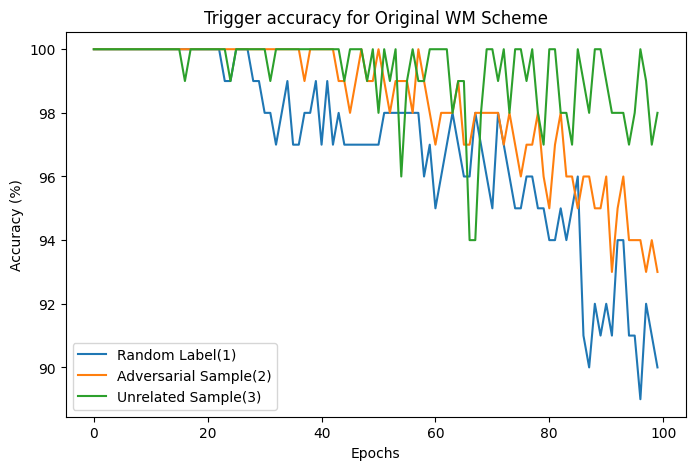

In [33]:
plt.figure(figsize=(8, 5))

plt.plot(range(len(metricsoriginalrand['trigger_acc'])), metricsoriginalrand['trigger_acc'], label='Random Label(1)')
plt.plot(range(len(metricsoriginaladv['trigger_acc'])), metricsoriginaladv['trigger_acc'], label='Adversarial Sample(2)')
plt.plot(range(len(metricsoriginalunrl['trigger_acc'])), metricsoriginalunrl['trigger_acc'], label='Unrelated Sample(3)')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Trigger accuracy for Original WM Scheme')
plt.legend()
plt.savefig('incre_trigger_acc_8020_ori_6.png')

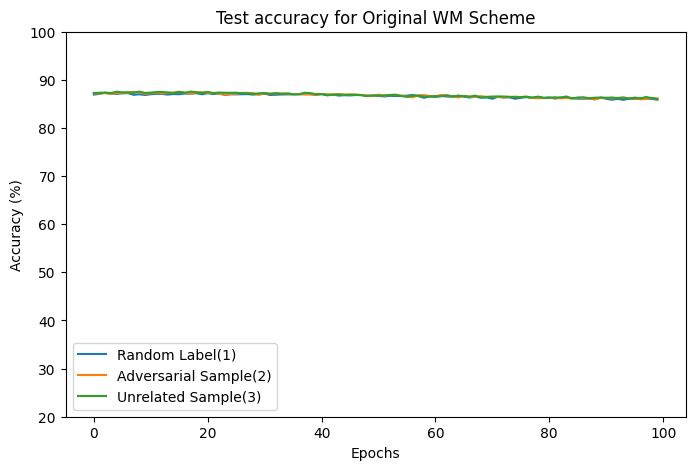

In [34]:
plt.figure(figsize=(8, 5))

plt.plot(range(len(metricsoriginalrand['val_acc'])), metricsoriginalrand['val_acc'], label='Random Label(1)')
plt.plot(range(len(metricsoriginaladv['val_acc'])), metricsoriginaladv['val_acc'], label='Adversarial Sample(2)')
plt.plot(range(len(metricsoriginalunrl['val_acc'])), metricsoriginalunrl['val_acc'], label='Unrelated Sample(3)')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test accuracy for Original WM Scheme')
plt.ylim([20, 100])

plt.legend()
plt.savefig('incre_test_acc_8020_ori_6.png')

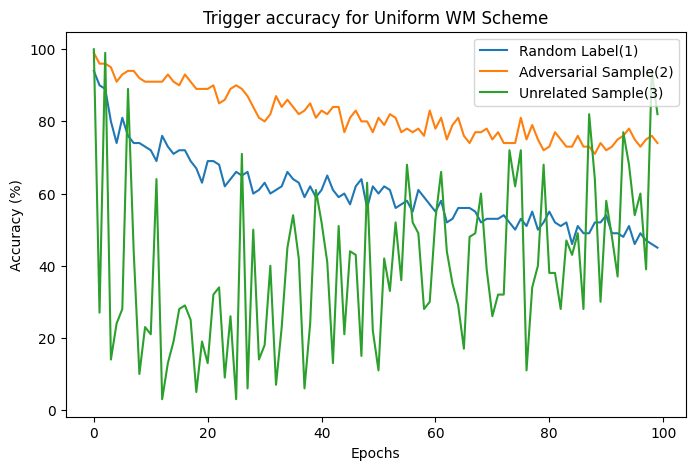

In [35]:
plt.figure(figsize=(8, 5))

plt.plot(range(len(metricsuniformrand['trigger_acc'])), metricsuniformrand['trigger_acc'], label='Random Label(1)')
plt.plot(range(len(metricsuniformadv['trigger_acc'])), metricsuniformadv['trigger_acc'], label='Adversarial Sample(2)')
plt.plot(range(len(metricsuniformunrl['trigger_acc'])), metricsuniformunrl['trigger_acc'], label='Unrelated Sample(3)')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Trigger accuracy for Uniform WM Scheme')
plt.legend()
plt.savefig('incre_trigger_acc_8020_uni_6.png')

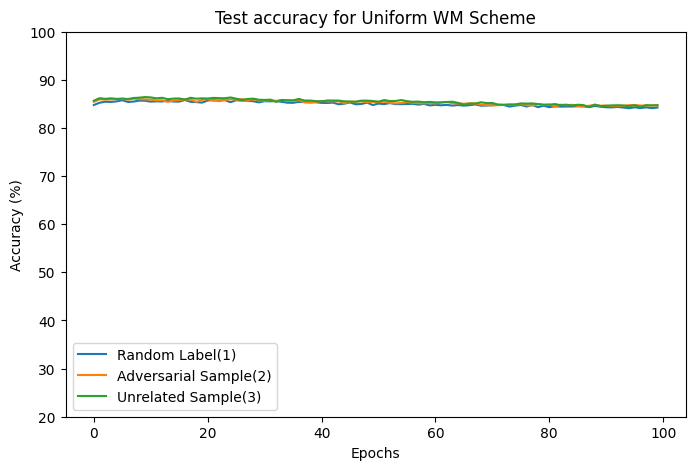

In [36]:
plt.figure(figsize=(8, 5))

plt.plot(range(len(metricsuniformrand['val_acc'])), metricsuniformrand['val_acc'], label='Random Label(1)')
plt.plot(range(len(metricsuniformadv['val_acc'])), metricsuniformadv['val_acc'], label='Adversarial Sample(2)')
plt.plot(range(len(metricsuniformunrl['val_acc'])), metricsuniformunrl['val_acc'], label='Unrelated Sample(3)')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test accuracy for Uniform WM Scheme')
plt.ylim([20, 100])

plt.legend()
plt.savefig('incre_test_acc_8020_uni_6.png')

In [37]:
netcertifiedrand = ResNet18()
netcertifiedrand.load_state_dict(torch.load('./models/wm_cifar10_certify_random_8020_rand.pth')['model_state_dict'])
netcertifiedadv = ResNet18()
netcertifiedadv.load_state_dict(torch.load('./models/wm_cifar10_certify_random_8020_adv.pth')['model_state_dict'])
netcertifiedunrl = ResNet18()
# netcertifiedunrl.load_state_dict(torch.load('./models/wm_cifar10_certify_random_8020_unrl.pth')['model_state_dict'])
netcertifiedunrl.load_state_dict(torch.load('./models/wm_cifar10_certify_random_8020.pth')['model_state_dict'])

<All keys matched successfully>

In [38]:
logcmt = f"incre_train_certified_8020"

optimizercertifiedrand = torch.optim.SGD(lr=0.001, params=netcertifiedrand.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainercertifiedrand = Trainer(netcertifiedrand, criterion, optimizercertifiedrand, incloader)
evaluatorcertifiedrand = Evaluator(netcertifiedrand, criterion)

metricscertifiedrand = train(trainercertifiedrand, evaluatorcertifiedrand, testloader, savename='inccheckpoints/incre_train_cert_8020_rand', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

Start Training...


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 0 | Time 10s| Train Loss 0.4585 | Train Acc 88.45| Val Loss 0.499 | Val Acc 88.33| Trigger Loss 0.007 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.58it/s]


Epoch 1 | Time 22s| Train Loss 0.4289 | Train Acc 89.25| Val Loss 0.490 | Val Acc 88.21| Trigger Loss 0.009 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.10it/s]


Epoch 2 | Time 32s| Train Loss 0.3980 | Train Acc 89.62| Val Loss 0.483 | Val Acc 88.32| Trigger Loss 0.010 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 3 | Time 43s| Train Loss 0.3739 | Train Acc 89.92| Val Loss 0.474 | Val Acc 88.39| Trigger Loss 0.014 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.90it/s]


Epoch 4 | Time 53s| Train Loss 0.3512 | Train Acc 90.10| Val Loss 0.467 | Val Acc 88.28| Trigger Loss 0.017 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.64it/s]


Epoch 5 | Time 62s| Train Loss 0.3345 | Train Acc 90.61| Val Loss 0.460 | Val Acc 88.31| Trigger Loss 0.019 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 6 | Time 73s| Train Loss 0.3201 | Train Acc 91.05| Val Loss 0.454 | Val Acc 88.42| Trigger Loss 0.022 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 7 | Time 82s| Train Loss 0.2950 | Train Acc 91.14| Val Loss 0.453 | Val Acc 88.34| Trigger Loss 0.024 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.48it/s]


Epoch 8 | Time 93s| Train Loss 0.2810 | Train Acc 91.59| Val Loss 0.449 | Val Acc 88.28| Trigger Loss 0.024 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 9 | Time 103s| Train Loss 0.2753 | Train Acc 91.50| Val Loss 0.442 | Val Acc 88.28| Trigger Loss 0.029 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 10 | Time 113s| Train Loss 0.2725 | Train Acc 91.47| Val Loss 0.441 | Val Acc 88.41| Trigger Loss 0.032 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 11 | Time 123s| Train Loss 0.2615 | Train Acc 91.83| Val Loss 0.437 | Val Acc 88.32| Trigger Loss 0.034 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.82it/s]


Epoch 12 | Time 133s| Train Loss 0.2391 | Train Acc 92.34| Val Loss 0.435 | Val Acc 88.34| Trigger Loss 0.045 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.66it/s]


Epoch 13 | Time 142s| Train Loss 0.2383 | Train Acc 92.68| Val Loss 0.436 | Val Acc 88.34| Trigger Loss 0.047 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 14 | Time 152s| Train Loss 0.2255 | Train Acc 92.82| Val Loss 0.432 | Val Acc 88.35| Trigger Loss 0.050 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.29it/s]


Epoch 15 | Time 161s| Train Loss 0.2239 | Train Acc 92.67| Val Loss 0.433 | Val Acc 88.37| Trigger Loss 0.053 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 16 | Time 171s| Train Loss 0.2184 | Train Acc 93.07| Val Loss 0.430 | Val Acc 88.36| Trigger Loss 0.054 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.14it/s]


Epoch 17 | Time 181s| Train Loss 0.2205 | Train Acc 93.16| Val Loss 0.432 | Val Acc 88.39| Trigger Loss 0.060 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 18 | Time 190s| Train Loss 0.2106 | Train Acc 93.09| Val Loss 0.430 | Val Acc 88.39| Trigger Loss 0.061 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.86it/s]


Epoch 19 | Time 200s| Train Loss 0.1978 | Train Acc 93.47| Val Loss 0.429 | Val Acc 88.34| Trigger Loss 0.066 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.64it/s]


Epoch 20 | Time 210s| Train Loss 0.1947 | Train Acc 93.59| Val Loss 0.426 | Val Acc 88.43| Trigger Loss 0.068 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 21 | Time 220s| Train Loss 0.1878 | Train Acc 93.90| Val Loss 0.429 | Val Acc 88.40| Trigger Loss 0.063 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.16it/s]


Epoch 22 | Time 229s| Train Loss 0.1829 | Train Acc 94.01| Val Loss 0.429 | Val Acc 88.34| Trigger Loss 0.069 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 23 | Time 239s| Train Loss 0.1787 | Train Acc 93.95| Val Loss 0.430 | Val Acc 88.37| Trigger Loss 0.071 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.68it/s]


Epoch 24 | Time 249s| Train Loss 0.1788 | Train Acc 94.00| Val Loss 0.428 | Val Acc 88.28| Trigger Loss 0.070 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.73it/s]


Epoch 25 | Time 259s| Train Loss 0.1712 | Train Acc 94.23| Val Loss 0.431 | Val Acc 88.27| Trigger Loss 0.077 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 26 | Time 269s| Train Loss 0.1649 | Train Acc 94.43| Val Loss 0.432 | Val Acc 88.23| Trigger Loss 0.069 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.24it/s]


Epoch 27 | Time 278s| Train Loss 0.1667 | Train Acc 94.41| Val Loss 0.430 | Val Acc 88.28| Trigger Loss 0.074 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 28 | Time 288s| Train Loss 0.1635 | Train Acc 94.53| Val Loss 0.431 | Val Acc 88.27| Trigger Loss 0.078 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.59it/s]


Epoch 29 | Time 299s| Train Loss 0.1559 | Train Acc 94.59| Val Loss 0.432 | Val Acc 88.13| Trigger Loss 0.083 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.89it/s]


Epoch 30 | Time 308s| Train Loss 0.1472 | Train Acc 95.46| Val Loss 0.432 | Val Acc 88.15| Trigger Loss 0.081 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 31 | Time 319s| Train Loss 0.1601 | Train Acc 94.68| Val Loss 0.430 | Val Acc 88.24| Trigger Loss 0.076 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.24it/s]


Epoch 32 | Time 328s| Train Loss 0.1456 | Train Acc 95.20| Val Loss 0.431 | Val Acc 88.17| Trigger Loss 0.084 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 33 | Time 338s| Train Loss 0.1472 | Train Acc 95.02| Val Loss 0.435 | Val Acc 88.12| Trigger Loss 0.090 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.43it/s]


Epoch 34 | Time 349s| Train Loss 0.1412 | Train Acc 95.06| Val Loss 0.437 | Val Acc 88.21| Trigger Loss 0.084 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.98it/s]


Epoch 35 | Time 358s| Train Loss 0.1347 | Train Acc 95.44| Val Loss 0.436 | Val Acc 88.24| Trigger Loss 0.077 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 36 | Time 369s| Train Loss 0.1306 | Train Acc 95.63| Val Loss 0.438 | Val Acc 88.14| Trigger Loss 0.080 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.91it/s]


Epoch 37 | Time 378s| Train Loss 0.1365 | Train Acc 95.58| Val Loss 0.437 | Val Acc 88.14| Trigger Loss 0.082 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.46it/s]


Epoch 38 | Time 388s| Train Loss 0.1345 | Train Acc 95.46| Val Loss 0.436 | Val Acc 88.27| Trigger Loss 0.075 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 39 | Time 399s| Train Loss 0.1266 | Train Acc 95.80| Val Loss 0.437 | Val Acc 88.38| Trigger Loss 0.075 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.26it/s]


Epoch 40 | Time 408s| Train Loss 0.1214 | Train Acc 96.15| Val Loss 0.438 | Val Acc 88.24| Trigger Loss 0.077 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 41 | Time 419s| Train Loss 0.1214 | Train Acc 96.01| Val Loss 0.440 | Val Acc 88.19| Trigger Loss 0.081 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.84it/s]


Epoch 42 | Time 428s| Train Loss 0.1179 | Train Acc 96.07| Val Loss 0.443 | Val Acc 88.14| Trigger Loss 0.077 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.65it/s]


Epoch 43 | Time 438s| Train Loss 0.1129 | Train Acc 96.18| Val Loss 0.443 | Val Acc 88.11| Trigger Loss 0.081 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 44 | Time 448s| Train Loss 0.1116 | Train Acc 96.35| Val Loss 0.444 | Val Acc 88.01| Trigger Loss 0.086 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.28it/s]


Epoch 45 | Time 457s| Train Loss 0.1127 | Train Acc 96.46| Val Loss 0.445 | Val Acc 88.13| Trigger Loss 0.091 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 46 | Time 467s| Train Loss 0.1134 | Train Acc 96.40| Val Loss 0.446 | Val Acc 88.20| Trigger Loss 0.090 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.84it/s]


Epoch 47 | Time 477s| Train Loss 0.1075 | Train Acc 96.18| Val Loss 0.447 | Val Acc 88.23| Trigger Loss 0.088 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.56it/s]


Epoch 48 | Time 486s| Train Loss 0.1037 | Train Acc 96.50| Val Loss 0.448 | Val Acc 88.10| Trigger Loss 0.089 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 49 | Time 497s| Train Loss 0.1042 | Train Acc 96.44| Val Loss 0.447 | Val Acc 88.16| Trigger Loss 0.089 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.25it/s]


Epoch 50 | Time 506s| Train Loss 0.1038 | Train Acc 96.55| Val Loss 0.449 | Val Acc 88.12| Trigger Loss 0.089 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 51 | Time 516s| Train Loss 0.1026 | Train Acc 96.53| Val Loss 0.450 | Val Acc 88.08| Trigger Loss 0.096 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.90it/s]


Epoch 52 | Time 526s| Train Loss 0.0950 | Train Acc 97.17| Val Loss 0.452 | Val Acc 87.97| Trigger Loss 0.087 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.61it/s]


Epoch 53 | Time 535s| Train Loss 0.0983 | Train Acc 96.89| Val Loss 0.451 | Val Acc 88.05| Trigger Loss 0.091 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 54 | Time 545s| Train Loss 0.0933 | Train Acc 97.03| Val Loss 0.455 | Val Acc 88.06| Trigger Loss 0.095 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.16it/s]


Epoch 55 | Time 555s| Train Loss 0.0950 | Train Acc 96.89| Val Loss 0.456 | Val Acc 88.03| Trigger Loss 0.102 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 56 | Time 565s| Train Loss 0.0863 | Train Acc 97.33| Val Loss 0.455 | Val Acc 87.97| Trigger Loss 0.102 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.87it/s]


Epoch 57 | Time 574s| Train Loss 0.0849 | Train Acc 97.58| Val Loss 0.456 | Val Acc 88.02| Trigger Loss 0.106 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.66it/s]


Epoch 58 | Time 584s| Train Loss 0.0820 | Train Acc 97.43| Val Loss 0.459 | Val Acc 87.92| Trigger Loss 0.105 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 59 | Time 594s| Train Loss 0.0856 | Train Acc 97.25| Val Loss 0.460 | Val Acc 88.02| Trigger Loss 0.108 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 60 | Time 603s| Train Loss 0.0839 | Train Acc 97.23| Val Loss 0.462 | Val Acc 87.93| Trigger Loss 0.108 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 61 | Time 613s| Train Loss 0.0830 | Train Acc 97.39| Val Loss 0.463 | Val Acc 88.00| Trigger Loss 0.114 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.84it/s]


Epoch 62 | Time 623s| Train Loss 0.0804 | Train Acc 97.55| Val Loss 0.464 | Val Acc 87.86| Trigger Loss 0.116 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.62it/s]


Epoch 63 | Time 632s| Train Loss 0.0774 | Train Acc 97.67| Val Loss 0.464 | Val Acc 87.93| Trigger Loss 0.115 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 64 | Time 643s| Train Loss 0.0783 | Train Acc 97.67| Val Loss 0.467 | Val Acc 87.97| Trigger Loss 0.112 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.33it/s]


Epoch 65 | Time 652s| Train Loss 0.0727 | Train Acc 97.89| Val Loss 0.467 | Val Acc 87.88| Trigger Loss 0.111 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 66 | Time 662s| Train Loss 0.0703 | Train Acc 97.98| Val Loss 0.469 | Val Acc 87.79| Trigger Loss 0.112 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.79it/s]


Epoch 67 | Time 672s| Train Loss 0.0744 | Train Acc 98.02| Val Loss 0.471 | Val Acc 87.95| Trigger Loss 0.115 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.63it/s]


Epoch 68 | Time 681s| Train Loss 0.0690 | Train Acc 98.21| Val Loss 0.472 | Val Acc 87.84| Trigger Loss 0.108 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 69 | Time 692s| Train Loss 0.0671 | Train Acc 98.19| Val Loss 0.475 | Val Acc 87.82| Trigger Loss 0.117 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.17it/s]


Epoch 70 | Time 701s| Train Loss 0.0663 | Train Acc 98.05| Val Loss 0.474 | Val Acc 87.97| Trigger Loss 0.114 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 71 | Time 711s| Train Loss 0.0636 | Train Acc 98.11| Val Loss 0.475 | Val Acc 87.83| Trigger Loss 0.115 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.57it/s]


Epoch 72 | Time 721s| Train Loss 0.0659 | Train Acc 98.07| Val Loss 0.477 | Val Acc 87.83| Trigger Loss 0.111 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.80it/s]


Epoch 73 | Time 731s| Train Loss 0.0647 | Train Acc 98.18| Val Loss 0.476 | Val Acc 87.85| Trigger Loss 0.118 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 74 | Time 741s| Train Loss 0.0595 | Train Acc 98.47| Val Loss 0.477 | Val Acc 87.91| Trigger Loss 0.115 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.10it/s]


Epoch 75 | Time 751s| Train Loss 0.0611 | Train Acc 98.21| Val Loss 0.478 | Val Acc 87.85| Trigger Loss 0.126 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 76 | Time 761s| Train Loss 0.0596 | Train Acc 98.19| Val Loss 0.480 | Val Acc 87.83| Trigger Loss 0.124 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 77 | Time 772s| Train Loss 0.0585 | Train Acc 98.37| Val Loss 0.481 | Val Acc 87.75| Trigger Loss 0.127 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.10it/s]


Epoch 78 | Time 781s| Train Loss 0.0548 | Train Acc 98.43| Val Loss 0.484 | Val Acc 87.87| Trigger Loss 0.132 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 79 | Time 791s| Train Loss 0.0550 | Train Acc 98.51| Val Loss 0.484 | Val Acc 87.78| Trigger Loss 0.126 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.95it/s]


Epoch 80 | Time 801s| Train Loss 0.0555 | Train Acc 98.47| Val Loss 0.486 | Val Acc 87.85| Trigger Loss 0.133 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.46it/s]


Epoch 81 | Time 811s| Train Loss 0.0528 | Train Acc 98.63| Val Loss 0.486 | Val Acc 87.84| Trigger Loss 0.136 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 82 | Time 822s| Train Loss 0.0542 | Train Acc 98.46| Val Loss 0.485 | Val Acc 87.85| Trigger Loss 0.141 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 83 | Time 831s| Train Loss 0.0513 | Train Acc 98.54| Val Loss 0.485 | Val Acc 87.88| Trigger Loss 0.130 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 84 | Time 841s| Train Loss 0.0526 | Train Acc 98.51| Val Loss 0.489 | Val Acc 87.87| Trigger Loss 0.133 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.85it/s]


Epoch 85 | Time 851s| Train Loss 0.0513 | Train Acc 98.63| Val Loss 0.489 | Val Acc 87.89| Trigger Loss 0.135 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.57it/s]


Epoch 86 | Time 861s| Train Loss 0.0505 | Train Acc 98.66| Val Loss 0.492 | Val Acc 87.85| Trigger Loss 0.139 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 87 | Time 871s| Train Loss 0.0506 | Train Acc 98.53| Val Loss 0.492 | Val Acc 87.85| Trigger Loss 0.141 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.20it/s]


Epoch 88 | Time 880s| Train Loss 0.0522 | Train Acc 98.60| Val Loss 0.496 | Val Acc 87.83| Trigger Loss 0.142 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 89 | Time 890s| Train Loss 0.0442 | Train Acc 98.91| Val Loss 0.494 | Val Acc 87.86| Trigger Loss 0.135 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.86it/s]


Epoch 90 | Time 900s| Train Loss 0.0490 | Train Acc 98.80| Val Loss 0.492 | Val Acc 87.92| Trigger Loss 0.126 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.58it/s]


Epoch 91 | Time 909s| Train Loss 0.0440 | Train Acc 98.92| Val Loss 0.496 | Val Acc 87.80| Trigger Loss 0.135 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 92 | Time 920s| Train Loss 0.0449 | Train Acc 98.83| Val Loss 0.497 | Val Acc 87.77| Trigger Loss 0.136 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.19it/s]


Epoch 93 | Time 929s| Train Loss 0.0448 | Train Acc 98.79| Val Loss 0.497 | Val Acc 87.77| Trigger Loss 0.130 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 94 | Time 939s| Train Loss 0.0427 | Train Acc 98.88| Val Loss 0.499 | Val Acc 87.74| Trigger Loss 0.143 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.89it/s]


Epoch 95 | Time 949s| Train Loss 0.0461 | Train Acc 98.73| Val Loss 0.500 | Val Acc 87.82| Trigger Loss 0.153 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.64it/s]


Epoch 96 | Time 958s| Train Loss 0.0443 | Train Acc 98.88| Val Loss 0.502 | Val Acc 87.74| Trigger Loss 0.154 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 97 | Time 968s| Train Loss 0.0414 | Train Acc 98.96| Val Loss 0.504 | Val Acc 87.78| Trigger Loss 0.158 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.18it/s]


Epoch 98 | Time 978s| Train Loss 0.0438 | Train Acc 98.85| Val Loss 0.507 | Val Acc 87.80| Trigger Loss 0.163 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 99 | Time 988s| Train Loss 0.0391 | Train Acc 99.15| Val Loss 0.505 | Val Acc 87.86| Trigger Loss 0.157 | Trigger Acc 94.00


In [39]:
logcmt = f"incre_train_certified_8020"

optimizercertifiedadv = torch.optim.SGD(lr=0.001, params=netcertifiedadv.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainercertifiedadv = Trainer(netcertifiedadv, criterion, optimizercertifiedadv, incloader)
evaluatorcertifiedadv = Evaluator(netcertifiedadv, criterion)

metricscertifiedadv = train(trainercertifiedadv, evaluatorcertifiedadv, testloader, savename='inccheckpoints/incre_train_cert_8020_adv', logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader, epochs=100)

Start Training...


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.79it/s]


Epoch 0 | Time 9s| Train Loss 0.4967 | Train Acc 88.34| Val Loss 0.480 | Val Acc 88.67| Trigger Loss 0.015 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 1 | Time 21s| Train Loss 0.4266 | Train Acc 89.31| Val Loss 0.467 | Val Acc 88.67| Trigger Loss 0.017 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 2 | Time 31s| Train Loss 0.4045 | Train Acc 89.39| Val Loss 0.461 | Val Acc 88.71| Trigger Loss 0.021 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.50it/s]


Epoch 3 | Time 42s| Train Loss 0.3721 | Train Acc 90.16| Val Loss 0.455 | Val Acc 88.83| Trigger Loss 0.026 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.18it/s]


Epoch 4 | Time 52s| Train Loss 0.3524 | Train Acc 90.13| Val Loss 0.445 | Val Acc 88.73| Trigger Loss 0.028 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 5 | Time 62s| Train Loss 0.3355 | Train Acc 90.50| Val Loss 0.443 | Val Acc 88.66| Trigger Loss 0.034 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.86it/s]


Epoch 6 | Time 72s| Train Loss 0.3148 | Train Acc 90.63| Val Loss 0.436 | Val Acc 88.83| Trigger Loss 0.036 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.61it/s]


Epoch 7 | Time 82s| Train Loss 0.3051 | Train Acc 90.61| Val Loss 0.432 | Val Acc 88.78| Trigger Loss 0.038 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 8 | Time 92s| Train Loss 0.2854 | Train Acc 91.26| Val Loss 0.429 | Val Acc 88.56| Trigger Loss 0.042 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.14it/s]


Epoch 9 | Time 102s| Train Loss 0.2663 | Train Acc 91.98| Val Loss 0.428 | Val Acc 88.54| Trigger Loss 0.047 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.58it/s]


Epoch 10 | Time 112s| Train Loss 0.2636 | Train Acc 91.83| Val Loss 0.423 | Val Acc 88.77| Trigger Loss 0.051 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 11 | Time 123s| Train Loss 0.2425 | Train Acc 92.41| Val Loss 0.421 | Val Acc 88.76| Trigger Loss 0.053 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.18it/s]


Epoch 12 | Time 132s| Train Loss 0.2506 | Train Acc 91.97| Val Loss 0.419 | Val Acc 88.70| Trigger Loss 0.061 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 13 | Time 143s| Train Loss 0.2318 | Train Acc 92.71| Val Loss 0.420 | Val Acc 88.78| Trigger Loss 0.058 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.57it/s]


Epoch 14 | Time 153s| Train Loss 0.2298 | Train Acc 92.84| Val Loss 0.419 | Val Acc 88.67| Trigger Loss 0.064 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.08it/s]


Epoch 15 | Time 163s| Train Loss 0.2178 | Train Acc 92.90| Val Loss 0.415 | Val Acc 88.60| Trigger Loss 0.065 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 16 | Time 173s| Train Loss 0.2113 | Train Acc 92.95| Val Loss 0.416 | Val Acc 88.56| Trigger Loss 0.065 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.93it/s]


Epoch 17 | Time 183s| Train Loss 0.2092 | Train Acc 93.06| Val Loss 0.415 | Val Acc 88.64| Trigger Loss 0.065 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.62it/s]


Epoch 18 | Time 193s| Train Loss 0.1995 | Train Acc 93.04| Val Loss 0.415 | Val Acc 88.56| Trigger Loss 0.067 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 19 | Time 203s| Train Loss 0.1970 | Train Acc 93.32| Val Loss 0.416 | Val Acc 88.62| Trigger Loss 0.070 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 20 | Time 213s| Train Loss 0.1926 | Train Acc 93.84| Val Loss 0.414 | Val Acc 88.53| Trigger Loss 0.071 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 21 | Time 224s| Train Loss 0.1862 | Train Acc 93.77| Val Loss 0.415 | Val Acc 88.60| Trigger Loss 0.072 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 22 | Time 234s| Train Loss 0.1804 | Train Acc 94.11| Val Loss 0.413 | Val Acc 88.65| Trigger Loss 0.077 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.26it/s]


Epoch 23 | Time 243s| Train Loss 0.1862 | Train Acc 93.61| Val Loss 0.415 | Val Acc 88.74| Trigger Loss 0.076 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 24 | Time 254s| Train Loss 0.1750 | Train Acc 93.81| Val Loss 0.412 | Val Acc 88.75| Trigger Loss 0.081 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.86it/s]


Epoch 25 | Time 263s| Train Loss 0.1668 | Train Acc 94.62| Val Loss 0.413 | Val Acc 88.75| Trigger Loss 0.085 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.56it/s]


Epoch 26 | Time 273s| Train Loss 0.1676 | Train Acc 94.44| Val Loss 0.415 | Val Acc 88.73| Trigger Loss 0.089 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 27 | Time 283s| Train Loss 0.1641 | Train Acc 94.54| Val Loss 0.413 | Val Acc 88.74| Trigger Loss 0.093 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.18it/s]


Epoch 28 | Time 292s| Train Loss 0.1595 | Train Acc 94.69| Val Loss 0.414 | Val Acc 88.68| Trigger Loss 0.091 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 29 | Time 302s| Train Loss 0.1595 | Train Acc 94.50| Val Loss 0.416 | Val Acc 88.55| Trigger Loss 0.097 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.80it/s]


Epoch 30 | Time 312s| Train Loss 0.1496 | Train Acc 94.99| Val Loss 0.418 | Val Acc 88.40| Trigger Loss 0.095 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.64it/s]


Epoch 31 | Time 321s| Train Loss 0.1415 | Train Acc 95.11| Val Loss 0.418 | Val Acc 88.61| Trigger Loss 0.094 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 32 | Time 332s| Train Loss 0.1459 | Train Acc 95.30| Val Loss 0.417 | Val Acc 88.58| Trigger Loss 0.098 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.26it/s]


Epoch 33 | Time 341s| Train Loss 0.1471 | Train Acc 95.12| Val Loss 0.418 | Val Acc 88.61| Trigger Loss 0.102 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 34 | Time 351s| Train Loss 0.1389 | Train Acc 95.35| Val Loss 0.420 | Val Acc 88.59| Trigger Loss 0.101 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.81it/s]


Epoch 35 | Time 361s| Train Loss 0.1377 | Train Acc 95.21| Val Loss 0.422 | Val Acc 88.55| Trigger Loss 0.102 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.63it/s]


Epoch 36 | Time 370s| Train Loss 0.1326 | Train Acc 95.76| Val Loss 0.422 | Val Acc 88.43| Trigger Loss 0.100 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 37 | Time 380s| Train Loss 0.1327 | Train Acc 95.47| Val Loss 0.423 | Val Acc 88.55| Trigger Loss 0.101 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.17it/s]


Epoch 38 | Time 390s| Train Loss 0.1274 | Train Acc 95.79| Val Loss 0.425 | Val Acc 88.44| Trigger Loss 0.099 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 39 | Time 400s| Train Loss 0.1262 | Train Acc 95.84| Val Loss 0.428 | Val Acc 88.42| Trigger Loss 0.101 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.81it/s]


Epoch 40 | Time 409s| Train Loss 0.1234 | Train Acc 96.07| Val Loss 0.428 | Val Acc 88.41| Trigger Loss 0.100 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.69it/s]


Epoch 41 | Time 419s| Train Loss 0.1206 | Train Acc 95.90| Val Loss 0.427 | Val Acc 88.44| Trigger Loss 0.099 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 42 | Time 429s| Train Loss 0.1140 | Train Acc 96.10| Val Loss 0.427 | Val Acc 88.54| Trigger Loss 0.104 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 43 | Time 439s| Train Loss 0.1182 | Train Acc 96.06| Val Loss 0.430 | Val Acc 88.40| Trigger Loss 0.104 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 44 | Time 449s| Train Loss 0.1158 | Train Acc 96.32| Val Loss 0.432 | Val Acc 88.27| Trigger Loss 0.108 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.62it/s]


Epoch 45 | Time 459s| Train Loss 0.1102 | Train Acc 96.54| Val Loss 0.431 | Val Acc 88.40| Trigger Loss 0.099 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.75it/s]


Epoch 46 | Time 468s| Train Loss 0.1063 | Train Acc 96.56| Val Loss 0.431 | Val Acc 88.44| Trigger Loss 0.097 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 47 | Time 479s| Train Loss 0.0989 | Train Acc 96.76| Val Loss 0.433 | Val Acc 88.32| Trigger Loss 0.096 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.15it/s]


Epoch 48 | Time 488s| Train Loss 0.1045 | Train Acc 96.72| Val Loss 0.435 | Val Acc 88.31| Trigger Loss 0.102 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 49 | Time 498s| Train Loss 0.1026 | Train Acc 96.75| Val Loss 0.437 | Val Acc 88.34| Trigger Loss 0.096 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.50it/s]


Epoch 50 | Time 508s| Train Loss 0.1008 | Train Acc 96.80| Val Loss 0.436 | Val Acc 88.30| Trigger Loss 0.100 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.90it/s]


Epoch 51 | Time 518s| Train Loss 0.0983 | Train Acc 96.79| Val Loss 0.438 | Val Acc 88.35| Trigger Loss 0.105 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 52 | Time 529s| Train Loss 0.0943 | Train Acc 96.89| Val Loss 0.438 | Val Acc 88.29| Trigger Loss 0.106 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.12it/s]


Epoch 53 | Time 538s| Train Loss 0.0929 | Train Acc 96.98| Val Loss 0.441 | Val Acc 88.32| Trigger Loss 0.106 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 54 | Time 548s| Train Loss 0.0958 | Train Acc 97.05| Val Loss 0.444 | Val Acc 88.32| Trigger Loss 0.104 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 55 | Time 559s| Train Loss 0.0888 | Train Acc 97.20| Val Loss 0.444 | Val Acc 88.28| Trigger Loss 0.108 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.10it/s]


Epoch 56 | Time 568s| Train Loss 0.0910 | Train Acc 97.13| Val Loss 0.446 | Val Acc 88.32| Trigger Loss 0.110 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 57 | Time 579s| Train Loss 0.0899 | Train Acc 97.14| Val Loss 0.446 | Val Acc 88.35| Trigger Loss 0.108 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.92it/s]


Epoch 58 | Time 588s| Train Loss 0.0889 | Train Acc 97.13| Val Loss 0.446 | Val Acc 88.34| Trigger Loss 0.111 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.51it/s]


Epoch 59 | Time 598s| Train Loss 0.0820 | Train Acc 97.48| Val Loss 0.445 | Val Acc 88.21| Trigger Loss 0.109 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 60 | Time 609s| Train Loss 0.0836 | Train Acc 97.24| Val Loss 0.448 | Val Acc 88.29| Trigger Loss 0.117 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.20it/s]


Epoch 61 | Time 618s| Train Loss 0.0839 | Train Acc 97.40| Val Loss 0.449 | Val Acc 88.29| Trigger Loss 0.118 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 62 | Time 628s| Train Loss 0.0823 | Train Acc 97.56| Val Loss 0.450 | Val Acc 88.15| Trigger Loss 0.121 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.86it/s]


Epoch 63 | Time 638s| Train Loss 0.0765 | Train Acc 97.66| Val Loss 0.452 | Val Acc 88.21| Trigger Loss 0.119 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.63it/s]


Epoch 64 | Time 648s| Train Loss 0.0765 | Train Acc 97.65| Val Loss 0.453 | Val Acc 88.34| Trigger Loss 0.115 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 65 | Time 658s| Train Loss 0.0759 | Train Acc 97.67| Val Loss 0.453 | Val Acc 88.22| Trigger Loss 0.124 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 66 | Time 667s| Train Loss 0.0745 | Train Acc 97.73| Val Loss 0.456 | Val Acc 88.11| Trigger Loss 0.123 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 67 | Time 678s| Train Loss 0.0715 | Train Acc 97.86| Val Loss 0.456 | Val Acc 88.08| Trigger Loss 0.124 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.88it/s]


Epoch 68 | Time 687s| Train Loss 0.0727 | Train Acc 97.75| Val Loss 0.456 | Val Acc 88.20| Trigger Loss 0.127 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.60it/s]


Epoch 69 | Time 697s| Train Loss 0.0722 | Train Acc 97.80| Val Loss 0.456 | Val Acc 88.11| Trigger Loss 0.126 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.27it/s]


Epoch 70 | Time 707s| Train Loss 0.0682 | Train Acc 98.04| Val Loss 0.457 | Val Acc 88.15| Trigger Loss 0.120 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.19it/s]


Epoch 71 | Time 717s| Train Loss 0.0730 | Train Acc 97.74| Val Loss 0.458 | Val Acc 88.05| Trigger Loss 0.129 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 72 | Time 727s| Train Loss 0.0682 | Train Acc 97.98| Val Loss 0.461 | Val Acc 88.13| Trigger Loss 0.125 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.85it/s]


Epoch 73 | Time 736s| Train Loss 0.0631 | Train Acc 98.25| Val Loss 0.462 | Val Acc 88.19| Trigger Loss 0.126 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.64it/s]


Epoch 74 | Time 745s| Train Loss 0.0621 | Train Acc 98.37| Val Loss 0.462 | Val Acc 88.17| Trigger Loss 0.128 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 75 | Time 756s| Train Loss 0.0614 | Train Acc 98.10| Val Loss 0.462 | Val Acc 88.19| Trigger Loss 0.130 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.28it/s]


Epoch 76 | Time 765s| Train Loss 0.0621 | Train Acc 98.25| Val Loss 0.463 | Val Acc 88.22| Trigger Loss 0.132 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 77 | Time 775s| Train Loss 0.0626 | Train Acc 98.23| Val Loss 0.464 | Val Acc 88.09| Trigger Loss 0.135 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 10.81it/s]


Epoch 78 | Time 781s| Train Loss 0.0599 | Train Acc 98.29| Val Loss 0.465 | Val Acc 88.13| Trigger Loss 0.132 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:05<00:00,  7.43it/s]


Epoch 79 | Time 789s| Train Loss 0.0599 | Train Acc 98.27| Val Loss 0.467 | Val Acc 88.02| Trigger Loss 0.138 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.49it/s]


Epoch 80 | Time 798s| Train Loss 0.0588 | Train Acc 98.37| Val Loss 0.469 | Val Acc 88.22| Trigger Loss 0.132 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 81 | Time 808s| Train Loss 0.0583 | Train Acc 98.35| Val Loss 0.472 | Val Acc 88.10| Trigger Loss 0.131 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:05<00:00,  6.64it/s]


Epoch 82 | Time 817s| Train Loss 0.0535 | Train Acc 98.55| Val Loss 0.470 | Val Acc 88.08| Trigger Loss 0.132 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 83 | Time 827s| Train Loss 0.0533 | Train Acc 98.57| Val Loss 0.470 | Val Acc 88.13| Trigger Loss 0.128 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.18it/s]


Epoch 84 | Time 837s| Train Loss 0.0508 | Train Acc 98.67| Val Loss 0.472 | Val Acc 88.05| Trigger Loss 0.142 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 85 | Time 847s| Train Loss 0.0500 | Train Acc 98.66| Val Loss 0.471 | Val Acc 88.10| Trigger Loss 0.134 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.06it/s]


Epoch 86 | Time 857s| Train Loss 0.0520 | Train Acc 98.44| Val Loss 0.474 | Val Acc 88.03| Trigger Loss 0.138 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 87 | Time 867s| Train Loss 0.0478 | Train Acc 98.67| Val Loss 0.474 | Val Acc 87.99| Trigger Loss 0.139 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.26it/s]


Epoch 88 | Time 876s| Train Loss 0.0523 | Train Acc 98.47| Val Loss 0.476 | Val Acc 88.04| Trigger Loss 0.141 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 89 | Time 887s| Train Loss 0.0484 | Train Acc 98.64| Val Loss 0.476 | Val Acc 88.09| Trigger Loss 0.142 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.25it/s]


Epoch 90 | Time 896s| Train Loss 0.0496 | Train Acc 98.64| Val Loss 0.479 | Val Acc 88.11| Trigger Loss 0.135 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 91 | Time 906s| Train Loss 0.0454 | Train Acc 98.81| Val Loss 0.481 | Val Acc 88.12| Trigger Loss 0.133 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.20it/s]


Epoch 92 | Time 916s| Train Loss 0.0462 | Train Acc 98.75| Val Loss 0.483 | Val Acc 88.01| Trigger Loss 0.142 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 93 | Time 926s| Train Loss 0.0465 | Train Acc 98.83| Val Loss 0.483 | Val Acc 87.99| Trigger Loss 0.143 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.24it/s]


Epoch 94 | Time 935s| Train Loss 0.0428 | Train Acc 98.95| Val Loss 0.483 | Val Acc 87.97| Trigger Loss 0.144 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 95 | Time 946s| Train Loss 0.0459 | Train Acc 98.80| Val Loss 0.485 | Val Acc 87.95| Trigger Loss 0.145 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.25it/s]


Epoch 96 | Time 955s| Train Loss 0.0419 | Train Acc 99.01| Val Loss 0.485 | Val Acc 88.08| Trigger Loss 0.138 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 97 | Time 965s| Train Loss 0.0469 | Train Acc 98.63| Val Loss 0.486 | Val Acc 88.08| Trigger Loss 0.135 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.19it/s]


Epoch 98 | Time 974s| Train Loss 0.0434 | Train Acc 98.79| Val Loss 0.486 | Val Acc 88.04| Trigger Loss 0.150 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 99 | Time 985s| Train Loss 0.0426 | Train Acc 98.90| Val Loss 0.486 | Val Acc 87.95| Trigger Loss 0.145 | Trigger Acc 96.00


In [40]:
logcmt = f"incre_train_certified_8020"

optimizercertifiedunrl = torch.optim.SGD(lr=0.001, params=netcertifiedunrl.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainercertifiedunrl = Trainer(netcertifiedunrl, criterion, optimizercertifiedunrl, incloader)
evaluatorcertifiedunrl = Evaluator(netcertifiedunrl, criterion)

metricscertifiedunrl = train(trainercertifiedunrl, evaluatorcertifiedunrl, testloader, savename='inccheckpoints/incre_train_cert_8020_unrl', logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader, epochs=100)

Start Training...


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.24it/s]


Epoch 0 | Time 9s| Train Loss 0.5617 | Train Acc 87.71| Val Loss 0.591 | Val Acc 87.69| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 1 | Time 21s| Train Loss 0.4928 | Train Acc 88.18| Val Loss 0.567 | Val Acc 87.82| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.89it/s]


Epoch 2 | Time 31s| Train Loss 0.4373 | Train Acc 88.98| Val Loss 0.545 | Val Acc 87.84| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.39it/s]


Epoch 3 | Time 41s| Train Loss 0.3853 | Train Acc 89.36| Val Loss 0.535 | Val Acc 87.88| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.45it/s]


Epoch 4 | Time 52s| Train Loss 0.3723 | Train Acc 89.73| Val Loss 0.520 | Val Acc 88.02| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.55it/s]


Epoch 5 | Time 62s| Train Loss 0.3408 | Train Acc 90.03| Val Loss 0.514 | Val Acc 87.70| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 6 | Time 73s| Train Loss 0.3293 | Train Acc 90.41| Val Loss 0.506 | Val Acc 87.74| Trigger Loss 0.008 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.65it/s]


Epoch 7 | Time 82s| Train Loss 0.3395 | Train Acc 89.93| Val Loss 0.500 | Val Acc 87.73| Trigger Loss 0.007 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 8 | Time 93s| Train Loss 0.3028 | Train Acc 91.17| Val Loss 0.492 | Val Acc 87.61| Trigger Loss 0.007 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.82it/s]


Epoch 9 | Time 103s| Train Loss 0.2842 | Train Acc 91.33| Val Loss 0.488 | Val Acc 87.73| Trigger Loss 0.008 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 10 | Time 113s| Train Loss 0.2767 | Train Acc 91.46| Val Loss 0.483 | Val Acc 87.73| Trigger Loss 0.007 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 11 | Time 123s| Train Loss 0.2648 | Train Acc 91.59| Val Loss 0.481 | Val Acc 87.79| Trigger Loss 0.007 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 12 | Time 133s| Train Loss 0.2529 | Train Acc 91.87| Val Loss 0.477 | Val Acc 87.70| Trigger Loss 0.007 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.18it/s]


Epoch 13 | Time 143s| Train Loss 0.2547 | Train Acc 91.75| Val Loss 0.472 | Val Acc 87.82| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 14 | Time 154s| Train Loss 0.2387 | Train Acc 92.28| Val Loss 0.467 | Val Acc 87.81| Trigger Loss 0.008 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.00it/s]


Epoch 15 | Time 163s| Train Loss 0.2300 | Train Acc 92.28| Val Loss 0.467 | Val Acc 87.89| Trigger Loss 0.008 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.39it/s]


Epoch 16 | Time 174s| Train Loss 0.2229 | Train Acc 92.28| Val Loss 0.468 | Val Acc 87.69| Trigger Loss 0.008 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.85it/s]


Epoch 17 | Time 184s| Train Loss 0.2312 | Train Acc 92.57| Val Loss 0.467 | Val Acc 87.84| Trigger Loss 0.009 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 18 | Time 194s| Train Loss 0.2196 | Train Acc 92.64| Val Loss 0.464 | Val Acc 87.82| Trigger Loss 0.010 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.61it/s]


Epoch 19 | Time 205s| Train Loss 0.2044 | Train Acc 93.33| Val Loss 0.465 | Val Acc 87.79| Trigger Loss 0.007 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 20 | Time 215s| Train Loss 0.2005 | Train Acc 93.33| Val Loss 0.463 | Val Acc 87.87| Trigger Loss 0.008 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 21 | Time 226s| Train Loss 0.2043 | Train Acc 93.35| Val Loss 0.462 | Val Acc 87.77| Trigger Loss 0.009 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.65it/s]


Epoch 22 | Time 235s| Train Loss 0.1955 | Train Acc 93.65| Val Loss 0.464 | Val Acc 87.78| Trigger Loss 0.010 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 23 | Time 246s| Train Loss 0.1848 | Train Acc 93.88| Val Loss 0.467 | Val Acc 87.80| Trigger Loss 0.008 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.65it/s]


Epoch 24 | Time 256s| Train Loss 0.1853 | Train Acc 93.87| Val Loss 0.468 | Val Acc 87.69| Trigger Loss 0.007 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 25 | Time 266s| Train Loss 0.1822 | Train Acc 93.96| Val Loss 0.468 | Val Acc 87.70| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.03it/s]


Epoch 26 | Time 276s| Train Loss 0.1761 | Train Acc 94.04| Val Loss 0.467 | Val Acc 87.67| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 27 | Time 287s| Train Loss 0.1777 | Train Acc 94.10| Val Loss 0.471 | Val Acc 87.84| Trigger Loss 0.007 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 28 | Time 296s| Train Loss 0.1699 | Train Acc 94.24| Val Loss 0.469 | Val Acc 87.80| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.40it/s]


Epoch 29 | Time 307s| Train Loss 0.1668 | Train Acc 94.60| Val Loss 0.472 | Val Acc 87.79| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 30 | Time 316s| Train Loss 0.1589 | Train Acc 94.52| Val Loss 0.474 | Val Acc 87.64| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 31 | Time 327s| Train Loss 0.1539 | Train Acc 94.99| Val Loss 0.471 | Val Acc 87.66| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.96it/s]


Epoch 32 | Time 337s| Train Loss 0.1594 | Train Acc 94.73| Val Loss 0.476 | Val Acc 87.73| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 33 | Time 347s| Train Loss 0.1551 | Train Acc 94.73| Val Loss 0.478 | Val Acc 87.64| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.87it/s]


Epoch 34 | Time 357s| Train Loss 0.1495 | Train Acc 94.91| Val Loss 0.480 | Val Acc 87.62| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 35 | Time 368s| Train Loss 0.1547 | Train Acc 94.96| Val Loss 0.479 | Val Acc 87.46| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.60it/s]


Epoch 36 | Time 378s| Train Loss 0.1383 | Train Acc 95.29| Val Loss 0.478 | Val Acc 87.61| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.44it/s]


Epoch 37 | Time 389s| Train Loss 0.1364 | Train Acc 95.27| Val Loss 0.482 | Val Acc 87.61| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 38 | Time 399s| Train Loss 0.1367 | Train Acc 95.61| Val Loss 0.482 | Val Acc 87.51| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.65it/s]


Epoch 39 | Time 408s| Train Loss 0.1364 | Train Acc 95.58| Val Loss 0.487 | Val Acc 87.46| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 40 | Time 419s| Train Loss 0.1310 | Train Acc 95.78| Val Loss 0.486 | Val Acc 87.61| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.70it/s]


Epoch 41 | Time 429s| Train Loss 0.1303 | Train Acc 95.51| Val Loss 0.493 | Val Acc 87.41| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 42 | Time 439s| Train Loss 0.1306 | Train Acc 95.68| Val Loss 0.491 | Val Acc 87.50| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.12it/s]


Epoch 43 | Time 449s| Train Loss 0.1241 | Train Acc 95.62| Val Loss 0.494 | Val Acc 87.38| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 44 | Time 459s| Train Loss 0.1188 | Train Acc 96.34| Val Loss 0.496 | Val Acc 87.45| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.31it/s]


Epoch 45 | Time 469s| Train Loss 0.1161 | Train Acc 96.27| Val Loss 0.498 | Val Acc 87.52| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 46 | Time 480s| Train Loss 0.1142 | Train Acc 96.28| Val Loss 0.499 | Val Acc 87.44| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 47 | Time 489s| Train Loss 0.1081 | Train Acc 96.66| Val Loss 0.501 | Val Acc 87.34| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 48 | Time 500s| Train Loss 0.1135 | Train Acc 96.41| Val Loss 0.503 | Val Acc 87.43| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.98it/s]


Epoch 49 | Time 509s| Train Loss 0.1106 | Train Acc 96.21| Val Loss 0.503 | Val Acc 87.45| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 50 | Time 520s| Train Loss 0.1045 | Train Acc 96.55| Val Loss 0.510 | Val Acc 87.51| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.89it/s]


Epoch 51 | Time 530s| Train Loss 0.1048 | Train Acc 96.64| Val Loss 0.511 | Val Acc 87.27| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 52 | Time 540s| Train Loss 0.0971 | Train Acc 96.94| Val Loss 0.514 | Val Acc 87.26| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.81it/s]


Epoch 53 | Time 550s| Train Loss 0.1035 | Train Acc 96.58| Val Loss 0.513 | Val Acc 87.30| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 54 | Time 560s| Train Loss 0.0940 | Train Acc 96.85| Val Loss 0.518 | Val Acc 87.34| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.44it/s]


Epoch 55 | Time 571s| Train Loss 0.0959 | Train Acc 96.94| Val Loss 0.517 | Val Acc 87.36| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.59it/s]


Epoch 56 | Time 581s| Train Loss 0.0937 | Train Acc 96.85| Val Loss 0.520 | Val Acc 87.25| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 57 | Time 592s| Train Loss 0.0879 | Train Acc 97.10| Val Loss 0.524 | Val Acc 87.36| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.60it/s]


Epoch 58 | Time 601s| Train Loss 0.0879 | Train Acc 97.21| Val Loss 0.524 | Val Acc 87.49| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 59 | Time 612s| Train Loss 0.0899 | Train Acc 97.05| Val Loss 0.524 | Val Acc 87.43| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.71it/s]


Epoch 60 | Time 622s| Train Loss 0.0856 | Train Acc 97.26| Val Loss 0.526 | Val Acc 87.28| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 61 | Time 632s| Train Loss 0.0877 | Train Acc 97.23| Val Loss 0.528 | Val Acc 87.39| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 62 | Time 642s| Train Loss 0.0789 | Train Acc 97.58| Val Loss 0.525 | Val Acc 87.50| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.39it/s]


Epoch 63 | Time 652s| Train Loss 0.0805 | Train Acc 97.37| Val Loss 0.537 | Val Acc 87.40| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.29it/s]


Epoch 64 | Time 662s| Train Loss 0.0826 | Train Acc 97.17| Val Loss 0.536 | Val Acc 87.32| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 65 | Time 672s| Train Loss 0.0772 | Train Acc 97.62| Val Loss 0.537 | Val Acc 87.37| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.20it/s]


Epoch 66 | Time 682s| Train Loss 0.0693 | Train Acc 98.06| Val Loss 0.540 | Val Acc 87.28| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 67 | Time 692s| Train Loss 0.0737 | Train Acc 97.73| Val Loss 0.542 | Val Acc 87.31| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.92it/s]


Epoch 68 | Time 702s| Train Loss 0.0711 | Train Acc 97.90| Val Loss 0.541 | Val Acc 87.27| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 69 | Time 713s| Train Loss 0.0658 | Train Acc 98.00| Val Loss 0.545 | Val Acc 87.14| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.83it/s]


Epoch 70 | Time 723s| Train Loss 0.0673 | Train Acc 97.88| Val Loss 0.543 | Val Acc 87.46| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 71 | Time 733s| Train Loss 0.0687 | Train Acc 97.85| Val Loss 0.551 | Val Acc 87.26| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.50it/s]


Epoch 72 | Time 743s| Train Loss 0.0711 | Train Acc 97.75| Val Loss 0.549 | Val Acc 87.29| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.46it/s]


Epoch 73 | Time 754s| Train Loss 0.0683 | Train Acc 97.82| Val Loss 0.553 | Val Acc 87.04| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 74 | Time 764s| Train Loss 0.0640 | Train Acc 98.02| Val Loss 0.557 | Val Acc 87.15| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.66it/s]


Epoch 75 | Time 774s| Train Loss 0.0589 | Train Acc 98.23| Val Loss 0.555 | Val Acc 87.30| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 76 | Time 784s| Train Loss 0.0631 | Train Acc 98.07| Val Loss 0.555 | Val Acc 87.26| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.68it/s]


Epoch 77 | Time 794s| Train Loss 0.0599 | Train Acc 98.35| Val Loss 0.562 | Val Acc 87.20| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 78 | Time 805s| Train Loss 0.0615 | Train Acc 98.06| Val Loss 0.562 | Val Acc 87.12| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.01it/s]


Epoch 79 | Time 815s| Train Loss 0.0558 | Train Acc 98.38| Val Loss 0.562 | Val Acc 87.16| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.39it/s]


Epoch 80 | Time 825s| Train Loss 0.0571 | Train Acc 98.28| Val Loss 0.567 | Val Acc 87.19| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.34it/s]


Epoch 81 | Time 835s| Train Loss 0.0543 | Train Acc 98.48| Val Loss 0.566 | Val Acc 87.17| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 82 | Time 845s| Train Loss 0.0517 | Train Acc 98.50| Val Loss 0.568 | Val Acc 87.15| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.30it/s]


Epoch 83 | Time 855s| Train Loss 0.0555 | Train Acc 98.36| Val Loss 0.569 | Val Acc 87.17| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 84 | Time 865s| Train Loss 0.0491 | Train Acc 98.61| Val Loss 0.569 | Val Acc 87.16| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 85 | Time 875s| Train Loss 0.0509 | Train Acc 98.60| Val Loss 0.568 | Val Acc 87.26| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 86 | Time 885s| Train Loss 0.0518 | Train Acc 98.42| Val Loss 0.579 | Val Acc 87.20| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.91it/s]


Epoch 87 | Time 895s| Train Loss 0.0498 | Train Acc 98.48| Val Loss 0.575 | Val Acc 87.05| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 88 | Time 905s| Train Loss 0.0474 | Train Acc 98.62| Val Loss 0.577 | Val Acc 87.02| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.90it/s]


Epoch 89 | Time 915s| Train Loss 0.0467 | Train Acc 98.60| Val Loss 0.580 | Val Acc 87.08| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 90 | Time 925s| Train Loss 0.0421 | Train Acc 98.89| Val Loss 0.584 | Val Acc 87.13| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.50it/s]


Epoch 91 | Time 936s| Train Loss 0.0413 | Train Acc 98.95| Val Loss 0.590 | Val Acc 87.09| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.51it/s]


Epoch 92 | Time 946s| Train Loss 0.0475 | Train Acc 98.65| Val Loss 0.588 | Val Acc 87.03| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 93 | Time 957s| Train Loss 0.0413 | Train Acc 98.83| Val Loss 0.589 | Val Acc 86.94| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.69it/s]


Epoch 94 | Time 966s| Train Loss 0.0427 | Train Acc 98.75| Val Loss 0.588 | Val Acc 87.07| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.39it/s]


Epoch 95 | Time 977s| Train Loss 0.0447 | Train Acc 98.75| Val Loss 0.593 | Val Acc 87.07| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.69it/s]


Epoch 96 | Time 987s| Train Loss 0.0370 | Train Acc 99.04| Val Loss 0.589 | Val Acc 87.03| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 97 | Time 997s| Train Loss 0.0414 | Train Acc 98.79| Val Loss 0.593 | Val Acc 87.08| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.10it/s]


Epoch 98 | Time 1007s| Train Loss 0.0387 | Train Acc 98.98| Val Loss 0.592 | Val Acc 86.98| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 99 | Time 1017s| Train Loss 0.0450 | Train Acc 98.63| Val Loss 0.601 | Val Acc 87.02| Trigger Loss 0.001 | Trigger Acc 100.00


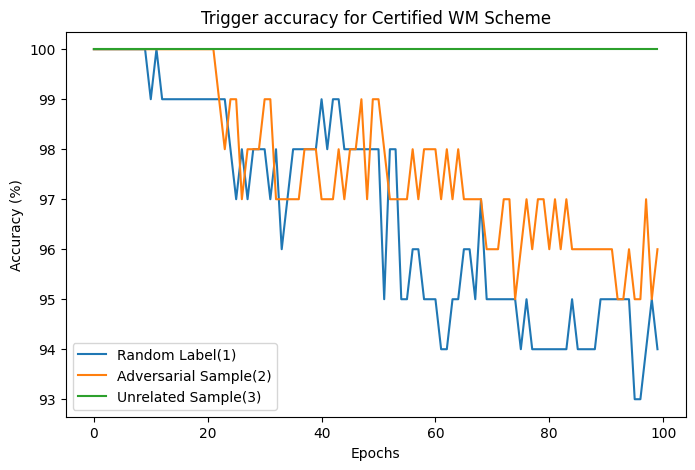

In [41]:
plt.figure(figsize=(8, 5))

plt.plot(range(len(metricscertifiedrand['trigger_acc'])), metricscertifiedrand['trigger_acc'], label='Random Label(1)')
plt.plot(range(len(metricscertifiedadv['trigger_acc'])), metricscertifiedadv['trigger_acc'], label='Adversarial Sample(2)')
plt.plot(range(len(metricscertifiedunrl['trigger_acc'])), metricscertifiedunrl['trigger_acc'], label='Unrelated Sample(3)')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Trigger accuracy for Certified WM Scheme')
plt.legend()
plt.savefig('incre_trigger_acc_8020_certified_6.png')

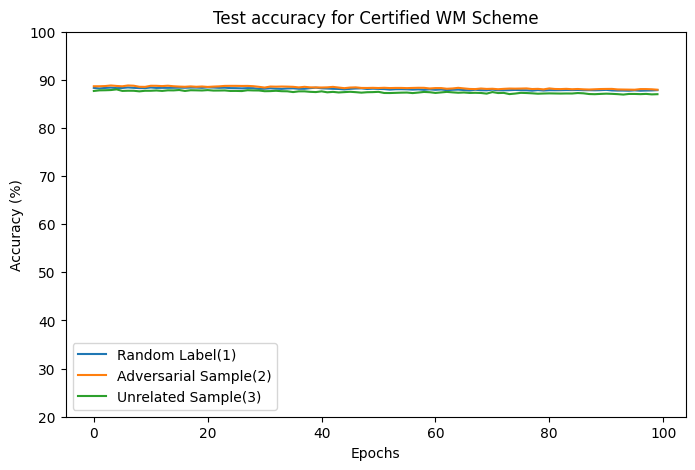

In [42]:
plt.figure(figsize=(8, 5))

plt.plot(range(len(metricscertifiedrand['val_acc'])), metricscertifiedrand['val_acc'], label='Random Label(1)')
plt.plot(range(len(metricscertifiedadv['val_acc'])), metricscertifiedadv['val_acc'], label='Adversarial Sample(2)')
plt.plot(range(len(metricscertifiedunrl['val_acc'])), metricscertifiedunrl['val_acc'], label='Unrelated Sample(3)')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test accuracy for Certified WM Scheme')
plt.ylim([20, 100])
plt.legend()
plt.savefig('incre_test_acc_8020_certified_6.png')

Run 3

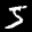

torch.Size([3, 32, 32])


In [43]:
batch_size_train = 256
batch_size_test = 256
batch_size_wm = 64

trainset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/train/', transform=transform_train)
incset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/train_incre/', transform=transform_train)
testset = datasets.ImageFolder('./data/CIFAR10_8020/test', transform=transform_test)
# valset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/val/', transform=transform_test)
watermarkset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/trigger_random/', transform=transform_test)
advwatermarkset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/trigger_adv/', transform=transform_test)

unrelatedset = watermark_unrelated(count=100)
train_watermark_mixset = torch.utils.data.ConcatDataset((trainset,unrelatedset))


# testset = torchvision.datasets.CIFAR10(
#     root='./data', train=False, download=True, transform=transform_test)

unrelatedloader = torch.utils.data.DataLoader(
    unrelatedset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=8)

# valloader = torch.utils.data.DataLoader(
#     valset, batch_size=batch_size_test, shuffle=False, num_workers=8)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

incloader = torch.utils.data.DataLoader(
    incset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

wmloader = torch.utils.data.DataLoader(
    watermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
advwmloader = torch.utils.data.DataLoader(
    advwatermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
train_watermark_loader = torch.utils.data.DataLoader(
    train_watermark_mixset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

In [44]:
netoriginalrand = ResNet18()
netoriginalrand.load_state_dict(torch.load('./checkpoints/resnet18_wm_8020_rand.ckpt'))
netoriginaladv = ResNet18()
netoriginaladv.load_state_dict(torch.load('./checkpoints/resnet18_wm_8020_adv.ckpt'))
netoriginalunrl = ResNet18()
netoriginalunrl.load_state_dict(torch.load('./checkpoints/resnet18_wm_8020_unrl.ckpt'))

netuniformrand = ResNet18()
netuniformrand.load_state_dict(torch.load('./checkpoints/resnet18_wm_frozen_8020_rand.ckpt'))
netuniformadv = ResNet18()
netuniformadv.load_state_dict(torch.load('./checkpoints/resnet18_wm_frozen_8020_adv.ckpt'))
netuniformunrl = ResNet18()
netuniformunrl.load_state_dict(torch.load('./checkpoints/resnet18_wm_frozen_8020_unrl.ckpt'))


<All keys matched successfully>

In [45]:
logcmt = f"incre_train_baseline_8020"

optimizeroriginalrand = torch.optim.SGD(lr=0.001, params=netoriginalrand.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

traineroriginalrand = Trainer(netoriginalrand, criterion, optimizeroriginalrand, incloader)
evaluatororiginalrand = Evaluator(netoriginalrand, criterion)

metricsoriginalrand = train(traineroriginalrand, evaluatororiginalrand, testloader, savename='inccheckpoints/incre_train_baseline_8020_rand', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

Start Training...


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.90it/s]


Epoch 0 | Time 9s| Train Loss 0.4356 | Train Acc 87.04| Val Loss 0.452 | Val Acc 86.89| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.53it/s]


Epoch 1 | Time 22s| Train Loss 0.4031 | Train Acc 87.75| Val Loss 0.451 | Val Acc 86.75| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 2 | Time 32s| Train Loss 0.3867 | Train Acc 88.21| Val Loss 0.435 | Val Acc 87.17| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.60it/s]


Epoch 3 | Time 42s| Train Loss 0.3668 | Train Acc 88.43| Val Loss 0.428 | Val Acc 87.31| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 4 | Time 53s| Train Loss 0.3503 | Train Acc 88.35| Val Loss 0.423 | Val Acc 87.18| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.85it/s]


Epoch 5 | Time 63s| Train Loss 0.3328 | Train Acc 89.05| Val Loss 0.423 | Val Acc 87.07| Trigger Loss 0.008 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 6 | Time 73s| Train Loss 0.3258 | Train Acc 89.49| Val Loss 0.413 | Val Acc 87.40| Trigger Loss 0.010 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 7 | Time 83s| Train Loss 0.3151 | Train Acc 89.24| Val Loss 0.414 | Val Acc 87.26| Trigger Loss 0.012 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 8 | Time 94s| Train Loss 0.3078 | Train Acc 89.73| Val Loss 0.410 | Val Acc 87.29| Trigger Loss 0.019 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.26it/s]


Epoch 9 | Time 103s| Train Loss 0.3000 | Train Acc 89.89| Val Loss 0.408 | Val Acc 87.48| Trigger Loss 0.011 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 10 | Time 114s| Train Loss 0.2913 | Train Acc 90.25| Val Loss 0.412 | Val Acc 87.11| Trigger Loss 0.018 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.85it/s]


Epoch 11 | Time 124s| Train Loss 0.2879 | Train Acc 90.33| Val Loss 0.410 | Val Acc 87.05| Trigger Loss 0.020 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 12 | Time 134s| Train Loss 0.2798 | Train Acc 90.38| Val Loss 0.411 | Val Acc 87.23| Trigger Loss 0.024 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.85it/s]


Epoch 13 | Time 144s| Train Loss 0.2818 | Train Acc 90.47| Val Loss 0.411 | Val Acc 87.16| Trigger Loss 0.035 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 14 | Time 154s| Train Loss 0.2726 | Train Acc 90.62| Val Loss 0.410 | Val Acc 87.14| Trigger Loss 0.027 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.90it/s]


Epoch 15 | Time 164s| Train Loss 0.2687 | Train Acc 90.77| Val Loss 0.409 | Val Acc 87.03| Trigger Loss 0.029 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 16 | Time 174s| Train Loss 0.2564 | Train Acc 91.33| Val Loss 0.408 | Val Acc 87.00| Trigger Loss 0.038 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.81it/s]


Epoch 17 | Time 184s| Train Loss 0.2544 | Train Acc 91.25| Val Loss 0.408 | Val Acc 87.08| Trigger Loss 0.048 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 18 | Time 194s| Train Loss 0.2556 | Train Acc 91.37| Val Loss 0.412 | Val Acc 87.04| Trigger Loss 0.031 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.74it/s]


Epoch 19 | Time 204s| Train Loss 0.2487 | Train Acc 91.51| Val Loss 0.409 | Val Acc 87.06| Trigger Loss 0.034 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 20 | Time 214s| Train Loss 0.2484 | Train Acc 91.40| Val Loss 0.411 | Val Acc 87.06| Trigger Loss 0.039 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.57it/s]


Epoch 21 | Time 224s| Train Loss 0.2385 | Train Acc 91.86| Val Loss 0.412 | Val Acc 86.93| Trigger Loss 0.040 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 22 | Time 234s| Train Loss 0.2360 | Train Acc 91.91| Val Loss 0.415 | Val Acc 86.92| Trigger Loss 0.047 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 23 | Time 245s| Train Loss 0.2360 | Train Acc 91.96| Val Loss 0.415 | Val Acc 86.94| Trigger Loss 0.039 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.49it/s]


Epoch 24 | Time 255s| Train Loss 0.2290 | Train Acc 91.82| Val Loss 0.420 | Val Acc 86.78| Trigger Loss 0.049 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 25 | Time 265s| Train Loss 0.2273 | Train Acc 92.17| Val Loss 0.414 | Val Acc 87.07| Trigger Loss 0.034 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.58it/s]


Epoch 26 | Time 275s| Train Loss 0.2265 | Train Acc 92.23| Val Loss 0.417 | Val Acc 86.82| Trigger Loss 0.034 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 27 | Time 286s| Train Loss 0.2200 | Train Acc 92.55| Val Loss 0.417 | Val Acc 87.02| Trigger Loss 0.027 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.66it/s]


Epoch 28 | Time 295s| Train Loss 0.2176 | Train Acc 92.84| Val Loss 0.419 | Val Acc 86.90| Trigger Loss 0.044 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 29 | Time 305s| Train Loss 0.2165 | Train Acc 92.69| Val Loss 0.424 | Val Acc 86.88| Trigger Loss 0.031 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.68it/s]


Epoch 30 | Time 315s| Train Loss 0.2066 | Train Acc 93.03| Val Loss 0.422 | Val Acc 87.03| Trigger Loss 0.054 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 31 | Time 325s| Train Loss 0.2079 | Train Acc 93.00| Val Loss 0.426 | Val Acc 86.97| Trigger Loss 0.066 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.66it/s]


Epoch 32 | Time 335s| Train Loss 0.2067 | Train Acc 93.20| Val Loss 0.429 | Val Acc 86.83| Trigger Loss 0.056 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 33 | Time 345s| Train Loss 0.1967 | Train Acc 93.30| Val Loss 0.428 | Val Acc 86.91| Trigger Loss 0.047 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.71it/s]


Epoch 34 | Time 355s| Train Loss 0.1978 | Train Acc 93.29| Val Loss 0.428 | Val Acc 86.88| Trigger Loss 0.052 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 35 | Time 365s| Train Loss 0.1978 | Train Acc 93.30| Val Loss 0.427 | Val Acc 86.92| Trigger Loss 0.059 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.73it/s]


Epoch 36 | Time 375s| Train Loss 0.1890 | Train Acc 93.58| Val Loss 0.428 | Val Acc 86.99| Trigger Loss 0.060 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 37 | Time 385s| Train Loss 0.1923 | Train Acc 93.65| Val Loss 0.431 | Val Acc 86.82| Trigger Loss 0.061 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.83it/s]


Epoch 38 | Time 395s| Train Loss 0.1851 | Train Acc 93.82| Val Loss 0.439 | Val Acc 86.49| Trigger Loss 0.070 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 39 | Time 405s| Train Loss 0.1835 | Train Acc 94.02| Val Loss 0.438 | Val Acc 86.87| Trigger Loss 0.072 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.98it/s]


Epoch 40 | Time 415s| Train Loss 0.1811 | Train Acc 94.11| Val Loss 0.438 | Val Acc 86.57| Trigger Loss 0.046 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 41 | Time 425s| Train Loss 0.1770 | Train Acc 94.06| Val Loss 0.441 | Val Acc 86.66| Trigger Loss 0.052 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.13it/s]


Epoch 42 | Time 435s| Train Loss 0.1691 | Train Acc 94.57| Val Loss 0.440 | Val Acc 86.74| Trigger Loss 0.041 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 43 | Time 445s| Train Loss 0.1761 | Train Acc 94.07| Val Loss 0.445 | Val Acc 86.61| Trigger Loss 0.073 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 44 | Time 454s| Train Loss 0.1705 | Train Acc 94.32| Val Loss 0.447 | Val Acc 86.62| Trigger Loss 0.078 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 45 | Time 465s| Train Loss 0.1685 | Train Acc 94.45| Val Loss 0.449 | Val Acc 86.69| Trigger Loss 0.070 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 46 | Time 474s| Train Loss 0.1634 | Train Acc 94.59| Val Loss 0.448 | Val Acc 86.63| Trigger Loss 0.069 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 47 | Time 484s| Train Loss 0.1612 | Train Acc 94.49| Val Loss 0.449 | Val Acc 86.61| Trigger Loss 0.066 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 48 | Time 494s| Train Loss 0.1556 | Train Acc 94.84| Val Loss 0.452 | Val Acc 86.73| Trigger Loss 0.079 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 49 | Time 504s| Train Loss 0.1554 | Train Acc 94.76| Val Loss 0.455 | Val Acc 86.70| Trigger Loss 0.109 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.29it/s]


Epoch 50 | Time 513s| Train Loss 0.1506 | Train Acc 94.90| Val Loss 0.457 | Val Acc 86.78| Trigger Loss 0.104 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 51 | Time 524s| Train Loss 0.1539 | Train Acc 94.69| Val Loss 0.460 | Val Acc 86.50| Trigger Loss 0.106 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.31it/s]


Epoch 52 | Time 533s| Train Loss 0.1502 | Train Acc 95.09| Val Loss 0.463 | Val Acc 86.52| Trigger Loss 0.088 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 53 | Time 543s| Train Loss 0.1468 | Train Acc 95.09| Val Loss 0.460 | Val Acc 86.71| Trigger Loss 0.102 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.19it/s]


Epoch 54 | Time 552s| Train Loss 0.1422 | Train Acc 95.43| Val Loss 0.465 | Val Acc 86.72| Trigger Loss 0.076 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 55 | Time 563s| Train Loss 0.1430 | Train Acc 95.51| Val Loss 0.467 | Val Acc 86.35| Trigger Loss 0.088 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.29it/s]


Epoch 56 | Time 572s| Train Loss 0.1410 | Train Acc 95.50| Val Loss 0.467 | Val Acc 86.60| Trigger Loss 0.098 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 57 | Time 582s| Train Loss 0.1410 | Train Acc 95.18| Val Loss 0.470 | Val Acc 86.49| Trigger Loss 0.084 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.24it/s]


Epoch 58 | Time 592s| Train Loss 0.1338 | Train Acc 95.58| Val Loss 0.470 | Val Acc 86.71| Trigger Loss 0.118 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 59 | Time 602s| Train Loss 0.1298 | Train Acc 95.99| Val Loss 0.472 | Val Acc 86.70| Trigger Loss 0.090 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.26it/s]


Epoch 60 | Time 611s| Train Loss 0.1303 | Train Acc 95.54| Val Loss 0.475 | Val Acc 86.48| Trigger Loss 0.108 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 61 | Time 622s| Train Loss 0.1255 | Train Acc 95.79| Val Loss 0.480 | Val Acc 86.45| Trigger Loss 0.114 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.18it/s]


Epoch 62 | Time 631s| Train Loss 0.1224 | Train Acc 96.09| Val Loss 0.486 | Val Acc 86.35| Trigger Loss 0.152 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 63 | Time 641s| Train Loss 0.1255 | Train Acc 95.86| Val Loss 0.481 | Val Acc 86.46| Trigger Loss 0.117 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.13it/s]


Epoch 64 | Time 651s| Train Loss 0.1177 | Train Acc 96.34| Val Loss 0.481 | Val Acc 86.39| Trigger Loss 0.136 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 65 | Time 661s| Train Loss 0.1145 | Train Acc 96.45| Val Loss 0.487 | Val Acc 86.50| Trigger Loss 0.117 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.15it/s]


Epoch 66 | Time 670s| Train Loss 0.1154 | Train Acc 96.22| Val Loss 0.498 | Val Acc 86.23| Trigger Loss 0.125 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 67 | Time 681s| Train Loss 0.1164 | Train Acc 96.27| Val Loss 0.498 | Val Acc 86.22| Trigger Loss 0.105 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.30it/s]


Epoch 68 | Time 690s| Train Loss 0.1191 | Train Acc 96.16| Val Loss 0.508 | Val Acc 86.06| Trigger Loss 0.161 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 69 | Time 700s| Train Loss 0.1112 | Train Acc 96.08| Val Loss 0.511 | Val Acc 86.12| Trigger Loss 0.126 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.24it/s]


Epoch 70 | Time 710s| Train Loss 0.1084 | Train Acc 96.36| Val Loss 0.505 | Val Acc 86.01| Trigger Loss 0.123 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 71 | Time 720s| Train Loss 0.1065 | Train Acc 96.56| Val Loss 0.507 | Val Acc 86.37| Trigger Loss 0.124 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.19it/s]


Epoch 72 | Time 729s| Train Loss 0.1021 | Train Acc 96.83| Val Loss 0.506 | Val Acc 86.30| Trigger Loss 0.149 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 73 | Time 740s| Train Loss 0.1028 | Train Acc 96.71| Val Loss 0.509 | Val Acc 86.21| Trigger Loss 0.165 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:05<00:00,  6.56it/s]


Epoch 74 | Time 749s| Train Loss 0.1036 | Train Acc 96.55| Val Loss 0.509 | Val Acc 86.31| Trigger Loss 0.158 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 75 | Time 759s| Train Loss 0.1017 | Train Acc 96.83| Val Loss 0.511 | Val Acc 86.16| Trigger Loss 0.148 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.48it/s]


Epoch 76 | Time 768s| Train Loss 0.0976 | Train Acc 96.80| Val Loss 0.515 | Val Acc 86.25| Trigger Loss 0.179 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 77 | Time 779s| Train Loss 0.0962 | Train Acc 96.89| Val Loss 0.520 | Val Acc 86.29| Trigger Loss 0.136 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.37it/s]


Epoch 78 | Time 788s| Train Loss 0.0898 | Train Acc 97.15| Val Loss 0.525 | Val Acc 86.10| Trigger Loss 0.144 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 79 | Time 798s| Train Loss 0.0928 | Train Acc 97.23| Val Loss 0.523 | Val Acc 86.26| Trigger Loss 0.172 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.27it/s]


Epoch 80 | Time 808s| Train Loss 0.0904 | Train Acc 97.29| Val Loss 0.526 | Val Acc 86.38| Trigger Loss 0.142 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 81 | Time 818s| Train Loss 0.0881 | Train Acc 97.37| Val Loss 0.533 | Val Acc 86.19| Trigger Loss 0.165 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.17it/s]


Epoch 82 | Time 827s| Train Loss 0.0890 | Train Acc 97.11| Val Loss 0.533 | Val Acc 86.13| Trigger Loss 0.194 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 83 | Time 838s| Train Loss 0.0861 | Train Acc 97.49| Val Loss 0.538 | Val Acc 85.98| Trigger Loss 0.201 | Trigger Acc 92.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.02it/s]


Epoch 84 | Time 847s| Train Loss 0.0842 | Train Acc 97.26| Val Loss 0.538 | Val Acc 86.15| Trigger Loss 0.199 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 85 | Time 858s| Train Loss 0.0848 | Train Acc 97.32| Val Loss 0.539 | Val Acc 86.33| Trigger Loss 0.188 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.89it/s]


Epoch 86 | Time 867s| Train Loss 0.0797 | Train Acc 97.45| Val Loss 0.543 | Val Acc 85.86| Trigger Loss 0.167 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 87 | Time 877s| Train Loss 0.0823 | Train Acc 97.44| Val Loss 0.546 | Val Acc 85.97| Trigger Loss 0.202 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.68it/s]


Epoch 88 | Time 886s| Train Loss 0.0800 | Train Acc 97.54| Val Loss 0.547 | Val Acc 85.90| Trigger Loss 0.191 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 89 | Time 897s| Train Loss 0.0775 | Train Acc 97.62| Val Loss 0.554 | Val Acc 85.92| Trigger Loss 0.238 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.66it/s]


Epoch 90 | Time 906s| Train Loss 0.0775 | Train Acc 97.78| Val Loss 0.552 | Val Acc 85.95| Trigger Loss 0.225 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 91 | Time 916s| Train Loss 0.0697 | Train Acc 97.97| Val Loss 0.548 | Val Acc 86.10| Trigger Loss 0.268 | Trigger Acc 91.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.62it/s]


Epoch 92 | Time 926s| Train Loss 0.0738 | Train Acc 97.56| Val Loss 0.555 | Val Acc 85.82| Trigger Loss 0.290 | Trigger Acc 91.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 93 | Time 936s| Train Loss 0.0700 | Train Acc 98.01| Val Loss 0.556 | Val Acc 85.97| Trigger Loss 0.283 | Trigger Acc 91.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.69it/s]


Epoch 94 | Time 945s| Train Loss 0.0699 | Train Acc 97.88| Val Loss 0.559 | Val Acc 86.07| Trigger Loss 0.289 | Trigger Acc 91.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 95 | Time 955s| Train Loss 0.0711 | Train Acc 97.74| Val Loss 0.565 | Val Acc 85.96| Trigger Loss 0.294 | Trigger Acc 88.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.65it/s]


Epoch 96 | Time 964s| Train Loss 0.0647 | Train Acc 98.24| Val Loss 0.562 | Val Acc 85.89| Trigger Loss 0.261 | Trigger Acc 91.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 97 | Time 975s| Train Loss 0.0626 | Train Acc 98.23| Val Loss 0.559 | Val Acc 86.21| Trigger Loss 0.270 | Trigger Acc 90.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.58it/s]


Epoch 98 | Time 984s| Train Loss 0.0655 | Train Acc 98.02| Val Loss 0.564 | Val Acc 85.95| Trigger Loss 0.252 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 99 | Time 994s| Train Loss 0.0619 | Train Acc 98.04| Val Loss 0.567 | Val Acc 86.07| Trigger Loss 0.291 | Trigger Acc 89.00


In [46]:
logcmt = f"incre_train_baseline_8020"

optimizeroriginaladv = torch.optim.SGD(lr=0.001, params=netoriginaladv.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

traineroriginaladv = Trainer(netoriginaladv, criterion, optimizeroriginaladv, incloader)
evaluatororiginaladv = Evaluator(netoriginaladv, criterion)

metricsoriginaladv = train(traineroriginaladv, evaluatororiginaladv, testloader, savename='inccheckpoints/incre_train_baseline_8020_adv', logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader, epochs=100)

Start Training...


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.64it/s]


Epoch 0 | Time 9s| Train Loss 0.4422 | Train Acc 87.06| Val Loss 0.479 | Val Acc 86.73| Trigger Loss 0.023 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.39it/s]


Epoch 1 | Time 22s| Train Loss 0.4054 | Train Acc 87.56| Val Loss 0.452 | Val Acc 87.03| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.27it/s]


Epoch 2 | Time 31s| Train Loss 0.3881 | Train Acc 87.41| Val Loss 0.445 | Val Acc 87.01| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 3 | Time 42s| Train Loss 0.3682 | Train Acc 88.44| Val Loss 0.437 | Val Acc 87.33| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.15it/s]


Epoch 4 | Time 52s| Train Loss 0.3562 | Train Acc 88.18| Val Loss 0.430 | Val Acc 86.89| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 5 | Time 62s| Train Loss 0.3358 | Train Acc 88.74| Val Loss 0.425 | Val Acc 87.23| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.92it/s]


Epoch 6 | Time 72s| Train Loss 0.3205 | Train Acc 89.32| Val Loss 0.419 | Val Acc 87.30| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 7 | Time 82s| Train Loss 0.3165 | Train Acc 89.35| Val Loss 0.418 | Val Acc 87.46| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.80it/s]


Epoch 8 | Time 92s| Train Loss 0.3114 | Train Acc 89.42| Val Loss 0.414 | Val Acc 87.43| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 9 | Time 103s| Train Loss 0.2994 | Train Acc 89.85| Val Loss 0.416 | Val Acc 87.17| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 10 | Time 113s| Train Loss 0.2916 | Train Acc 90.32| Val Loss 0.409 | Val Acc 87.25| Trigger Loss 0.007 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.56it/s]


Epoch 11 | Time 123s| Train Loss 0.2865 | Train Acc 90.21| Val Loss 0.411 | Val Acc 87.28| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 12 | Time 134s| Train Loss 0.2884 | Train Acc 90.07| Val Loss 0.410 | Val Acc 87.25| Trigger Loss 0.007 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.66it/s]


Epoch 13 | Time 143s| Train Loss 0.2786 | Train Acc 90.47| Val Loss 0.411 | Val Acc 87.32| Trigger Loss 0.008 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 14 | Time 154s| Train Loss 0.2772 | Train Acc 90.62| Val Loss 0.411 | Val Acc 87.37| Trigger Loss 0.010 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.89it/s]


Epoch 15 | Time 164s| Train Loss 0.2701 | Train Acc 90.92| Val Loss 0.412 | Val Acc 87.13| Trigger Loss 0.008 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 16 | Time 175s| Train Loss 0.2705 | Train Acc 90.69| Val Loss 0.409 | Val Acc 87.33| Trigger Loss 0.009 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.27it/s]


Epoch 17 | Time 184s| Train Loss 0.2596 | Train Acc 90.90| Val Loss 0.409 | Val Acc 87.26| Trigger Loss 0.011 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 18 | Time 195s| Train Loss 0.2494 | Train Acc 91.27| Val Loss 0.410 | Val Acc 87.33| Trigger Loss 0.012 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.24it/s]


Epoch 19 | Time 204s| Train Loss 0.2498 | Train Acc 91.61| Val Loss 0.415 | Val Acc 87.02| Trigger Loss 0.012 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 20 | Time 215s| Train Loss 0.2499 | Train Acc 91.59| Val Loss 0.413 | Val Acc 87.20| Trigger Loss 0.012 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.10it/s]


Epoch 21 | Time 225s| Train Loss 0.2389 | Train Acc 91.86| Val Loss 0.413 | Val Acc 87.33| Trigger Loss 0.011 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 22 | Time 235s| Train Loss 0.2340 | Train Acc 92.16| Val Loss 0.417 | Val Acc 87.33| Trigger Loss 0.014 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.93it/s]


Epoch 23 | Time 245s| Train Loss 0.2286 | Train Acc 92.32| Val Loss 0.418 | Val Acc 87.02| Trigger Loss 0.019 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 24 | Time 255s| Train Loss 0.2321 | Train Acc 91.94| Val Loss 0.417 | Val Acc 87.26| Trigger Loss 0.012 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.84it/s]


Epoch 25 | Time 265s| Train Loss 0.2247 | Train Acc 92.22| Val Loss 0.415 | Val Acc 87.31| Trigger Loss 0.016 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 26 | Time 276s| Train Loss 0.2214 | Train Acc 92.56| Val Loss 0.418 | Val Acc 87.23| Trigger Loss 0.018 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 27 | Time 287s| Train Loss 0.2216 | Train Acc 92.42| Val Loss 0.419 | Val Acc 87.28| Trigger Loss 0.016 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.62it/s]


Epoch 28 | Time 296s| Train Loss 0.2204 | Train Acc 92.46| Val Loss 0.420 | Val Acc 87.15| Trigger Loss 0.015 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 29 | Time 307s| Train Loss 0.2208 | Train Acc 92.61| Val Loss 0.420 | Val Acc 87.22| Trigger Loss 0.015 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.64it/s]


Epoch 30 | Time 316s| Train Loss 0.2130 | Train Acc 92.51| Val Loss 0.423 | Val Acc 87.14| Trigger Loss 0.018 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 31 | Time 327s| Train Loss 0.2018 | Train Acc 93.02| Val Loss 0.423 | Val Acc 87.19| Trigger Loss 0.016 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.06it/s]


Epoch 32 | Time 337s| Train Loss 0.2006 | Train Acc 93.32| Val Loss 0.432 | Val Acc 86.99| Trigger Loss 0.022 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 33 | Time 347s| Train Loss 0.1970 | Train Acc 93.11| Val Loss 0.425 | Val Acc 87.09| Trigger Loss 0.021 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.25it/s]


Epoch 34 | Time 357s| Train Loss 0.1957 | Train Acc 93.55| Val Loss 0.427 | Val Acc 87.20| Trigger Loss 0.022 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 35 | Time 368s| Train Loss 0.1939 | Train Acc 93.40| Val Loss 0.428 | Val Acc 86.99| Trigger Loss 0.033 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 36 | Time 377s| Train Loss 0.1970 | Train Acc 93.27| Val Loss 0.429 | Val Acc 87.06| Trigger Loss 0.030 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 37 | Time 388s| Train Loss 0.1804 | Train Acc 93.88| Val Loss 0.431 | Val Acc 87.02| Trigger Loss 0.030 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 38 | Time 397s| Train Loss 0.1781 | Train Acc 93.79| Val Loss 0.433 | Val Acc 86.98| Trigger Loss 0.021 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 39 | Time 408s| Train Loss 0.1851 | Train Acc 93.66| Val Loss 0.435 | Val Acc 86.91| Trigger Loss 0.024 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.85it/s]


Epoch 40 | Time 418s| Train Loss 0.1745 | Train Acc 94.21| Val Loss 0.439 | Val Acc 86.86| Trigger Loss 0.033 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 41 | Time 428s| Train Loss 0.1806 | Train Acc 93.87| Val Loss 0.447 | Val Acc 86.82| Trigger Loss 0.029 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.87it/s]


Epoch 42 | Time 438s| Train Loss 0.1788 | Train Acc 93.85| Val Loss 0.445 | Val Acc 87.02| Trigger Loss 0.030 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.28it/s]


Epoch 43 | Time 448s| Train Loss 0.1645 | Train Acc 94.54| Val Loss 0.446 | Val Acc 86.97| Trigger Loss 0.030 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.68it/s]


Epoch 44 | Time 458s| Train Loss 0.1670 | Train Acc 94.51| Val Loss 0.452 | Val Acc 86.75| Trigger Loss 0.034 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 45 | Time 469s| Train Loss 0.1681 | Train Acc 94.21| Val Loss 0.449 | Val Acc 86.90| Trigger Loss 0.035 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 46 | Time 479s| Train Loss 0.1634 | Train Acc 94.50| Val Loss 0.453 | Val Acc 86.89| Trigger Loss 0.022 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.57it/s]


Epoch 47 | Time 489s| Train Loss 0.1617 | Train Acc 94.40| Val Loss 0.454 | Val Acc 86.72| Trigger Loss 0.053 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 48 | Time 499s| Train Loss 0.1578 | Train Acc 94.62| Val Loss 0.451 | Val Acc 86.88| Trigger Loss 0.059 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.63it/s]


Epoch 49 | Time 509s| Train Loss 0.1571 | Train Acc 94.72| Val Loss 0.457 | Val Acc 86.67| Trigger Loss 0.050 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 50 | Time 519s| Train Loss 0.1552 | Train Acc 94.85| Val Loss 0.457 | Val Acc 86.72| Trigger Loss 0.053 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.63it/s]


Epoch 51 | Time 528s| Train Loss 0.1472 | Train Acc 95.19| Val Loss 0.462 | Val Acc 86.69| Trigger Loss 0.063 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 52 | Time 539s| Train Loss 0.1492 | Train Acc 95.18| Val Loss 0.468 | Val Acc 86.84| Trigger Loss 0.049 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.68it/s]


Epoch 53 | Time 548s| Train Loss 0.1533 | Train Acc 94.58| Val Loss 0.465 | Val Acc 86.73| Trigger Loss 0.056 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 54 | Time 558s| Train Loss 0.1441 | Train Acc 95.09| Val Loss 0.462 | Val Acc 86.70| Trigger Loss 0.048 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.63it/s]


Epoch 55 | Time 567s| Train Loss 0.1430 | Train Acc 95.31| Val Loss 0.471 | Val Acc 86.62| Trigger Loss 0.051 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 56 | Time 578s| Train Loss 0.1400 | Train Acc 95.37| Val Loss 0.470 | Val Acc 86.74| Trigger Loss 0.049 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.64it/s]


Epoch 57 | Time 587s| Train Loss 0.1395 | Train Acc 95.41| Val Loss 0.478 | Val Acc 86.49| Trigger Loss 0.056 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 58 | Time 598s| Train Loss 0.1315 | Train Acc 95.63| Val Loss 0.478 | Val Acc 86.42| Trigger Loss 0.057 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.63it/s]


Epoch 59 | Time 607s| Train Loss 0.1338 | Train Acc 95.26| Val Loss 0.478 | Val Acc 86.68| Trigger Loss 0.046 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 60 | Time 617s| Train Loss 0.1322 | Train Acc 95.50| Val Loss 0.484 | Val Acc 86.43| Trigger Loss 0.043 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.66it/s]


Epoch 61 | Time 627s| Train Loss 0.1232 | Train Acc 95.91| Val Loss 0.487 | Val Acc 86.42| Trigger Loss 0.058 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 62 | Time 637s| Train Loss 0.1252 | Train Acc 96.27| Val Loss 0.491 | Val Acc 86.48| Trigger Loss 0.069 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.69it/s]


Epoch 63 | Time 647s| Train Loss 0.1259 | Train Acc 95.88| Val Loss 0.491 | Val Acc 86.44| Trigger Loss 0.056 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 64 | Time 657s| Train Loss 0.1189 | Train Acc 96.14| Val Loss 0.502 | Val Acc 86.35| Trigger Loss 0.051 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.77it/s]


Epoch 65 | Time 667s| Train Loss 0.1213 | Train Acc 95.77| Val Loss 0.496 | Val Acc 86.51| Trigger Loss 0.081 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 66 | Time 678s| Train Loss 0.1215 | Train Acc 95.96| Val Loss 0.494 | Val Acc 86.53| Trigger Loss 0.078 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.86it/s]


Epoch 67 | Time 687s| Train Loss 0.1132 | Train Acc 96.34| Val Loss 0.499 | Val Acc 86.57| Trigger Loss 0.094 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 68 | Time 698s| Train Loss 0.1094 | Train Acc 96.68| Val Loss 0.503 | Val Acc 86.29| Trigger Loss 0.107 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.97it/s]


Epoch 69 | Time 707s| Train Loss 0.1085 | Train Acc 96.40| Val Loss 0.503 | Val Acc 86.47| Trigger Loss 0.080 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 70 | Time 718s| Train Loss 0.1044 | Train Acc 96.89| Val Loss 0.501 | Val Acc 86.43| Trigger Loss 0.091 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.13it/s]


Epoch 71 | Time 727s| Train Loss 0.1073 | Train Acc 96.53| Val Loss 0.508 | Val Acc 86.54| Trigger Loss 0.083 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 72 | Time 737s| Train Loss 0.1009 | Train Acc 96.93| Val Loss 0.513 | Val Acc 86.54| Trigger Loss 0.074 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.28it/s]


Epoch 73 | Time 747s| Train Loss 0.0955 | Train Acc 97.11| Val Loss 0.514 | Val Acc 86.35| Trigger Loss 0.097 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 74 | Time 757s| Train Loss 0.1019 | Train Acc 96.68| Val Loss 0.514 | Val Acc 86.30| Trigger Loss 0.088 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.19it/s]


Epoch 75 | Time 766s| Train Loss 0.1030 | Train Acc 96.85| Val Loss 0.521 | Val Acc 86.35| Trigger Loss 0.102 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 76 | Time 777s| Train Loss 0.0985 | Train Acc 96.88| Val Loss 0.520 | Val Acc 86.47| Trigger Loss 0.078 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 77 | Time 786s| Train Loss 0.0963 | Train Acc 96.87| Val Loss 0.524 | Val Acc 86.48| Trigger Loss 0.130 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 78 | Time 796s| Train Loss 0.0953 | Train Acc 96.99| Val Loss 0.523 | Val Acc 86.54| Trigger Loss 0.121 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.25it/s]


Epoch 79 | Time 806s| Train Loss 0.0883 | Train Acc 97.06| Val Loss 0.521 | Val Acc 86.41| Trigger Loss 0.114 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 80 | Time 816s| Train Loss 0.0890 | Train Acc 97.22| Val Loss 0.527 | Val Acc 86.28| Trigger Loss 0.122 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.25it/s]


Epoch 81 | Time 825s| Train Loss 0.0890 | Train Acc 97.16| Val Loss 0.529 | Val Acc 86.21| Trigger Loss 0.118 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 82 | Time 836s| Train Loss 0.0912 | Train Acc 97.21| Val Loss 0.534 | Val Acc 86.40| Trigger Loss 0.102 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.19it/s]


Epoch 83 | Time 845s| Train Loss 0.0885 | Train Acc 97.21| Val Loss 0.531 | Val Acc 86.24| Trigger Loss 0.094 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 84 | Time 855s| Train Loss 0.0848 | Train Acc 97.36| Val Loss 0.537 | Val Acc 86.16| Trigger Loss 0.156 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 85 | Time 865s| Train Loss 0.0796 | Train Acc 97.47| Val Loss 0.541 | Val Acc 86.13| Trigger Loss 0.155 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 86 | Time 875s| Train Loss 0.0805 | Train Acc 97.48| Val Loss 0.543 | Val Acc 86.28| Trigger Loss 0.142 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.29it/s]


Epoch 87 | Time 884s| Train Loss 0.0769 | Train Acc 97.56| Val Loss 0.542 | Val Acc 86.29| Trigger Loss 0.130 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 88 | Time 895s| Train Loss 0.0733 | Train Acc 97.71| Val Loss 0.550 | Val Acc 86.17| Trigger Loss 0.103 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.31it/s]


Epoch 89 | Time 904s| Train Loss 0.0759 | Train Acc 97.66| Val Loss 0.549 | Val Acc 86.35| Trigger Loss 0.118 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 90 | Time 914s| Train Loss 0.0769 | Train Acc 97.61| Val Loss 0.550 | Val Acc 86.22| Trigger Loss 0.108 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.19it/s]


Epoch 91 | Time 924s| Train Loss 0.0755 | Train Acc 97.63| Val Loss 0.556 | Val Acc 86.03| Trigger Loss 0.137 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 92 | Time 934s| Train Loss 0.0692 | Train Acc 97.94| Val Loss 0.558 | Val Acc 86.10| Trigger Loss 0.112 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.19it/s]


Epoch 93 | Time 943s| Train Loss 0.0713 | Train Acc 97.89| Val Loss 0.554 | Val Acc 86.13| Trigger Loss 0.124 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 94 | Time 954s| Train Loss 0.0616 | Train Acc 98.38| Val Loss 0.562 | Val Acc 86.28| Trigger Loss 0.121 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.24it/s]


Epoch 95 | Time 963s| Train Loss 0.0708 | Train Acc 97.82| Val Loss 0.565 | Val Acc 86.29| Trigger Loss 0.160 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 96 | Time 973s| Train Loss 0.0666 | Train Acc 98.13| Val Loss 0.568 | Val Acc 86.08| Trigger Loss 0.162 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.10it/s]


Epoch 97 | Time 983s| Train Loss 0.0697 | Train Acc 97.99| Val Loss 0.567 | Val Acc 86.22| Trigger Loss 0.133 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 98 | Time 993s| Train Loss 0.0616 | Train Acc 98.24| Val Loss 0.572 | Val Acc 85.95| Trigger Loss 0.120 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.05it/s]


Epoch 99 | Time 1003s| Train Loss 0.0633 | Train Acc 98.21| Val Loss 0.573 | Val Acc 86.16| Trigger Loss 0.168 | Trigger Acc 92.00


In [47]:
logcmt = f"incre_train_baseline_8020"

optimizeroriginalunrl = torch.optim.SGD(lr=0.001, params=netoriginalunrl.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

traineroriginalunrl = Trainer(netoriginalunrl, criterion, optimizeroriginalunrl, incloader)
evaluatororiginalunrl = Evaluator(netoriginalunrl, criterion)

metricsoriginalunrl = train(traineroriginalunrl, evaluatororiginalunrl, testloader, savename='inccheckpoints/incre_train_baseline_8020_unrl', logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader, epochs=100)

Start Training...


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 0 | Time 10s| Train Loss 0.4328 | Train Acc 87.05| Val Loss 0.444 | Val Acc 87.51| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.45it/s]


Epoch 1 | Time 23s| Train Loss 0.4028 | Train Acc 87.74| Val Loss 0.430 | Val Acc 87.47| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.57it/s]


Epoch 2 | Time 33s| Train Loss 0.3772 | Train Acc 88.48| Val Loss 0.427 | Val Acc 87.21| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 3 | Time 43s| Train Loss 0.3550 | Train Acc 88.28| Val Loss 0.418 | Val Acc 87.43| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.64it/s]


Epoch 4 | Time 53s| Train Loss 0.3438 | Train Acc 88.82| Val Loss 0.418 | Val Acc 87.34| Trigger Loss 0.007 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.28it/s]


Epoch 5 | Time 63s| Train Loss 0.3335 | Train Acc 89.32| Val Loss 0.411 | Val Acc 87.48| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.85it/s]


Epoch 6 | Time 73s| Train Loss 0.3248 | Train Acc 88.99| Val Loss 0.405 | Val Acc 87.50| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 7 | Time 84s| Train Loss 0.3100 | Train Acc 89.68| Val Loss 0.405 | Val Acc 87.36| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.27it/s]


Epoch 8 | Time 93s| Train Loss 0.3125 | Train Acc 89.53| Val Loss 0.409 | Val Acc 87.42| Trigger Loss 0.027 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 9 | Time 104s| Train Loss 0.2991 | Train Acc 90.07| Val Loss 0.404 | Val Acc 87.51| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.14it/s]


Epoch 10 | Time 113s| Train Loss 0.2957 | Train Acc 90.21| Val Loss 0.406 | Val Acc 87.45| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 11 | Time 124s| Train Loss 0.2868 | Train Acc 90.52| Val Loss 0.402 | Val Acc 87.37| Trigger Loss 0.018 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.15it/s]


Epoch 12 | Time 134s| Train Loss 0.2760 | Train Acc 90.61| Val Loss 0.400 | Val Acc 87.73| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 13 | Time 144s| Train Loss 0.2748 | Train Acc 90.57| Val Loss 0.401 | Val Acc 87.49| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.90it/s]


Epoch 14 | Time 154s| Train Loss 0.2686 | Train Acc 91.29| Val Loss 0.401 | Val Acc 87.52| Trigger Loss 0.007 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 15 | Time 164s| Train Loss 0.2605 | Train Acc 91.06| Val Loss 0.402 | Val Acc 87.57| Trigger Loss 0.013 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.80it/s]


Epoch 16 | Time 174s| Train Loss 0.2624 | Train Acc 91.14| Val Loss 0.402 | Val Acc 87.66| Trigger Loss 0.009 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 17 | Time 185s| Train Loss 0.2606 | Train Acc 91.15| Val Loss 0.410 | Val Acc 87.46| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.63it/s]


Epoch 18 | Time 195s| Train Loss 0.2569 | Train Acc 91.03| Val Loss 0.401 | Val Acc 87.36| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 19 | Time 205s| Train Loss 0.2471 | Train Acc 91.65| Val Loss 0.399 | Val Acc 87.68| Trigger Loss 0.011 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.29it/s]


Epoch 20 | Time 216s| Train Loss 0.2490 | Train Acc 91.68| Val Loss 0.404 | Val Acc 87.41| Trigger Loss 0.027 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.62it/s]


Epoch 21 | Time 226s| Train Loss 0.2421 | Train Acc 91.93| Val Loss 0.411 | Val Acc 87.16| Trigger Loss 0.133 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 22 | Time 236s| Train Loss 0.2346 | Train Acc 91.84| Val Loss 0.404 | Val Acc 87.44| Trigger Loss 0.014 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.65it/s]


Epoch 23 | Time 246s| Train Loss 0.2356 | Train Acc 91.96| Val Loss 0.409 | Val Acc 87.51| Trigger Loss 0.044 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 24 | Time 256s| Train Loss 0.2353 | Train Acc 92.10| Val Loss 0.408 | Val Acc 87.44| Trigger Loss 0.009 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.70it/s]


Epoch 25 | Time 266s| Train Loss 0.2261 | Train Acc 92.26| Val Loss 0.408 | Val Acc 87.29| Trigger Loss 0.008 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 26 | Time 277s| Train Loss 0.2245 | Train Acc 92.63| Val Loss 0.410 | Val Acc 87.36| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.04it/s]


Epoch 27 | Time 286s| Train Loss 0.2259 | Train Acc 92.22| Val Loss 0.411 | Val Acc 87.41| Trigger Loss 0.011 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 28 | Time 297s| Train Loss 0.2199 | Train Acc 92.62| Val Loss 0.411 | Val Acc 87.36| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.26it/s]


Epoch 29 | Time 307s| Train Loss 0.2117 | Train Acc 93.01| Val Loss 0.413 | Val Acc 87.10| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 30 | Time 317s| Train Loss 0.2081 | Train Acc 93.04| Val Loss 0.417 | Val Acc 87.27| Trigger Loss 0.010 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.26it/s]


Epoch 31 | Time 327s| Train Loss 0.2107 | Train Acc 92.68| Val Loss 0.417 | Val Acc 87.41| Trigger Loss 0.022 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 32 | Time 337s| Train Loss 0.2054 | Train Acc 93.21| Val Loss 0.414 | Val Acc 87.20| Trigger Loss 0.009 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.17it/s]


Epoch 33 | Time 347s| Train Loss 0.1978 | Train Acc 93.69| Val Loss 0.421 | Val Acc 87.36| Trigger Loss 0.010 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 34 | Time 358s| Train Loss 0.1964 | Train Acc 93.37| Val Loss 0.423 | Val Acc 87.23| Trigger Loss 0.043 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.87it/s]


Epoch 35 | Time 367s| Train Loss 0.1987 | Train Acc 93.16| Val Loss 0.423 | Val Acc 87.17| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 36 | Time 378s| Train Loss 0.1948 | Train Acc 93.40| Val Loss 0.426 | Val Acc 87.16| Trigger Loss 0.009 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.85it/s]


Epoch 37 | Time 387s| Train Loss 0.1911 | Train Acc 93.77| Val Loss 0.430 | Val Acc 87.09| Trigger Loss 0.012 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 38 | Time 398s| Train Loss 0.1894 | Train Acc 93.73| Val Loss 0.438 | Val Acc 87.06| Trigger Loss 0.017 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.49it/s]


Epoch 39 | Time 408s| Train Loss 0.1899 | Train Acc 93.41| Val Loss 0.431 | Val Acc 86.96| Trigger Loss 0.018 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.52it/s]


Epoch 40 | Time 418s| Train Loss 0.1823 | Train Acc 93.92| Val Loss 0.434 | Val Acc 87.21| Trigger Loss 0.009 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 41 | Time 429s| Train Loss 0.1777 | Train Acc 93.96| Val Loss 0.434 | Val Acc 87.02| Trigger Loss 0.011 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.62it/s]


Epoch 42 | Time 438s| Train Loss 0.1739 | Train Acc 93.99| Val Loss 0.438 | Val Acc 86.75| Trigger Loss 0.014 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 43 | Time 449s| Train Loss 0.1758 | Train Acc 93.98| Val Loss 0.438 | Val Acc 87.07| Trigger Loss 0.012 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.67it/s]


Epoch 44 | Time 459s| Train Loss 0.1710 | Train Acc 94.28| Val Loss 0.440 | Val Acc 87.01| Trigger Loss 0.059 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 45 | Time 469s| Train Loss 0.1664 | Train Acc 94.47| Val Loss 0.443 | Val Acc 87.13| Trigger Loss 0.074 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.68it/s]


Epoch 46 | Time 479s| Train Loss 0.1617 | Train Acc 94.73| Val Loss 0.447 | Val Acc 86.74| Trigger Loss 0.015 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 47 | Time 489s| Train Loss 0.1620 | Train Acc 94.44| Val Loss 0.446 | Val Acc 86.96| Trigger Loss 0.007 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.15it/s]


Epoch 48 | Time 499s| Train Loss 0.1599 | Train Acc 94.68| Val Loss 0.452 | Val Acc 86.88| Trigger Loss 0.007 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 49 | Time 509s| Train Loss 0.1607 | Train Acc 94.66| Val Loss 0.457 | Val Acc 86.79| Trigger Loss 0.121 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.28it/s]


Epoch 50 | Time 519s| Train Loss 0.1560 | Train Acc 94.95| Val Loss 0.458 | Val Acc 86.97| Trigger Loss 0.126 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 51 | Time 529s| Train Loss 0.1557 | Train Acc 94.78| Val Loss 0.459 | Val Acc 86.68| Trigger Loss 0.070 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.18it/s]


Epoch 52 | Time 538s| Train Loss 0.1492 | Train Acc 94.94| Val Loss 0.460 | Val Acc 86.79| Trigger Loss 0.122 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 53 | Time 549s| Train Loss 0.1494 | Train Acc 95.12| Val Loss 0.460 | Val Acc 86.62| Trigger Loss 0.058 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 54 | Time 558s| Train Loss 0.1443 | Train Acc 95.26| Val Loss 0.460 | Val Acc 87.04| Trigger Loss 0.066 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 55 | Time 568s| Train Loss 0.1461 | Train Acc 95.14| Val Loss 0.463 | Val Acc 86.74| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.19it/s]


Epoch 56 | Time 578s| Train Loss 0.1367 | Train Acc 95.36| Val Loss 0.467 | Val Acc 86.60| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 57 | Time 589s| Train Loss 0.1358 | Train Acc 95.37| Val Loss 0.467 | Val Acc 86.90| Trigger Loss 0.013 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.30it/s]


Epoch 58 | Time 598s| Train Loss 0.1353 | Train Acc 95.47| Val Loss 0.474 | Val Acc 86.44| Trigger Loss 0.021 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 59 | Time 609s| Train Loss 0.1299 | Train Acc 95.67| Val Loss 0.475 | Val Acc 86.60| Trigger Loss 0.050 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.02it/s]


Epoch 60 | Time 618s| Train Loss 0.1316 | Train Acc 95.39| Val Loss 0.482 | Val Acc 86.55| Trigger Loss 0.547 | Trigger Acc 90.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 61 | Time 628s| Train Loss 0.1270 | Train Acc 95.63| Val Loss 0.483 | Val Acc 86.57| Trigger Loss 0.094 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.95it/s]


Epoch 62 | Time 638s| Train Loss 0.1247 | Train Acc 96.15| Val Loss 0.483 | Val Acc 86.55| Trigger Loss 0.093 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 63 | Time 648s| Train Loss 0.1178 | Train Acc 96.39| Val Loss 0.482 | Val Acc 86.66| Trigger Loss 0.083 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.90it/s]


Epoch 64 | Time 658s| Train Loss 0.1240 | Train Acc 95.84| Val Loss 0.487 | Val Acc 86.75| Trigger Loss 0.014 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 65 | Time 669s| Train Loss 0.1233 | Train Acc 96.05| Val Loss 0.489 | Val Acc 86.65| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.79it/s]


Epoch 66 | Time 679s| Train Loss 0.1160 | Train Acc 96.16| Val Loss 0.497 | Val Acc 86.46| Trigger Loss 0.037 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 67 | Time 689s| Train Loss 0.1149 | Train Acc 96.18| Val Loss 0.499 | Val Acc 86.28| Trigger Loss 0.007 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.50it/s]


Epoch 68 | Time 698s| Train Loss 0.1119 | Train Acc 96.31| Val Loss 0.492 | Val Acc 86.61| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 69 | Time 708s| Train Loss 0.1092 | Train Acc 96.54| Val Loss 0.504 | Val Acc 86.38| Trigger Loss 0.030 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.26it/s]


Epoch 70 | Time 718s| Train Loss 0.1136 | Train Acc 96.38| Val Loss 0.502 | Val Acc 86.48| Trigger Loss 0.032 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 71 | Time 728s| Train Loss 0.1079 | Train Acc 96.53| Val Loss 0.501 | Val Acc 86.70| Trigger Loss 0.045 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 72 | Time 737s| Train Loss 0.0992 | Train Acc 96.94| Val Loss 0.503 | Val Acc 86.49| Trigger Loss 0.008 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 73 | Time 748s| Train Loss 0.1033 | Train Acc 96.86| Val Loss 0.515 | Val Acc 86.36| Trigger Loss 0.166 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.90it/s]


Epoch 74 | Time 757s| Train Loss 0.1009 | Train Acc 96.62| Val Loss 0.509 | Val Acc 86.69| Trigger Loss 0.062 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 75 | Time 768s| Train Loss 0.1003 | Train Acc 96.82| Val Loss 0.518 | Val Acc 86.41| Trigger Loss 0.065 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.84it/s]


Epoch 76 | Time 778s| Train Loss 0.0949 | Train Acc 97.07| Val Loss 0.513 | Val Acc 86.45| Trigger Loss 0.088 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 77 | Time 788s| Train Loss 0.0973 | Train Acc 96.95| Val Loss 0.520 | Val Acc 86.16| Trigger Loss 0.091 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.87it/s]


Epoch 78 | Time 798s| Train Loss 0.0933 | Train Acc 97.06| Val Loss 0.517 | Val Acc 86.34| Trigger Loss 0.058 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 79 | Time 808s| Train Loss 0.0929 | Train Acc 97.06| Val Loss 0.522 | Val Acc 86.48| Trigger Loss 0.023 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.88it/s]


Epoch 80 | Time 818s| Train Loss 0.0926 | Train Acc 97.01| Val Loss 0.523 | Val Acc 86.18| Trigger Loss 0.141 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 81 | Time 828s| Train Loss 0.0909 | Train Acc 97.10| Val Loss 0.526 | Val Acc 86.48| Trigger Loss 0.033 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.87it/s]


Epoch 82 | Time 837s| Train Loss 0.0886 | Train Acc 97.34| Val Loss 0.530 | Val Acc 86.27| Trigger Loss 0.228 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 83 | Time 847s| Train Loss 0.0847 | Train Acc 97.26| Val Loss 0.536 | Val Acc 86.46| Trigger Loss 0.044 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.84it/s]


Epoch 84 | Time 857s| Train Loss 0.0831 | Train Acc 97.32| Val Loss 0.540 | Val Acc 86.16| Trigger Loss 0.007 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 85 | Time 867s| Train Loss 0.0794 | Train Acc 97.57| Val Loss 0.541 | Val Acc 86.34| Trigger Loss 0.052 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.85it/s]


Epoch 86 | Time 877s| Train Loss 0.0876 | Train Acc 97.26| Val Loss 0.546 | Val Acc 86.21| Trigger Loss 0.077 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 87 | Time 887s| Train Loss 0.0747 | Train Acc 97.86| Val Loss 0.542 | Val Acc 86.27| Trigger Loss 0.086 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.81it/s]


Epoch 88 | Time 896s| Train Loss 0.0780 | Train Acc 97.42| Val Loss 0.541 | Val Acc 86.37| Trigger Loss 0.057 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 89 | Time 906s| Train Loss 0.0774 | Train Acc 97.57| Val Loss 0.546 | Val Acc 86.25| Trigger Loss 0.043 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.71it/s]


Epoch 90 | Time 916s| Train Loss 0.0783 | Train Acc 97.47| Val Loss 0.548 | Val Acc 86.33| Trigger Loss 0.015 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 91 | Time 927s| Train Loss 0.0728 | Train Acc 97.70| Val Loss 0.548 | Val Acc 86.34| Trigger Loss 0.016 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 92 | Time 937s| Train Loss 0.0770 | Train Acc 97.65| Val Loss 0.554 | Val Acc 86.19| Trigger Loss 0.072 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.59it/s]


Epoch 93 | Time 947s| Train Loss 0.0708 | Train Acc 97.88| Val Loss 0.555 | Val Acc 86.16| Trigger Loss 0.054 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 94 | Time 957s| Train Loss 0.0691 | Train Acc 97.78| Val Loss 0.559 | Val Acc 86.21| Trigger Loss 0.052 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.59it/s]


Epoch 95 | Time 967s| Train Loss 0.0671 | Train Acc 98.03| Val Loss 0.567 | Val Acc 86.07| Trigger Loss 0.026 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 96 | Time 977s| Train Loss 0.0652 | Train Acc 98.22| Val Loss 0.565 | Val Acc 86.19| Trigger Loss 0.039 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.58it/s]


Epoch 97 | Time 987s| Train Loss 0.0705 | Train Acc 97.92| Val Loss 0.566 | Val Acc 86.02| Trigger Loss 0.047 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 98 | Time 997s| Train Loss 0.0663 | Train Acc 98.14| Val Loss 0.565 | Val Acc 86.05| Trigger Loss 0.042 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.59it/s]


Epoch 99 | Time 1006s| Train Loss 0.0628 | Train Acc 98.04| Val Loss 0.570 | Val Acc 86.14| Trigger Loss 0.086 | Trigger Acc 98.00


In [48]:
logcmt = f"incre_train_baseline_frozen_8020"

optimizeruniformrand = torch.optim.SGD(lr=0.001, params=netuniformrand.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

traineruniformrand = Trainer(netuniformrand, criterion, optimizeruniformrand, incloader)
evaluatoruniformrand = Evaluator(netuniformrand, criterion)

metricsuniformrand = train(traineruniformrand, evaluatoruniformrand, testloader, savename='inccheckpoints/incre_train_baseline_frozen_8020_rand', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

Start Training...


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 0 | Time 10s| Train Loss 0.4723 | Train Acc 85.29| Val Loss 0.516 | Val Acc 84.98| Trigger Loss 0.307 | Trigger Acc 89.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.24it/s]


Epoch 1 | Time 22s| Train Loss 0.4437 | Train Acc 85.84| Val Loss 0.486 | Val Acc 85.80| Trigger Loss 0.284 | Trigger Acc 91.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 2 | Time 33s| Train Loss 0.4062 | Train Acc 86.75| Val Loss 0.493 | Val Acc 85.44| Trigger Loss 0.376 | Trigger Acc 89.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 3 | Time 42s| Train Loss 0.3884 | Train Acc 87.19| Val Loss 0.483 | Val Acc 85.38| Trigger Loss 0.501 | Trigger Acc 78.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 4 | Time 52s| Train Loss 0.3726 | Train Acc 87.68| Val Loss 0.475 | Val Acc 85.75| Trigger Loss 0.744 | Trigger Acc 73.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 5 | Time 61s| Train Loss 0.3597 | Train Acc 87.90| Val Loss 0.475 | Val Acc 85.45| Trigger Loss 0.610 | Trigger Acc 78.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 6 | Time 72s| Train Loss 0.3523 | Train Acc 88.03| Val Loss 0.462 | Val Acc 86.11| Trigger Loss 0.824 | Trigger Acc 75.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.24it/s]


Epoch 7 | Time 81s| Train Loss 0.3403 | Train Acc 88.21| Val Loss 0.457 | Val Acc 85.86| Trigger Loss 0.808 | Trigger Acc 71.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 8 | Time 92s| Train Loss 0.3294 | Train Acc 88.78| Val Loss 0.461 | Val Acc 85.74| Trigger Loss 0.808 | Trigger Acc 71.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.27it/s]


Epoch 9 | Time 101s| Train Loss 0.3315 | Train Acc 88.79| Val Loss 0.468 | Val Acc 85.38| Trigger Loss 1.121 | Trigger Acc 71.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 10 | Time 111s| Train Loss 0.3200 | Train Acc 89.14| Val Loss 0.455 | Val Acc 86.03| Trigger Loss 1.023 | Trigger Acc 67.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.15it/s]


Epoch 11 | Time 120s| Train Loss 0.3074 | Train Acc 89.55| Val Loss 0.462 | Val Acc 85.90| Trigger Loss 0.951 | Trigger Acc 68.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 12 | Time 131s| Train Loss 0.2988 | Train Acc 90.23| Val Loss 0.463 | Val Acc 85.62| Trigger Loss 1.098 | Trigger Acc 65.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.09it/s]


Epoch 13 | Time 140s| Train Loss 0.2923 | Train Acc 90.01| Val Loss 0.460 | Val Acc 85.52| Trigger Loss 1.162 | Trigger Acc 65.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 14 | Time 151s| Train Loss 0.2846 | Train Acc 90.10| Val Loss 0.461 | Val Acc 85.67| Trigger Loss 0.840 | Trigger Acc 68.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.83it/s]


Epoch 15 | Time 160s| Train Loss 0.2874 | Train Acc 90.33| Val Loss 0.465 | Val Acc 85.51| Trigger Loss 1.048 | Trigger Acc 63.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 16 | Time 171s| Train Loss 0.2831 | Train Acc 90.34| Val Loss 0.466 | Val Acc 85.61| Trigger Loss 1.084 | Trigger Acc 66.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.94it/s]


Epoch 17 | Time 181s| Train Loss 0.2708 | Train Acc 90.64| Val Loss 0.461 | Val Acc 85.78| Trigger Loss 1.049 | Trigger Acc 67.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 18 | Time 191s| Train Loss 0.2681 | Train Acc 90.64| Val Loss 0.459 | Val Acc 85.63| Trigger Loss 0.995 | Trigger Acc 66.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.81it/s]


Epoch 19 | Time 201s| Train Loss 0.2627 | Train Acc 90.83| Val Loss 0.466 | Val Acc 85.40| Trigger Loss 0.976 | Trigger Acc 69.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 20 | Time 211s| Train Loss 0.2518 | Train Acc 91.48| Val Loss 0.469 | Val Acc 85.63| Trigger Loss 1.018 | Trigger Acc 68.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.89it/s]


Epoch 21 | Time 220s| Train Loss 0.2552 | Train Acc 91.35| Val Loss 0.465 | Val Acc 85.60| Trigger Loss 0.970 | Trigger Acc 68.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 22 | Time 230s| Train Loss 0.2474 | Train Acc 91.26| Val Loss 0.466 | Val Acc 85.80| Trigger Loss 1.039 | Trigger Acc 66.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.89it/s]


Epoch 23 | Time 240s| Train Loss 0.2430 | Train Acc 91.82| Val Loss 0.475 | Val Acc 85.72| Trigger Loss 1.206 | Trigger Acc 65.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 24 | Time 250s| Train Loss 0.2383 | Train Acc 91.86| Val Loss 0.473 | Val Acc 85.52| Trigger Loss 1.136 | Trigger Acc 65.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.86it/s]


Epoch 25 | Time 260s| Train Loss 0.2311 | Train Acc 92.02| Val Loss 0.474 | Val Acc 85.55| Trigger Loss 0.991 | Trigger Acc 69.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 26 | Time 270s| Train Loss 0.2314 | Train Acc 92.05| Val Loss 0.478 | Val Acc 85.63| Trigger Loss 1.186 | Trigger Acc 63.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.88it/s]


Epoch 27 | Time 279s| Train Loss 0.2374 | Train Acc 91.92| Val Loss 0.479 | Val Acc 85.33| Trigger Loss 1.315 | Trigger Acc 58.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 28 | Time 289s| Train Loss 0.2232 | Train Acc 92.59| Val Loss 0.482 | Val Acc 85.54| Trigger Loss 1.148 | Trigger Acc 61.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.82it/s]


Epoch 29 | Time 299s| Train Loss 0.2207 | Train Acc 92.49| Val Loss 0.485 | Val Acc 85.24| Trigger Loss 1.234 | Trigger Acc 64.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 30 | Time 309s| Train Loss 0.2154 | Train Acc 92.34| Val Loss 0.485 | Val Acc 85.41| Trigger Loss 1.194 | Trigger Acc 61.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.63it/s]


Epoch 31 | Time 319s| Train Loss 0.2094 | Train Acc 92.91| Val Loss 0.480 | Val Acc 85.47| Trigger Loss 1.313 | Trigger Acc 62.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 32 | Time 329s| Train Loss 0.2048 | Train Acc 93.23| Val Loss 0.485 | Val Acc 85.41| Trigger Loss 1.307 | Trigger Acc 62.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.65it/s]


Epoch 33 | Time 339s| Train Loss 0.2038 | Train Acc 93.11| Val Loss 0.490 | Val Acc 85.50| Trigger Loss 1.241 | Trigger Acc 62.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 34 | Time 349s| Train Loss 0.2012 | Train Acc 93.47| Val Loss 0.490 | Val Acc 85.62| Trigger Loss 1.168 | Trigger Acc 65.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.47it/s]


Epoch 35 | Time 359s| Train Loss 0.1980 | Train Acc 93.06| Val Loss 0.495 | Val Acc 85.31| Trigger Loss 1.314 | Trigger Acc 61.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 36 | Time 370s| Train Loss 0.1950 | Train Acc 93.86| Val Loss 0.500 | Val Acc 85.35| Trigger Loss 1.514 | Trigger Acc 58.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.42it/s]


Epoch 37 | Time 380s| Train Loss 0.1855 | Train Acc 93.59| Val Loss 0.500 | Val Acc 85.27| Trigger Loss 1.391 | Trigger Acc 62.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.41it/s]


Epoch 38 | Time 390s| Train Loss 0.1854 | Train Acc 93.88| Val Loss 0.501 | Val Acc 85.49| Trigger Loss 1.394 | Trigger Acc 58.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 39 | Time 401s| Train Loss 0.1816 | Train Acc 93.85| Val Loss 0.501 | Val Acc 85.57| Trigger Loss 1.224 | Trigger Acc 66.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.44it/s]


Epoch 40 | Time 411s| Train Loss 0.1815 | Train Acc 94.10| Val Loss 0.517 | Val Acc 85.20| Trigger Loss 1.680 | Trigger Acc 61.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.26it/s]


Epoch 41 | Time 422s| Train Loss 0.1764 | Train Acc 94.08| Val Loss 0.505 | Val Acc 85.54| Trigger Loss 1.395 | Trigger Acc 62.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.61it/s]


Epoch 42 | Time 431s| Train Loss 0.1761 | Train Acc 94.28| Val Loss 0.517 | Val Acc 85.02| Trigger Loss 1.548 | Trigger Acc 59.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 43 | Time 442s| Train Loss 0.1688 | Train Acc 94.34| Val Loss 0.516 | Val Acc 85.06| Trigger Loss 1.333 | Trigger Acc 61.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.64it/s]


Epoch 44 | Time 451s| Train Loss 0.1630 | Train Acc 94.66| Val Loss 0.518 | Val Acc 85.46| Trigger Loss 1.499 | Trigger Acc 64.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 45 | Time 462s| Train Loss 0.1652 | Train Acc 94.39| Val Loss 0.525 | Val Acc 85.04| Trigger Loss 1.465 | Trigger Acc 62.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.60it/s]


Epoch 46 | Time 471s| Train Loss 0.1593 | Train Acc 94.90| Val Loss 0.528 | Val Acc 84.94| Trigger Loss 1.499 | Trigger Acc 58.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 47 | Time 482s| Train Loss 0.1569 | Train Acc 94.86| Val Loss 0.527 | Val Acc 84.96| Trigger Loss 1.515 | Trigger Acc 62.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.60it/s]


Epoch 48 | Time 491s| Train Loss 0.1582 | Train Acc 94.69| Val Loss 0.527 | Val Acc 85.05| Trigger Loss 1.431 | Trigger Acc 60.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 49 | Time 501s| Train Loss 0.1483 | Train Acc 95.17| Val Loss 0.535 | Val Acc 84.90| Trigger Loss 1.616 | Trigger Acc 59.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.62it/s]


Epoch 50 | Time 511s| Train Loss 0.1469 | Train Acc 95.06| Val Loss 0.537 | Val Acc 84.96| Trigger Loss 1.623 | Trigger Acc 57.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 51 | Time 521s| Train Loss 0.1455 | Train Acc 95.23| Val Loss 0.539 | Val Acc 85.00| Trigger Loss 1.744 | Trigger Acc 59.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.60it/s]


Epoch 52 | Time 531s| Train Loss 0.1425 | Train Acc 95.25| Val Loss 0.544 | Val Acc 85.15| Trigger Loss 1.650 | Trigger Acc 57.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 53 | Time 541s| Train Loss 0.1421 | Train Acc 95.18| Val Loss 0.546 | Val Acc 85.06| Trigger Loss 1.652 | Trigger Acc 58.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.63it/s]


Epoch 54 | Time 550s| Train Loss 0.1394 | Train Acc 95.28| Val Loss 0.547 | Val Acc 84.98| Trigger Loss 1.660 | Trigger Acc 59.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 55 | Time 560s| Train Loss 0.1318 | Train Acc 95.83| Val Loss 0.553 | Val Acc 84.72| Trigger Loss 1.709 | Trigger Acc 54.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.60it/s]


Epoch 56 | Time 570s| Train Loss 0.1297 | Train Acc 95.96| Val Loss 0.566 | Val Acc 84.75| Trigger Loss 1.853 | Trigger Acc 55.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.29it/s]


Epoch 57 | Time 580s| Train Loss 0.1311 | Train Acc 95.65| Val Loss 0.555 | Val Acc 84.85| Trigger Loss 1.747 | Trigger Acc 56.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.64it/s]


Epoch 58 | Time 589s| Train Loss 0.1266 | Train Acc 95.95| Val Loss 0.560 | Val Acc 84.74| Trigger Loss 1.752 | Trigger Acc 55.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 59 | Time 600s| Train Loss 0.1223 | Train Acc 95.96| Val Loss 0.558 | Val Acc 84.99| Trigger Loss 1.641 | Trigger Acc 55.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.62it/s]


Epoch 60 | Time 609s| Train Loss 0.1170 | Train Acc 96.42| Val Loss 0.558 | Val Acc 85.01| Trigger Loss 1.800 | Trigger Acc 52.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 61 | Time 619s| Train Loss 0.1187 | Train Acc 96.19| Val Loss 0.562 | Val Acc 84.84| Trigger Loss 1.766 | Trigger Acc 59.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.63it/s]


Epoch 62 | Time 629s| Train Loss 0.1138 | Train Acc 96.12| Val Loss 0.568 | Val Acc 84.58| Trigger Loss 1.690 | Trigger Acc 57.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 63 | Time 639s| Train Loss 0.1111 | Train Acc 96.46| Val Loss 0.569 | Val Acc 85.06| Trigger Loss 1.735 | Trigger Acc 55.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.66it/s]


Epoch 64 | Time 649s| Train Loss 0.1091 | Train Acc 96.59| Val Loss 0.576 | Val Acc 84.72| Trigger Loss 1.690 | Trigger Acc 56.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 65 | Time 659s| Train Loss 0.1044 | Train Acc 96.74| Val Loss 0.581 | Val Acc 84.86| Trigger Loss 1.819 | Trigger Acc 57.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.71it/s]


Epoch 66 | Time 669s| Train Loss 0.1090 | Train Acc 96.53| Val Loss 0.585 | Val Acc 84.73| Trigger Loss 2.063 | Trigger Acc 56.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 67 | Time 679s| Train Loss 0.1017 | Train Acc 96.86| Val Loss 0.580 | Val Acc 84.80| Trigger Loss 1.965 | Trigger Acc 51.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.87it/s]


Epoch 68 | Time 689s| Train Loss 0.1028 | Train Acc 96.89| Val Loss 0.584 | Val Acc 84.67| Trigger Loss 1.790 | Trigger Acc 55.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 69 | Time 699s| Train Loss 0.1004 | Train Acc 96.93| Val Loss 0.600 | Val Acc 84.58| Trigger Loss 1.855 | Trigger Acc 57.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.00it/s]


Epoch 70 | Time 709s| Train Loss 0.0953 | Train Acc 97.24| Val Loss 0.601 | Val Acc 84.58| Trigger Loss 2.209 | Trigger Acc 53.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 71 | Time 720s| Train Loss 0.0945 | Train Acc 96.94| Val Loss 0.605 | Val Acc 84.46| Trigger Loss 1.866 | Trigger Acc 54.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.12it/s]


Epoch 72 | Time 729s| Train Loss 0.0881 | Train Acc 97.34| Val Loss 0.602 | Val Acc 84.70| Trigger Loss 2.032 | Trigger Acc 51.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 73 | Time 739s| Train Loss 0.0918 | Train Acc 97.19| Val Loss 0.612 | Val Acc 84.43| Trigger Loss 2.127 | Trigger Acc 54.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.16it/s]


Epoch 74 | Time 749s| Train Loss 0.0872 | Train Acc 97.38| Val Loss 0.613 | Val Acc 84.63| Trigger Loss 2.310 | Trigger Acc 50.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 75 | Time 759s| Train Loss 0.0850 | Train Acc 97.36| Val Loss 0.619 | Val Acc 84.37| Trigger Loss 2.350 | Trigger Acc 51.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.28it/s]


Epoch 76 | Time 768s| Train Loss 0.0813 | Train Acc 97.48| Val Loss 0.622 | Val Acc 84.70| Trigger Loss 2.425 | Trigger Acc 52.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 77 | Time 779s| Train Loss 0.0821 | Train Acc 97.61| Val Loss 0.617 | Val Acc 84.56| Trigger Loss 2.243 | Trigger Acc 54.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.28it/s]


Epoch 78 | Time 788s| Train Loss 0.0798 | Train Acc 97.55| Val Loss 0.629 | Val Acc 84.27| Trigger Loss 2.264 | Trigger Acc 50.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 79 | Time 798s| Train Loss 0.0771 | Train Acc 97.82| Val Loss 0.623 | Val Acc 84.59| Trigger Loss 2.359 | Trigger Acc 52.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.24it/s]


Epoch 80 | Time 807s| Train Loss 0.0771 | Train Acc 97.75| Val Loss 0.634 | Val Acc 84.15| Trigger Loss 2.234 | Trigger Acc 53.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 81 | Time 818s| Train Loss 0.0769 | Train Acc 97.83| Val Loss 0.636 | Val Acc 84.34| Trigger Loss 2.466 | Trigger Acc 50.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.17it/s]


Epoch 82 | Time 827s| Train Loss 0.0784 | Train Acc 97.54| Val Loss 0.646 | Val Acc 84.17| Trigger Loss 2.435 | Trigger Acc 52.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 83 | Time 837s| Train Loss 0.0727 | Train Acc 97.90| Val Loss 0.642 | Val Acc 84.39| Trigger Loss 2.221 | Trigger Acc 49.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 84 | Time 847s| Train Loss 0.0713 | Train Acc 97.77| Val Loss 0.645 | Val Acc 84.38| Trigger Loss 2.280 | Trigger Acc 49.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 85 | Time 857s| Train Loss 0.0702 | Train Acc 97.92| Val Loss 0.649 | Val Acc 84.30| Trigger Loss 2.473 | Trigger Acc 50.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.25it/s]


Epoch 86 | Time 866s| Train Loss 0.0758 | Train Acc 97.73| Val Loss 0.655 | Val Acc 84.37| Trigger Loss 2.654 | Trigger Acc 50.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 87 | Time 877s| Train Loss 0.0697 | Train Acc 98.07| Val Loss 0.652 | Val Acc 84.36| Trigger Loss 2.520 | Trigger Acc 53.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.27it/s]


Epoch 88 | Time 886s| Train Loss 0.0685 | Train Acc 97.99| Val Loss 0.654 | Val Acc 84.37| Trigger Loss 2.352 | Trigger Acc 48.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 89 | Time 896s| Train Loss 0.0728 | Train Acc 97.66| Val Loss 0.660 | Val Acc 84.33| Trigger Loss 2.634 | Trigger Acc 51.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 90 | Time 905s| Train Loss 0.0687 | Train Acc 97.94| Val Loss 0.657 | Val Acc 84.16| Trigger Loss 2.615 | Trigger Acc 49.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 91 | Time 916s| Train Loss 0.0630 | Train Acc 98.26| Val Loss 0.667 | Val Acc 84.36| Trigger Loss 2.613 | Trigger Acc 43.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 92 | Time 925s| Train Loss 0.0634 | Train Acc 98.08| Val Loss 0.668 | Val Acc 84.04| Trigger Loss 2.664 | Trigger Acc 47.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 93 | Time 936s| Train Loss 0.0619 | Train Acc 98.27| Val Loss 0.671 | Val Acc 84.15| Trigger Loss 2.643 | Trigger Acc 49.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 94 | Time 945s| Train Loss 0.0575 | Train Acc 98.45| Val Loss 0.674 | Val Acc 84.32| Trigger Loss 2.818 | Trigger Acc 47.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 95 | Time 955s| Train Loss 0.0600 | Train Acc 98.30| Val Loss 0.673 | Val Acc 84.18| Trigger Loss 2.676 | Trigger Acc 48.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.19it/s]


Epoch 96 | Time 965s| Train Loss 0.0554 | Train Acc 98.55| Val Loss 0.682 | Val Acc 84.19| Trigger Loss 2.802 | Trigger Acc 45.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 97 | Time 975s| Train Loss 0.0575 | Train Acc 98.27| Val Loss 0.677 | Val Acc 84.16| Trigger Loss 2.864 | Trigger Acc 47.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.27it/s]


Epoch 98 | Time 984s| Train Loss 0.0533 | Train Acc 98.49| Val Loss 0.688 | Val Acc 84.03| Trigger Loss 2.728 | Trigger Acc 50.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.27it/s]


Epoch 99 | Time 995s| Train Loss 0.0532 | Train Acc 98.51| Val Loss 0.686 | Val Acc 84.32| Trigger Loss 2.740 | Trigger Acc 48.00


In [49]:
logcmt = f"incre_train_baseline_frozen_8020"

optimizeruniformadv = torch.optim.SGD(lr=0.001, params=netuniformadv.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

traineruniformadv = Trainer(netuniformadv, criterion, optimizeruniformadv, incloader)
evaluatoruniformadv = Evaluator(netuniformadv, criterion)

metricsuniformadv = train(traineruniformadv, evaluatoruniformadv, testloader, savename='inccheckpoints/incre_train_baseline_frozen_8020_adv', logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader, epochs=100)

Start Training...


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.90it/s]


Epoch 0 | Time 9s| Train Loss 0.4846 | Train Acc 85.32| Val Loss 0.506 | Val Acc 85.48| Trigger Loss 0.087 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.41it/s]


Epoch 1 | Time 22s| Train Loss 0.4287 | Train Acc 86.59| Val Loss 0.491 | Val Acc 85.50| Trigger Loss 0.071 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 2 | Time 33s| Train Loss 0.4058 | Train Acc 86.87| Val Loss 0.475 | Val Acc 85.95| Trigger Loss 0.185 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.60it/s]


Epoch 3 | Time 42s| Train Loss 0.3806 | Train Acc 87.05| Val Loss 0.473 | Val Acc 85.90| Trigger Loss 0.186 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 4 | Time 53s| Train Loss 0.3768 | Train Acc 87.71| Val Loss 0.468 | Val Acc 85.71| Trigger Loss 0.187 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.62it/s]


Epoch 5 | Time 62s| Train Loss 0.3602 | Train Acc 87.89| Val Loss 0.463 | Val Acc 85.86| Trigger Loss 0.140 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 6 | Time 72s| Train Loss 0.3514 | Train Acc 88.19| Val Loss 0.461 | Val Acc 85.87| Trigger Loss 0.179 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.61it/s]


Epoch 7 | Time 81s| Train Loss 0.3355 | Train Acc 88.78| Val Loss 0.463 | Val Acc 85.73| Trigger Loss 0.254 | Trigger Acc 90.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 8 | Time 92s| Train Loss 0.3318 | Train Acc 88.50| Val Loss 0.461 | Val Acc 85.80| Trigger Loss 0.282 | Trigger Acc 91.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.66it/s]


Epoch 9 | Time 101s| Train Loss 0.3210 | Train Acc 89.07| Val Loss 0.458 | Val Acc 85.70| Trigger Loss 0.231 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 10 | Time 111s| Train Loss 0.3166 | Train Acc 89.21| Val Loss 0.452 | Val Acc 85.91| Trigger Loss 0.269 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.61it/s]


Epoch 11 | Time 121s| Train Loss 0.3047 | Train Acc 89.65| Val Loss 0.453 | Val Acc 86.03| Trigger Loss 0.284 | Trigger Acc 91.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 12 | Time 131s| Train Loss 0.2946 | Train Acc 89.96| Val Loss 0.453 | Val Acc 85.98| Trigger Loss 0.369 | Trigger Acc 89.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.61it/s]


Epoch 13 | Time 140s| Train Loss 0.2961 | Train Acc 89.99| Val Loss 0.450 | Val Acc 85.97| Trigger Loss 0.286 | Trigger Acc 92.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 14 | Time 151s| Train Loss 0.2948 | Train Acc 90.02| Val Loss 0.454 | Val Acc 86.15| Trigger Loss 0.354 | Trigger Acc 89.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.61it/s]


Epoch 15 | Time 160s| Train Loss 0.2810 | Train Acc 90.68| Val Loss 0.456 | Val Acc 85.95| Trigger Loss 0.428 | Trigger Acc 89.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 16 | Time 170s| Train Loss 0.2677 | Train Acc 90.90| Val Loss 0.453 | Val Acc 86.12| Trigger Loss 0.328 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.69it/s]


Epoch 17 | Time 180s| Train Loss 0.2750 | Train Acc 90.51| Val Loss 0.456 | Val Acc 85.99| Trigger Loss 0.417 | Trigger Acc 89.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 18 | Time 190s| Train Loss 0.2656 | Train Acc 90.78| Val Loss 0.454 | Val Acc 86.04| Trigger Loss 0.376 | Trigger Acc 90.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.70it/s]


Epoch 19 | Time 200s| Train Loss 0.2612 | Train Acc 91.11| Val Loss 0.453 | Val Acc 86.20| Trigger Loss 0.402 | Trigger Acc 87.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 20 | Time 210s| Train Loss 0.2601 | Train Acc 90.95| Val Loss 0.455 | Val Acc 86.12| Trigger Loss 0.431 | Trigger Acc 86.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.63it/s]


Epoch 21 | Time 220s| Train Loss 0.2523 | Train Acc 91.33| Val Loss 0.461 | Val Acc 85.82| Trigger Loss 0.378 | Trigger Acc 88.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 22 | Time 230s| Train Loss 0.2548 | Train Acc 91.37| Val Loss 0.458 | Val Acc 85.95| Trigger Loss 0.396 | Trigger Acc 91.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.67it/s]


Epoch 23 | Time 240s| Train Loss 0.2528 | Train Acc 91.17| Val Loss 0.465 | Val Acc 85.74| Trigger Loss 0.401 | Trigger Acc 90.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 24 | Time 250s| Train Loss 0.2382 | Train Acc 92.00| Val Loss 0.465 | Val Acc 85.86| Trigger Loss 0.471 | Trigger Acc 86.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.74it/s]


Epoch 25 | Time 260s| Train Loss 0.2390 | Train Acc 92.17| Val Loss 0.471 | Val Acc 85.68| Trigger Loss 0.426 | Trigger Acc 90.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 26 | Time 270s| Train Loss 0.2299 | Train Acc 92.08| Val Loss 0.470 | Val Acc 85.66| Trigger Loss 0.429 | Trigger Acc 89.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.91it/s]


Epoch 27 | Time 280s| Train Loss 0.2312 | Train Acc 92.07| Val Loss 0.470 | Val Acc 85.76| Trigger Loss 0.489 | Trigger Acc 88.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 28 | Time 290s| Train Loss 0.2289 | Train Acc 92.16| Val Loss 0.472 | Val Acc 85.74| Trigger Loss 0.489 | Trigger Acc 91.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.08it/s]


Epoch 29 | Time 300s| Train Loss 0.2250 | Train Acc 92.55| Val Loss 0.472 | Val Acc 85.80| Trigger Loss 0.415 | Trigger Acc 89.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 30 | Time 310s| Train Loss 0.2200 | Train Acc 92.54| Val Loss 0.478 | Val Acc 85.84| Trigger Loss 0.570 | Trigger Acc 86.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.18it/s]


Epoch 31 | Time 319s| Train Loss 0.2112 | Train Acc 92.70| Val Loss 0.474 | Val Acc 85.68| Trigger Loss 0.574 | Trigger Acc 83.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 32 | Time 330s| Train Loss 0.2054 | Train Acc 93.09| Val Loss 0.476 | Val Acc 85.80| Trigger Loss 0.487 | Trigger Acc 88.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 33 | Time 339s| Train Loss 0.2071 | Train Acc 93.20| Val Loss 0.479 | Val Acc 85.88| Trigger Loss 0.620 | Trigger Acc 82.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.27it/s]


Epoch 34 | Time 349s| Train Loss 0.1991 | Train Acc 93.48| Val Loss 0.478 | Val Acc 85.70| Trigger Loss 0.547 | Trigger Acc 84.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 35 | Time 359s| Train Loss 0.1973 | Train Acc 93.45| Val Loss 0.487 | Val Acc 85.79| Trigger Loss 0.465 | Trigger Acc 87.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 36 | Time 369s| Train Loss 0.1928 | Train Acc 93.56| Val Loss 0.490 | Val Acc 85.61| Trigger Loss 0.590 | Trigger Acc 83.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 37 | Time 378s| Train Loss 0.1917 | Train Acc 93.37| Val Loss 0.495 | Val Acc 85.67| Trigger Loss 0.574 | Trigger Acc 84.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 38 | Time 389s| Train Loss 0.1915 | Train Acc 93.45| Val Loss 0.490 | Val Acc 85.64| Trigger Loss 0.410 | Trigger Acc 88.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.26it/s]


Epoch 39 | Time 398s| Train Loss 0.1866 | Train Acc 93.76| Val Loss 0.502 | Val Acc 85.29| Trigger Loss 0.653 | Trigger Acc 82.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 40 | Time 408s| Train Loss 0.1854 | Train Acc 93.69| Val Loss 0.498 | Val Acc 85.71| Trigger Loss 0.600 | Trigger Acc 83.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 41 | Time 418s| Train Loss 0.1766 | Train Acc 94.25| Val Loss 0.495 | Val Acc 85.47| Trigger Loss 0.515 | Trigger Acc 86.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 42 | Time 428s| Train Loss 0.1729 | Train Acc 94.02| Val Loss 0.499 | Val Acc 85.64| Trigger Loss 0.543 | Trigger Acc 87.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.28it/s]


Epoch 43 | Time 437s| Train Loss 0.1709 | Train Acc 94.20| Val Loss 0.508 | Val Acc 85.38| Trigger Loss 0.569 | Trigger Acc 85.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 44 | Time 447s| Train Loss 0.1712 | Train Acc 94.42| Val Loss 0.508 | Val Acc 85.46| Trigger Loss 0.576 | Trigger Acc 85.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.30it/s]


Epoch 45 | Time 457s| Train Loss 0.1651 | Train Acc 94.54| Val Loss 0.507 | Val Acc 85.47| Trigger Loss 0.602 | Trigger Acc 86.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 46 | Time 467s| Train Loss 0.1620 | Train Acc 94.58| Val Loss 0.514 | Val Acc 85.65| Trigger Loss 0.655 | Trigger Acc 83.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 47 | Time 476s| Train Loss 0.1555 | Train Acc 94.94| Val Loss 0.515 | Val Acc 85.35| Trigger Loss 0.556 | Trigger Acc 87.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 48 | Time 487s| Train Loss 0.1577 | Train Acc 94.70| Val Loss 0.523 | Val Acc 85.20| Trigger Loss 0.648 | Trigger Acc 82.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.25it/s]


Epoch 49 | Time 496s| Train Loss 0.1555 | Train Acc 94.71| Val Loss 0.522 | Val Acc 85.39| Trigger Loss 0.672 | Trigger Acc 83.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 50 | Time 506s| Train Loss 0.1531 | Train Acc 94.66| Val Loss 0.527 | Val Acc 85.20| Trigger Loss 0.612 | Trigger Acc 83.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.27it/s]


Epoch 51 | Time 516s| Train Loss 0.1458 | Train Acc 95.11| Val Loss 0.528 | Val Acc 85.43| Trigger Loss 0.781 | Trigger Acc 80.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 52 | Time 526s| Train Loss 0.1390 | Train Acc 95.57| Val Loss 0.535 | Val Acc 85.27| Trigger Loss 0.669 | Trigger Acc 82.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.28it/s]


Epoch 53 | Time 535s| Train Loss 0.1445 | Train Acc 95.02| Val Loss 0.546 | Val Acc 84.90| Trigger Loss 0.621 | Trigger Acc 84.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 54 | Time 546s| Train Loss 0.1406 | Train Acc 95.18| Val Loss 0.535 | Val Acc 85.13| Trigger Loss 0.659 | Trigger Acc 82.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.25it/s]


Epoch 55 | Time 555s| Train Loss 0.1346 | Train Acc 95.57| Val Loss 0.534 | Val Acc 85.34| Trigger Loss 0.719 | Trigger Acc 79.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 56 | Time 565s| Train Loss 0.1341 | Train Acc 95.30| Val Loss 0.548 | Val Acc 85.12| Trigger Loss 0.700 | Trigger Acc 83.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.08it/s]


Epoch 57 | Time 575s| Train Loss 0.1315 | Train Acc 95.58| Val Loss 0.540 | Val Acc 85.37| Trigger Loss 0.662 | Trigger Acc 84.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 58 | Time 585s| Train Loss 0.1244 | Train Acc 96.13| Val Loss 0.542 | Val Acc 85.24| Trigger Loss 0.668 | Trigger Acc 82.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.06it/s]


Epoch 59 | Time 595s| Train Loss 0.1330 | Train Acc 95.62| Val Loss 0.544 | Val Acc 85.30| Trigger Loss 0.771 | Trigger Acc 81.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 60 | Time 605s| Train Loss 0.1217 | Train Acc 96.06| Val Loss 0.555 | Val Acc 85.29| Trigger Loss 0.706 | Trigger Acc 79.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.86it/s]


Epoch 61 | Time 615s| Train Loss 0.1228 | Train Acc 95.95| Val Loss 0.550 | Val Acc 85.32| Trigger Loss 0.785 | Trigger Acc 81.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 62 | Time 625s| Train Loss 0.1127 | Train Acc 96.42| Val Loss 0.554 | Val Acc 85.13| Trigger Loss 0.784 | Trigger Acc 81.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.92it/s]


Epoch 63 | Time 635s| Train Loss 0.1165 | Train Acc 96.23| Val Loss 0.560 | Val Acc 85.17| Trigger Loss 0.782 | Trigger Acc 77.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 64 | Time 645s| Train Loss 0.1107 | Train Acc 96.66| Val Loss 0.566 | Val Acc 85.15| Trigger Loss 0.810 | Trigger Acc 80.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:05<00:00,  6.58it/s]


Epoch 65 | Time 654s| Train Loss 0.1126 | Train Acc 96.52| Val Loss 0.565 | Val Acc 84.97| Trigger Loss 0.770 | Trigger Acc 79.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.29it/s]


Epoch 66 | Time 664s| Train Loss 0.1098 | Train Acc 96.46| Val Loss 0.562 | Val Acc 85.31| Trigger Loss 0.876 | Trigger Acc 81.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.16it/s]


Epoch 67 | Time 674s| Train Loss 0.1052 | Train Acc 96.51| Val Loss 0.573 | Val Acc 85.19| Trigger Loss 0.741 | Trigger Acc 81.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 68 | Time 684s| Train Loss 0.1065 | Train Acc 96.55| Val Loss 0.572 | Val Acc 85.18| Trigger Loss 0.852 | Trigger Acc 78.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.30it/s]


Epoch 69 | Time 693s| Train Loss 0.1043 | Train Acc 96.69| Val Loss 0.579 | Val Acc 85.03| Trigger Loss 0.911 | Trigger Acc 80.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 70 | Time 704s| Train Loss 0.0996 | Train Acc 96.75| Val Loss 0.573 | Val Acc 85.22| Trigger Loss 0.859 | Trigger Acc 77.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.26it/s]


Epoch 71 | Time 713s| Train Loss 0.0969 | Train Acc 96.78| Val Loss 0.587 | Val Acc 85.21| Trigger Loss 0.868 | Trigger Acc 79.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 72 | Time 723s| Train Loss 0.0952 | Train Acc 96.98| Val Loss 0.584 | Val Acc 85.23| Trigger Loss 0.782 | Trigger Acc 82.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.19it/s]


Epoch 73 | Time 733s| Train Loss 0.0950 | Train Acc 97.06| Val Loss 0.601 | Val Acc 84.75| Trigger Loss 0.821 | Trigger Acc 78.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 74 | Time 743s| Train Loss 0.0911 | Train Acc 97.35| Val Loss 0.599 | Val Acc 84.81| Trigger Loss 0.856 | Trigger Acc 78.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 75 | Time 752s| Train Loss 0.0899 | Train Acc 97.05| Val Loss 0.598 | Val Acc 84.96| Trigger Loss 0.852 | Trigger Acc 78.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 76 | Time 763s| Train Loss 0.0903 | Train Acc 97.27| Val Loss 0.594 | Val Acc 85.02| Trigger Loss 0.780 | Trigger Acc 82.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.32it/s]


Epoch 77 | Time 772s| Train Loss 0.0861 | Train Acc 97.53| Val Loss 0.607 | Val Acc 85.04| Trigger Loss 0.870 | Trigger Acc 81.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 78 | Time 782s| Train Loss 0.0864 | Train Acc 97.34| Val Loss 0.611 | Val Acc 84.76| Trigger Loss 0.879 | Trigger Acc 79.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.24it/s]


Epoch 79 | Time 792s| Train Loss 0.0830 | Train Acc 97.34| Val Loss 0.613 | Val Acc 84.98| Trigger Loss 0.867 | Trigger Acc 76.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 80 | Time 802s| Train Loss 0.0863 | Train Acc 97.20| Val Loss 0.610 | Val Acc 84.87| Trigger Loss 0.993 | Trigger Acc 82.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.30it/s]


Epoch 81 | Time 811s| Train Loss 0.0794 | Train Acc 97.54| Val Loss 0.609 | Val Acc 84.81| Trigger Loss 0.958 | Trigger Acc 81.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 82 | Time 822s| Train Loss 0.0787 | Train Acc 97.64| Val Loss 0.607 | Val Acc 84.90| Trigger Loss 0.837 | Trigger Acc 79.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.25it/s]


Epoch 83 | Time 831s| Train Loss 0.0745 | Train Acc 97.76| Val Loss 0.616 | Val Acc 84.88| Trigger Loss 0.953 | Trigger Acc 78.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 84 | Time 841s| Train Loss 0.0750 | Train Acc 97.70| Val Loss 0.619 | Val Acc 84.89| Trigger Loss 1.024 | Trigger Acc 77.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.27it/s]


Epoch 85 | Time 850s| Train Loss 0.0710 | Train Acc 97.89| Val Loss 0.634 | Val Acc 84.64| Trigger Loss 0.880 | Trigger Acc 79.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 86 | Time 861s| Train Loss 0.0747 | Train Acc 97.86| Val Loss 0.624 | Val Acc 84.85| Trigger Loss 0.994 | Trigger Acc 74.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.10it/s]


Epoch 87 | Time 870s| Train Loss 0.0714 | Train Acc 98.07| Val Loss 0.623 | Val Acc 84.86| Trigger Loss 0.976 | Trigger Acc 77.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 88 | Time 881s| Train Loss 0.0678 | Train Acc 97.99| Val Loss 0.629 | Val Acc 84.74| Trigger Loss 1.136 | Trigger Acc 76.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.99it/s]


Epoch 89 | Time 890s| Train Loss 0.0709 | Train Acc 97.88| Val Loss 0.643 | Val Acc 84.69| Trigger Loss 1.152 | Trigger Acc 74.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 90 | Time 901s| Train Loss 0.0716 | Train Acc 97.88| Val Loss 0.633 | Val Acc 84.88| Trigger Loss 1.094 | Trigger Acc 77.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.99it/s]


Epoch 91 | Time 910s| Train Loss 0.0649 | Train Acc 98.10| Val Loss 0.638 | Val Acc 84.80| Trigger Loss 1.056 | Trigger Acc 76.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 92 | Time 921s| Train Loss 0.0648 | Train Acc 98.08| Val Loss 0.649 | Val Acc 84.66| Trigger Loss 1.124 | Trigger Acc 75.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.95it/s]


Epoch 93 | Time 930s| Train Loss 0.0645 | Train Acc 98.13| Val Loss 0.640 | Val Acc 84.82| Trigger Loss 1.111 | Trigger Acc 74.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.39it/s]


Epoch 94 | Time 940s| Train Loss 0.0584 | Train Acc 98.34| Val Loss 0.654 | Val Acc 84.73| Trigger Loss 1.095 | Trigger Acc 78.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.95it/s]


Epoch 95 | Time 950s| Train Loss 0.0595 | Train Acc 98.36| Val Loss 0.655 | Val Acc 84.71| Trigger Loss 1.182 | Trigger Acc 71.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 96 | Time 961s| Train Loss 0.0608 | Train Acc 98.18| Val Loss 0.662 | Val Acc 84.66| Trigger Loss 1.051 | Trigger Acc 78.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.88it/s]


Epoch 97 | Time 970s| Train Loss 0.0553 | Train Acc 98.55| Val Loss 0.647 | Val Acc 84.91| Trigger Loss 1.066 | Trigger Acc 75.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 98 | Time 981s| Train Loss 0.0571 | Train Acc 98.34| Val Loss 0.653 | Val Acc 84.73| Trigger Loss 0.975 | Trigger Acc 76.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.87it/s]


Epoch 99 | Time 990s| Train Loss 0.0564 | Train Acc 98.39| Val Loss 0.656 | Val Acc 84.79| Trigger Loss 1.148 | Trigger Acc 75.00


In [50]:
logcmt = f"incre_train_baseline_frozen_8020"

optimizeruniformunrl = torch.optim.SGD(lr=0.001, params=netuniformunrl.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

traineruniformunrl = Trainer(netuniformunrl, criterion, optimizeruniformunrl, incloader)
evaluatoruniformunrl = Evaluator(netuniformunrl, criterion)

metricsuniformunrl = train(traineruniformunrl, evaluatoruniformunrl, testloader, savename='inccheckpoints/incre_train_baseline_frozen_8020_unrl', logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader, epochs=100)

Start Training...


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 0 | Time 10s| Train Loss 0.4700 | Train Acc 85.57| Val Loss 0.482 | Val Acc 86.02| Trigger Loss 3.194 | Trigger Acc 8.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 1 | Time 22s| Train Loss 0.4218 | Train Acc 86.58| Val Loss 0.464 | Val Acc 86.22| Trigger Loss 0.353 | Trigger Acc 90.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.65it/s]


Epoch 2 | Time 32s| Train Loss 0.4065 | Train Acc 86.93| Val Loss 0.463 | Val Acc 86.15| Trigger Loss 0.824 | Trigger Acc 65.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 3 | Time 42s| Train Loss 0.3849 | Train Acc 87.15| Val Loss 0.453 | Val Acc 86.01| Trigger Loss 0.062 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.67it/s]


Epoch 4 | Time 52s| Train Loss 0.3668 | Train Acc 87.63| Val Loss 0.444 | Val Acc 86.27| Trigger Loss 2.447 | Trigger Acc 22.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 5 | Time 62s| Train Loss 0.3492 | Train Acc 88.22| Val Loss 0.441 | Val Acc 86.15| Trigger Loss 3.051 | Trigger Acc 11.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.60it/s]


Epoch 6 | Time 72s| Train Loss 0.3452 | Train Acc 88.50| Val Loss 0.439 | Val Acc 86.28| Trigger Loss 2.454 | Trigger Acc 24.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 7 | Time 82s| Train Loss 0.3396 | Train Acc 88.14| Val Loss 0.440 | Val Acc 86.12| Trigger Loss 3.227 | Trigger Acc 9.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.71it/s]


Epoch 8 | Time 91s| Train Loss 0.3235 | Train Acc 89.10| Val Loss 0.442 | Val Acc 86.20| Trigger Loss 2.802 | Trigger Acc 9.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 9 | Time 102s| Train Loss 0.3241 | Train Acc 88.71| Val Loss 0.437 | Val Acc 86.39| Trigger Loss 2.458 | Trigger Acc 20.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.67it/s]


Epoch 10 | Time 111s| Train Loss 0.3101 | Train Acc 89.54| Val Loss 0.435 | Val Acc 86.36| Trigger Loss 1.680 | Trigger Acc 33.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 11 | Time 122s| Train Loss 0.3135 | Train Acc 89.03| Val Loss 0.446 | Val Acc 86.02| Trigger Loss 1.005 | Trigger Acc 56.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.74it/s]


Epoch 12 | Time 131s| Train Loss 0.2964 | Train Acc 89.85| Val Loss 0.435 | Val Acc 86.35| Trigger Loss 1.829 | Trigger Acc 32.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 13 | Time 142s| Train Loss 0.2914 | Train Acc 90.13| Val Loss 0.438 | Val Acc 86.28| Trigger Loss 2.999 | Trigger Acc 9.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.93it/s]


Epoch 14 | Time 151s| Train Loss 0.2931 | Train Acc 90.04| Val Loss 0.437 | Val Acc 86.26| Trigger Loss 2.609 | Trigger Acc 17.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 15 | Time 162s| Train Loss 0.2851 | Train Acc 90.13| Val Loss 0.437 | Val Acc 86.20| Trigger Loss 3.930 | Trigger Acc 4.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.04it/s]


Epoch 16 | Time 172s| Train Loss 0.2765 | Train Acc 90.61| Val Loss 0.441 | Val Acc 86.24| Trigger Loss 2.528 | Trigger Acc 19.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 17 | Time 182s| Train Loss 0.2715 | Train Acc 90.72| Val Loss 0.438 | Val Acc 86.26| Trigger Loss 3.059 | Trigger Acc 10.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 18 | Time 191s| Train Loss 0.2690 | Train Acc 90.77| Val Loss 0.438 | Val Acc 86.34| Trigger Loss 1.430 | Trigger Acc 43.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 19 | Time 202s| Train Loss 0.2711 | Train Acc 90.87| Val Loss 0.439 | Val Acc 86.37| Trigger Loss 3.136 | Trigger Acc 8.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.24it/s]


Epoch 20 | Time 211s| Train Loss 0.2642 | Train Acc 90.90| Val Loss 0.441 | Val Acc 86.07| Trigger Loss 1.948 | Trigger Acc 30.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 21 | Time 221s| Train Loss 0.2524 | Train Acc 91.25| Val Loss 0.444 | Val Acc 86.01| Trigger Loss 0.830 | Trigger Acc 66.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.29it/s]


Epoch 22 | Time 230s| Train Loss 0.2578 | Train Acc 91.38| Val Loss 0.447 | Val Acc 86.29| Trigger Loss 2.009 | Trigger Acc 27.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 23 | Time 241s| Train Loss 0.2487 | Train Acc 91.43| Val Loss 0.453 | Val Acc 86.05| Trigger Loss 3.695 | Trigger Acc 8.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.27it/s]


Epoch 24 | Time 250s| Train Loss 0.2423 | Train Acc 91.92| Val Loss 0.448 | Val Acc 85.85| Trigger Loss 0.709 | Trigger Acc 72.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 25 | Time 260s| Train Loss 0.2403 | Train Acc 91.85| Val Loss 0.455 | Val Acc 85.78| Trigger Loss 2.182 | Trigger Acc 22.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.29it/s]


Epoch 26 | Time 269s| Train Loss 0.2313 | Train Acc 92.10| Val Loss 0.452 | Val Acc 86.13| Trigger Loss 1.136 | Trigger Acc 53.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 27 | Time 280s| Train Loss 0.2388 | Train Acc 91.78| Val Loss 0.456 | Val Acc 85.81| Trigger Loss 0.697 | Trigger Acc 69.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.20it/s]


Epoch 28 | Time 289s| Train Loss 0.2270 | Train Acc 92.14| Val Loss 0.459 | Val Acc 86.10| Trigger Loss 3.667 | Trigger Acc 8.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 29 | Time 299s| Train Loss 0.2291 | Train Acc 92.14| Val Loss 0.456 | Val Acc 85.78| Trigger Loss 2.945 | Trigger Acc 14.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.27it/s]


Epoch 30 | Time 309s| Train Loss 0.2197 | Train Acc 92.45| Val Loss 0.461 | Val Acc 85.98| Trigger Loss 3.644 | Trigger Acc 8.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 31 | Time 319s| Train Loss 0.2186 | Train Acc 92.53| Val Loss 0.457 | Val Acc 85.92| Trigger Loss 2.239 | Trigger Acc 26.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.24it/s]


Epoch 32 | Time 328s| Train Loss 0.2159 | Train Acc 92.63| Val Loss 0.469 | Val Acc 85.78| Trigger Loss 1.317 | Trigger Acc 49.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 33 | Time 339s| Train Loss 0.2136 | Train Acc 92.74| Val Loss 0.464 | Val Acc 85.79| Trigger Loss 2.839 | Trigger Acc 14.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 34 | Time 348s| Train Loss 0.2028 | Train Acc 92.85| Val Loss 0.469 | Val Acc 85.91| Trigger Loss 2.183 | Trigger Acc 25.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 35 | Time 358s| Train Loss 0.2091 | Train Acc 92.79| Val Loss 0.471 | Val Acc 85.79| Trigger Loss 3.883 | Trigger Acc 4.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.26it/s]


Epoch 36 | Time 368s| Train Loss 0.1975 | Train Acc 93.18| Val Loss 0.467 | Val Acc 85.81| Trigger Loss 3.090 | Trigger Acc 12.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 37 | Time 378s| Train Loss 0.1970 | Train Acc 93.34| Val Loss 0.470 | Val Acc 85.78| Trigger Loss 1.496 | Trigger Acc 44.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 38 | Time 387s| Train Loss 0.2001 | Train Acc 93.47| Val Loss 0.473 | Val Acc 85.54| Trigger Loss 2.591 | Trigger Acc 18.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 39 | Time 398s| Train Loss 0.1917 | Train Acc 93.43| Val Loss 0.477 | Val Acc 85.69| Trigger Loss 2.618 | Trigger Acc 17.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 40 | Time 407s| Train Loss 0.1848 | Train Acc 93.86| Val Loss 0.480 | Val Acc 85.73| Trigger Loss 4.058 | Trigger Acc 5.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 41 | Time 417s| Train Loss 0.1862 | Train Acc 93.60| Val Loss 0.481 | Val Acc 85.75| Trigger Loss 3.769 | Trigger Acc 10.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 42 | Time 426s| Train Loss 0.1811 | Train Acc 93.70| Val Loss 0.481 | Val Acc 85.63| Trigger Loss 2.130 | Trigger Acc 32.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 43 | Time 437s| Train Loss 0.1697 | Train Acc 94.67| Val Loss 0.490 | Val Acc 85.57| Trigger Loss 2.379 | Trigger Acc 28.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 44 | Time 446s| Train Loss 0.1741 | Train Acc 93.94| Val Loss 0.487 | Val Acc 85.61| Trigger Loss 3.339 | Trigger Acc 12.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 45 | Time 456s| Train Loss 0.1670 | Train Acc 94.41| Val Loss 0.492 | Val Acc 85.52| Trigger Loss 4.589 | Trigger Acc 4.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.27it/s]


Epoch 46 | Time 466s| Train Loss 0.1697 | Train Acc 94.43| Val Loss 0.489 | Val Acc 85.83| Trigger Loss 2.929 | Trigger Acc 17.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 47 | Time 476s| Train Loss 0.1696 | Train Acc 94.44| Val Loss 0.498 | Val Acc 85.55| Trigger Loss 3.606 | Trigger Acc 9.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.17it/s]


Epoch 48 | Time 485s| Train Loss 0.1610 | Train Acc 94.51| Val Loss 0.499 | Val Acc 85.39| Trigger Loss 1.881 | Trigger Acc 43.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 49 | Time 496s| Train Loss 0.1571 | Train Acc 94.65| Val Loss 0.498 | Val Acc 85.48| Trigger Loss 2.803 | Trigger Acc 19.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.08it/s]


Epoch 50 | Time 505s| Train Loss 0.1548 | Train Acc 94.97| Val Loss 0.501 | Val Acc 85.23| Trigger Loss 1.822 | Trigger Acc 38.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 51 | Time 516s| Train Loss 0.1529 | Train Acc 95.12| Val Loss 0.506 | Val Acc 85.57| Trigger Loss 3.328 | Trigger Acc 15.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.14it/s]


Epoch 52 | Time 525s| Train Loss 0.1480 | Train Acc 95.06| Val Loss 0.509 | Val Acc 85.44| Trigger Loss 2.450 | Trigger Acc 28.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 53 | Time 535s| Train Loss 0.1517 | Train Acc 95.02| Val Loss 0.511 | Val Acc 85.45| Trigger Loss 2.392 | Trigger Acc 30.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.01it/s]


Epoch 54 | Time 545s| Train Loss 0.1457 | Train Acc 95.22| Val Loss 0.510 | Val Acc 85.31| Trigger Loss 1.495 | Trigger Acc 47.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 55 | Time 555s| Train Loss 0.1385 | Train Acc 95.50| Val Loss 0.512 | Val Acc 85.25| Trigger Loss 3.142 | Trigger Acc 20.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.97it/s]


Epoch 56 | Time 565s| Train Loss 0.1411 | Train Acc 95.59| Val Loss 0.522 | Val Acc 85.11| Trigger Loss 2.164 | Trigger Acc 33.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 57 | Time 575s| Train Loss 0.1380 | Train Acc 95.54| Val Loss 0.520 | Val Acc 85.14| Trigger Loss 1.427 | Trigger Acc 51.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.91it/s]


Epoch 58 | Time 585s| Train Loss 0.1360 | Train Acc 95.53| Val Loss 0.524 | Val Acc 85.34| Trigger Loss 3.012 | Trigger Acc 19.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 59 | Time 595s| Train Loss 0.1283 | Train Acc 95.93| Val Loss 0.523 | Val Acc 85.34| Trigger Loss 3.083 | Trigger Acc 16.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.93it/s]


Epoch 60 | Time 605s| Train Loss 0.1340 | Train Acc 95.61| Val Loss 0.530 | Val Acc 85.26| Trigger Loss 3.220 | Trigger Acc 15.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 61 | Time 615s| Train Loss 0.1262 | Train Acc 95.79| Val Loss 0.536 | Val Acc 85.01| Trigger Loss 3.004 | Trigger Acc 20.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.93it/s]


Epoch 62 | Time 625s| Train Loss 0.1227 | Train Acc 96.12| Val Loss 0.534 | Val Acc 85.02| Trigger Loss 1.172 | Trigger Acc 54.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 63 | Time 635s| Train Loss 0.1203 | Train Acc 96.52| Val Loss 0.534 | Val Acc 85.30| Trigger Loss 2.411 | Trigger Acc 27.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.88it/s]


Epoch 64 | Time 645s| Train Loss 0.1170 | Train Acc 96.20| Val Loss 0.544 | Val Acc 84.98| Trigger Loss 1.980 | Trigger Acc 41.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 65 | Time 655s| Train Loss 0.1188 | Train Acc 96.17| Val Loss 0.550 | Val Acc 85.03| Trigger Loss 3.537 | Trigger Acc 11.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.83it/s]


Epoch 66 | Time 665s| Train Loss 0.1171 | Train Acc 96.32| Val Loss 0.549 | Val Acc 85.15| Trigger Loss 4.383 | Trigger Acc 7.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 67 | Time 675s| Train Loss 0.1143 | Train Acc 96.40| Val Loss 0.555 | Val Acc 84.94| Trigger Loss 3.432 | Trigger Acc 15.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.85it/s]


Epoch 68 | Time 684s| Train Loss 0.1071 | Train Acc 96.60| Val Loss 0.549 | Val Acc 85.22| Trigger Loss 1.485 | Trigger Acc 54.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 69 | Time 694s| Train Loss 0.1081 | Train Acc 96.49| Val Loss 0.552 | Val Acc 84.95| Trigger Loss 2.700 | Trigger Acc 27.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.85it/s]


Epoch 70 | Time 704s| Train Loss 0.1060 | Train Acc 96.94| Val Loss 0.564 | Val Acc 85.09| Trigger Loss 1.025 | Trigger Acc 66.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 71 | Time 714s| Train Loss 0.1049 | Train Acc 96.59| Val Loss 0.562 | Val Acc 85.00| Trigger Loss 2.749 | Trigger Acc 20.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.89it/s]


Epoch 72 | Time 724s| Train Loss 0.1046 | Train Acc 96.71| Val Loss 0.562 | Val Acc 84.91| Trigger Loss 2.896 | Trigger Acc 23.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.28it/s]


Epoch 73 | Time 734s| Train Loss 0.1008 | Train Acc 96.90| Val Loss 0.575 | Val Acc 84.97| Trigger Loss 1.640 | Trigger Acc 44.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.91it/s]


Epoch 74 | Time 743s| Train Loss 0.0975 | Train Acc 96.94| Val Loss 0.585 | Val Acc 84.83| Trigger Loss 3.492 | Trigger Acc 16.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 75 | Time 753s| Train Loss 0.0969 | Train Acc 96.96| Val Loss 0.577 | Val Acc 84.72| Trigger Loss 3.044 | Trigger Acc 21.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.82it/s]


Epoch 76 | Time 763s| Train Loss 0.0918 | Train Acc 97.16| Val Loss 0.575 | Val Acc 85.14| Trigger Loss 3.351 | Trigger Acc 16.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 77 | Time 773s| Train Loss 0.0913 | Train Acc 97.12| Val Loss 0.584 | Val Acc 84.63| Trigger Loss 3.253 | Trigger Acc 22.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.80it/s]


Epoch 78 | Time 783s| Train Loss 0.0891 | Train Acc 97.38| Val Loss 0.585 | Val Acc 84.75| Trigger Loss 2.028 | Trigger Acc 37.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 79 | Time 793s| Train Loss 0.0896 | Train Acc 97.25| Val Loss 0.578 | Val Acc 84.87| Trigger Loss 1.594 | Trigger Acc 49.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.71it/s]


Epoch 80 | Time 802s| Train Loss 0.0890 | Train Acc 97.29| Val Loss 0.591 | Val Acc 84.75| Trigger Loss 1.330 | Trigger Acc 60.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 81 | Time 812s| Train Loss 0.0845 | Train Acc 97.46| Val Loss 0.596 | Val Acc 84.62| Trigger Loss 3.458 | Trigger Acc 21.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.56it/s]


Epoch 82 | Time 823s| Train Loss 0.0879 | Train Acc 97.26| Val Loss 0.602 | Val Acc 84.69| Trigger Loss 1.998 | Trigger Acc 43.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 83 | Time 833s| Train Loss 0.0809 | Train Acc 97.74| Val Loss 0.600 | Val Acc 84.79| Trigger Loss 2.998 | Trigger Acc 26.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.50it/s]


Epoch 84 | Time 843s| Train Loss 0.0828 | Train Acc 97.44| Val Loss 0.605 | Val Acc 84.60| Trigger Loss 1.313 | Trigger Acc 61.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 85 | Time 853s| Train Loss 0.0733 | Train Acc 97.96| Val Loss 0.608 | Val Acc 84.50| Trigger Loss 3.266 | Trigger Acc 23.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.42it/s]


Epoch 86 | Time 864s| Train Loss 0.0782 | Train Acc 97.75| Val Loss 0.603 | Val Acc 84.71| Trigger Loss 1.341 | Trigger Acc 59.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 87 | Time 874s| Train Loss 0.0771 | Train Acc 97.64| Val Loss 0.615 | Val Acc 84.43| Trigger Loss 1.773 | Trigger Acc 48.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 88 | Time 885s| Train Loss 0.0765 | Train Acc 97.67| Val Loss 0.610 | Val Acc 84.60| Trigger Loss 2.339 | Trigger Acc 34.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.42it/s]


Epoch 89 | Time 895s| Train Loss 0.0681 | Train Acc 97.95| Val Loss 0.611 | Val Acc 84.59| Trigger Loss 3.304 | Trigger Acc 22.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 90 | Time 905s| Train Loss 0.0706 | Train Acc 97.96| Val Loss 0.617 | Val Acc 84.35| Trigger Loss 2.076 | Trigger Acc 37.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.58it/s]


Epoch 91 | Time 915s| Train Loss 0.0669 | Train Acc 98.09| Val Loss 0.621 | Val Acc 84.53| Trigger Loss 1.590 | Trigger Acc 48.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 92 | Time 925s| Train Loss 0.0702 | Train Acc 98.01| Val Loss 0.624 | Val Acc 84.70| Trigger Loss 2.146 | Trigger Acc 42.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.65it/s]


Epoch 93 | Time 934s| Train Loss 0.0681 | Train Acc 98.00| Val Loss 0.621 | Val Acc 84.47| Trigger Loss 2.558 | Trigger Acc 34.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.28it/s]


Epoch 94 | Time 945s| Train Loss 0.0666 | Train Acc 98.14| Val Loss 0.624 | Val Acc 84.36| Trigger Loss 1.446 | Trigger Acc 50.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.65it/s]


Epoch 95 | Time 954s| Train Loss 0.0638 | Train Acc 98.15| Val Loss 0.625 | Val Acc 84.46| Trigger Loss 0.778 | Trigger Acc 72.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.29it/s]


Epoch 96 | Time 964s| Train Loss 0.0628 | Train Acc 98.29| Val Loss 0.640 | Val Acc 84.59| Trigger Loss 1.862 | Trigger Acc 43.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.65it/s]


Epoch 97 | Time 974s| Train Loss 0.0639 | Train Acc 97.92| Val Loss 0.643 | Val Acc 84.66| Trigger Loss 2.077 | Trigger Acc 41.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 98 | Time 984s| Train Loss 0.0651 | Train Acc 98.03| Val Loss 0.646 | Val Acc 84.37| Trigger Loss 2.384 | Trigger Acc 35.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.59it/s]


Epoch 99 | Time 993s| Train Loss 0.0602 | Train Acc 98.33| Val Loss 0.643 | Val Acc 84.69| Trigger Loss 2.736 | Trigger Acc 33.00


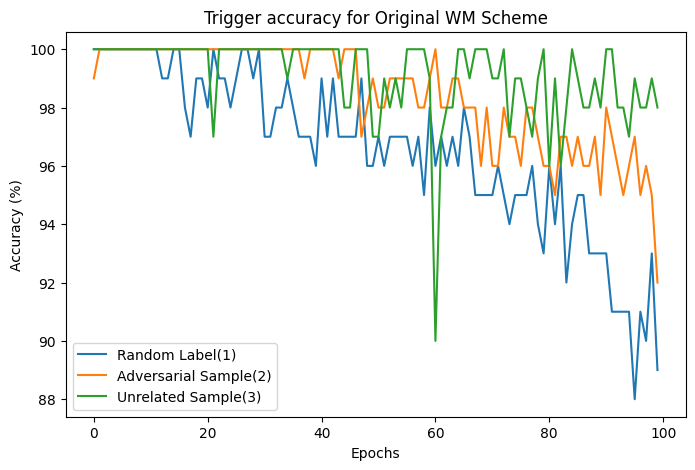

In [51]:
plt.figure(figsize=(8, 5))

plt.plot(range(len(metricsoriginalrand['trigger_acc'])), metricsoriginalrand['trigger_acc'], label='Random Label(1)')
plt.plot(range(len(metricsoriginaladv['trigger_acc'])), metricsoriginaladv['trigger_acc'], label='Adversarial Sample(2)')
plt.plot(range(len(metricsoriginalunrl['trigger_acc'])), metricsoriginalunrl['trigger_acc'], label='Unrelated Sample(3)')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Trigger accuracy for Original WM Scheme')
plt.legend()
plt.savefig('incre_trigger_acc_8020_ori_7.png')

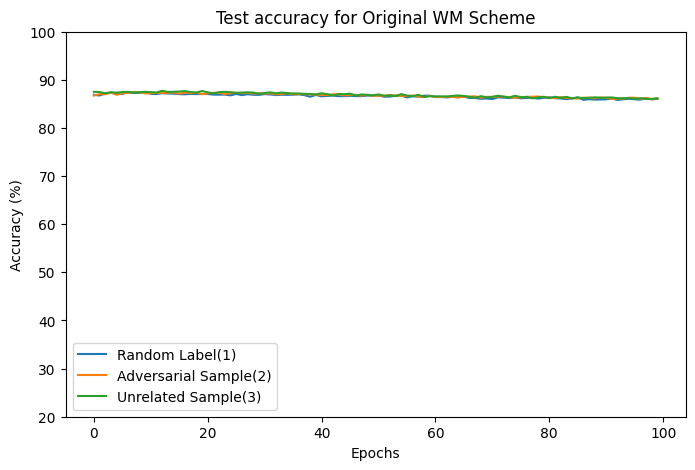

In [52]:
plt.figure(figsize=(8, 5))

plt.plot(range(len(metricsoriginalrand['val_acc'])), metricsoriginalrand['val_acc'], label='Random Label(1)')
plt.plot(range(len(metricsoriginaladv['val_acc'])), metricsoriginaladv['val_acc'], label='Adversarial Sample(2)')
plt.plot(range(len(metricsoriginalunrl['val_acc'])), metricsoriginalunrl['val_acc'], label='Unrelated Sample(3)')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test accuracy for Original WM Scheme')
plt.ylim([20, 100])

plt.legend()
plt.savefig('incre_test_acc_8020_ori_7.png')

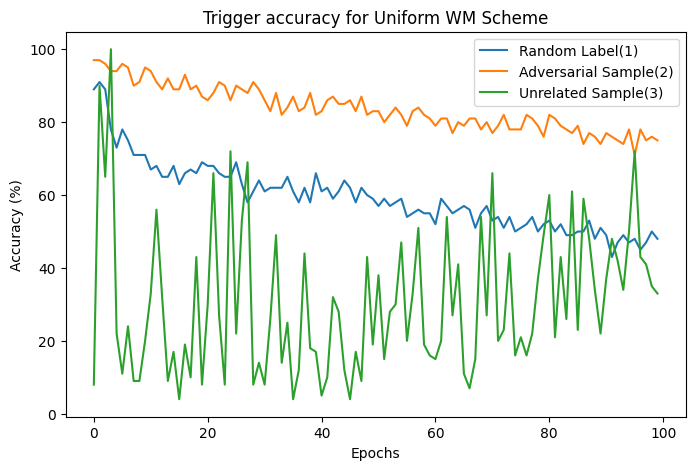

In [53]:
plt.figure(figsize=(8, 5))

plt.plot(range(len(metricsuniformrand['trigger_acc'])), metricsuniformrand['trigger_acc'], label='Random Label(1)')
plt.plot(range(len(metricsuniformadv['trigger_acc'])), metricsuniformadv['trigger_acc'], label='Adversarial Sample(2)')
plt.plot(range(len(metricsuniformunrl['trigger_acc'])), metricsuniformunrl['trigger_acc'], label='Unrelated Sample(3)')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Trigger accuracy for Uniform WM Scheme')
plt.legend()
plt.savefig('incre_trigger_acc_8020_uni_7.png')

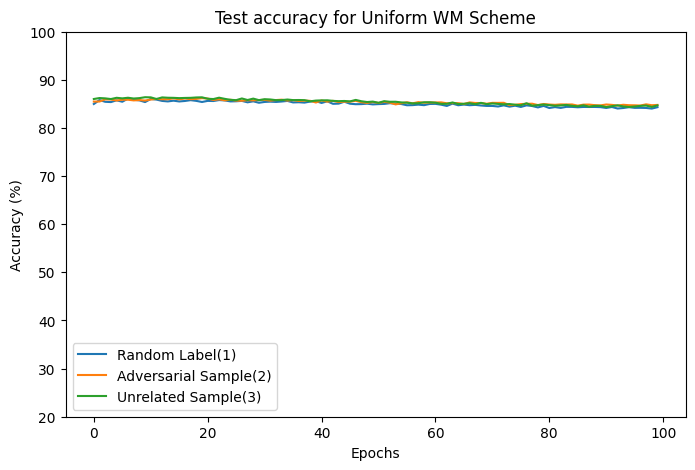

In [54]:
plt.figure(figsize=(8, 5))

plt.plot(range(len(metricsuniformrand['val_acc'])), metricsuniformrand['val_acc'], label='Random Label(1)')
plt.plot(range(len(metricsuniformadv['val_acc'])), metricsuniformadv['val_acc'], label='Adversarial Sample(2)')
plt.plot(range(len(metricsuniformunrl['val_acc'])), metricsuniformunrl['val_acc'], label='Unrelated Sample(3)')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test accuracy for Uniform WM Scheme')
plt.ylim([20, 100])

plt.legend()
plt.savefig('incre_test_acc_8020_uni_7.png')

In [55]:
netcertifiedrand = ResNet18()
netcertifiedrand.load_state_dict(torch.load('./models/wm_cifar10_certify_random_8020_rand.pth')['model_state_dict'])
netcertifiedadv = ResNet18()
netcertifiedadv.load_state_dict(torch.load('./models/wm_cifar10_certify_random_8020_adv.pth')['model_state_dict'])
netcertifiedunrl = ResNet18()
# netcertifiedunrl.load_state_dict(torch.load('./models/wm_cifar10_certify_random_8020_unrl.pth')['model_state_dict'])
netcertifiedunrl.load_state_dict(torch.load('./models/wm_cifar10_certify_random_8020.pth')['model_state_dict'])

<All keys matched successfully>

In [56]:
logcmt = f"incre_train_certified_8020"

optimizercertifiedrand = torch.optim.SGD(lr=0.001, params=netcertifiedrand.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainercertifiedrand = Trainer(netcertifiedrand, criterion, optimizercertifiedrand, incloader)
evaluatorcertifiedrand = Evaluator(netcertifiedrand, criterion)

metricscertifiedrand = train(trainercertifiedrand, evaluatorcertifiedrand, testloader, savename='inccheckpoints/incre_train_cert_8020_rand', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

Start Training...


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 0 | Time 10s| Train Loss 0.4781 | Train Acc 88.54| Val Loss 0.499 | Val Acc 88.19| Trigger Loss 0.007 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.57it/s]


Epoch 1 | Time 22s| Train Loss 0.4346 | Train Acc 89.04| Val Loss 0.488 | Val Acc 88.18| Trigger Loss 0.008 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.50it/s]


Epoch 2 | Time 33s| Train Loss 0.4024 | Train Acc 89.35| Val Loss 0.480 | Val Acc 88.46| Trigger Loss 0.011 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.36it/s]


Epoch 3 | Time 43s| Train Loss 0.3785 | Train Acc 89.85| Val Loss 0.470 | Val Acc 88.37| Trigger Loss 0.013 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.62it/s]


Epoch 4 | Time 53s| Train Loss 0.3537 | Train Acc 90.19| Val Loss 0.463 | Val Acc 88.33| Trigger Loss 0.017 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 5 | Time 63s| Train Loss 0.3289 | Train Acc 90.57| Val Loss 0.458 | Val Acc 88.27| Trigger Loss 0.023 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.63it/s]


Epoch 6 | Time 73s| Train Loss 0.3134 | Train Acc 90.66| Val Loss 0.454 | Val Acc 88.30| Trigger Loss 0.022 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.29it/s]


Epoch 7 | Time 84s| Train Loss 0.2966 | Train Acc 91.25| Val Loss 0.449 | Val Acc 88.38| Trigger Loss 0.030 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.02it/s]


Epoch 8 | Time 94s| Train Loss 0.2856 | Train Acc 91.30| Val Loss 0.446 | Val Acc 88.40| Trigger Loss 0.041 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 9 | Time 104s| Train Loss 0.2722 | Train Acc 91.89| Val Loss 0.444 | Val Acc 88.38| Trigger Loss 0.041 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.15it/s]


Epoch 10 | Time 113s| Train Loss 0.2663 | Train Acc 91.66| Val Loss 0.442 | Val Acc 88.32| Trigger Loss 0.048 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 11 | Time 124s| Train Loss 0.2573 | Train Acc 91.89| Val Loss 0.438 | Val Acc 88.22| Trigger Loss 0.056 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 12 | Time 133s| Train Loss 0.2459 | Train Acc 92.20| Val Loss 0.438 | Val Acc 88.26| Trigger Loss 0.057 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 13 | Time 143s| Train Loss 0.2294 | Train Acc 92.52| Val Loss 0.436 | Val Acc 88.25| Trigger Loss 0.058 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.29it/s]


Epoch 14 | Time 153s| Train Loss 0.2248 | Train Acc 92.78| Val Loss 0.437 | Val Acc 88.21| Trigger Loss 0.065 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 15 | Time 163s| Train Loss 0.2250 | Train Acc 92.52| Val Loss 0.435 | Val Acc 88.25| Trigger Loss 0.064 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.20it/s]


Epoch 16 | Time 172s| Train Loss 0.2103 | Train Acc 93.09| Val Loss 0.434 | Val Acc 88.15| Trigger Loss 0.063 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 17 | Time 183s| Train Loss 0.2204 | Train Acc 92.66| Val Loss 0.433 | Val Acc 88.23| Trigger Loss 0.066 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.23it/s]


Epoch 18 | Time 192s| Train Loss 0.2018 | Train Acc 93.49| Val Loss 0.432 | Val Acc 88.18| Trigger Loss 0.070 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.29it/s]


Epoch 19 | Time 203s| Train Loss 0.1980 | Train Acc 93.21| Val Loss 0.430 | Val Acc 88.19| Trigger Loss 0.069 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.26it/s]


Epoch 20 | Time 212s| Train Loss 0.1929 | Train Acc 93.58| Val Loss 0.429 | Val Acc 88.25| Trigger Loss 0.074 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 21 | Time 222s| Train Loss 0.1818 | Train Acc 94.03| Val Loss 0.429 | Val Acc 88.10| Trigger Loss 0.079 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.20it/s]


Epoch 22 | Time 232s| Train Loss 0.1839 | Train Acc 93.65| Val Loss 0.429 | Val Acc 88.12| Trigger Loss 0.078 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.32it/s]


Epoch 23 | Time 242s| Train Loss 0.1804 | Train Acc 94.19| Val Loss 0.430 | Val Acc 88.10| Trigger Loss 0.082 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 24 | Time 251s| Train Loss 0.1763 | Train Acc 94.12| Val Loss 0.431 | Val Acc 88.12| Trigger Loss 0.082 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Epoch 25 | Time 262s| Train Loss 0.1706 | Train Acc 94.37| Val Loss 0.430 | Val Acc 88.15| Trigger Loss 0.084 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.28it/s]


Epoch 26 | Time 271s| Train Loss 0.1671 | Train Acc 94.59| Val Loss 0.429 | Val Acc 88.13| Trigger Loss 0.081 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 27 | Time 281s| Train Loss 0.1621 | Train Acc 94.79| Val Loss 0.432 | Val Acc 88.12| Trigger Loss 0.089 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.26it/s]


Epoch 28 | Time 290s| Train Loss 0.1640 | Train Acc 94.59| Val Loss 0.431 | Val Acc 88.15| Trigger Loss 0.084 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.35it/s]


Epoch 29 | Time 301s| Train Loss 0.1532 | Train Acc 95.04| Val Loss 0.432 | Val Acc 88.16| Trigger Loss 0.090 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.24it/s]


Epoch 30 | Time 310s| Train Loss 0.1576 | Train Acc 94.61| Val Loss 0.432 | Val Acc 88.18| Trigger Loss 0.086 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 31 | Time 320s| Train Loss 0.1500 | Train Acc 95.05| Val Loss 0.433 | Val Acc 88.06| Trigger Loss 0.101 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.21it/s]


Epoch 32 | Time 330s| Train Loss 0.1533 | Train Acc 95.07| Val Loss 0.436 | Val Acc 88.03| Trigger Loss 0.097 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 33 | Time 340s| Train Loss 0.1452 | Train Acc 95.36| Val Loss 0.436 | Val Acc 88.09| Trigger Loss 0.102 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.22it/s]


Epoch 34 | Time 349s| Train Loss 0.1400 | Train Acc 95.37| Val Loss 0.437 | Val Acc 88.11| Trigger Loss 0.106 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 35 | Time 360s| Train Loss 0.1448 | Train Acc 95.12| Val Loss 0.437 | Val Acc 88.25| Trigger Loss 0.095 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.11it/s]


Epoch 36 | Time 369s| Train Loss 0.1412 | Train Acc 95.27| Val Loss 0.437 | Val Acc 88.24| Trigger Loss 0.097 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 37 | Time 380s| Train Loss 0.1383 | Train Acc 95.59| Val Loss 0.437 | Val Acc 88.18| Trigger Loss 0.091 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.94it/s]


Epoch 38 | Time 389s| Train Loss 0.1306 | Train Acc 95.56| Val Loss 0.435 | Val Acc 88.26| Trigger Loss 0.098 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.38it/s]


Epoch 39 | Time 400s| Train Loss 0.1297 | Train Acc 95.79| Val Loss 0.438 | Val Acc 88.24| Trigger Loss 0.091 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.88it/s]


Epoch 40 | Time 409s| Train Loss 0.1244 | Train Acc 95.88| Val Loss 0.438 | Val Acc 88.09| Trigger Loss 0.097 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 41 | Time 420s| Train Loss 0.1240 | Train Acc 95.79| Val Loss 0.443 | Val Acc 88.14| Trigger Loss 0.090 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.93it/s]


Epoch 42 | Time 429s| Train Loss 0.1217 | Train Acc 96.06| Val Loss 0.440 | Val Acc 88.16| Trigger Loss 0.095 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 43 | Time 440s| Train Loss 0.1156 | Train Acc 96.26| Val Loss 0.444 | Val Acc 88.20| Trigger Loss 0.089 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.87it/s]


Epoch 44 | Time 449s| Train Loss 0.1081 | Train Acc 96.60| Val Loss 0.444 | Val Acc 88.14| Trigger Loss 0.090 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 45 | Time 460s| Train Loss 0.1125 | Train Acc 96.34| Val Loss 0.444 | Val Acc 88.12| Trigger Loss 0.090 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.85it/s]


Epoch 46 | Time 469s| Train Loss 0.1103 | Train Acc 96.15| Val Loss 0.446 | Val Acc 88.13| Trigger Loss 0.095 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 47 | Time 479s| Train Loss 0.1070 | Train Acc 96.65| Val Loss 0.447 | Val Acc 88.09| Trigger Loss 0.095 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.89it/s]


Epoch 48 | Time 489s| Train Loss 0.1030 | Train Acc 96.52| Val Loss 0.450 | Val Acc 88.06| Trigger Loss 0.097 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.31it/s]


Epoch 49 | Time 499s| Train Loss 0.1028 | Train Acc 96.62| Val Loss 0.451 | Val Acc 88.08| Trigger Loss 0.100 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.82it/s]


Epoch 50 | Time 509s| Train Loss 0.1035 | Train Acc 96.55| Val Loss 0.453 | Val Acc 88.07| Trigger Loss 0.101 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.34it/s]


Epoch 51 | Time 519s| Train Loss 0.1011 | Train Acc 96.85| Val Loss 0.454 | Val Acc 88.04| Trigger Loss 0.107 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.82it/s]


Epoch 52 | Time 528s| Train Loss 0.0968 | Train Acc 96.93| Val Loss 0.454 | Val Acc 88.08| Trigger Loss 0.103 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 53 | Time 538s| Train Loss 0.0938 | Train Acc 97.11| Val Loss 0.455 | Val Acc 88.10| Trigger Loss 0.103 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.68it/s]


Epoch 54 | Time 548s| Train Loss 0.0930 | Train Acc 97.19| Val Loss 0.456 | Val Acc 87.98| Trigger Loss 0.098 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 55 | Time 558s| Train Loss 0.0963 | Train Acc 96.79| Val Loss 0.458 | Val Acc 87.91| Trigger Loss 0.100 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.65it/s]


Epoch 56 | Time 568s| Train Loss 0.0913 | Train Acc 97.19| Val Loss 0.459 | Val Acc 87.95| Trigger Loss 0.103 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.30it/s]


Epoch 57 | Time 578s| Train Loss 0.0911 | Train Acc 97.19| Val Loss 0.461 | Val Acc 88.06| Trigger Loss 0.101 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.58it/s]


Epoch 58 | Time 589s| Train Loss 0.0866 | Train Acc 97.37| Val Loss 0.462 | Val Acc 87.94| Trigger Loss 0.105 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.37it/s]


Epoch 59 | Time 599s| Train Loss 0.0840 | Train Acc 97.40| Val Loss 0.463 | Val Acc 88.03| Trigger Loss 0.110 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 60 | Time 604s| Train Loss 0.0840 | Train Acc 97.36| Val Loss 0.464 | Val Acc 87.95| Trigger Loss 0.116 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 61 | Time 609s| Train Loss 0.0808 | Train Acc 97.51| Val Loss 0.464 | Val Acc 88.03| Trigger Loss 0.121 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 62 | Time 614s| Train Loss 0.0789 | Train Acc 97.45| Val Loss 0.467 | Val Acc 87.92| Trigger Loss 0.119 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 63 | Time 620s| Train Loss 0.0737 | Train Acc 97.80| Val Loss 0.468 | Val Acc 87.96| Trigger Loss 0.126 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 64 | Time 625s| Train Loss 0.0738 | Train Acc 97.90| Val Loss 0.470 | Val Acc 87.86| Trigger Loss 0.126 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.34it/s]


Epoch 65 | Time 630s| Train Loss 0.0695 | Train Acc 97.85| Val Loss 0.470 | Val Acc 87.81| Trigger Loss 0.128 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.28it/s]


Epoch 66 | Time 635s| Train Loss 0.0751 | Train Acc 97.78| Val Loss 0.471 | Val Acc 87.78| Trigger Loss 0.125 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.33it/s]


Epoch 67 | Time 641s| Train Loss 0.0748 | Train Acc 97.63| Val Loss 0.472 | Val Acc 87.78| Trigger Loss 0.126 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 68 | Time 646s| Train Loss 0.0755 | Train Acc 97.77| Val Loss 0.473 | Val Acc 87.94| Trigger Loss 0.128 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 69 | Time 651s| Train Loss 0.0676 | Train Acc 98.14| Val Loss 0.473 | Val Acc 87.75| Trigger Loss 0.122 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 70 | Time 656s| Train Loss 0.0646 | Train Acc 98.12| Val Loss 0.474 | Val Acc 87.81| Trigger Loss 0.123 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 71 | Time 661s| Train Loss 0.0638 | Train Acc 97.99| Val Loss 0.475 | Val Acc 87.88| Trigger Loss 0.123 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 72 | Time 667s| Train Loss 0.0683 | Train Acc 98.14| Val Loss 0.477 | Val Acc 87.95| Trigger Loss 0.125 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 73 | Time 672s| Train Loss 0.0608 | Train Acc 98.31| Val Loss 0.479 | Val Acc 87.84| Trigger Loss 0.126 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.28it/s]


Epoch 74 | Time 677s| Train Loss 0.0644 | Train Acc 98.09| Val Loss 0.479 | Val Acc 87.88| Trigger Loss 0.128 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 75 | Time 682s| Train Loss 0.0583 | Train Acc 98.35| Val Loss 0.478 | Val Acc 87.91| Trigger Loss 0.131 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 76 | Time 687s| Train Loss 0.0628 | Train Acc 98.21| Val Loss 0.481 | Val Acc 87.76| Trigger Loss 0.133 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 77 | Time 693s| Train Loss 0.0609 | Train Acc 98.32| Val Loss 0.483 | Val Acc 87.79| Trigger Loss 0.138 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.35it/s]


Epoch 78 | Time 698s| Train Loss 0.0599 | Train Acc 98.39| Val Loss 0.483 | Val Acc 87.72| Trigger Loss 0.132 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 79 | Time 703s| Train Loss 0.0548 | Train Acc 98.39| Val Loss 0.484 | Val Acc 87.80| Trigger Loss 0.149 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 80 | Time 708s| Train Loss 0.0566 | Train Acc 98.56| Val Loss 0.485 | Val Acc 87.62| Trigger Loss 0.146 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 81 | Time 714s| Train Loss 0.0556 | Train Acc 98.53| Val Loss 0.489 | Val Acc 87.76| Trigger Loss 0.142 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 82 | Time 719s| Train Loss 0.0500 | Train Acc 98.73| Val Loss 0.488 | Val Acc 87.85| Trigger Loss 0.139 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 83 | Time 724s| Train Loss 0.0543 | Train Acc 98.53| Val Loss 0.488 | Val Acc 87.73| Trigger Loss 0.145 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.28it/s]


Epoch 84 | Time 729s| Train Loss 0.0505 | Train Acc 98.65| Val Loss 0.488 | Val Acc 87.76| Trigger Loss 0.138 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 85 | Time 735s| Train Loss 0.0485 | Train Acc 98.55| Val Loss 0.489 | Val Acc 87.68| Trigger Loss 0.142 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.39it/s]


Epoch 86 | Time 740s| Train Loss 0.0493 | Train Acc 98.74| Val Loss 0.492 | Val Acc 87.89| Trigger Loss 0.154 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.37it/s]


Epoch 87 | Time 745s| Train Loss 0.0493 | Train Acc 98.69| Val Loss 0.492 | Val Acc 87.71| Trigger Loss 0.156 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 88 | Time 750s| Train Loss 0.0468 | Train Acc 98.65| Val Loss 0.495 | Val Acc 87.82| Trigger Loss 0.164 | Trigger Acc 93.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.35it/s]


Epoch 89 | Time 755s| Train Loss 0.0488 | Train Acc 98.69| Val Loss 0.496 | Val Acc 87.70| Trigger Loss 0.169 | Trigger Acc 90.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 90 | Time 761s| Train Loss 0.0454 | Train Acc 98.76| Val Loss 0.498 | Val Acc 87.80| Trigger Loss 0.173 | Trigger Acc 91.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.38it/s]


Epoch 91 | Time 766s| Train Loss 0.0476 | Train Acc 98.67| Val Loss 0.496 | Val Acc 87.67| Trigger Loss 0.163 | Trigger Acc 92.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 92 | Time 771s| Train Loss 0.0430 | Train Acc 98.94| Val Loss 0.498 | Val Acc 87.76| Trigger Loss 0.167 | Trigger Acc 92.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.34it/s]


Epoch 93 | Time 776s| Train Loss 0.0447 | Train Acc 98.82| Val Loss 0.497 | Val Acc 87.78| Trigger Loss 0.166 | Trigger Acc 92.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.39it/s]


Epoch 94 | Time 781s| Train Loss 0.0461 | Train Acc 98.73| Val Loss 0.499 | Val Acc 87.69| Trigger Loss 0.184 | Trigger Acc 90.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 95 | Time 787s| Train Loss 0.0424 | Train Acc 98.92| Val Loss 0.503 | Val Acc 87.78| Trigger Loss 0.186 | Trigger Acc 92.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 96 | Time 792s| Train Loss 0.0392 | Train Acc 99.03| Val Loss 0.500 | Val Acc 87.87| Trigger Loss 0.180 | Trigger Acc 91.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 97 | Time 797s| Train Loss 0.0426 | Train Acc 98.84| Val Loss 0.499 | Val Acc 87.77| Trigger Loss 0.165 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 98 | Time 802s| Train Loss 0.0400 | Train Acc 98.95| Val Loss 0.501 | Val Acc 87.72| Trigger Loss 0.167 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 99 | Time 808s| Train Loss 0.0418 | Train Acc 98.88| Val Loss 0.504 | Val Acc 87.70| Trigger Loss 0.169 | Trigger Acc 91.00


In [57]:
logcmt = f"incre_train_certified_8020"

optimizercertifiedadv = torch.optim.SGD(lr=0.001, params=netcertifiedadv.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainercertifiedadv = Trainer(netcertifiedadv, criterion, optimizercertifiedadv, incloader)
evaluatorcertifiedadv = Evaluator(netcertifiedadv, criterion)

metricscertifiedadv = train(trainercertifiedadv, evaluatorcertifiedadv, testloader, savename='inccheckpoints/incre_train_cert_8020_adv', logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader, epochs=100)

Start Training...


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 0 | Time 5s| Train Loss 0.4943 | Train Acc 88.24| Val Loss 0.479 | Val Acc 88.50| Trigger Loss 0.017 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.36it/s]


Epoch 1 | Time 11s| Train Loss 0.4436 | Train Acc 88.70| Val Loss 0.468 | Val Acc 88.53| Trigger Loss 0.020 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.34it/s]


Epoch 2 | Time 17s| Train Loss 0.4115 | Train Acc 89.43| Val Loss 0.463 | Val Acc 88.63| Trigger Loss 0.024 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 3 | Time 22s| Train Loss 0.3784 | Train Acc 89.60| Val Loss 0.454 | Val Acc 88.71| Trigger Loss 0.028 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.39it/s]


Epoch 4 | Time 28s| Train Loss 0.3572 | Train Acc 90.21| Val Loss 0.449 | Val Acc 88.59| Trigger Loss 0.033 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.34it/s]


Epoch 5 | Time 33s| Train Loss 0.3317 | Train Acc 90.09| Val Loss 0.446 | Val Acc 88.64| Trigger Loss 0.035 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.37it/s]


Epoch 6 | Time 39s| Train Loss 0.3011 | Train Acc 91.38| Val Loss 0.440 | Val Acc 88.64| Trigger Loss 0.039 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.35it/s]


Epoch 7 | Time 44s| Train Loss 0.3044 | Train Acc 90.95| Val Loss 0.437 | Val Acc 88.53| Trigger Loss 0.039 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.33it/s]


Epoch 8 | Time 50s| Train Loss 0.2773 | Train Acc 91.46| Val Loss 0.434 | Val Acc 88.62| Trigger Loss 0.041 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.40it/s]


Epoch 9 | Time 55s| Train Loss 0.2669 | Train Acc 91.72| Val Loss 0.428 | Val Acc 88.61| Trigger Loss 0.044 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.35it/s]


Epoch 10 | Time 61s| Train Loss 0.2559 | Train Acc 91.88| Val Loss 0.424 | Val Acc 88.67| Trigger Loss 0.051 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.38it/s]


Epoch 11 | Time 66s| Train Loss 0.2498 | Train Acc 92.18| Val Loss 0.424 | Val Acc 88.64| Trigger Loss 0.052 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.33it/s]


Epoch 12 | Time 72s| Train Loss 0.2466 | Train Acc 92.01| Val Loss 0.422 | Val Acc 88.53| Trigger Loss 0.052 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.37it/s]


Epoch 13 | Time 77s| Train Loss 0.2349 | Train Acc 92.30| Val Loss 0.421 | Val Acc 88.43| Trigger Loss 0.055 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 14 | Time 83s| Train Loss 0.2306 | Train Acc 92.46| Val Loss 0.419 | Val Acc 88.39| Trigger Loss 0.060 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.37it/s]


Epoch 15 | Time 88s| Train Loss 0.2269 | Train Acc 92.78| Val Loss 0.418 | Val Acc 88.54| Trigger Loss 0.058 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.39it/s]


Epoch 16 | Time 94s| Train Loss 0.2187 | Train Acc 92.83| Val Loss 0.419 | Val Acc 88.34| Trigger Loss 0.056 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.35it/s]


Epoch 17 | Time 99s| Train Loss 0.2074 | Train Acc 93.17| Val Loss 0.420 | Val Acc 88.39| Trigger Loss 0.063 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.38it/s]


Epoch 18 | Time 105s| Train Loss 0.2036 | Train Acc 93.46| Val Loss 0.416 | Val Acc 88.44| Trigger Loss 0.069 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.33it/s]


Epoch 19 | Time 110s| Train Loss 0.1898 | Train Acc 93.68| Val Loss 0.413 | Val Acc 88.45| Trigger Loss 0.075 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 20 | Time 116s| Train Loss 0.1995 | Train Acc 93.29| Val Loss 0.416 | Val Acc 88.42| Trigger Loss 0.072 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.34it/s]


Epoch 21 | Time 121s| Train Loss 0.1875 | Train Acc 93.82| Val Loss 0.416 | Val Acc 88.38| Trigger Loss 0.075 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.35it/s]


Epoch 22 | Time 127s| Train Loss 0.1788 | Train Acc 94.01| Val Loss 0.414 | Val Acc 88.67| Trigger Loss 0.075 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 23 | Time 132s| Train Loss 0.1844 | Train Acc 93.73| Val Loss 0.415 | Val Acc 88.55| Trigger Loss 0.074 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.22it/s]


Epoch 24 | Time 138s| Train Loss 0.1764 | Train Acc 94.13| Val Loss 0.415 | Val Acc 88.55| Trigger Loss 0.074 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 25 | Time 143s| Train Loss 0.1726 | Train Acc 94.31| Val Loss 0.415 | Val Acc 88.43| Trigger Loss 0.076 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 26 | Time 148s| Train Loss 0.1652 | Train Acc 94.23| Val Loss 0.413 | Val Acc 88.66| Trigger Loss 0.082 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 27 | Time 154s| Train Loss 0.1613 | Train Acc 94.55| Val Loss 0.417 | Val Acc 88.72| Trigger Loss 0.082 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 28 | Time 159s| Train Loss 0.1592 | Train Acc 94.83| Val Loss 0.416 | Val Acc 88.69| Trigger Loss 0.085 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 29 | Time 164s| Train Loss 0.1510 | Train Acc 94.84| Val Loss 0.417 | Val Acc 88.56| Trigger Loss 0.086 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.28it/s]


Epoch 30 | Time 170s| Train Loss 0.1483 | Train Acc 94.83| Val Loss 0.417 | Val Acc 88.62| Trigger Loss 0.083 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 31 | Time 175s| Train Loss 0.1455 | Train Acc 95.00| Val Loss 0.420 | Val Acc 88.57| Trigger Loss 0.086 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.33it/s]


Epoch 32 | Time 180s| Train Loss 0.1419 | Train Acc 95.40| Val Loss 0.421 | Val Acc 88.56| Trigger Loss 0.086 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 33 | Time 186s| Train Loss 0.1431 | Train Acc 95.16| Val Loss 0.419 | Val Acc 88.61| Trigger Loss 0.089 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.28it/s]


Epoch 34 | Time 191s| Train Loss 0.1412 | Train Acc 95.31| Val Loss 0.424 | Val Acc 88.51| Trigger Loss 0.085 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 35 | Time 196s| Train Loss 0.1370 | Train Acc 95.47| Val Loss 0.420 | Val Acc 88.54| Trigger Loss 0.089 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 36 | Time 201s| Train Loss 0.1254 | Train Acc 95.81| Val Loss 0.424 | Val Acc 88.51| Trigger Loss 0.085 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 37 | Time 207s| Train Loss 0.1293 | Train Acc 95.65| Val Loss 0.425 | Val Acc 88.36| Trigger Loss 0.097 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 38 | Time 212s| Train Loss 0.1360 | Train Acc 95.53| Val Loss 0.427 | Val Acc 88.35| Trigger Loss 0.097 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.34it/s]


Epoch 39 | Time 217s| Train Loss 0.1226 | Train Acc 95.92| Val Loss 0.427 | Val Acc 88.36| Trigger Loss 0.095 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.33it/s]


Epoch 40 | Time 222s| Train Loss 0.1184 | Train Acc 96.06| Val Loss 0.430 | Val Acc 88.35| Trigger Loss 0.097 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 41 | Time 228s| Train Loss 0.1203 | Train Acc 95.82| Val Loss 0.430 | Val Acc 88.40| Trigger Loss 0.098 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.37it/s]


Epoch 42 | Time 233s| Train Loss 0.1199 | Train Acc 95.90| Val Loss 0.430 | Val Acc 88.34| Trigger Loss 0.102 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.35it/s]


Epoch 43 | Time 238s| Train Loss 0.1189 | Train Acc 96.01| Val Loss 0.433 | Val Acc 88.34| Trigger Loss 0.105 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.34it/s]


Epoch 44 | Time 243s| Train Loss 0.1090 | Train Acc 96.40| Val Loss 0.434 | Val Acc 88.51| Trigger Loss 0.103 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 45 | Time 248s| Train Loss 0.1121 | Train Acc 96.47| Val Loss 0.435 | Val Acc 88.42| Trigger Loss 0.105 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 46 | Time 254s| Train Loss 0.1100 | Train Acc 96.37| Val Loss 0.434 | Val Acc 88.41| Trigger Loss 0.104 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.35it/s]


Epoch 47 | Time 259s| Train Loss 0.1095 | Train Acc 96.48| Val Loss 0.434 | Val Acc 88.30| Trigger Loss 0.107 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.28it/s]


Epoch 48 | Time 264s| Train Loss 0.1051 | Train Acc 96.59| Val Loss 0.436 | Val Acc 88.31| Trigger Loss 0.105 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.16it/s]


Epoch 49 | Time 269s| Train Loss 0.1011 | Train Acc 96.71| Val Loss 0.438 | Val Acc 88.30| Trigger Loss 0.107 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.35it/s]


Epoch 50 | Time 275s| Train Loss 0.0981 | Train Acc 96.69| Val Loss 0.439 | Val Acc 88.24| Trigger Loss 0.106 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.18it/s]


Epoch 51 | Time 280s| Train Loss 0.1010 | Train Acc 96.71| Val Loss 0.438 | Val Acc 88.28| Trigger Loss 0.110 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.28it/s]


Epoch 52 | Time 285s| Train Loss 0.0945 | Train Acc 97.01| Val Loss 0.439 | Val Acc 88.20| Trigger Loss 0.113 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 53 | Time 290s| Train Loss 0.0950 | Train Acc 96.99| Val Loss 0.443 | Val Acc 88.17| Trigger Loss 0.109 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 54 | Time 295s| Train Loss 0.0939 | Train Acc 96.92| Val Loss 0.443 | Val Acc 88.25| Trigger Loss 0.113 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 55 | Time 301s| Train Loss 0.0952 | Train Acc 96.87| Val Loss 0.444 | Val Acc 88.22| Trigger Loss 0.111 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.28it/s]


Epoch 56 | Time 306s| Train Loss 0.0906 | Train Acc 97.21| Val Loss 0.444 | Val Acc 88.14| Trigger Loss 0.115 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 57 | Time 311s| Train Loss 0.0883 | Train Acc 97.22| Val Loss 0.445 | Val Acc 88.20| Trigger Loss 0.109 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 58 | Time 316s| Train Loss 0.0814 | Train Acc 97.40| Val Loss 0.449 | Val Acc 88.17| Trigger Loss 0.111 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 59 | Time 322s| Train Loss 0.0849 | Train Acc 97.46| Val Loss 0.449 | Val Acc 88.16| Trigger Loss 0.118 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 60 | Time 327s| Train Loss 0.0780 | Train Acc 97.60| Val Loss 0.451 | Val Acc 88.21| Trigger Loss 0.116 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 61 | Time 332s| Train Loss 0.0796 | Train Acc 97.63| Val Loss 0.452 | Val Acc 88.19| Trigger Loss 0.123 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.34it/s]


Epoch 62 | Time 337s| Train Loss 0.0784 | Train Acc 97.68| Val Loss 0.453 | Val Acc 88.16| Trigger Loss 0.128 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.35it/s]


Epoch 63 | Time 342s| Train Loss 0.0747 | Train Acc 97.71| Val Loss 0.456 | Val Acc 88.08| Trigger Loss 0.124 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.15it/s]


Epoch 64 | Time 348s| Train Loss 0.0745 | Train Acc 97.77| Val Loss 0.455 | Val Acc 88.21| Trigger Loss 0.118 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 65 | Time 353s| Train Loss 0.0743 | Train Acc 97.74| Val Loss 0.458 | Val Acc 88.05| Trigger Loss 0.125 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 66 | Time 358s| Train Loss 0.0743 | Train Acc 97.67| Val Loss 0.459 | Val Acc 87.95| Trigger Loss 0.122 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 67 | Time 363s| Train Loss 0.0723 | Train Acc 97.83| Val Loss 0.462 | Val Acc 88.06| Trigger Loss 0.122 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.33it/s]


Epoch 68 | Time 369s| Train Loss 0.0724 | Train Acc 97.87| Val Loss 0.463 | Val Acc 88.09| Trigger Loss 0.124 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 69 | Time 374s| Train Loss 0.0693 | Train Acc 98.06| Val Loss 0.463 | Val Acc 88.04| Trigger Loss 0.126 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 70 | Time 379s| Train Loss 0.0694 | Train Acc 97.94| Val Loss 0.464 | Val Acc 88.15| Trigger Loss 0.123 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 71 | Time 384s| Train Loss 0.0623 | Train Acc 98.36| Val Loss 0.465 | Val Acc 88.07| Trigger Loss 0.126 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 72 | Time 389s| Train Loss 0.0660 | Train Acc 98.05| Val Loss 0.468 | Val Acc 87.99| Trigger Loss 0.129 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.28it/s]


Epoch 73 | Time 395s| Train Loss 0.0695 | Train Acc 97.77| Val Loss 0.467 | Val Acc 87.95| Trigger Loss 0.135 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 74 | Time 400s| Train Loss 0.0621 | Train Acc 98.28| Val Loss 0.467 | Val Acc 88.10| Trigger Loss 0.130 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.28it/s]


Epoch 75 | Time 405s| Train Loss 0.0610 | Train Acc 98.29| Val Loss 0.470 | Val Acc 88.08| Trigger Loss 0.133 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.36it/s]


Epoch 76 | Time 410s| Train Loss 0.0624 | Train Acc 98.15| Val Loss 0.468 | Val Acc 88.08| Trigger Loss 0.141 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 77 | Time 415s| Train Loss 0.0573 | Train Acc 98.35| Val Loss 0.469 | Val Acc 88.13| Trigger Loss 0.133 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.35it/s]


Epoch 78 | Time 421s| Train Loss 0.0579 | Train Acc 98.18| Val Loss 0.471 | Val Acc 88.01| Trigger Loss 0.132 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.36it/s]


Epoch 79 | Time 426s| Train Loss 0.0583 | Train Acc 98.22| Val Loss 0.470 | Val Acc 88.08| Trigger Loss 0.133 | Trigger Acc 94.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 80 | Time 431s| Train Loss 0.0544 | Train Acc 98.59| Val Loss 0.473 | Val Acc 88.08| Trigger Loss 0.138 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 81 | Time 436s| Train Loss 0.0534 | Train Acc 98.66| Val Loss 0.473 | Val Acc 88.03| Trigger Loss 0.138 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 82 | Time 442s| Train Loss 0.0523 | Train Acc 98.59| Val Loss 0.475 | Val Acc 88.08| Trigger Loss 0.139 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.28it/s]


Epoch 83 | Time 447s| Train Loss 0.0537 | Train Acc 98.57| Val Loss 0.475 | Val Acc 88.08| Trigger Loss 0.134 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.33it/s]


Epoch 84 | Time 452s| Train Loss 0.0515 | Train Acc 98.67| Val Loss 0.475 | Val Acc 87.94| Trigger Loss 0.130 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 85 | Time 457s| Train Loss 0.0515 | Train Acc 98.65| Val Loss 0.477 | Val Acc 87.99| Trigger Loss 0.139 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 86 | Time 462s| Train Loss 0.0504 | Train Acc 98.60| Val Loss 0.480 | Val Acc 88.00| Trigger Loss 0.142 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.28it/s]


Epoch 87 | Time 468s| Train Loss 0.0478 | Train Acc 98.79| Val Loss 0.479 | Val Acc 87.92| Trigger Loss 0.135 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 88 | Time 473s| Train Loss 0.0487 | Train Acc 98.74| Val Loss 0.482 | Val Acc 88.06| Trigger Loss 0.135 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 89 | Time 478s| Train Loss 0.0458 | Train Acc 98.91| Val Loss 0.485 | Val Acc 88.01| Trigger Loss 0.138 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.35it/s]


Epoch 90 | Time 483s| Train Loss 0.0483 | Train Acc 98.58| Val Loss 0.486 | Val Acc 87.89| Trigger Loss 0.137 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 91 | Time 489s| Train Loss 0.0454 | Train Acc 98.82| Val Loss 0.487 | Val Acc 87.90| Trigger Loss 0.142 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 92 | Time 494s| Train Loss 0.0475 | Train Acc 98.74| Val Loss 0.484 | Val Acc 87.96| Trigger Loss 0.137 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.34it/s]


Epoch 93 | Time 499s| Train Loss 0.0462 | Train Acc 98.72| Val Loss 0.489 | Val Acc 87.88| Trigger Loss 0.136 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.37it/s]


Epoch 94 | Time 504s| Train Loss 0.0458 | Train Acc 98.88| Val Loss 0.489 | Val Acc 87.81| Trigger Loss 0.146 | Trigger Acc 95.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.34it/s]


Epoch 95 | Time 509s| Train Loss 0.0445 | Train Acc 98.77| Val Loss 0.488 | Val Acc 87.95| Trigger Loss 0.136 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 96 | Time 515s| Train Loss 0.0430 | Train Acc 98.85| Val Loss 0.487 | Val Acc 87.99| Trigger Loss 0.136 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 97 | Time 520s| Train Loss 0.0420 | Train Acc 98.99| Val Loss 0.488 | Val Acc 87.99| Trigger Loss 0.142 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.33it/s]


Epoch 98 | Time 525s| Train Loss 0.0437 | Train Acc 98.89| Val Loss 0.489 | Val Acc 87.91| Trigger Loss 0.141 | Trigger Acc 96.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 99 | Time 530s| Train Loss 0.0408 | Train Acc 98.95| Val Loss 0.492 | Val Acc 87.90| Trigger Loss 0.146 | Trigger Acc 96.00


In [58]:
logcmt = f"incre_train_certified_8020"

optimizercertifiedunrl = torch.optim.SGD(lr=0.001, params=netcertifiedunrl.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainercertifiedunrl = Trainer(netcertifiedunrl, criterion, optimizercertifiedunrl, incloader)
evaluatorcertifiedunrl = Evaluator(netcertifiedunrl, criterion)

metricscertifiedunrl = train(trainercertifiedunrl, evaluatorcertifiedunrl, testloader, savename='inccheckpoints/incre_train_cert_8020_unrl', logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader, epochs=100)

Start Training...


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.37it/s]


Epoch 0 | Time 5s| Train Loss 0.5482 | Train Acc 88.05| Val Loss 0.596 | Val Acc 87.65| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 1 | Time 11s| Train Loss 0.4803 | Train Acc 88.19| Val Loss 0.571 | Val Acc 87.83| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.36it/s]


Epoch 2 | Time 17s| Train Loss 0.4293 | Train Acc 88.97| Val Loss 0.549 | Val Acc 87.80| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 3 | Time 22s| Train Loss 0.4002 | Train Acc 89.67| Val Loss 0.535 | Val Acc 87.74| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 4 | Time 28s| Train Loss 0.3617 | Train Acc 89.79| Val Loss 0.526 | Val Acc 87.94| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.34it/s]


Epoch 5 | Time 33s| Train Loss 0.3555 | Train Acc 90.12| Val Loss 0.516 | Val Acc 87.97| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.33it/s]


Epoch 6 | Time 39s| Train Loss 0.3288 | Train Acc 90.27| Val Loss 0.507 | Val Acc 87.86| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.39it/s]


Epoch 7 | Time 44s| Train Loss 0.3155 | Train Acc 90.72| Val Loss 0.501 | Val Acc 87.83| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.33it/s]


Epoch 8 | Time 50s| Train Loss 0.2965 | Train Acc 91.11| Val Loss 0.491 | Val Acc 87.97| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.36it/s]


Epoch 9 | Time 55s| Train Loss 0.3019 | Train Acc 90.85| Val Loss 0.486 | Val Acc 87.84| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.33it/s]


Epoch 10 | Time 61s| Train Loss 0.2668 | Train Acc 91.64| Val Loss 0.483 | Val Acc 87.93| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.33it/s]


Epoch 11 | Time 66s| Train Loss 0.2571 | Train Acc 91.66| Val Loss 0.481 | Val Acc 88.00| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 12 | Time 72s| Train Loss 0.2570 | Train Acc 91.59| Val Loss 0.477 | Val Acc 87.84| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.36it/s]


Epoch 13 | Time 77s| Train Loss 0.2409 | Train Acc 92.34| Val Loss 0.473 | Val Acc 87.83| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.35it/s]


Epoch 14 | Time 83s| Train Loss 0.2410 | Train Acc 92.15| Val Loss 0.470 | Val Acc 88.03| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.39it/s]


Epoch 15 | Time 88s| Train Loss 0.2376 | Train Acc 92.32| Val Loss 0.467 | Val Acc 87.95| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.34it/s]


Epoch 16 | Time 94s| Train Loss 0.2293 | Train Acc 92.08| Val Loss 0.467 | Val Acc 87.76| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.37it/s]


Epoch 17 | Time 100s| Train Loss 0.2168 | Train Acc 92.79| Val Loss 0.468 | Val Acc 87.79| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.34it/s]


Epoch 18 | Time 105s| Train Loss 0.2226 | Train Acc 92.54| Val Loss 0.467 | Val Acc 87.91| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.28it/s]


Epoch 19 | Time 111s| Train Loss 0.2055 | Train Acc 93.04| Val Loss 0.464 | Val Acc 87.94| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 20 | Time 116s| Train Loss 0.2027 | Train Acc 93.38| Val Loss 0.464 | Val Acc 87.99| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.34it/s]


Epoch 21 | Time 121s| Train Loss 0.2029 | Train Acc 93.50| Val Loss 0.466 | Val Acc 87.92| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 22 | Time 127s| Train Loss 0.1938 | Train Acc 93.71| Val Loss 0.466 | Val Acc 87.98| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 23 | Time 132s| Train Loss 0.1923 | Train Acc 93.82| Val Loss 0.464 | Val Acc 87.80| Trigger Loss 0.006 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.37it/s]


Epoch 24 | Time 138s| Train Loss 0.1841 | Train Acc 93.77| Val Loss 0.465 | Val Acc 87.93| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.36it/s]


Epoch 25 | Time 143s| Train Loss 0.1794 | Train Acc 94.31| Val Loss 0.466 | Val Acc 87.79| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 26 | Time 149s| Train Loss 0.1803 | Train Acc 94.11| Val Loss 0.468 | Val Acc 87.67| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 27 | Time 154s| Train Loss 0.1748 | Train Acc 94.13| Val Loss 0.464 | Val Acc 87.72| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 28 | Time 160s| Train Loss 0.1632 | Train Acc 94.47| Val Loss 0.470 | Val Acc 87.78| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.38it/s]


Epoch 29 | Time 165s| Train Loss 0.1702 | Train Acc 94.15| Val Loss 0.469 | Val Acc 87.73| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 30 | Time 171s| Train Loss 0.1664 | Train Acc 94.31| Val Loss 0.470 | Val Acc 87.65| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.33it/s]


Epoch 31 | Time 176s| Train Loss 0.1627 | Train Acc 94.79| Val Loss 0.472 | Val Acc 87.90| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.34it/s]


Epoch 32 | Time 182s| Train Loss 0.1529 | Train Acc 94.90| Val Loss 0.474 | Val Acc 87.71| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 33 | Time 187s| Train Loss 0.1486 | Train Acc 95.09| Val Loss 0.476 | Val Acc 87.60| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 34 | Time 193s| Train Loss 0.1535 | Train Acc 94.83| Val Loss 0.479 | Val Acc 87.70| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.36it/s]


Epoch 35 | Time 198s| Train Loss 0.1460 | Train Acc 95.25| Val Loss 0.478 | Val Acc 87.71| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.35it/s]


Epoch 36 | Time 204s| Train Loss 0.1423 | Train Acc 95.21| Val Loss 0.481 | Val Acc 87.57| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.33it/s]


Epoch 37 | Time 209s| Train Loss 0.1408 | Train Acc 95.54| Val Loss 0.482 | Val Acc 87.59| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.34it/s]


Epoch 38 | Time 215s| Train Loss 0.1396 | Train Acc 95.31| Val Loss 0.486 | Val Acc 87.63| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 39 | Time 220s| Train Loss 0.1345 | Train Acc 95.65| Val Loss 0.489 | Val Acc 87.48| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 40 | Time 226s| Train Loss 0.1301 | Train Acc 95.68| Val Loss 0.491 | Val Acc 87.60| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.28it/s]


Epoch 41 | Time 231s| Train Loss 0.1241 | Train Acc 95.94| Val Loss 0.493 | Val Acc 87.48| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.37it/s]


Epoch 42 | Time 237s| Train Loss 0.1275 | Train Acc 95.78| Val Loss 0.491 | Val Acc 87.50| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.35it/s]


Epoch 43 | Time 242s| Train Loss 0.1240 | Train Acc 95.84| Val Loss 0.494 | Val Acc 87.48| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 44 | Time 248s| Train Loss 0.1235 | Train Acc 95.81| Val Loss 0.498 | Val Acc 87.55| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.34it/s]


Epoch 45 | Time 253s| Train Loss 0.1181 | Train Acc 96.14| Val Loss 0.497 | Val Acc 87.57| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.33it/s]


Epoch 46 | Time 259s| Train Loss 0.1148 | Train Acc 96.02| Val Loss 0.500 | Val Acc 87.53| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.35it/s]


Epoch 47 | Time 264s| Train Loss 0.1165 | Train Acc 96.36| Val Loss 0.499 | Val Acc 87.56| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 48 | Time 270s| Train Loss 0.1081 | Train Acc 96.54| Val Loss 0.500 | Val Acc 87.46| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.34it/s]


Epoch 49 | Time 275s| Train Loss 0.1099 | Train Acc 96.26| Val Loss 0.502 | Val Acc 87.55| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.41it/s]


Epoch 50 | Time 281s| Train Loss 0.1043 | Train Acc 96.37| Val Loss 0.507 | Val Acc 87.39| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 51 | Time 286s| Train Loss 0.1013 | Train Acc 96.77| Val Loss 0.512 | Val Acc 87.33| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 52 | Time 292s| Train Loss 0.0981 | Train Acc 96.85| Val Loss 0.511 | Val Acc 87.48| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 53 | Time 297s| Train Loss 0.1005 | Train Acc 96.69| Val Loss 0.512 | Val Acc 87.62| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.33it/s]


Epoch 54 | Time 303s| Train Loss 0.0986 | Train Acc 96.78| Val Loss 0.520 | Val Acc 87.32| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 55 | Time 308s| Train Loss 0.0934 | Train Acc 97.08| Val Loss 0.523 | Val Acc 87.20| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 56 | Time 314s| Train Loss 0.0926 | Train Acc 97.08| Val Loss 0.520 | Val Acc 87.45| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.20it/s]


Epoch 57 | Time 319s| Train Loss 0.0881 | Train Acc 97.09| Val Loss 0.522 | Val Acc 87.30| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 58 | Time 325s| Train Loss 0.0860 | Train Acc 97.19| Val Loss 0.524 | Val Acc 87.26| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 59 | Time 330s| Train Loss 0.0862 | Train Acc 97.21| Val Loss 0.526 | Val Acc 87.37| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.38it/s]


Epoch 60 | Time 336s| Train Loss 0.0794 | Train Acc 97.33| Val Loss 0.527 | Val Acc 87.23| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.37it/s]


Epoch 61 | Time 341s| Train Loss 0.0854 | Train Acc 97.27| Val Loss 0.530 | Val Acc 87.30| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 62 | Time 347s| Train Loss 0.0861 | Train Acc 97.23| Val Loss 0.532 | Val Acc 87.18| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 63 | Time 352s| Train Loss 0.0781 | Train Acc 97.45| Val Loss 0.535 | Val Acc 87.28| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 64 | Time 357s| Train Loss 0.0760 | Train Acc 97.55| Val Loss 0.535 | Val Acc 87.39| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 65 | Time 363s| Train Loss 0.0740 | Train Acc 97.75| Val Loss 0.536 | Val Acc 87.31| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.36it/s]


Epoch 66 | Time 368s| Train Loss 0.0701 | Train Acc 97.91| Val Loss 0.540 | Val Acc 87.19| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.39it/s]


Epoch 67 | Time 374s| Train Loss 0.0725 | Train Acc 97.86| Val Loss 0.542 | Val Acc 87.17| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 68 | Time 379s| Train Loss 0.0686 | Train Acc 97.94| Val Loss 0.547 | Val Acc 87.22| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 69 | Time 385s| Train Loss 0.0701 | Train Acc 97.87| Val Loss 0.546 | Val Acc 87.24| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 70 | Time 390s| Train Loss 0.0713 | Train Acc 97.71| Val Loss 0.547 | Val Acc 87.17| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.36it/s]


Epoch 71 | Time 396s| Train Loss 0.0679 | Train Acc 98.09| Val Loss 0.550 | Val Acc 87.13| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.34it/s]


Epoch 72 | Time 401s| Train Loss 0.0660 | Train Acc 97.82| Val Loss 0.554 | Val Acc 87.30| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.37it/s]


Epoch 73 | Time 407s| Train Loss 0.0682 | Train Acc 97.63| Val Loss 0.550 | Val Acc 87.26| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 74 | Time 412s| Train Loss 0.0675 | Train Acc 97.82| Val Loss 0.555 | Val Acc 87.27| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 75 | Time 418s| Train Loss 0.0677 | Train Acc 97.83| Val Loss 0.557 | Val Acc 87.10| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 76 | Time 423s| Train Loss 0.0594 | Train Acc 98.15| Val Loss 0.563 | Val Acc 87.09| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 77 | Time 429s| Train Loss 0.0585 | Train Acc 98.10| Val Loss 0.561 | Val Acc 87.21| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.35it/s]


Epoch 78 | Time 434s| Train Loss 0.0581 | Train Acc 98.43| Val Loss 0.568 | Val Acc 87.17| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.36it/s]


Epoch 79 | Time 440s| Train Loss 0.0526 | Train Acc 98.45| Val Loss 0.565 | Val Acc 87.22| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 80 | Time 445s| Train Loss 0.0563 | Train Acc 98.29| Val Loss 0.568 | Val Acc 87.11| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 81 | Time 451s| Train Loss 0.0551 | Train Acc 98.24| Val Loss 0.570 | Val Acc 87.13| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.36it/s]


Epoch 82 | Time 456s| Train Loss 0.0566 | Train Acc 98.28| Val Loss 0.571 | Val Acc 87.16| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 83 | Time 462s| Train Loss 0.0499 | Train Acc 98.58| Val Loss 0.574 | Val Acc 86.97| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.34it/s]


Epoch 84 | Time 467s| Train Loss 0.0453 | Train Acc 98.99| Val Loss 0.574 | Val Acc 87.14| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 85 | Time 473s| Train Loss 0.0512 | Train Acc 98.43| Val Loss 0.575 | Val Acc 87.05| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 86 | Time 478s| Train Loss 0.0500 | Train Acc 98.65| Val Loss 0.581 | Val Acc 86.88| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 87 | Time 484s| Train Loss 0.0496 | Train Acc 98.71| Val Loss 0.582 | Val Acc 87.11| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.36it/s]


Epoch 88 | Time 489s| Train Loss 0.0478 | Train Acc 98.75| Val Loss 0.578 | Val Acc 86.96| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 89 | Time 495s| Train Loss 0.0477 | Train Acc 98.60| Val Loss 0.585 | Val Acc 86.94| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 90 | Time 500s| Train Loss 0.0424 | Train Acc 98.86| Val Loss 0.586 | Val Acc 87.18| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.37it/s]


Epoch 91 | Time 506s| Train Loss 0.0456 | Train Acc 98.64| Val Loss 0.584 | Val Acc 87.09| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 92 | Time 511s| Train Loss 0.0438 | Train Acc 98.82| Val Loss 0.586 | Val Acc 87.22| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 93 | Time 517s| Train Loss 0.0419 | Train Acc 98.90| Val Loss 0.585 | Val Acc 87.07| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 94 | Time 522s| Train Loss 0.0422 | Train Acc 98.85| Val Loss 0.589 | Val Acc 87.00| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 95 | Time 528s| Train Loss 0.0427 | Train Acc 98.87| Val Loss 0.593 | Val Acc 87.25| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.38it/s]


Epoch 96 | Time 533s| Train Loss 0.0425 | Train Acc 98.71| Val Loss 0.590 | Val Acc 86.94| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 97 | Time 539s| Train Loss 0.0383 | Train Acc 98.92| Val Loss 0.599 | Val Acc 87.00| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.33it/s]


Epoch 98 | Time 544s| Train Loss 0.0388 | Train Acc 98.95| Val Loss 0.598 | Val Acc 87.07| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.36it/s]


Epoch 99 | Time 550s| Train Loss 0.0379 | Train Acc 98.98| Val Loss 0.595 | Val Acc 87.09| Trigger Loss 0.001 | Trigger Acc 100.00


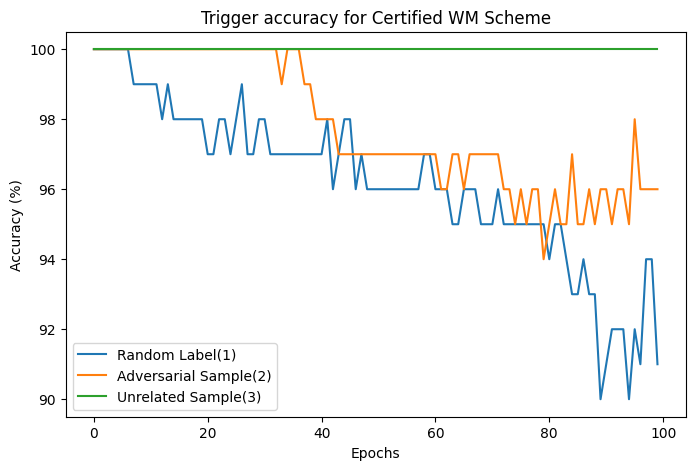

In [59]:
plt.figure(figsize=(8, 5))

plt.plot(range(len(metricscertifiedrand['trigger_acc'])), metricscertifiedrand['trigger_acc'], label='Random Label(1)')
plt.plot(range(len(metricscertifiedadv['trigger_acc'])), metricscertifiedadv['trigger_acc'], label='Adversarial Sample(2)')
plt.plot(range(len(metricscertifiedunrl['trigger_acc'])), metricscertifiedunrl['trigger_acc'], label='Unrelated Sample(3)')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Trigger accuracy for Certified WM Scheme')
plt.legend()
plt.savefig('incre_trigger_acc_8020_certified_7.png')

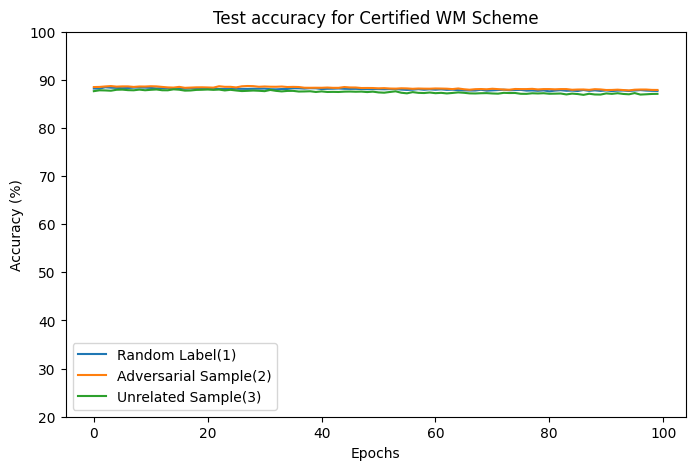

In [60]:
plt.figure(figsize=(8, 5))

plt.plot(range(len(metricscertifiedrand['val_acc'])), metricscertifiedrand['val_acc'], label='Random Label(1)')
plt.plot(range(len(metricscertifiedadv['val_acc'])), metricscertifiedadv['val_acc'], label='Adversarial Sample(2)')
plt.plot(range(len(metricscertifiedunrl['val_acc'])), metricscertifiedunrl['val_acc'], label='Unrelated Sample(3)')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test accuracy for Certified WM Scheme')
plt.ylim([20, 100])
plt.legend()
plt.savefig('incre_test_acc_8020_certified_7.png')